In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import matplotlib.cm as cm

#### Load data from table csvs

In [5]:
#district data
districts_df = pd.read_csv('../table_csvs/districts_table.csv').set_index(['District_Id'])

#budget data
functions_df = pd.read_csv('../table_csvs/functions_table.csv').set_index(['District_Id','Year'])
programs_df = pd.read_csv('../table_csvs/programs_table.csv').set_index(['District_Id','Year'])
revenue_df = pd.read_csv('../table_csvs/revenue_table.csv').set_index(['District_Id','Year'])

#school data
teachers_df = pd.read_csv('../table_csvs/teachers_table.csv').set_index(['District_Id','Year'])
enrollment_df = pd.read_csv('../table_csvs/enrollment_table.csv').set_index(['District_Id','Year'])
classes_df = pd.read_csv('../table_csvs/classes_table.csv').set_index(['District_Id','Year'])

#evaluation data
test_scores_df = pd.read_csv('../table_csvs/test_scores_table.csv').set_index(['District_Id','Year'])
dropout_rates_df = pd.read_csv('../table_csvs/dropout_rates_table.csv').set_index(['District_Id','Year'])

#Uncomment one at a time to see columns and different metrics of each
# functions_df.describe().T
# programs_df.describe().T
# revenue_df.describe().T

# teachers_df.describe().T
# enrollment_df.describe().T
# classes_df.describe().T

# test_scores_df.describe().T
# dropout_rates_df.describe().T

#### Define data helper functions for use in preparing the data

In [25]:
def get_percentage_df(df, tot_row_name):
    all_funds_df = df.filter(regex='(.*_All_Funds$)').div(df[tot_row_name + "_All_Funds"], axis=0)
    general_funds_df = df.filter(regex='(.*_General_Funds$)').div(df[tot_row_name + "_General_Funds"], axis=0)
    
    df[all_funds_df.columns] = all_funds_df
    df[general_funds_df.columns] = general_funds_df
    
    return df

In [26]:
def get_per_student_df(df, enrollment_df):
    per_student = pd.concat([df, enrollment_df], axis=1)
    per_student = per_student.div(per_student['Fall_Enrollment'],axis=0).drop(['Fall_Enrollment'],axis=1)
    
    return per_student

#### Create budget percentage and per student datasets
This is done for functions and programs but revenue is only used in per student dataset

In [8]:
functions_df_perc = get_percentage_df(functions_df.copy(), "Total_Expenditure_By_Function")
functions_df_perc.head()

Instruction_All_Funds  Instruction_General_Funds  \
District_Id Year                                                     
1902        2005               0.570841                   0.586747   
            2006               0.556930                   0.568751   
            2007               0.563114                   0.574649   
            2008               0.553936                   0.589157   
            2009               0.573033                   0.600865   

                  Instructional_Res_Media_All_Funds  \
District_Id Year                                      
1902        2005                           0.014416   
            2006                           0.018116   
            2007                           0.016514   
            2008                           0.010733   
            2009                           0.011038   

                  Instructional_Res_Media_General_Funds  \
District_Id Year                                          
1902        2005                               0.012579   
            2006                               0.019941   
            2007                               0.017839   
            2008                               0.011693   
            2009                               0.012267   

                  Curriculum_Staff_Develop_All_Funds  \
District_Id Year                                       
1902        2005                            0.000268   
            2006                            0.000963   
            2007                            0.001059   
            2008                            0.002288   
            2009                            0.001484   

                  Curriculum_Staff_Develop_General_Funds  \
District_Id Year                                           
1902        2005                                0.000167   
            2006                                0.000389   
            2007                                0.000192   
            2008                                0.000982   
            2009                                0.000259   

                  Instructional_Leadership_All_Funds  \
District_Id Year                                       
1902        2005                            0.001319   
            2006                            0.003644   
            2007                            0.000852   
            2008                            0.040830   
            2009                            0.028404   

                  Instructional_Leadership_General_Funds  \
District_Id Year                                           
1902        2005                                     0.0   
            2006                                     0.0   
            2007                                     0.0   
            2008                                     0.0   
            2009                                     0.0   

                  School_Administration_All_Funds  \
District_Id Year                                    
1902        2005                         0.057135   
            2006                         0.055388   
            2007                         0.054401   
            2008                         0.034825   
            2009                         0.034576   

                  School_Administration_General_Funds  ...  \
District_Id Year                                       ...   
1902        2005                             0.063118  ...   
            2006                             0.061667  ...   
            2007                             0.059860  ...   
            2008                             0.055503  ...   
            2009                             0.053734  ...   

                  Plant_Maintenance_Operation_All_Funds  \
District_Id Year                                          
1902        2005                               0.097546   
            2006                               0.112371   
            2007                               0.115231 

In [9]:
funct_per_student = get_per_student_df(functions_df.copy(), enrollment_df.copy())
funct_per_student.head()

Instruction_All_Funds  Instruction_General_Funds  \
District_Id Year                                                     
1902        2005            4092.806507                3783.885274   
            2006            4229.204467                3854.426117   
            2007            4644.550088                4307.441125   
            2008            7083.765517                4727.293103   
            2009            7393.742424                4988.651515   

                  Instructional_Res_Media_All_Funds  \
District_Id Year                                      
1902        2005                         103.359589   
            2006                         137.572165   
            2007                         136.209139   
            2008                         137.248276   
            2009                         142.424242   

                  Instructional_Res_Media_General_Funds  \
District_Id Year                                          
1902        2005                              81.119863   
            2006                             135.142612   
            2007                             133.720562   
            2008                              93.820690   
            2009                             101.846801   

                  Curriculum_Staff_Develop_All_Funds  \
District_Id Year                                       
1902        2005                            1.919521   
            2006                            7.309278   
            2007                            8.732865   
            2008                           29.255172   
            2009                           19.149832   

                  Curriculum_Staff_Develop_General_Funds  \
District_Id Year                                           
1902        2005                                1.077055   
            2006                                2.637457   
            2007                                1.441125   
            2008                                7.881034   
            2009                                2.149832   

                  Instructional_Leadership_All_Funds  \
District_Id Year                                       
1902        2005                            9.458904   
            2006                           27.673540   
            2007                            7.029877   
            2008                          522.131034   
            2009                          366.493266   

                  Instructional_Leadership_General_Funds  \
District_Id Year                                           
1902        2005                                     0.0   
            2006                                     0.0   
            2007                                     0.0   
            2008                                     0.0   
            2009                                     0.0   

                  School_Administration_All_Funds  \
District_Id Year                                    
1902        2005                       409.648973   
            2006                       420.606529   
            2007                       448.697715   
            2008                       445.346552   
            2009                       446.126263   

                  School_Administration_General_Funds  ...  \
District_Id Year                                       ...   
1902        2005                           407.044521  ...   
            2006                           417.919244  ...   
            2007                           448.697715  ...   
            2008                           445.346552  ...   
            2009                           446.126263  ...   

                  Plant_Maintenance_Operation_All_Funds  \
District_Id Year                                          
1902        2005                             699.385274   
            2006                             853.317869   
            2007                             950.420035 

In [27]:
program_df_perc = get_percentage_df(programs_df.copy(), "Total_Program_Expenditures")
program_df_perc.head()

Regular_All_Funds  Regular_General_Funds  \
District_Id Year                                             
1902        2005           0.538274               0.587818   
            2006           0.504891               0.555237   
            2007           0.507573               0.555315   
            2008           0.350387               0.551628   
            2009           0.370681               0.566371   

                  Gifted_Talented_All_Funds  Gifted_Talented_General_Funds  \
District_Id Year                                                             
1902        2005                   0.002442                       0.002690   
            2006                   0.002344                       0.002602   
            2007                   0.002091                       0.002301   
            2008                   0.001383                       0.002204   
            2009                   0.001338                       0.002079   

                  Career_Technology_All_Funds  \
District_Id Year                                
1902        2005                     0.022460   
            2006                     0.022253   
            2007                     0.024401   
            2008                     0.015246   
            2009                     0.017421   

                  Career_Technology_General_Funds  \
District_Id Year                                    
1902        2005                         0.024780   
            2006                         0.024742   
            2007                         0.026850   
            2008                         0.024299   
            2009                         0.027074   

                  Students_With_Disabilities_All_Funds  \
District_Id Year                                         
1902        2005                              0.071177   
            2006                              0.077559   
            2007                              0.076462   
            2008                              0.362557   
            2009                              0.334281   

                  Students_With_Disabilities_General_Funds  \
District_Id Year                                             
1902        2005                                  0.077915   
            2006                                  0.085905   
            2007                                  0.084135   
            2008                                  0.083766   
            2009                                  0.076257   

                  Compensatory_Education_All_Funds  \
District_Id Year                                     
1902        2005                          0.051782   
            2006                          0.069170   
            2007                          0.066844   
            2008                          0.045751   
            2009                          0.047617   

                  Compensatory_Education_General_Funds  ...  \
District_Id Year                                        ...   
1902        2005                              0.016278  ...   
            2006                              0.028517  ...   
            2007                              0.029528  ...   
            2008                              0.038731  ...   
            2009                              0.036901  ...   

                  Pre_K_Regular_All_Funds  Pre_K_Regular_General_Funds  \
District_Id Year                                                         
1902        2005                      0.0                          0.0   
            2006                      0.0                          0.0   
            2007                      0.0                          0.0   
            2008                      0.0                          0.0   
            2009                      0.0                          0.0   

                  Pre_K_Bilingual_All_Funds  Pre_K_Bilingual_General_Funds  \
District_Id Year                                            

In [11]:
program_per_student = get_per_student_df(programs_df.copy(), enrollment_df.copy())
program_per_student.head()

Regular_All_Funds  Regular_General_Funds  \
District_Id Year                                             
1902        2005        3859.306507            3790.794521   
            2006        3834.027491            3762.843643   
            2007        4186.446397            4162.520211   
            2008        4480.765517            4426.168966   
            2009        4782.831650            4702.267677   

                  Gifted_Talented_All_Funds  Gifted_Talented_General_Funds  \
District_Id Year                                                             
1902        2005                  17.511986                      17.347603   
            2006                  17.798969                      17.634021   
            2007                  17.249561                      17.249561   
            2008                  17.682759                      17.682759   
            2009                  17.259259                      17.259259   

                  Career_Technology_All_Funds  \
District_Id Year                                
1902        2005                   161.032534   
            2006                   168.982818   
            2007                   201.260105   
            2008                   194.972414   
            2009                   224.781145   

                  Career_Technology_General_Funds  \
District_Id Year                                    
1902        2005                       159.804795   
            2006                       167.675258   
            2007                       201.260105   
            2008                       194.972414   
            2009                       224.781145   

                  Students_With_Disabilities_All_Funds  \
District_Id Year                                         
1902        2005                            510.321918   
            2006                            588.969072   
            2007                            630.653779   
            2008                           4636.396552   
            2009                           4313.175084   

                  Students_With_Disabilities_General_Funds  \
District_Id Year                                             
1902        2005                                502.470890   
            2006                                582.180412   
            2007                                630.653779   
            2008                                672.124138   
            2009                                633.122896   

                  Compensatory_Education_All_Funds  \
District_Id Year                                     
1902        2005                        371.265411   
            2006                        525.262887   
            2007                        551.328647   
            2008                        585.068966   
            2009                        614.392256   

                  Compensatory_Education_General_Funds  ...  \
District_Id Year                                        ...   
1902        2005                            104.974315  ...   
            2006                            193.261168  ...   
            2007                            221.335677  ...   
            2008                            310.767241  ...   
            2009                            306.365320  ...   

                  Pre_K_Regular_All_Funds  Pre_K_Regular_General_Funds  \
District_Id Year                                                         
1902        2005                      0.0                          0.0   
            2006                      0.0                          0.0   
            2007                      0.0                          0.0   
            2008                      0.0                          0.0   
            2009                      0.0                          0.0   

                  Pre_K_Bilingual_All_Funds  Pre_K_Bilingual_General_Funds  \
District_Id Year                                            

In [12]:
revenue_per_student = pd.concat([revenue_df, enrollment_df], axis=1)
revenue_per_student = revenue_per_student.div(revenue_per_student['Fall_Enrollment'],axis=0).drop(['Fall_Enrollment'],axis=1)
revenue_per_student.head()

Total_Revenue_All_Funds  Total_Revenue_General_Funds  \
District_Id Year                                                         
1902        2005              9583.652397                  8857.416096   
            2006              8880.910653                  8057.941581   
            2007             10726.945518                  9933.328647   
            2008             16678.003448                 10166.601724   
            2009             13931.471380                  9493.080808   

                  Total_Federal_Revenue_All_Funds  \
District_Id Year                                    
1902        2005                       410.268836   
            2006                       507.532646   
            2007                       439.662566   
            2008                      3193.484483   
            2009                      2887.185185   

                  Total_Federal_Revenue_General_Funds  \
District_Id Year                                        
1902        2005                                  0.0   
            2006                                  0.0   
            2007                                  0.0   
            2008                                  0.0   
            2009                                  0.0   

                  Total_State_Revenue_All_Funds  \
District_Id Year                                  
1902        2005                    1341.828767   
            2006                    1004.886598   
            2007                    2067.281195   
            2008                    4051.950000   
            2009                    4163.927609   

                  Total_State_Revenue_General_Funds  \
District_Id Year                                      
1902        2005                        1234.905822   
            2006                         898.350515   
            2007                        1958.135325   
            2008                        3181.434483   
            2009                        3283.112795   

                  Total_Local_Revenue_All_Funds  \
District_Id Year                                  
1902        2005                    6462.398973   
            2006                    6604.077320   
            2007                    7245.258348   
            2008                    6278.191379   
            2009                    5587.818182   

                  Total_Local_Revenue_General_Funds  
District_Id Year                                     
1902        2005                        6462.398973  
            2006                        6604.077320  
            2007                        7245.258348  
            2008                        6278.191379  
            2009                        5587.818182

#### Define helper functions for use in model

In [12]:
def clean_dataset(dataset):
    dataset = dataset[dataset.Year > 2004] #No budget data for prior to 2004

    #get only rows with data for all years 2005-2019
    for dist in dataset.District_Id.unique():
        if len(dataset[dataset.District_Id == dist].Year.unique()) != len(range(2005,2020)):
            dataset = dataset[dataset.District_Id != dist]

    #remove charter schools
    non_charter_districts = districts_df[districts_df['Charter_Flag'] == 0].reset_index()
    dataset = pd.merge(non_charter_districts, dataset, on='District_Id', how='inner').drop(['Charter_Flag', 'District_Name'],axis=1)

    return dataset

In [13]:
def split_windows(df, window_size=4):
    inputs = np.empty((0, window_size, len(df.columns)))
    labels = np.array([])
    
    for i in range(len(df.Year.unique()) - window_size + 1):
        start_year = 2005
        
        window_df = df.loc[df.Year >= start_year + i].loc[df.Year < start_year + i + window_size]
        ids = len(window_df.District_Id.unique())
        window_array = np.array(window_df)
        
        window_inputs = np.array(np.array_split(window_array, ids))
        
        inputs = np.concatenate((inputs, window_inputs),axis=0)
    
    #remove data points that have nan in score column
    inputs = inputs[np.sum(np.isnan(inputs[:,:,-1]),axis=1) == 0]
    
    return inputs

In [14]:
def get_labels(data):
    labels = data[:,-1,-1].copy()
    data[:,-1,-1] = 1
    
    return labels

In [15]:
def get_train_test(inputs, splits, label_scaler, hi_lo, hi_lo_duplicates=2):
    scores = label_scaler.inverse_transform(inputs[:,-1,-1].reshape(1,-1))
    
    hi = inputs[(scores > hi_lo[1]).reshape(inputs[:,-1,-1].shape),:,:]
    lo = inputs[(scores < hi_lo[0]).reshape(inputs[:,-1,-1].shape),:,:]
    mid = inputs[((scores <= hi_lo[1]) * (scores >= hi_lo[0])).reshape(inputs[:,-1,-1].shape),:,:]
    
    np.random.shuffle(hi)
    np.random.shuffle(lo)
    np.random.shuffle(mid)
    
    hi_splits = (splits * hi.shape[0]).astype(int)
    train_hi = hi[:hi_splits[0],:,:]
    test_hi = hi[hi_splits[0]:hi_splits[1],:,:]

    mid_splits = (splits * mid.shape[0]).astype(int)
    train_mid = mid[:mid_splits[0],:,:]
    test_mid = mid[mid_splits[0]:mid_splits[1],:,:]

    lo_splits = (splits * lo.shape[0]).astype(int)
    train_lo = lo[:lo_splits[0],:,:]
    test_lo = lo[lo_splits[0]:lo_splits[1],:,:]
    
    test = np.concatenate((test_hi, test_mid, test_lo))
    
    train = train_mid
    for _ in range(hi_lo_duplicates):
        train = np.concatenate((train,train_hi,train_lo))
    
    return train, test

In [16]:
def normalize_data(filtered_dataset):
    #Normalize data to range 0-1
    label_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_labels = label_scaler.fit_transform(np.array(filtered_dataset)[:,-1].reshape(-1,1))

    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = feature_scaler.fit_transform(np.array(filtered_dataset)[:,2:-1])

    scaled_dataset = pd.DataFrame(np.hstack((np.array(filtered_dataset)[:,:2], scaled_features, scaled_labels)), columns=filtered_dataset.columns)
    
    return scaled_dataset, label_scaler, feature_scaler


In [228]:
def get_individual_features(window, train_inputs, test_inputs):
    train_inputs_list = []
    test_inputs_list = []
    
    for i in range(train_inputs.shape[2]):
        train_inputs_list.append(train_inputs[:,:,i].reshape(train_inputs.shape[0],window,1))
        test_inputs_list.append(test_inputs[:,:,i].reshape(test_inputs.shape[0],window,1))
    
    return train_inputs_list, test_inputs_list

In [18]:
def create_model(window, features):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = (window, features)))
    model.add(tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = (window, features)))
    model.add(tf.keras.layers.LSTM(units = 64, return_sequences = False))

    model.add(Dense(units = 1))
    
    model.compile(optimizer = tf.optimizers.Adam(), loss = tf.losses.Huber(), metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model

In [24]:
def fit_predict(model, name, train_data, train_labels, test_data, test_labels, label_scaler, hi_lo):
    model.fit(train_data, train_labels, epochs = 10, batch_size=32)
    
    predictions = model.predict(test_data)
    predictions = label_scaler.inverse_transform(predictions)

    actual = label_scaler.inverse_transform(test_labels.reshape(1,-1))

    comp = pd.DataFrame(np.hstack((actual.T, predictions)),columns=['actual','predicted'])
    
    high = np.array(comp[comp['actual'] > hi_lo[1]])
    mid = np.array(comp[comp['actual'] >= hi_lo[0]][comp['actual'] <= hi_lo[1]])
    low = np.array(comp[comp['actual'] < hi_lo[0]])
    tot = np.array(comp)

    Total_MSE = np.sqrt(np.mean((tot[:,0] - tot[:,1])**2))
    High_MSE = np.sqrt(np.mean((high[:,0] - high[:,1])**2))
    Mid_MSE = np.sqrt(np.mean((mid[:,0] - mid[:,1])**2))
    Low_MSE = np.sqrt(np.mean((low[:,0] - low[:,1])**2))
    

    print(comp.head(5))
    print(comp[comp['actual'] > hi_lo[1]].head(5))
    print(comp[comp['actual'] < hi_lo[0]].head(5))
    
    return pd.DataFrame(data=[[Total_MSE, High_MSE, Mid_MSE, Low_MSE]], index=[name], columns=['Total MSE','High MSE','Mid MSE','Low MSE'])

In [19]:
def plot_sat_act_results(df, result):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title(result)
    plt.xlabel("Sat")
    plt.ylabel("Act")
    for i, row in enumerate(df.T.filter(regex= result + ".*").T.iterrows()):
        ax.scatter(row[1]['Sat'], row[1]['Act'], label=row[0].replace(result + ' ', ''), s=30)
    ax.legend()

#### Main function that runs the model

In [230]:
def run_model(window, data_type, runs=10, run_list=["All"]):
    #hyperparameters
    EPOCHS = 10
    BATCH_SIZE = 32
    window = 6
    splits = np.array([.8,1])

    #Test score metric used for analysis
    act_test_score_column = 'Avg_Act'
    act_hi_lo = [15,25]

    sat_test_score_column = 'Avg_Sat'
    sat_hi_lo = [800,1200]

    #Combine into one df
    if data_type == "per_student":
        #budget per student
        act_dataset = pd.concat([revenue_per_student, program_per_student, funct_per_student, test_scores_df[act_test_score_column].to_frame()], axis=1).reset_index()
        sat_dataset = pd.concat([revenue_per_student, program_per_student, funct_per_student, test_scores_df[sat_test_score_column].to_frame()], axis=1).reset_index()
    else:
        #budget percentages
        act_dataset = pd.concat([program_df_perc, functions_df_perc, test_scores_df[act_test_score_column].to_frame()], axis=1).reset_index()
        sat_dataset = pd.concat([program_df_perc, functions_df_perc, test_scores_df[sat_test_score_column].to_frame()], axis=1).reset_index()
    
    #clean data
    clean_act_dataset = clean_dataset(act_dataset)
    clean_sat_dataset = clean_dataset(sat_dataset)

    filtered_act_dataset = clean_act_dataset.filter(regex='(.*_Funds$)|(Avg_.*)|(District_Id)|(Year)')
    filtered_sat_dataset = clean_sat_dataset.filter(regex='(.*_Funds$)|(Avg_.*)|(District_Id)|(Year)')

    #normalize data
    scaled_act_dataset, act_label_scaler, act_feature_scaler = normalize_data(filtered_act_dataset)
    scaled_sat_dataset, sat_label_scaler, sat_feature_scaler = normalize_data(filtered_sat_dataset)

    #split data into windows
    act_inputs = split_windows(scaled_act_dataset, window)
    sat_inputs = split_windows(scaled_sat_dataset, window)

    #get performance across multiple runs
    act_results_df = pd.DataFrame(columns=['Total MSE','High MSE','Mid MSE','Low MSE'])
    sat_results_df = pd.DataFrame(columns=['Total MSE','High MSE','Mid MSE','Low MSE'])

    act_results_df_budget = pd.DataFrame(columns=['Total MSE','High MSE','Mid MSE','Low MSE'])
    sat_results_df_budget = pd.DataFrame(columns=['Total MSE','High MSE','Mid MSE','Low MSE'])

    act_results_df_scores = pd.DataFrame(columns=['Total MSE','High MSE','Mid MSE','Low MSE'])
    sat_results_df_scores = pd.DataFrame(columns=['Total MSE','High MSE','Mid MSE','Low MSE'])

    act_results_df_garbage = pd.DataFrame(columns=['Total MSE','High MSE','Mid MSE','Low MSE'])
    sat_results_df_garbage = pd.DataFrame(columns=['Total MSE','High MSE','Mid MSE','Low MSE'])
    
    act_results_by_feature = pd.DataFrame(columns=['Total MSE','High MSE','Mid MSE','Low MSE'])
    sat_results_by_feature = pd.DataFrame(columns=['Total MSE','High MSE','Mid MSE','Low MSE'])

    for i in range(runs):
        #split into train and test sets
        act_train, act_test = get_train_test(act_inputs, splits, act_label_scaler, act_hi_lo,1)
        sat_train, sat_test = get_train_test(sat_inputs, splits, sat_label_scaler, sat_hi_lo,1)

        np.random.shuffle(act_train)
        np.random.shuffle(act_test)

        np.random.shuffle(sat_train)
        np.random.shuffle(sat_test)

        #get labels from last score in window
        act_train_inputs_district_and_year = act_train
        act_train_labels = get_labels(act_train)

        sat_train_inputs_district_and_year = sat_train
        sat_train_labels = get_labels(sat_train)

        act_test_inputs_district_and_year = act_test
        act_test_labels = get_labels(act_test)

        sat_test_inputs_district_and_year = sat_test
        sat_test_labels = get_labels(sat_test)

        #remove district number and year columns
        act_train_inputs = act_train_inputs_district_and_year[:,:,2:]
        act_test_inputs = act_test_inputs_district_and_year[:,:,2:]

        sat_train_inputs = sat_train_inputs_district_and_year[:,:,2:]
        sat_test_inputs = sat_test_inputs_district_and_year[:,:,2:]
        
        #Run the real model with budget and scores data
        if "All" in run_list or "Real" in run_list:
            real_model_act = create_model(window,act_train_inputs.shape[2])
            real_model_sat = create_model(window,sat_train_inputs.shape[2])

            real_results_sat = fit_predict(real_model_sat, "Real_Sat_" + str(i), sat_train_inputs, sat_train_labels, sat_test_inputs, sat_test_labels, sat_label_scaler, sat_hi_lo)
            real_results_act = fit_predict(real_model_act, "Real_Act_" + str(i), act_train_inputs, act_train_labels, act_test_inputs, act_test_labels, act_label_scaler, act_hi_lo)

            sat_results_df = pd.concat([sat_results_df, real_results_sat])
            act_results_df = pd.concat([act_results_df, real_results_act])

        #Create inputs that just consist of scores for comparison
        if "All" in run_list or "Scores" in run_list:
            act_scores_train_inputs = act_train_inputs[:,:,-1].reshape(act_train_inputs.shape[0],window,1)
            act_scores_test_inputs = act_test_inputs[:,:,-1].reshape(act_test_inputs.shape[0],window,1)

            sat_scores_train_inputs = sat_train_inputs[:,:,-1].reshape(sat_train_inputs.shape[0],window,1)
            sat_scores_test_inputs = sat_test_inputs[:,:,-1].reshape(sat_test_inputs.shape[0],window,1)

            scores_only_model_act = create_model(window,act_scores_train_inputs.shape[2])
            scores_only_model_sat = create_model(window,sat_scores_train_inputs.shape[2])

            scores_results_sat = fit_predict(scores_only_model_sat, "Scores_Sat_" + str(i), sat_scores_train_inputs, sat_train_labels, sat_scores_test_inputs, sat_test_labels, sat_label_scaler, sat_hi_lo)
            scores_results_act = fit_predict(scores_only_model_act, "Scores_Act_" + str(i), act_scores_train_inputs, act_train_labels, act_scores_test_inputs, act_test_labels, act_label_scaler, act_hi_lo)

            sat_results_df_scores = pd.concat([sat_results_df_scores, scores_results_sat])
            act_results_df_scores = pd.concat([act_results_df_scores, scores_results_act])

        #Create inputs that consists of just budget data for comparison
        if "All" in run_list or "Budget" in run_list:
            act_budget_train_inputs = act_train_inputs[:,:,:-1]
            act_budget_test_inputs = act_test_inputs[:,:,:-1]

            sat_budget_train_inputs = sat_train_inputs[:,:,:-1]
            sat_budget_test_inputs = sat_test_inputs[:,:,:-1]

            budget_only_model_act = create_model(window,act_budget_train_inputs.shape[2])
            budget_only_model_sat = create_model(window,sat_budget_train_inputs.shape[2])

            budget_results_sat = fit_predict(budget_only_model_sat, "Budget_Sat_" + str(i), sat_budget_train_inputs, sat_train_labels, sat_budget_test_inputs, sat_test_labels, sat_label_scaler, sat_hi_lo)
            budget_results_act = fit_predict(budget_only_model_act, "Budget_Act_" + str(i), act_budget_train_inputs, act_train_labels, act_budget_test_inputs, act_test_labels, act_label_scaler, act_hi_lo)

            sat_results_df_budget = pd.concat([sat_results_df_budget, budget_results_sat])
            act_results_df_budget = pd.concat([act_results_df_budget, budget_results_act])
        
        #Garbage data model to gauge worst case
        if "All" in run_list or "Garbage" in run_list:
            rand_data_sat = np.random.rand(sat_train_inputs.shape[0],sat_train_inputs.shape[1],sat_train_inputs.shape[2])
            rand_data_act = np.random.rand(act_train_inputs.shape[0],act_train_inputs.shape[1],act_train_inputs.shape[2])

            garbage_model_act = create_model(window, act_train_inputs.shape[2])
            garbage_model_sat = create_model(window, sat_train_inputs.shape[2])

            garbage_results_sat = fit_predict(garbage_model_sat, "Garbage_Sat_" + str(i), rand_data_sat, sat_train_labels, sat_test_inputs, sat_test_labels, sat_label_scaler, sat_hi_lo)
            garbage_results_act = fit_predict(garbage_model_act, "Garbage_Act_" + str(i), rand_data_act, act_train_labels, act_test_inputs, act_test_labels, act_label_scaler, act_hi_lo)

            sat_results_df_garbage = pd.concat([sat_results_df_garbage, garbage_results_sat])
            act_results_df_garbage = pd.concat([act_results_df_garbage, garbage_results_act])
        
        #get train and test for individual budget elements
        if "Individual" in run_list:
            act_train_inputs_list, act_test_inputs_list = get_individual_features(window, act_train_inputs, act_test_inputs)
            sat_train_inputs_list, sat_test_inputs_list = get_individual_features(window, sat_train_inputs, sat_test_inputs)
            
            input_names_act = np.array(act_dataset.columns)[2:]
            input_names_sat = np.array(sat_dataset.columns)[2:]
            
            #create model for individual budget elements
            for i in range(len(act_train_inputs_list)):
                curr_model = create_model(window, act_train_inputs_list[i].shape[2])
                curr_res = fit_predict(curr_model, input_names_act[i] + "_Act", act_train_inputs_list[i], act_train_labels, act_test_inputs_list[i], act_test_labels, act_label_scaler, act_hi_lo)
                act_results_by_feature = pd.concat([act_results_by_feature, curr_res])
                
            for i in range(len(act_train_inputs_list)):
                curr_model = create_model(window, sat_train_inputs_list[i].shape[2])
                curr_res = fit_predict(curr_model, input_names_sat[i] + "_Sat", sat_train_inputs_list[i], sat_train_labels, sat_test_inputs_list[i], sat_test_labels, sat_label_scaler, sat_hi_lo)
                sat_results_by_feature = pd.concat([sat_results_by_feature, curr_res])
        
    
    results = pd.concat([sat_results_df, act_results_df, sat_results_df_budget, act_results_df_budget, sat_results_df_scores, act_results_df_scores, sat_results_df_garbage, act_results_df_garbage, act_results_by_feature, sat_results_by_feature])
    return results


# Results

#### Get results for comapring performance of different window sizes
Commented because it takes 5+ hours to run (results can be found by reading the below csvs)

In [31]:
# window_1 = run_model(1,"per_student",["Real"],10)
# window_2 = run_model(2,"per_student",["Real"],10)
# window_4 = run_model(4,"per_student",["Real"],10)
# window_8 = run_model(8,"per_student",["Real"],10)
# window_10 = run_model(10,"per_student",["Real"],10)
# window_12 = run_model(12,"per_student",["Real"],10)

# sat_window_1_mean = window_1.filter(regex='Real_Sat.*',axis=0).mean().to_frame().rename(columns={0:"window_1"})
# sat_window_2_mean = window_2.filter(regex='Real_Sat.*',axis=0).mean().to_frame().rename(columns={0:"window_2"})
# sat_window_4_mean = window_4.filter(regex='Real_Sat.*',axis=0).mean().to_frame().rename(columns={0:"window_4"})
# sat_window_8_mean = window_8.filter(regex='Real_Sat.*',axis=0).mean().to_frame().rename(columns={0:"window_8"})
# sat_window_10_mean = window_10.filter(regex='Real_Sat.*',axis=0).mean().to_frame().rename(columns={0:"window_10"})
# sat_window_12_mean = window_12.filter(regex='Real_Sat.*',axis=0).mean().to_frame().rename(columns={0:"window_12"})

# act_window_1_mean = window_1.filter(regex='Real_Act.*',axis=0).mean().to_frame().rename(columns={0:"window_1"})
# act_window_2_mean = window_2.filter(regex='Real_Act.*',axis=0).mean().to_frame().rename(columns={0:"window_2"})
# act_window_4_mean = window_4.filter(regex='Real_Act.*',axis=0).mean().to_frame().rename(columns={0:"window_4"})
# act_window_8_mean = window_8.filter(regex='Real_Act.*',axis=0).mean().to_frame().rename(columns={0:"window_8"})
# act_window_10_mean = window_10.filter(regex='Real_Act.*',axis=0).mean().to_frame().rename(columns={0:"window_10"})
# act_window_12_mean = window_12.filter(regex='Real_Act.*',axis=0).mean().to_frame().rename(columns={0:"window_12"})

# sat_window_results = pd.concat([sat_window_1_mean, sat_window_2_mean, sat_window_4_mean, sat_window_8_mean, sat_window_10_mean, sat_window_12_mean], axis=1).T
# act_window_results = pd.concat([act_window_1_mean, act_window_2_mean, act_window_4_mean, act_window_8_mean, act_window_10_mean, act_window_12_mean], axis=1).T

# sat_window_results.to_csv("../results/sat_window_results")
# act_window_results.to_csv("../results/act_window_results")

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
142/142 [==============================] - 1s 8ms/step - loss: 0.0093 - mean_absolute_error: 0.0927
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0574
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0554
Epoch 4/10
142/142 [==============================] - 1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0052 - mean_absolute_error: 0.0679
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0457
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0444
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0439
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    18.8  17.705399
1    20.8  21.087275
2    21.6  21.332901
3    24.3  20.947834
4    19.8  20.760654
     actual  predicted
169    25.2  25.735788
213    26.3  25.206223
322    26.6  20.336224
351    25.4  23.740725
449    25.1  25.365671
      actual  predicted
78      14.8  20.310593
418     14.0  18.902771
448     13.3  17.463491
1363    14.0  19.486900
1431    14.9  16.635031
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0681
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0476
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0439
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0433
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    18.0  20.612652
1    19.4  18.383442
2    22.0  21.360931
3    19.9  20.071659
4    20.0  21.166174
     actual  predicted
9      26.4  27.807449
57     25.6  25.711439
70     25.2  24.761385
182    25.1  24.504198
239    27.1  27.426531
      actual  predicted
298     14.8  17.790344
823     14.6  16.868221
965     14.9  19.248739
1049    14.0  17.230301
1086    14.3  19.009071
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0676
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0466
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0465
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0474
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0450
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0446
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0444
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    18.1  17.082224
1    19.6  18.649166
2    20.9  20.989231
3    21.8  20.836626
4    18.1  17.698797
     actual  predicted
7      27.2  28.256741
15     28.3  28.801348
249    25.2  25.210773
300    25.3  25.139536
376    25.6  21.969231
      actual  predicted
605     14.8  17.386324
1066    14.9  16.655552
1218    12.7  18.947550
1259    14.0  18.874868
1406    13.9  17.055998
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0700
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0466
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0465
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0459
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0460
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0434
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.8  21.027819
1    18.8  18.752977
2    19.5  20.637796
3    17.1  17.902081
4    21.5  19.754478
     actual  predicted
104    27.2  27.236689
221    25.2  24.487513
285    27.6  27.589226
333    26.6  25.987665
451    26.6  25.754013
      actual  predicted
345     14.6  17.185020
600     14.8  20.286465
1134    14.0  19.055019
1260    14.0  17.786798
1275    14.8  18.105858
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0689
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0466
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0464
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0439
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0434
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.1  20.718344
1    20.7  19.297829
2    18.4  18.531588
3    20.3  19.308853
4    19.9  19.172771
     actual  predicted
46     26.3  24.294287
110    25.9  25.167334
124    26.3  25.076982
289    25.5  20.188704
382    26.4  26.760065
      actual  predicted
73      14.6  16.856260
266     13.9  16.997057
709     14.3  18.751690
981     14.8  20.061291
1139    14.0  16.889162
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0047 - mean_absolute_error: 0.0663
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0434
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0430
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0433
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.4  20.421707
1    20.3  18.689991
2    21.0  21.123438
3    21.3  21.062243
4    21.1  20.477680
     actual  predicted
42     27.6  27.478426
122    25.8  25.426289
134    26.3  25.341150
296    32.0  20.331209
461    26.1  25.025284
      actual  predicted
274     14.8  20.095552
583     14.5  16.876770
670     12.7  18.805117
683     14.5  16.861141
1146    14.6  16.978035
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0681
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0461
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0446
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0444
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0446
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0432
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0444
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    18.4  18.405474
1    19.5  19.868872
2    18.3  20.045153
3    18.8  19.879253
4    21.3  20.896614
     actual  predicted
125    25.3  24.814827
167    27.2  27.168573
207    25.2  24.447559
374    27.3  26.394070
451    25.4  23.184198
      actual  predicted
344     13.9  17.855263
699     14.0  19.339554
813     14.0  17.141916
821     14.8  20.163841
1377    14.8  17.978590
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0053 - mean_absolute_error: 0.0710
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 3/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0456
Epoch 4/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0458
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0437
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0436
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0436
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.5  18.474979
1    20.4  22.141941
2    17.0  19.281807
3    22.8  22.890049
4    24.1  24.654917
     actual  predicted
61     25.4  21.702000
113    25.2  25.066534
172    25.7  25.329578
207    27.0  21.230690
225    26.9  26.872152
      actual  predicted
519     14.8  17.780024
657     14.9  16.466225
1253    14.0  17.760714
1440    14.0  19.195702
1471    14.8  20.517340
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0656
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 6/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0437
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0436
Epoch 9/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0432
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  21.308964
1    18.4  19.188011
2    17.7  18.621300
3    17.2  17.496758
4    22.0  22.948164
     actual  predicted
39     25.4  24.789082
157    25.7  25.167017
202    27.1  27.785385
355    25.5  21.016806
405    25.7  26.506220
      actual  predicted
61      14.8  17.482103
71      14.3  19.334919
188     12.7  19.275450
331     14.8  20.886604
1108    13.9  18.222080
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0054 - mean_absolute_error: 0.0713
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0475
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0450
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0459
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


<AxesSubplot:title={'center':'ACT window results'}, xlabel='Window Size', ylabel='Act Score'>

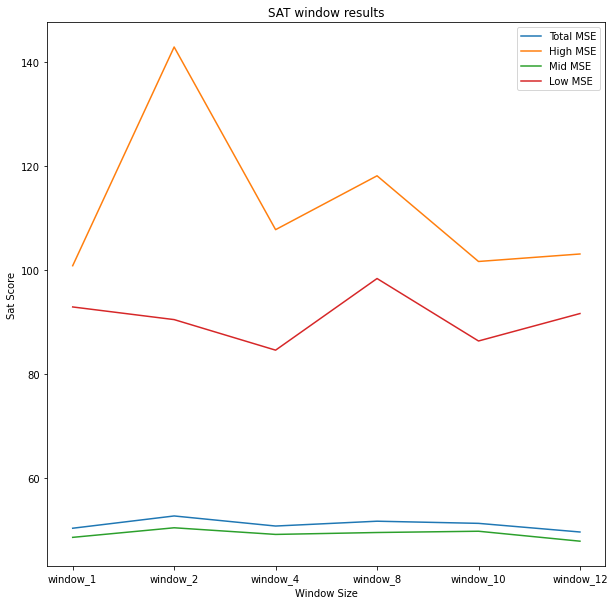

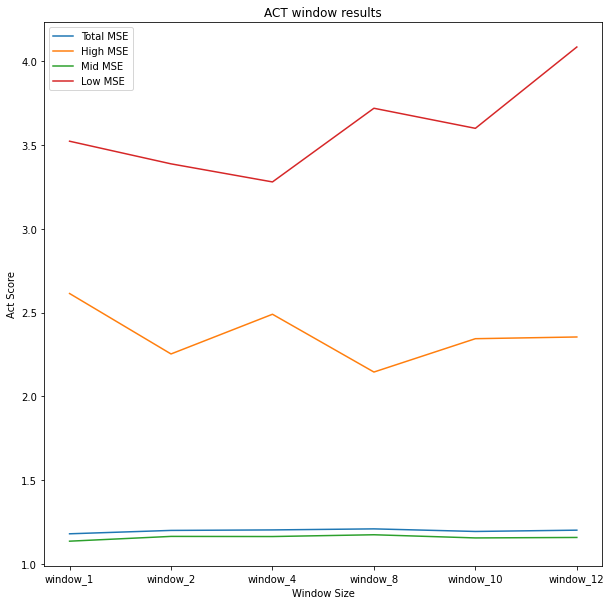

In [370]:
sat_window_results = pd.read_csv("../results/sat_window_results", index_col=0)
act_window_results = pd.read_csv("../results/act_window_results", index_col=0)

sat_window_results.plot(figsize=(10, 10),title="SAT window results", xlabel="Window Size", ylabel="Sat Score")
act_window_results.plot(figsize=(10, 10),title="ACT window results", xlabel="Window Size", ylabel="Act Score")

#### Get results for comapring budget percentages with budget per student
Commented because it takes 5+ hours to run (results can be found by reading the below csv)

In [61]:
# percent_results = run_model(4,"percent",10)
# per_student_results = run_model(4,"per_student"],10)

# labels = ['Real_Sat', 'Real_Act', 'Budget_Sat', 'Budget_Act', 'Scores_Sat', 'Scores_Act', 'Garbage_Sat', 'Garbage_Act']

# percent_averages = pd.DataFrame()
# per_student_averages = pd.DataFrame()

# for label in labels:
#     percent_label_avg = percent_results.T.filter(regex=label + '_[0-9]').T.mean().to_frame().rename(columns={0:label})
#     per_student_label_avg = per_student_results.T.filter(regex=label + '_[0-9]').T.mean().to_frame().rename(columns={0:label})
    
#     percent_averages = pd.concat([percent_label_avg, percent_averages], axis=1)
#     per_student_averages = pd.concat([per_student_label_avg, per_student_averages], axis=1)

# perc_sat = pd.DataFrame(columns=['Sat'])
# for k,v in percent_averages.filter(regex=".*_Sat").iteritems():
#     v = v.to_frame().rename(columns={k:'Sat'})
#     v.index = v.index + " " + k.replace(r'_Sat', '')
#     perc_sat = pd.concat([perc_sat, v])

# perc_act = pd.DataFrame(columns=['Act'])
# for k,v in percent_averages.filter(regex=".*_Act").iteritems():
#     v = v.to_frame().rename(columns={k:'Act'})
#     v.index = v.index + " " + k.replace(r'_Act', '')
#     perc_act = pd.concat([perc_act, v])

# per_student_sat = pd.DataFrame(columns=['Sat'])
# for k,v in per_student_averages.filter(regex=".*_Sat").iteritems():
#     v = v.to_frame().rename(columns={k:'Sat'})
#     v.index = v.index + " " + k.replace(r'_Sat', '')
#     per_student_sat = pd.concat([per_student_sat, v])
    
# per_student_act = pd.DataFrame(columns=['Act'])
# for k,v in per_student_averages.filter(regex=".*_Act").iteritems():
#     v = v.to_frame().rename(columns={k:'Act'})
#     v.index = v.index + " " + k.replace(r'_Act', '')
#     per_student_act = pd.concat([per_student_act, v])
    
# perc_sat_act = pd.concat([perc_sat, perc_act], axis=1)
# per_student_sat_act = pd.concat([per_student_sat, per_student_act], axis=1)

# perc_sat_act.index += " percent"
# per_student_sat_act.index += " per student"

# comparison_sat_act = pd.concat([perc_sat_act, per_student_sat_act])
# comparison_sat_act.to_csv("../results/percent_vs_per_student_results")

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
142/142 [==============================] - 1s 9ms/step - loss: 0.0081 - mean_absolute_error: 0.0896
Epoch 2/10
142/142 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_absolute_error: 0.0611
Epoch 3/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_absolute_error: 0.0576
Epoch 4/10
142/142 [==============================] -

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0673
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0020 - mean_absolute_error: 0.0483
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0481
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0087 - mean_absolute_error: 0.0939
Epoch 2/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0042 - mean_absolute_error: 0.0714
Epoch 3/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0710
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0696
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0689
Epoch 6/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0038 - mean_absolute_error: 0.0677
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0668
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0679
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0665
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0722
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0586
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0558
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0559
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0547
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0551
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0542
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0550
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0541
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0099 - mean_absolute_error: 0.0941
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0625
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0610
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0621
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0612
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0616
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0612
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0612
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0617
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0656
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0456
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0460
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0450
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0090 - mean_absolute_error: 0.0997
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0871
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0872
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0869
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0872
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0868
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0867
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0864
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0860
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0851
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0793
Epoch 3/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 4/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0785
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0787
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 7/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0048 - mean_absolute_error: 0.0775
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0785
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0779
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    23.3  18.016714
1    23.2  17.963299
2    18.3  18.430365
3    18.3  18.072462
4    22.3  17.985220
     actual  predicted
88     27.6  18.011902
156    26.6  18.032076
158    27.4  17.995331
325    26.8  17.918777
376    27.3  18.080751
      actual  predicted
116     14.6  18.357134
550     14.0  18.217331
942     14.0  18.241440
1116    14.5  18.191500
1253    13.9  18.245865
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0665
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0484
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0481
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0461
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0457
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0102 - mean_absolute_error: 0.1010
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0720
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0041 - mean_absolute_error: 0.0703
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0040 - mean_absolute_error: 0.0694
Epoch 5/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0690
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0038 - mean_absolute_error: 0.0684
Epoch 7/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0666
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0664
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0657
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0046 - mean_absolute_error: 0.0700
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0581
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0575
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0564
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0562
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0557
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0555
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0549
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0550
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0098 - mean_absolute_error: 0.0945
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0625
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0621
Epoch 4/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0615
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0622
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0621
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0607
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0603
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0600
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0056 - mean_absolute_error: 0.0701
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0461
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0458
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0456
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0460
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0443
Epoch 8/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0437
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0441
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0088 - mean_absolute_error: 0.0998
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0883
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0876
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0873
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0869
Epoch 6/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0063 - mean_absolute_error: 0.0877
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0868
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0870
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0867
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0066 - mean_absolute_error: 0.0870
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0788
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0779
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0777
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0772
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.7  18.351997
1    19.3  18.361090
2    20.0  18.478603
3    19.5  18.392942
4    23.4  18.415098
     actual  predicted
280    26.8  18.490206
396    25.9  18.412088
425    26.0  18.396122
542    25.7  18.510864
544    25.5  18.542614
      actual  predicted
452     14.0  18.563068
558     14.0  18.256577
689     14.8  18.218149
845     14.9  18.359480
1481    14.0  18.314299
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0696
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0021 - mean_absolute_error: 0.0492
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0459
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0450
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0433
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0084 - mean_absolute_error: 0.0944
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0711
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0705
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0699
Epoch 5/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0038 - mean_absolute_error: 0.0681
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0671
Epoch 7/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0678
Epoch 8/10
142/142 [==============================] - 2s 12ms/step - loss: 0.0037 - mean_absolute_error: 0.0673
Epoch 9/10
142/142 [==============================] - 2s 12ms/step - loss: 0.0036 - mean_absolute_error: 0.0664
Epoch 10/1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0729
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0573
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0567
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0553
Epoch 5/10
187/187 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_absolute_error: 0.0551
Epoch 6/10
187/187 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_absolute_error: 0.0553
Epoch 7/10
187/187 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_absolute_error: 0.0547
Epoch 8/10
187/187 [==============================] - 2s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.0546
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0540
Epoch 10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0107 - mean_absolute_error: 0.0990
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0624
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0614
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0605
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0616
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0600
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0607
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0596
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0601
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0051 - mean_absolute_error: 0.0678
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0450
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0442
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0442
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0436
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0086 - mean_absolute_error: 0.0982
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0874
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0869
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0875
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0870
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0868
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0864
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0866
Epoch 9/10
142/142 [==============================] - 2s 11ms/step - loss: 0.0061 - mean_absolute_error: 0.0860
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 10ms/step - loss: 0.0062 - mean_absolute_error: 0.0856
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0051 - mean_absolute_error: 0.0797
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0790
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0784
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0784
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0780
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.0  18.137436
1    21.5  18.285004
2    17.9  17.874449
3    23.7  18.631388
4    18.1  18.406113
     actual  predicted
37     27.6  18.358154
186    26.6  18.333870
427    26.3  18.468204
557    25.1  18.454355
591    26.6  18.236382
      actual  predicted
31      14.8  17.774231
320     14.8  17.904646
667     14.0  18.400957
1106    14.9  18.177387
1396    13.9  18.340403
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0703
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0488
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0464
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0462
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0444
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0435
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0436
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0100 - mean_absolute_error: 0.1004
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0719
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0711
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0693
Epoch 5/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_absolute_error: 0.0706
Epoch 6/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_absolute_error: 0.0692
Epoch 7/10
142/142 [==============================] - 2s 12ms/step - loss: 0.0038 - mean_absolute_error: 0.0682
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0678
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0666
Epoch 10/

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0720
Epoch 2/10
187/187 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_absolute_error: 0.0574
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0571
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0556
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0555
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0555
Epoch 7/10
187/187 [==============================] - 2s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.0550
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0542
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0541
Epoch 10/1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0099 - mean_absolute_error: 0.0959
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0033 - mean_absolute_error: 0.0628
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0033 - mean_absolute_error: 0.0628
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0617
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0616
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0604
Epoch 7/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0607
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0606
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0599
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0677
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0434
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0087 - mean_absolute_error: 0.0999
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0890
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0064 - mean_absolute_error: 0.0883
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0883
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0880
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0875
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0876
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0874
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0881
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0861
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0051 - mean_absolute_error: 0.0799
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0791
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0784
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0790
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.8  18.663889
1    19.6  18.450392
2    21.2  18.310602
3    18.7  18.233253
4    27.4  18.365763
     actual  predicted
4      27.4  18.365763
67     25.2  18.259151
81     25.7  18.742062
311    25.4  18.357742
351    25.8  18.450781
      actual  predicted
126     13.3  17.997280
300     12.7  18.325865
551     14.9  18.485506
856     14.8  18.127089
1258    14.0  18.140392
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0043 - mean_absolute_error: 0.0668
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0020 - mean_absolute_error: 0.0487
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0459
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0457
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0472
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0446
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0446
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0435
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 2s 11ms/step - loss: 0.0089 - mean_absolute_error: 0.0953
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0040 - mean_absolute_error: 0.0698
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0693
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0683
Epoch 5/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0038 - mean_absolute_error: 0.0681
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0669
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0682
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0658
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0671
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0720
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0578
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0571
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0560
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0559
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0553
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0551
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0551
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0542
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 10ms/step - loss: 0.0101 - mean_absolute_error: 0.0959
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0621
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0613
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0621
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0609
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0606
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0605
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0617
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0597
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0052 - mean_absolute_error: 0.0695
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0450
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0457
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0462
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0439
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0437
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0436
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 2s 13ms/step - loss: 0.0085 - mean_absolute_error: 0.0985
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0878
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0868
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0869
Epoch 5/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0867
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0875
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0862
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0862
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0864
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0056 - mean_absolute_error: 0.0825
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0785
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0777
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0774
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0780
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0772
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.7  18.676964
1    17.2  17.755766
2    20.1  18.501102
3    21.6  18.572294
4    16.2  18.267145
     actual  predicted
17     25.2  18.809332
21     25.1  18.516302
88     25.5  18.474262
223    26.5  18.338268
247    25.7  18.701319
      actual  predicted
435     13.9  18.216526
769     14.8  18.464922
948     14.8  18.239408
1156    14.8  17.983837
1248    14.0  18.458586
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0044 - mean_absolute_error: 0.0671
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0020 - mean_absolute_error: 0.0483
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0475
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0450
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0464
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0446
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0434
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0087 - mean_absolute_error: 0.0955
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0714
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0702
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0692
Epoch 5/10
142/142 [==============================] - 2s 11ms/step - loss: 0.0039 - mean_absolute_error: 0.0692
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0038 - mean_absolute_error: 0.0682
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0682
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0664
Epoch 9/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_absolute_error: 0.0661
Epoch 10/1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0727
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0570
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0560
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0557
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0552
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0555
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0547
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0546
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0539
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0101 - mean_absolute_error: 0.0959
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0637
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0622
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0620
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0620
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0622
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0612
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0609
Epoch 9/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0611
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0044 - mean_absolute_error: 0.0647
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0459
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 4/10
187/187 [==============================] - 2s 10ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0444
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0437
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0090 - mean_absolute_error: 0.1003
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0880
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0879
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0876
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0883
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0870
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0869
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0876
Epoch 9/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0883
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0061 - mean_absolute_error: 0.0855
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0787
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0786
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0789
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0778
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0788
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.7  17.910343
1    20.5  18.044922
2    17.7  18.012739
3    18.1  17.970789
4    20.1  17.685936
     actual  predicted
111    25.8  17.910852
249    25.2  18.022600
329    26.5  17.646263
379    25.1  17.929764
535    25.4  17.783907
      actual  predicted
472     14.8  17.611681
501     14.0  18.126043
614     14.6  18.299685
789     14.6  18.331497
1023    14.9  18.048494
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0662
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0492
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0472
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0459
Epoch 5/10
187/187 [==============================] - 2s 10ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0445
Epoch 7/10
187/187 [==============================] - 2s 10ms/step - loss: 0.0018 - mean_absolute_error: 0.0460
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0016 - mean_absolute_error: 0.0431
Epoch 10/1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 2s 13ms/step - loss: 0.0080 - mean_absolute_error: 0.0908
Epoch 2/10
142/142 [==============================] - 2s 11ms/step - loss: 0.0041 - mean_absolute_error: 0.0707
Epoch 3/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_absolute_error: 0.0699
Epoch 4/10
142/142 [==============================] - 2s 12ms/step - loss: 0.0039 - mean_absolute_error: 0.0695
Epoch 5/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0038 - mean_absolute_error: 0.0682
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0670
Epoch 7/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_absolute_error: 0.0681
Epoch 8/10
142/142 [==============================] - 2s 12ms/step - loss: 0.0036 - mean_absolute_error: 0.0662
Epoch 9/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0036 - mean_absolute_error: 0.0664
Epoch 

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0047 - mean_absolute_error: 0.0713
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0569
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0567
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0557
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0551
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0547
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0547
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0540
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0539
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0093 - mean_absolute_error: 0.0927
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0618
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0614
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0606
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0613
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0614
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0599
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0608
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0586
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0666
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0459
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0446
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0090 - mean_absolute_error: 0.1008
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0873
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0864
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0061 - mean_absolute_error: 0.0861
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0866
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0860
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0867
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0864
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0864
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0059 - mean_absolute_error: 0.0843
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0790
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0788
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0777
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0774
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0779
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0774
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    22.1  17.826815
1    20.4  17.667042
2    20.1  18.151394
3    15.6  17.687653
4    21.0  17.912535
     actual  predicted
72     25.4  18.056917
358    25.2  17.825163
449    25.1  17.978119
596    32.0  17.415794
826    25.3  17.975235
     actual  predicted
8      13.9  17.976746
10     14.3  18.215565
27     14.6  18.352882
110    14.9  17.630306
987    14.5  18.051464
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0041 - mean_absolute_error: 0.0650
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0475
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0475
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0460
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0448
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0444
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0445
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0444
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0083 - mean_absolute_error: 0.0931
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0715
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0704
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0689
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0688
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0689
Epoch 7/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0667
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0675
Epoch 9/10
142/142 [==============================] - 2s 11ms/step - loss: 0.0037 - mean_absolute_error: 0.0663
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0051 - mean_absolute_error: 0.0731
Epoch 2/10
187/187 [==============================] - 2s 10ms/step - loss: 0.0028 - mean_absolute_error: 0.0583
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0573
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0563
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0557
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0556
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0556
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0545
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0543
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0098 - mean_absolute_error: 0.0944
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0611
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0617
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0613
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0603
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0030 - mean_absolute_error: 0.0596
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0606
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0605
Epoch 9/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0030 - mean_absolute_error: 0.0598
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0054 - mean_absolute_error: 0.0706
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0456
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0089 - mean_absolute_error: 0.0996
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0875
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0866
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0883
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0875
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0061 - mean_absolute_error: 0.0862
Epoch 7/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0872
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0861
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0861
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0060 - mean_absolute_error: 0.0850
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0786
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0778
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0780
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0778
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0779
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0774
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    18.4  18.550575
1    18.9  18.184828
2    16.7  18.654917
3    17.6  18.227434
4    22.3  18.629112
     actual  predicted
9      27.3  18.664589
94     25.4  18.587059
112    27.2  18.782793
308    25.3  18.769453
475    25.5  18.592531
      actual  predicted
107     14.0  18.340319
608     14.9  18.561598
986     14.6  18.630451
1081    14.0  18.387369
1293    14.9  18.404190
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0674
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0482
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0459
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0472
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0446
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0446
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0446
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0084 - mean_absolute_error: 0.0935
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0709
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0687
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0686
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0683
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0670
Epoch 7/10
142/142 [==============================] - 2s 11ms/step - loss: 0.0038 - mean_absolute_error: 0.0681
Epoch 8/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_absolute_error: 0.0667
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0660
Epoch 10/1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 10ms/step - loss: 0.0056 - mean_absolute_error: 0.0759
Epoch 2/10
187/187 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_absolute_error: 0.0571
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0567
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0556
Epoch 5/10
187/187 [==============================] - 2s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.0548
Epoch 6/10
187/187 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_absolute_error: 0.0545
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0540
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0541
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0534
Epoch 10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0099 - mean_absolute_error: 0.0956
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0628
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0622
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0620
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0609
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0619
Epoch 7/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0608
Epoch 8/10
142/142 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_absolute_error: 0.0608
Epoch 9/10
142/142 [==============================] - 2s 11ms/step - loss: 0.0031 - mean_absolute_error: 0.0609
Epoch 10/1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0052 - mean_absolute_error: 0.0694
Epoch 2/10
187/187 [==============================] - 2s 10ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0456
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 5/10
187/187 [==============================] - 2s 10ms/step - loss: 0.0018 - mean_absolute_error: 0.0442
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0435
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0435
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 10/1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0091 - mean_absolute_error: 0.1014
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0877
Epoch 3/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_absolute_error: 0.0877
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0878
Epoch 5/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0872
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0875
Epoch 7/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0872
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0871
Epoch 9/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0877
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0059 - mean_absolute_error: 0.0840
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0789
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0787
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0780
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0784
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0784
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0787
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0779
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.4  18.023565
1    26.4  17.866386
2    20.1  17.853378
3    19.3  18.130730
4    18.2  18.073462
     actual  predicted
1      26.4  17.866386
129    25.5  17.857540
176    25.4  17.823641
202    25.8  17.778540
241    26.0  17.893845
      actual  predicted
909     14.8  18.300180
1003    14.0  18.365372
1045    14.9  18.509995
1061    14.8  18.300291
1098    14.0  17.889931
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0045 - mean_absolute_error: 0.0679
Epoch 2/10
187/187 [==============================] - 2s 11ms/step - loss: 0.0020 - mean_absolute_error: 0.0489
Epoch 3/10
187/187 [==============================] - 2s 11ms/step - loss: 0.0018 - mean_absolute_error: 0.0460
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0464
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0435
Epoch 10/1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0095 - mean_absolute_error: 0.0969
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0712
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0693
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0701
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0687
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0685
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0669
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0672
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0661
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0045 - mean_absolute_error: 0.0704
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0569
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0566
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0548
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0549
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0549
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0546
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0543
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0540
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0098 - mean_absolute_error: 0.0950
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0627
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0623
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0617
Epoch 5/10
142/142 [==============================] - 2s 11ms/step - loss: 0.0033 - mean_absolute_error: 0.0623
Epoch 6/10
142/142 [==============================] - 2s 12ms/step - loss: 0.0032 - mean_absolute_error: 0.0618
Epoch 7/10
142/142 [==============================] - 2s 11ms/step - loss: 0.0032 - mean_absolute_error: 0.0613
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0608
Epoch 9/10
142/142 [==============================] - 2s 11ms/step - loss: 0.0031 - mean_absolute_error: 0.0613
Epoch 10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0054 - mean_absolute_error: 0.0706
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0464
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0443
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0450
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0095 - mean_absolute_error: 0.1012
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0879
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0876
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0064 - mean_absolute_error: 0.0886
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0870
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0872
Epoch 7/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0872
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0869
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0871
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0857
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0789
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0786
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0777
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0773
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0779
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.2  18.672792
1    23.2  18.427094
2    19.8  18.510443
3    20.6  18.608101
4    18.3  18.338118
     actual  predicted
91     28.5  18.291924
212    26.6  18.308123
344    26.6  18.479750
369    25.6  18.552753
421    25.6  18.561995
      actual  predicted
118     14.8  18.365673
129     12.7  18.363640
334     14.0  18.357494
609     14.0  18.397276
1358    14.6  18.445890
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0047 - mean_absolute_error: 0.0685
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0461
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0464
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0462
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0433
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0434
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0112 - mean_absolute_error: 0.1080
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0711
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0041 - mean_absolute_error: 0.0701
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0691
Epoch 5/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0671
Epoch 6/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0672
Epoch 7/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0036 - mean_absolute_error: 0.0664
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0035 - mean_absolute_error: 0.0645
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0643
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0060 - mean_absolute_error: 0.0786
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0578
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0585
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0561
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0551
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0547
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0542
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0538
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0023 - mean_absolute_error: 0.0533
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0103 - mean_absolute_error: 0.0971
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0624
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0613
Epoch 4/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_absolute_error: 0.0621
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0614
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0611
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0608
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0611
Epoch 9/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0030 - mean_absolute_error: 0.0605
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0052 - mean_absolute_error: 0.0693
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0457
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0466
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0444
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0444
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 2s 11ms/step - loss: 0.0092 - mean_absolute_error: 0.1014
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0876
Epoch 3/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_absolute_error: 0.0871
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0877
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0876
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0867
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0874
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0869
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0869
Epoch 10/1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 10ms/step - loss: 0.0058 - mean_absolute_error: 0.0830
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0790
Epoch 3/10
187/187 [==============================] - 2s 10ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 6/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0779
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0775
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0777
Epoch 10/1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.8  17.641325
1    23.1  17.929504
2    22.5  17.486897
3    22.1  17.530169
4    21.3  17.607752
     actual  predicted
13     26.0  17.505470
59     26.8  17.491453
337    26.0  17.668936
422    26.6  19.189199
485    26.6  17.613749
      actual  predicted
886     14.0  17.855518
888     14.8  17.725435
1143    14.3  17.647587
1325    14.0  17.807554
1405    13.9  18.091812
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0713
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0459
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0437
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0430
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0109 - mean_absolute_error: 0.1061
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0715
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0690
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0681
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0681
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0663
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0664
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0662
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0657
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0066 - mean_absolute_error: 0.0823
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0583
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0569
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0560
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0558
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0546
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0547
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0542
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0539
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 2s 11ms/step - loss: 0.0098 - mean_absolute_error: 0.0952
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0622
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0621
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0611
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0618
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0606
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0618
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0600
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0613
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0686
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0458
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0450
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 6/10
187/187 [==============================] - 2s 11ms/step - loss: 0.0018 - mean_absolute_error: 0.0444
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0443
Epoch 8/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 9/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0446
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0087 - mean_absolute_error: 0.0995
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0870
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0880
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0876
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0871
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0869
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0864
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0865
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0868
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0057 - mean_absolute_error: 0.0836
Epoch 2/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0786
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0792
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0791
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0790
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0791
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0787
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    22.1  17.819666
1    17.8  17.724066
2    20.4  18.153486
3    19.3  17.698963
4    18.9  18.049393
     actual  predicted
49     25.4  17.690001
137    27.1  17.900188
283    25.6  17.646179
296    25.7  18.035679
514    27.3  17.980705
      actual  predicted
892     14.8  17.719992
977     14.5  17.760750
1332    14.8  18.076675
1354    14.6  17.652710
1414    14.0  17.862244
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0047 - mean_absolute_error: 0.0663
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0463
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0446
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0458
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0434
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 10ms/step - loss: 0.0103 - mean_absolute_error: 0.1039
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0722
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0702
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0712
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0689
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0685
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0662
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0670
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0671
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1013.0  1024.696899
1   938.0   943.779541
2   953.0   975.091736
3   940.0   920.975220
4   912.0   981.789185
     actual    predicted
55   1210.0  1101.934570
351  1212.0  1108.712402
400  1206.0  1141.169067
497  1295.0  1284.169189
575  1217.0  1112.133301
     actual   predicted
29    799.0  929.758423
65    798.0  907.277588
275   737.0  862.746399
337   797.0  900.742310
366   753.0  821.922424
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0105 - mean_absolute_error: 0.0980
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0623
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0623
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0614
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0620
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0615
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0600
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0604
Epoch 9/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0597
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0688
Epoch 2/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0446
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0436
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0437
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0087 - mean_absolute_error: 0.0983
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0869
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0873
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0873
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0867
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0884
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0871
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0869
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0868
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0843
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0776
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0774
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0774
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.9  17.188004
1    17.9  17.391926
2    18.1  17.419222
3    17.4  17.405073
4    22.3  17.188248
     actual  predicted
178    25.4  17.260511
183    26.7  17.424389
307    27.0  17.200476
547    26.0  17.306934
618    25.4  17.460770
      actual  predicted
189     14.8  17.542328
460     14.0  17.564926
726     13.9  17.553734
861     14.8  17.492039
1058    13.3  17.584234
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0691
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0463
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0446
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0446
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0450
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0108 - mean_absolute_error: 0.1040
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0708
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0704
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0694
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0676
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0689
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0665
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0656
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0648
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0805
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0589
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0566
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0561
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0548
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0542
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0549
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0550
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0023 - mean_absolute_error: 0.0533
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0101 - mean_absolute_error: 0.0967
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0625
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0627
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0622
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0611
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0611
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0615
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0621
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0605
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0055 - mean_absolute_error: 0.0697
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0465
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0444
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0090 - mean_absolute_error: 0.1000
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0885
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0877
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0872
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0876
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0874
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0867
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0870
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0873
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0858
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0788
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0786
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0784
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0780
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0779
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0779
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.9  17.241360
1    17.3  17.628498
2    16.4  17.416866
3    18.6  17.238396
4    20.2  17.432728
     actual  predicted
77     26.0  17.207104
234    26.8  17.272793
334    25.2  17.221386
385    26.6  17.257853
402    25.1  17.304602
     actual  predicted
551    14.5  17.425713
700    13.9  17.346903
709    14.8  17.733328
855    14.6  17.572561
961    14.8  17.399292
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0683
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0457
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0456
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0446
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0446
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0445
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0444
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0113 - mean_absolute_error: 0.1059
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0702
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0688
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0666
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0666
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0658
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0642
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0638
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0641
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0057 - mean_absolute_error: 0.0788
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0577
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0570
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0557
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0549
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0542
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0023 - mean_absolute_error: 0.0536
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0541
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0023 - mean_absolute_error: 0.0535
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0096 - mean_absolute_error: 0.0926
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0622
Epoch 3/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0605
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0611
Epoch 5/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0609
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0619
Epoch 7/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0602
Epoch 8/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0599
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0588
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0688
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0458
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0456
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0439
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0099 - mean_absolute_error: 0.1014
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0868
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0866
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0869
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0867
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0862
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0862
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0861
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0857
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0057 - mean_absolute_error: 0.0834
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0782
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0785
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0779
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0778
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0780
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0777
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.9  18.023846
1    19.5  17.424698
2    18.3  17.743654
3    17.3  17.624329
4    19.6  17.543156
     actual  predicted
182    27.3  17.403666
207    25.9  17.828999
280    27.4  17.396124
314    32.0  17.174673
320    27.6  17.422161
      actual  predicted
137     14.9  17.733194
632     13.3  17.292776
851     13.9  17.704723
928     14.9  18.017912
1026    14.0  17.886768
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0659
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0463
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 4/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0441
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0104 - mean_absolute_error: 0.1033
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0708
Epoch 3/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0688
Epoch 4/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_absolute_error: 0.0679
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0667
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0682
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0657
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0653
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0638
Epoch 10/10

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0817
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0584
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0568
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0555
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0553
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0546
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0546
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0537
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0536
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0101 - mean_absolute_error: 0.0963
Epoch 2/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0628
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0617
Epoch 4/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0616
Epoch 5/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0603
Epoch 6/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0610
Epoch 7/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0605
Epoch 8/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0600
Epoch 9/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0606
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0671
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0455
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0461
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 5/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 8/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0019 - mean_absolute_error: 0.0457
Epoch 9/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0087 - mean_absolute_error: 0.0986
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0891
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0876
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0875
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0867
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0865
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0875
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0866
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0866
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0859
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0789
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0791
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0789
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0786
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0785
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0791
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0785
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0779
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.0  17.529953
1    21.7  17.569279
2    21.0  17.224974
3    21.6  17.457907
4    24.2  17.457642
     actual  predicted
60     25.1  17.594233
101    25.5  17.466379
300    25.2  17.387371
401    25.6  17.614023
443    25.4  17.359734
     actual  predicted
15     14.8  17.447493
42     14.8  17.511211
277    14.8  17.499451
766    12.7  17.406115
988    13.9  17.606426
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 2s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0677
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0473
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0460
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 6/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 7/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0443
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0439
Epoch 9/10
187/187 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 9ms/step - loss: 0.0116 - mean_absolute_error: 0.1076
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0726
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0689
Epoch 4/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0693
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0679
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0664
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0683
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0672
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0643
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0811
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0589
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0568
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0561
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0546
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0546
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0541
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0534
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0544
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0092 - mean_absolute_error: 0.0916
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0617
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0614
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0613
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0610
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0608
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0605
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0600
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0601
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0053 - mean_absolute_error: 0.0697
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0471
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0459
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0461
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0449
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0442
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0443
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0095 - mean_absolute_error: 0.1009
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0890
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0878
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0890
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0873
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0870
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0870
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0875
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0871
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0060 - mean_absolute_error: 0.0847
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0785
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0779
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0787
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0778
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0773
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0776
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.9  17.384035
1    20.5  17.545391
2    20.3  17.247112
3    20.4  17.217247
4    20.1  17.203869
     actual  predicted
97     27.3  17.285358
252    25.1  17.499184
359    25.1  17.144308
416    26.6  17.250441
496    25.9  17.339270
      actual  predicted
164     13.3  17.319242
266     14.8  17.819408
1389    14.6  17.936684
1406    14.3  17.505390
1479    14.0  17.824928
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0053 - mean_absolute_error: 0.0691
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0461
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0459
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0459
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0445
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0446
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0446
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0097 - mean_absolute_error: 0.1000
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0706
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0689
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0684
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0670
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0664
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0668
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0652
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0664
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0801
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0585
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0562
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0557
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0549
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0543
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0548
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0539
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0538
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0097 - mean_absolute_error: 0.0947
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0617
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0612
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0601
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0615
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0605
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0602
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0605
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0598
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0668
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0463
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0458
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 8/10
187/187 [==============================] - 2s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0087 - mean_absolute_error: 0.0996
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0874
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0886
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0880
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0874
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0868
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0868
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0876
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0875
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0863
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0788
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0787
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0787
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0787
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0787
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0785
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0781
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    18.6  17.478323
1    19.0  17.285147
2    19.6  16.931894
3    23.2  17.155708
4    21.6  17.224993
     actual  predicted
34     25.2  17.044855
109    27.0  17.306705
330    25.4  17.386492
331    27.4  17.042170
393    25.1  17.180861
      actual  predicted
414     14.6  17.476538
516     14.6  17.457138
664     14.0  17.300617
959     12.7  17.242193
1444    14.9  17.431154
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0710
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0469
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0457
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0461
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0458
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0460
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0447
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0444
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0445
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0114 - mean_absolute_error: 0.1072
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0720
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0703
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0686
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0684
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0674
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0663
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0658
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0652
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0798
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0596
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0574
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0557
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0557
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0543
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0548
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0540
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0542
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0101 - mean_absolute_error: 0.0958
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0622
Epoch 3/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0623
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0620
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0613
Epoch 6/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0619
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0618
Epoch 8/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0607
Epoch 9/10
142/142 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0604
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0678
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0459
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0458
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0451
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0460
Epoch 7/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0453
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0444
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0098 - mean_absolute_error: 0.1034
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0877
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0879
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0872
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0880
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0884
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0875
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0871
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0874
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0856
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0786
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0779
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0786
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0785
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0777
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0774
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0783
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.0  17.360909
1    20.9  17.632021
2    19.9  17.555593
3    19.2  17.453163
4    24.6  17.333321
     actual  predicted
56     25.4  17.336163
93     25.4  17.644497
191    25.6  17.353865
193    27.4  17.328587
300    25.9  17.482975
      actual  predicted
321     13.9  17.886520
422     12.7  17.498690
618     14.3  17.546192
1105    13.9  17.630901
1430    14.5  17.480188
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0657
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0469
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0466
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0448
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0445
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0440
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0442
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0437
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0447
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0108 - mean_absolute_error: 0.1048
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0712
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0700
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0675
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0671
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0664
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0671
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0651
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0647
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0805
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0598
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0573
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0554
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0549
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0549
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0543
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0547
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0539
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0095 - mean_absolute_error: 0.0935
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0621
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0622
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0620
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0609
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0609
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0608
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0603
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0602
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0670
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0456
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0454
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0455
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0463
Epoch 6/10
187/187 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0452
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0445
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0446
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0438
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


142/142 [==============================] - 1s 8ms/step - loss: 0.0095 - mean_absolute_error: 0.1019
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0874
Epoch 3/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0898
Epoch 4/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0874
Epoch 5/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0865
Epoch 6/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0876
Epoch 7/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0864
Epoch 8/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0864
Epoch 9/10
142/142 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0862
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


187/187 [==============================] - 1s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0852
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0793
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0785
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0784
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0782
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0779
Epoch 7/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0784
Epoch 8/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0778
Epoch 9/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0774
Epoch 10/10


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Sat       Act
Total MSE Garbage percent      113.204825  2.738977
High MSE Garbage percent       338.044520  7.938308
Mid MSE Garbage percent        109.671282  2.620970
Low MSE Garbage percent        122.555010  3.936782
Total MSE Scores percent        56.621386  1.209781
High MSE Scores percent        111.795152  2.155471
Mid MSE Scores percent          54.793140  1.178362
Low MSE Scores percent         100.709494  3.469319
Total MSE Budget percent        61.221562  1.435007
High MSE Budget percent        147.540923  2.794968
Mid MSE Budget percent          58.538720  1.396707
Low MSE Budget percent         117.654814  3.760296
Total MSE Real percent          50.584824  1.232792
High MSE Real percent          106.124606  2.229788
Mid MSE Real percent            48.860855  1.201547
Low MSE Real percent            89.797479  3.438876
Total MSE Garbage per student  168.523508  3.288057
High MSE Garbage per student   409.177411  8.756086
Mid MSE Garbage per student    166.800387  3.176703
Low MSE Garbage per student     64.385062  3.429685
Total MSE Scores per student    57.567740  1.214103
High MSE Scores per student    125.019656  2.264555
Mid MSE Scores per student      55.688997  1.175389
Low MSE Scores per student      98.665708  3.668643
Total MSE Budget per student    60.882943  1.416871
High MSE Budget per student    149.864638  2.854003
Mid MSE Budget per student      58.095617  1.372362
Low MSE Budget per student     119.501384  4.021097
Total MSE Real per student      51.532460  1.217396
High MSE Real per student      106.236606  2.254878
Mid MSE Real per student        49.826346  1.178418
Low MSE Real per student        91.955920  3.737621

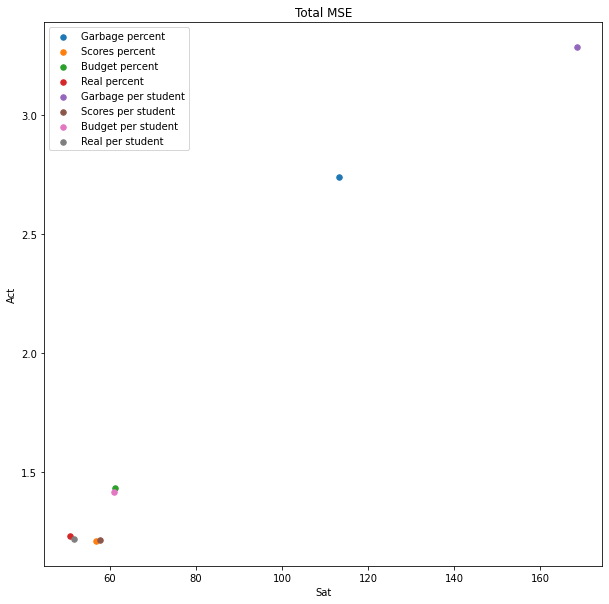

In [20]:
comparison_sat_act = pd.read_csv("../results/percent_vs_per_student_results", index_col=0)
plot_sat_act_results(comparison_sat_act, "Total MSE")
comparison_sat_act

#### Get results for indidiual features predictive ability
Commented because it takes 10+ hours to run (results can be found by reading the below csv)

In [252]:
# individual_df = run_model(4,"percent",10,["Individual"])
# individual_df.to_csv("../results/individual_features_results")

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
187/187 [==============================] - 2s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0821
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0688
Epoch 3/10
187/187 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0686
Epoch 4/10
187/187 [==============================] - 2

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.174797
1    21.1  20.193520
2    23.1  21.320047
3    21.6  19.935884
4    19.9  21.117487
     actual  predicted
26     27.1  21.379673
350    26.3  21.361746
366    25.7  21.676533
486    27.1  21.252722
575    25.4  23.021685
     actual  predicted
48     14.9  18.259457
265    14.8  19.312283
553    14.6  20.053230
796    14.3  20.778664
859    14.0  19.209681
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.983799
1    21.1  20.387604
2    23.1  20.493679
3    21.6  19.518103
4    19.9  20.753849
     actual  predicted
26     27.1  20.457594
350    26.3  20.495293
366    25.7  20.974091
486    27.1  20.700209
575    25.4  21.338055
     actual  predicted
48     14.9  18.643682
265    14.8  18.729225
553    14.6  19.664272
796    14.3  20.182091
859    14.0  18.712986
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.694359
1    21.1  19.596170
2    23.1  19.835154
3    21.6  20.315319
4    19.9  19.918705
     actual  predicted
26     27.1  20.091499
350    26.3  20.126411
366    25.7  20.755749
486    27.1  20.031080
575    25.4  20.629562
     actual  predicted
48     14.9  19.599752
265    14.8  19.622478
553    14.6  19.645870
796    14.3  19.695299
859    14.0  19.619398
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.809217
1    21.1  19.691601
2    23.1  19.935986
3    21.6  20.646921
4    19.9  20.082708
     actual  predicted
26     27.1  20.237080
350    26.3  20.316931
366    25.7  21.385622
486    27.1  20.186598
575    25.4  21.097538
     actual  predicted
48     14.9  19.703012
265    14.8  19.710197
553    14.6  19.736271
796    14.3  19.797401
859    14.0  19.705379
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.218044
1    21.1  20.198231
2    23.1  20.201130
3    21.6  20.197880
4    19.9  20.183634
     actual  predicted
26     27.1  20.248516
350    26.3  20.192587
366    25.7  20.224157
486    27.1  20.299124
575    25.4  20.337429
     actual  predicted
48     14.9  20.173672
265    14.8  20.157082
553    14.6  20.217001
796    14.3  20.071381
859    14.0  20.143955
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.892963
1    21.1  19.757278
2    23.1  19.815094
3    21.6  19.775463
4    19.9  19.739403
     actual  predicted
26     27.1  20.092047
350    26.3  19.784250
366    25.7  19.918512
486    27.1  20.603180
575    25.4  20.947847
     actual  predicted
48     14.9  19.745043
265    14.8  19.719292
553    14.6  19.894468
796    14.3  19.839323
859    14.0  19.705509
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.088223
1    21.1  20.274572
2    23.1  19.924530
3    21.6  20.157133
4    19.9  20.095278
     actual  predicted
26     27.1  20.246565
350    26.3  20.152067
366    25.7  20.113470
486    27.1  20.379473
575    25.4  20.000393
     actual  predicted
48     14.9  19.825172
265    14.8  19.996630
553    14.6  20.070473
796    14.3  19.954350
859    14.0  20.001646
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.022125
1    21.1  19.776781
2    23.1  19.817427
3    21.6  20.205898
4    19.9  20.045113
     actual  predicted
26     27.1  20.451424
350    26.3  20.197859
366    25.7  20.247305
486    27.1  20.750753
575    25.4  20.028587
     actual  predicted
48     14.9  19.637381
265    14.8  20.033829
553    14.6  19.991402
796    14.3  19.936293
859    14.0  20.043089
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.410318
1    21.1  20.475979
2    23.1  21.007542
3    21.6  19.708035
4    19.9  19.227261
     actual  predicted
26     27.1  22.024124
350    26.3  22.673223
366    25.7  22.760933
486    27.1  22.802261
575    25.4  21.750912
     actual  predicted
48     14.9  17.383924
265    14.8  18.609255
553    14.6  18.920046
796    14.3  20.135857
859    14.0  18.537321
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.261581
1    21.1  20.302782
2    23.1  20.878811
3    21.6  19.764160
4    19.9  19.061543
     actual  predicted
26     27.1  21.981491
350    26.3  23.771646
366    25.7  23.601879
486    27.1  24.227978
575    25.4  21.548510
     actual  predicted
48     14.9  18.650192
265    14.8  19.410261
553    14.6  19.497372
796    14.3  19.921478
859    14.0  19.269720
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.155422
1    21.1  19.656820
2    23.1  20.055162
3    21.6  20.028599
4    19.9  20.145540
     actual  predicted
26     27.1  20.118959
350    26.3  19.925856
366    25.7  20.178955
486    27.1  20.117493
575    25.4  20.166597
     actual  predicted
48     14.9  19.987051
265    14.8  20.119240
553    14.6  19.823792
796    14.3  20.171843
859    14.0  20.110310
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.253145
1    21.1  19.935022
2    23.1  20.186993
3    21.6  20.165754
4    19.9  20.249559
     actual  predicted
26     27.1  20.230686
350    26.3  20.110151
366    25.7  20.266523
486    27.1  20.228460
575    25.4  20.258566
     actual  predicted
48     14.9  20.170677
265    14.8  20.233198
553    14.6  20.109230
796    14.3  20.261406
859    14.0  20.229607
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.935049
1    21.1  19.926432
2    23.1  20.061695
3    21.6  19.819084
4    19.9  19.911190
     actual  predicted
26     27.1  20.004463
350    26.3  19.957369
366    25.7  19.955200
486    27.1  19.913090
575    25.4  19.922173
     actual  predicted
48     14.9  20.037737
265    14.8  19.916565
553    14.6  19.859688
796    14.3  19.976143
859    14.0  19.920218
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.856701
1    21.1  19.861305
2    23.1  19.807068
3    21.6  19.923996
4    19.9  19.872877
     actual  predicted
26     27.1  19.848021
350    26.3  19.880869
366    25.7  19.858820
486    27.1  19.877588
575    25.4  19.871983
     actual  predicted
48     14.9  19.786732
265    14.8  19.874655
553    14.6  19.904636
796    14.3  19.839722
859    14.0  19.873049
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.265289
1    21.1  20.289440
2    23.1  20.264496
3    21.6  21.224924
4    19.9  19.939970
     actual  predicted
26     27.1  19.864546
350    26.3  20.064390
366    25.7  19.958286
486    27.1  19.531693
575    25.4  19.646645
     actual  predicted
48     14.9  19.607122
265    14.8  19.703833
553    14.6  19.977440
796    14.3  20.093767
859    14.0  19.845669
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.505108
1    21.1  20.542742
2    23.1  20.411427
3    21.6  21.312279
4    19.9  20.204506
     actual  predicted
26     27.1  20.068924
350    26.3  20.272518
366    25.7  20.183537
486    27.1  19.802696
575    25.4  19.900845
     actual  predicted
48     14.9  19.886332
265    14.8  19.945425
553    14.6  20.189041
796    14.3  20.284416
859    14.0  20.061449
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.982988
1    21.1  20.058929
2    23.1  20.058929
3    21.6  20.058929
4    19.9  20.058929
     actual  predicted
26     27.1  20.057243
350    26.3  20.058929
366    25.7  20.058929
486    27.1  20.058929
575    25.4  20.058929
     actual  predicted
48     14.9  20.058929
265    14.8  20.058929
553    14.6  19.997438
796    14.3  20.058929
859    14.0  20.058929
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.143181
1    21.1  20.199919
2    23.1  20.225140
3    21.6  20.157482
4    19.9  20.224636
     actual  predicted
26     27.1  20.225140
350    26.3  20.221794
366    25.7  20.225140
486    27.1  20.225140
575    25.4  20.225140
     actual  predicted
48     14.9  20.225140
265    14.8  19.492512
553    14.6  19.560364
796    14.3  19.982851
859    14.0  19.615822
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.141764
1    21.1  20.141764
2    23.1  20.141764
3    21.6  20.141764
4    19.9  20.141764
     actual  predicted
26     27.1  20.141764
350    26.3  20.141764
366    25.7  20.141764
486    27.1  20.141764
575    25.4  20.141764
     actual  predicted
48     14.9  20.141764
265    14.8  20.141764
553    14.6  20.141764
796    14.3  20.141764
859    14.0  20.141764
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.393776
1    21.1  20.393776
2    23.1  20.393776
3    21.6  20.393776
4    19.9  20.393776
     actual  predicted
26     27.1  20.383709
350    26.3  19.815542
366    25.7  20.393776
486    27.1  20.393776
575    25.4  20.393776
     actual  predicted
48     14.9  20.393776
265    14.8  20.393776
553    14.6  19.704830
796    14.3  20.393776
859    14.0  20.393776
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8   19.98247
1    21.1   19.98247
2    23.1   19.98247
3    21.6   19.98247
4    19.9   19.98247
     actual  predicted
26     27.1   19.98247
350    26.3   19.98247
366    25.7   19.98247
486    27.1   19.98247
575    25.4   19.98247
     actual  predicted
48     14.9   19.98247
265    14.8   19.98247
553    14.6   19.98247
796    14.3   19.98247
859    14.0   19.98247
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.292614
1    21.1  20.292614
2    23.1  20.181118
3    21.6  20.292614
4    19.9  20.292614
     actual  predicted
26     27.1  20.292614
350    26.3  20.264639
366    25.7  20.292530
486    27.1  20.292614
575    25.4  20.292614
     actual  predicted
48     14.9  20.292614
265    14.8  20.283958
553    14.6  19.366478
796    14.3  20.292614
859    14.0  20.271416
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.234362
1    21.1  20.311975
2    23.1  20.335207
3    21.6  20.270227
4    19.9  20.334726
     actual  predicted
26     27.1  20.334688
350    26.3  20.332167
366    25.7  20.335207
486    27.1  20.335207
575    25.4  20.335207
     actual  predicted
48     14.9  20.335207
265    14.8  19.642895
553    14.6  19.690031
796    14.3  20.095734
859    14.0  19.755976
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.751791
1    21.1  19.809832
2    23.1  19.836294
3    21.6  19.767799
4    19.9  19.835766
     actual  predicted
26     27.1  19.836294
350    26.3  19.833391
366    25.7  19.836294
486    27.1  19.836294
575    25.4  19.836294
     actual  predicted
48     14.9  19.836294
265    14.8  19.158186
553    14.6  19.222021
796    14.3  19.597404
859    14.0  19.275080
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.074511
1    21.1  20.074511
2    23.1  20.074511
3    21.6  20.074511
4    19.9  20.074511
     actual  predicted
26     27.1  20.074511
350    26.3  20.074511
366    25.7  20.074511
486    27.1  20.074511
575    25.4  20.074511
     actual  predicted
48     14.9  20.074511
265    14.8  20.074511
553    14.6  20.074511
796    14.3  20.074511
859    14.0  20.074511
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.414911
1    21.1  20.414911
2    23.1  20.414911
3    21.6  20.414911
4    19.9  20.414911
     actual  predicted
26     27.1  20.414911
350    26.3  20.414911
366    25.7  20.414911
486    27.1  20.414911
575    25.4  20.414911
     actual  predicted
48     14.9  20.414911
265    14.8  20.414911
553    14.6  20.414911
796    14.3  20.414911
859    14.0  20.414911
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.705006
1    21.1  20.028896
2    23.1  19.466202
3    21.6  19.914083
4    19.9  20.271334
     actual  predicted
26     27.1  20.115780
350    26.3  20.032084
366    25.7  19.694405
486    27.1  20.144629
575    25.4  20.179699
     actual  predicted
48     14.9  19.596010
265    14.8  19.862408
553    14.6  19.869654
796    14.3  19.788193
859    14.0  19.712893
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.557400
1    21.1  20.095695
2    23.1  19.637751
3    21.6  19.786892
4    19.9  20.395498
     actual  predicted
26     27.1  20.394253
350    26.3  20.284698
366    25.7  20.308535
486    27.1  20.606852
575    25.4  20.077053
     actual  predicted
48     14.9  18.404003
265    14.8  19.393337
553    14.6  19.665192
796    14.3  20.181028
859    14.0  19.305088
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.875204
1    21.1  19.988224
2    23.1  19.949888
3    21.6  20.037268
4    19.9  20.088678
     actual  predicted
26     27.1  19.948654
350    26.3  19.799257
366    25.7  20.035364
486    27.1  19.976229
575    25.4  20.689676
     actual  predicted
48     14.9  19.984261
265    14.8  19.689470
553    14.6  20.078659
796    14.3  20.028753
859    14.0  19.736063
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.745115
1    21.1  19.841249
2    23.1  19.766657
3    21.6  19.925274
4    19.9  19.977417
     actual  predicted
26     27.1  19.738235
350    26.3  19.621136
366    25.7  19.843960
486    27.1  19.767132
575    25.4  20.530573
     actual  predicted
48     14.9  19.891401
265    14.8  19.486485
553    14.6  19.867807
796    14.3  19.796959
859    14.0  19.539076
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.346893
1    21.1  20.441690
2    23.1  20.050787
3    21.6  20.479788
4    19.9  20.379282
     actual  predicted
26     27.1  20.332514
350    26.3  20.378857
366    25.7  20.011023
486    27.1  20.297825
575    25.4  20.217157
     actual  predicted
48     14.9  20.045391
265    14.8  20.404737
553    14.6  20.287054
796    14.3  20.275459
859    14.0  20.353014
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.809135
1    21.1  19.773737
2    23.1  20.167204
3    21.6  19.677505
4    19.9  19.693148
     actual  predicted
26     27.1  19.900927
350    26.3  19.806976
366    25.7  20.320248
486    27.1  19.795786
575    25.4  20.035051
     actual  predicted
48     14.9  19.902645
265    14.8  19.619452
553    14.6  19.672421
796    14.3  20.001045
859    14.0  19.621227
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.529062
1    21.1  20.626123
2    23.1  20.741856
3    21.6  20.341354
4    19.9  20.124554
     actual  predicted
26     27.1  20.534479
350    26.3  20.448793
366    25.7  20.417381
486    27.1  20.232685
575    25.4  20.649883
     actual  predicted
48     14.9  19.903074
265    14.8  20.276480
553    14.6  20.237034
796    14.3  20.746458
859    14.0  20.178534
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.969751
1    21.1  20.025290
2    23.1  20.096151
3    21.6  19.958218
4    19.9  19.786007
     actual  predicted
26     27.1  19.987734
350    26.3  19.932423
366    25.7  19.927584
486    27.1  19.821075
575    25.4  20.044502
     actual  predicted
48     14.9  20.056770
265    14.8  19.975260
553    14.6  19.884722
796    14.3  20.098583
859    14.0  19.945047
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.194624
1    21.1  20.208395
2    23.1  20.202971
3    21.6  20.168951
4    19.9  20.176163
     actual  predicted
26     27.1  20.174200
350    26.3  20.155750
366    25.7  20.190453
486    27.1  20.159492
575    25.4  20.152393
     actual  predicted
48     14.9  20.137838
265    14.8  20.185259
553    14.6  20.181248
796    14.3  20.175922
859    14.0  20.190969
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.087135
1    21.1  20.207964
2    23.1  20.123178
3    21.6  20.213326
4    19.9  20.205544
     actual  predicted
26     27.1  20.280279
350    26.3  20.329359
366    25.7  20.178112
486    27.1  20.319887
575    25.4  20.355680
     actual  predicted
48     14.9  20.344650
265    14.8  20.170483
553    14.6  20.212307
796    14.3  20.209993
859    14.0  20.155554
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.570463
1    21.1  20.609266
2    23.1  20.423986
3    21.6  20.531160
4    19.9  20.573082
     actual  predicted
26     27.1  20.576235
350    26.3  20.555668
366    25.7  20.539867
486    27.1  20.600151
575    25.4  20.596388
     actual  predicted
48     14.9  20.473936
265    14.8  20.426365
553    14.6  20.572750
796    14.3  20.490505
859    14.0  20.421780
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.910547
1    21.1  19.817219
2    23.1  19.608963
3    21.6  19.856016
4    19.9  20.122421
     actual  predicted
26     27.1  20.006565
350    26.3  19.937342
366    25.7  19.967037
486    27.1  19.995571
575    25.4  20.139427
     actual  predicted
48     14.9  19.772509
265    14.8  19.543583
553    14.6  19.920853
796    14.3  19.691973
859    14.0  19.552837
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.068930
1    21.1  20.252184
2    23.1  20.276491
3    21.6  19.915873
4    19.9  19.729563
     actual  predicted
26     27.1  20.276491
350    26.3  20.276491
366    25.7  20.276491
486    27.1  19.603580
575    25.4  20.276491
     actual  predicted
48     14.9  20.276491
265    14.8  20.276491
553    14.6  18.968258
796    14.3  20.276491
859    14.0  20.276491
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.044687
1    21.1  20.267031
2    23.1  20.293785
3    21.6  20.039728
4    19.9  19.618851
     actual  predicted
26     27.1  20.293785
350    26.3  20.293785
366    25.7  20.293785
486    27.1  20.245623
575    25.4  20.293785
     actual  predicted
48     14.9  20.293785
265    14.8  20.293785
553    14.6  18.533724
796    14.3  20.293785
859    14.0  20.293785
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.907347
1    21.1  19.890833
2    23.1  19.905924
3    21.6  19.924900
4    19.9  19.918497
     actual  predicted
26     27.1  19.915939
350    26.3  19.893095
366    25.7  19.907555
486    27.1  19.898602
575    25.4  19.911142
     actual  predicted
48     14.9  19.916544
265    14.8  19.883852
553    14.6  19.952965
796    14.3  19.940426
859    14.0  19.888851
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.153414
1    21.1  20.106836
2    23.1  20.124229
3    21.6  20.128895
4    19.9  20.169613
     actual  predicted
26     27.1  20.140003
350    26.3  20.095695
366    25.7  20.125648
486    27.1  20.107721
575    25.4  20.136864
     actual  predicted
48     14.9  20.105722
265    14.8  20.002054
553    14.6  20.106091
796    14.3  20.226507
859    14.0  20.022827
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.105556
1    21.1  20.046600
2    23.1  19.935263
3    21.6  20.131866
4    19.9  20.071226
     actual  predicted
26     27.1  20.034088
350    26.3  20.102173
366    25.7  19.997154
486    27.1  20.013882
575    25.4  19.973125
     actual  predicted
48     14.9  19.933687
265    14.8  20.080299
553    14.6  19.934603
796    14.3  19.891602
859    14.0  20.067755
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.303532
1    21.1  20.287928
2    23.1  20.242840
3    21.6  20.316940
4    19.9  20.280106
     actual  predicted
26     27.1  20.271982
350    26.3  20.297949
366    25.7  20.262505
486    27.1  20.267479
575    25.4  20.255205
     actual  predicted
48     14.9  20.249205
265    14.8  20.290154
553    14.6  20.243702
796    14.3  20.229134
859    14.0  20.285164
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.611565
1    21.1  20.309319
2    23.1  20.091223
3    21.6  19.346821
4    19.9  19.906193
     actual  predicted
26     27.1  20.721758
350    26.3  20.304567
366    25.7  20.695850
486    27.1  20.508696
575    25.4  20.996223
     actual  predicted
48     14.9  19.841314
265    14.8  19.345827
553    14.6  17.986834
796    14.3  19.190454
859    14.0  19.300663
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.361292
1    21.1  20.343765
2    23.1  20.359756
3    21.6  20.361292
4    19.9  20.361292
     actual  predicted
26     27.1  19.916044
350    26.3  20.332718
366    25.7  20.361292
486    27.1  20.355116
575    25.4  20.361292
     actual  predicted
48     14.9  17.660196
265    14.8  17.835941
553    14.6  17.175987
796    14.3  20.336357
859    14.0  17.843399
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.895887
1    21.1  19.830837
2    23.1  20.112785
3    21.6  19.821434
4    19.9  19.825708
     actual  predicted
26     27.1  19.934450
350    26.3  19.857807
366    25.7  20.017714
486    27.1  19.805080
575    25.4  19.854794
     actual  predicted
48     14.9  19.967247
265    14.8  19.810738
553    14.6  19.747044
796    14.3  20.009739
859    14.0  19.817606
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.321075
1    21.1  20.324419
2    23.1  20.214006
3    21.6  20.327984
4    19.9  20.330368
     actual  predicted
26     27.1  20.326775
350    26.3  20.356056
366    25.7  20.320599
486    27.1  20.360090
575    25.4  20.331367
     actual  predicted
48     14.9  20.216604
265    14.8  20.346783
553    14.6  20.392519
796    14.3  20.252077
859    14.0  20.346043
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.830048
1    21.1  19.883894
2    23.1  19.789087
3    21.6  19.867275
4    19.9  19.958763
     actual  predicted
26     27.1  19.843599
350    26.3  19.797609
366    25.7  19.857916
486    27.1  19.879187
575    25.4  19.742630
     actual  predicted
48     14.9  19.675905
265    14.8  19.709728
553    14.6  19.953228
796    14.3  19.739067
859    14.0  19.697220
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.412365
1    21.1  20.479889
2    23.1  20.410168
3    21.6  20.471691
4    19.9  20.638458
     actual  predicted
26     27.1  20.521557
350    26.3  20.405300
366    25.7  20.520206
486    27.1  20.543880
575    25.4  20.331017
     actual  predicted
48     14.9  20.125010
265    14.8  20.280668
553    14.6  20.674824
796    14.3  20.305281
859    14.0  20.286270
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.998457
1    21.1  19.992474
2    23.1  19.971674
3    21.6  20.020983
4    19.9  20.034744
     actual  predicted
26     27.1  20.018061
350    26.3  20.004219
366    25.7  20.035473
486    27.1  20.004395
575    25.4  20.008907
     actual  predicted
48     14.9  19.991495
265    14.8  19.989685
553    14.6  20.026155
796    14.3  20.018406
859    14.0  19.989637
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.800821
1    21.1  19.731565
2    23.1  19.753893
3    21.6  19.961071
4    19.9  20.104502
     actual  predicted
26     27.1  20.082808
350    26.3  19.939272
366    25.7  20.200417
486    27.1  19.952593
575    25.4  20.003378
     actual  predicted
48     14.9  19.644650
265    14.8  19.827944
553    14.6  20.117277
796    14.3  20.041721
859    14.0  19.843067
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.333809
1    21.1  19.650461
2    23.1  19.617027
3    21.6  19.032925
4    19.9  19.601068
     actual  predicted
26     27.1  19.643772
350    26.3  19.512199
366    25.7  19.589151
486    27.1  19.513472
575    25.4  19.705194
     actual  predicted
48     14.9  19.654726
265    14.8  19.576838
553    14.6  17.524645
796    14.3  19.202847
859    14.0  19.531824
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.813906
1    21.1  20.122055
2    23.1  20.105598
3    21.6  19.493155
4    19.9  20.086288
     actual  predicted
26     27.1  20.127769
350    26.3  20.021162
366    25.7  20.087053
486    27.1  20.030224
575    25.4  20.158274
     actual  predicted
48     14.9  20.125549
265    14.8  20.075008
553    14.6  18.174667
796    14.3  19.709707
859    14.0  20.039640
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.881741
1    21.1  19.883270
2    23.1  19.867186
3    21.6  19.915409
4    19.9  19.875189
     actual  predicted
26     27.1  19.896355
350    26.3  19.898399
366    25.7  19.893354
486    27.1  19.887838
575    25.4  19.882551
     actual  predicted
48     14.9  19.867640
265    14.8  19.896311
553    14.6  19.888077
796    14.3  19.914965
859    14.0  19.895468
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.188679
1    21.1  20.177120
2    23.1  20.176451
3    21.6  20.156607
4    19.9  20.173464
     actual  predicted
26     27.1  20.165951
350    26.3  20.160831
366    25.7  20.172152
486    27.1  20.169744
575    25.4  20.176720
     actual  predicted
48     14.9  20.183672
265    14.8  20.173115
553    14.6  20.172874
796    14.3  20.161077
859    14.0  20.171682
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.138536
1    21.1  20.401297
2    23.1  20.043831
3    21.6  20.388088
4    19.9  20.239632
     actual  predicted
26     27.1  20.348207
350    26.3  20.143709
366    25.7  19.028915
486    27.1  20.344152
575    25.4  20.405996
     actual  predicted
48     14.9  19.878799
265    14.8  20.361973
553    14.6  19.758881
796    14.3  20.405996
859    14.0  20.350481
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.101038
1    21.1  20.103216
2    23.1  20.071754
3    21.6  20.101416
4    19.9  20.096979
     actual  predicted
26     27.1  20.098331
350    26.3  20.079124
366    25.7  20.094379
486    27.1  20.100136
575    25.4  20.103216
     actual  predicted
48     14.9  20.080799
265    14.8  20.103130
553    14.6  20.093899
796    14.3  20.103216
859    14.0  20.103079
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.034267
1    21.1  20.034267
2    23.1  20.034267
3    21.6  20.034267
4    19.9  20.034267
     actual  predicted
26     27.1  20.034267
350    26.3  20.034267
366    25.7  20.034267
486    27.1  20.034267
575    25.4  20.034267
     actual  predicted
48     14.9  20.034267
265    14.8  20.034267
553    14.6  20.034267
796    14.3  20.034267
859    14.0  20.034267
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  20.071552
1    21.1  20.071552
2    23.1  20.071552
3    21.6  20.071552
4    19.9  20.071552
     actual  predicted
26     27.1  20.071552
350    26.3  20.071552
366    25.7  20.071552
486    27.1  20.071552
575    25.4  20.071552
     actual  predicted
48     14.9  20.071552
265    14.8  20.071552
553    14.6  20.071552
796    14.3  20.071552
859    14.0  20.071552
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    17.8  19.862656
1    21.1  20.399723
2    23.1  21.774908
3    21.6  19.946844
4    19.9  19.489328
     actual  predicted
26     27.1  26.093126
350    26.3  24.435448
366    25.7  24.875309
486    27.1  26.310110
575    25.4  22.596447
     actual  predicted
48     14.9  16.795809
265    14.8  16.846766
553    14.6  17.090391
796    14.3  18.073360
859    14.0  16.589283
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0  1017.044495
1  1177.0  1020.438049
2   964.0  1001.086731
3  1136.0  1007.513306
4   931.0   944.969849
     actual    predicted
243  1208.0  1034.897705
309  1210.0   948.992920
417  1261.0  1004.155579
484  1205.0   938.428040
533  1203.0  1016.618103
     actual   predicted
44    799.0  954.400330
108   785.0  978.202942
117   766.0  986.614807
282   781.0  882.023132
288   793.0  954.999756
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  988.387451
1  1177.0  995.024719
2   964.0  988.516785
3  1136.0  983.395508
4   931.0  950.263916
     actual    predicted
243  1208.0  1004.610779
309  1210.0   940.894958
417  1261.0   977.092468
484  1205.0   924.725586
533  1203.0   994.500916
     actual   predicted
44    799.0  943.826111
108   785.0  962.113892
117   766.0  978.199463
282   781.0  910.828918
288   793.0  947.411804
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  961.631165
1  1177.0  967.968872
2   964.0  959.549316
3  1136.0  975.241211
4   931.0  968.144775
     actual   predicted
243  1208.0  968.052795
309  1210.0  960.660278
417  1261.0  967.720093
484  1205.0  958.972168
533  1203.0  962.846741
     actual   predicted
44    799.0  972.505981
108   785.0  963.306335
117   766.0  957.548218
282   781.0  958.199280
288   793.0  957.169250
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  974.118835
1  1177.0  979.003540
2   964.0  972.545715
3  1136.0  985.424072
4   931.0  980.240295
     actual   predicted
243  1208.0  978.864441
309  1210.0  973.393433
417  1261.0  978.606201
484  1205.0  971.898865
533  1203.0  975.125610
     actual   predicted
44    799.0  983.056396
108   785.0  975.948914
117   766.0  970.973145
282   781.0  972.239441
288   793.0  970.515991
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  988.377136
1  1177.0  978.904846
2   964.0  977.044312
3  1136.0  978.552917
4   931.0  983.378662
     actual   predicted
243  1208.0  978.335754
309  1210.0  990.502686
417  1261.0  977.463562
484  1205.0  982.799927
533  1203.0  985.343689
     actual   predicted
44    799.0  985.760437
108   785.0  983.572388
117   766.0  980.591370
282   781.0  985.696594
288   793.0  978.426697
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  975.050110
1  1177.0  970.460144
2   964.0  969.890930
3  1136.0  970.344360
4   931.0  973.007080
     actual   predicted
243  1208.0  970.302673
309  1210.0  976.222778
417  1261.0  969.807434
484  1205.0  972.185608
533  1203.0  974.068604
     actual   predicted
44    799.0  974.199463
108   785.0  973.076965
117   766.0  971.424866
282   781.0  976.448364
288   793.0  970.470825
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  975.451477
1  1177.0  985.456238
2   964.0  983.492188
3  1136.0  981.959290
4   931.0  985.113403
     actual   predicted
243  1208.0  985.127563
309  1210.0  982.176086
417  1261.0  986.157349
484  1205.0  976.537231
533  1203.0  978.945557
     actual   predicted
44    799.0  974.208740
108   785.0  986.374573
117   766.0  980.277893
282   781.0  993.886902
288   793.0  973.313171
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  953.955688
1  1177.0  966.950439
2   964.0  963.007446
3  1136.0  957.831116
4   931.0  959.484863
     actual   predicted
243  1208.0  967.044922
309  1210.0  960.908264
417  1261.0  967.116943
484  1205.0  954.084290
533  1203.0  954.917725
     actual   predicted
44    799.0  950.786499
108   785.0  969.569397
117   766.0  958.568298
282   781.0  958.871704
288   793.0  950.634216
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0  1016.703430
1  1177.0  1054.422974
2   964.0  1035.787109
3  1136.0  1079.629639
4   931.0   960.564575
     actual    predicted
243  1208.0  1074.723633
309  1210.0   967.442688
417  1261.0  1060.695190
484  1205.0   929.972473
533  1203.0  1056.031860
     actual   predicted
44    799.0  954.883789
108   785.0  995.810852
117   766.0  953.965820
282   781.0  939.360779
288   793.0  941.363464
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0   983.717163
1  1177.0  1025.696777
2   964.0   989.971619
3  1136.0  1081.788940
4   931.0   953.586182
     actual    predicted
243  1208.0  1046.989746
309  1210.0   936.105347
417  1261.0  1019.369446
484  1205.0   915.786682
533  1203.0  1037.713867
     actual   predicted
44    799.0  948.855591
108   785.0  967.755493
117   766.0  941.961609
282   781.0  922.269531
288   793.0  932.978760
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  992.155151
1  1177.0  985.701721
2   964.0  965.516357
3  1136.0  981.033508
4   931.0  990.918457
     actual   predicted
243  1208.0  984.923157
309  1210.0  990.554871
417  1261.0  993.659790
484  1205.0  993.058960
533  1203.0  991.075012
     actual   predicted
44    799.0  997.191772
108   785.0  979.927856
117   766.0  989.770386
282   781.0  987.665710
288   793.0  976.970032
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  979.850891
1  1177.0  974.744507
2   964.0  952.212219
3  1136.0  968.910339
4   931.0  977.807556
     actual   predicted
243  1208.0  973.303650
309  1210.0  977.746643
417  1261.0  981.312134
484  1205.0  980.523499
533  1203.0  978.541687
     actual   predicted
44    799.0  984.682617
108   785.0  968.862732
117   766.0  978.712646
282   781.0  971.153870
288   793.0  967.835693
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  983.293152
1  1177.0  961.594177
2   964.0  971.163757
3  1136.0  977.567505
4   931.0  977.927612
     actual    predicted
243  1208.0   972.381042
309  1210.0   976.974548
417  1261.0   986.944946
484  1205.0  1005.303833
533  1203.0   974.966675
     actual   predicted
44    799.0  986.041260
108   785.0  959.521790
117   766.0  958.980774
282   781.0  981.076111
288   793.0  976.130249
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  977.105469
1  1177.0  963.930420
2   964.0  970.222351
3  1136.0  969.198975
4   931.0  975.689270
     actual   predicted
243  1208.0  970.200012
309  1210.0  973.684021
417  1261.0  975.475586
484  1205.0  989.265625
533  1203.0  972.185913
     actual   predicted
44    799.0  978.876709
108   785.0  963.653198
117   766.0  963.608093
282   781.0  982.913879
288   793.0  973.328552
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0  1003.131348
1  1177.0   997.351257
2   964.0   985.023987
3  1136.0   988.427612
4   931.0   970.368164
     actual    predicted
243  1208.0  1012.488037
309  1210.0   982.183594
417  1261.0   995.612488
484  1205.0   990.684021
533  1203.0  1003.763550
     actual   predicted
44    799.0  984.529114
108   785.0  988.818115
117   766.0  996.198120
282   781.0  970.354675
288   793.0  983.817261
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  998.056702
1  1177.0  990.381348
2   964.0  979.249023
3  1136.0  983.913513
4   931.0  965.334961
     actual    predicted
243  1208.0  1004.489319
309  1210.0   975.490967
417  1261.0   987.758911
484  1205.0   983.763916
533  1203.0   997.644226
     actual   predicted
44    799.0  976.100281
108   785.0  984.141418
117   766.0  992.874878
282   781.0  967.894165
288   793.0  977.745422
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  983.627258
1  1177.0  982.848389
2   964.0  983.627258
3  1136.0  983.627258
4   931.0  982.429626
     actual   predicted
243  1208.0  982.762573
309  1210.0  976.224792
417  1261.0  983.552307
484  1205.0  983.560242
533  1203.0  983.627258
     actual   predicted
44    799.0  983.123535
108   785.0  983.627258
117   766.0  973.796753
282   781.0  983.627258
288   793.0  983.627258
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  952.162964
1  1177.0  967.102722
2   964.0  952.098755
3  1136.0  951.105713
4   931.0  950.912598
     actual   predicted
243  1208.0  957.886169
309  1210.0  972.250671
417  1261.0  951.072998
484  1205.0  956.300903
533  1203.0  955.620422
     actual   predicted
44    799.0  952.803284
108   785.0  956.303894
117   766.0  956.093994
282   781.0  950.966125
288   793.0  953.546326
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  970.357544
1  1177.0  970.357544
2   964.0  970.357544
3  1136.0  970.357544
4   931.0  970.357544
     actual   predicted
243  1208.0  970.357544
309  1210.0  970.357544
417  1261.0  970.357544
484  1205.0  970.357544
533  1203.0  970.357544
     actual   predicted
44    799.0  970.357544
108   785.0  970.357544
117   766.0  970.357544
282   781.0  970.357544
288   793.0  970.357544
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  968.571228
1  1177.0  969.457031
2   964.0  968.622009
3  1136.0  968.591309
4   931.0  968.571228
     actual   predicted
243  1208.0  968.606445
309  1210.0  968.571228
417  1261.0  968.728027
484  1205.0  968.571228
533  1203.0  968.571228
     actual   predicted
44    799.0  968.571228
108   785.0  969.396362
117   766.0  968.596619
282   781.0  968.571228
288   793.0  968.571228
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  969.145813
1  1177.0  969.145813
2   964.0  969.145813
3  1136.0  969.145813
4   931.0  969.145813
     actual   predicted
243  1208.0  969.145813
309  1210.0  969.145813
417  1261.0  969.145813
484  1205.0  969.145813
533  1203.0  969.145813
     actual   predicted
44    799.0  969.145813
108   785.0  969.145813
117   766.0  969.145813
282   781.0  969.145813
288   793.0  969.145813
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  974.154602
1  1177.0  982.579712
2   964.0  974.233765
3  1136.0  974.222778
4   931.0  974.154602
     actual   predicted
243  1208.0  974.154602
309  1210.0  974.154602
417  1261.0  974.154602
484  1205.0  974.154602
533  1203.0  978.298340
     actual   predicted
44    799.0  974.154602
108   785.0  974.651245
117   766.0  974.154602
282   781.0  974.154602
288   793.0  974.154602
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  982.146301
1  1177.0  998.181885
2   964.0  982.511719
3  1136.0  983.027771
4   931.0  982.387024
     actual    predicted
243  1208.0   990.635986
309  1210.0  1003.578674
417  1261.0   983.037109
484  1205.0   990.372314
533  1203.0   984.476501
     actual   predicted
44    799.0  983.159729
108   785.0  984.729919
117   766.0  984.302734
282   781.0  982.660339
288   793.0  982.393677
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0   976.892273
1  1177.0  1014.132324
2   964.0   977.617065
3  1136.0   978.722412
4   931.0   977.617310
     actual    predicted
243  1208.0   994.833008
309  1210.0  1022.051758
417  1261.0   978.765625
484  1205.0   993.951050
533  1203.0   982.254395
     actual   predicted
44    799.0  979.206177
108   785.0  983.116089
117   766.0  982.045898
282   781.0  977.645752
288   793.0  977.645325
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  994.772461
1  1177.0  994.772461
2   964.0  994.772461
3  1136.0  994.772461
4   931.0  994.772461
     actual   predicted
243  1208.0  994.772461
309  1210.0  994.772461
417  1261.0  994.772461
484  1205.0  994.772461
533  1203.0  994.772461
     actual   predicted
44    799.0  994.772461
108   785.0  994.772461
117   766.0  994.772461
282   781.0  994.772461
288   793.0  994.772461
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  985.596741
1  1177.0  985.596741
2   964.0  985.596741
3  1136.0  985.596741
4   931.0  985.596741
     actual   predicted
243  1208.0  985.596741
309  1210.0  985.596741
417  1261.0  985.596741
484  1205.0  985.596741
533  1203.0  985.596741
     actual   predicted
44    799.0  985.596741
108   785.0  985.596741
117   766.0  985.596741
282   781.0  985.596741
288   793.0  985.596741
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  982.062866
1  1177.0  991.551453
2   964.0  973.883789
3  1136.0  980.367737
4   931.0  961.106873
     actual   predicted
243  1208.0  988.266235
309  1210.0  971.488953
417  1261.0  979.574158
484  1205.0  954.184265
533  1203.0  986.226440
     actual   predicted
44    799.0  964.192871
108   785.0  983.049133
117   766.0  974.405273
282   781.0  952.208984
288   793.0  963.674377
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0  1021.516235
1  1177.0  1037.825439
2   964.0  1026.027832
3  1136.0  1014.185974
4   931.0   980.228516
     actual    predicted
243  1208.0  1039.874390
309  1210.0  1011.747437
417  1261.0  1014.270264
484  1205.0   973.157227
533  1203.0  1029.450684
     actual    predicted
44    799.0   979.071167
108   785.0  1027.069702
117   766.0  1010.607483
282   781.0   946.908875
288   793.0   973.759399
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  990.882324
1  1177.0  987.202209
2   964.0  988.592712
3  1136.0  985.099304
4   931.0  989.635803
     actual   predicted
243  1208.0  988.132141
309  1210.0  987.928955
417  1261.0  987.996948
484  1205.0  984.200134
533  1203.0  985.624573
     actual   predicted
44    799.0  981.072937
108   785.0  985.239868
117   766.0  990.597595
282   781.0  985.182251
288   793.0  990.081360
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  982.333557
1  1177.0  978.658447
2   964.0  981.059753
3  1136.0  977.120728
4   931.0  982.411987
     actual   predicted
243  1208.0  979.622131
309  1210.0  980.094910
417  1261.0  979.139221
484  1205.0  975.506409
533  1203.0  977.411804
     actual   predicted
44    799.0  972.360901
108   785.0  977.513306
117   766.0  984.173889
282   781.0  980.166077
288   793.0  974.733337
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0  1001.979980
1  1177.0   996.011841
2   964.0   990.343750
3  1136.0   994.032043
4   931.0   997.988831
     actual    predicted
243  1208.0   981.221924
309  1210.0  1003.360718
417  1261.0   992.031738
484  1205.0   986.160400
533  1203.0  1007.148621
     actual    predicted
44    799.0  1003.199707
108   785.0   986.624878
117   766.0   983.896667
282   781.0   989.276550
288   793.0   977.166382
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0   996.805298
1  1177.0   997.030762
2   964.0  1001.053040
3  1136.0   997.832520
4   931.0   996.745422
     actual    predicted
243  1208.0  1007.033691
309  1210.0   994.794617
417  1261.0  1001.504272
484  1205.0  1003.409485
533  1203.0   994.508728
     actual   predicted
44    799.0  994.846252
108   785.0  999.286926
117   766.0  997.182007
282   781.0  995.350891
288   793.0  999.997498
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  975.214966
1  1177.0  964.988953
2   964.0  969.172546
3  1136.0  978.509766
4   931.0  971.159485
     actual   predicted
243  1208.0  969.801941
309  1210.0  981.967468
417  1261.0  978.092651
484  1205.0  986.561401
533  1203.0  979.854614
     actual   predicted
44    799.0  986.561401
108   785.0  968.825439
117   766.0  960.522278
282   781.0  956.287476
288   793.0  957.540100
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  970.842224
1  1177.0  962.547119
2   964.0  966.114014
3  1136.0  974.861633
4   931.0  978.190002
     actual   predicted
243  1208.0  966.920044
309  1210.0  979.485474
417  1261.0  973.526428
484  1205.0  980.282959
533  1203.0  976.267639
     actual   predicted
44    799.0  980.282959
108   785.0  965.371155
117   766.0  962.313782
282   781.0  970.727966
288   793.0  964.751648
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  958.891785
1  1177.0  958.626038
2   964.0  958.899109
3  1136.0  955.590149
4   931.0  958.861084
     actual   predicted
243  1208.0  958.911499
309  1210.0  957.709473
417  1261.0  957.198059
484  1205.0  957.322632
533  1203.0  957.432312
     actual   predicted
44    799.0  958.369019
108   785.0  957.860962
117   766.0  957.863342
282   781.0  958.446106
288   793.0  956.669434
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  974.148499
1  1177.0  976.108032
2   964.0  974.074280
3  1136.0  986.312988
4   931.0  971.782593
     actual   predicted
243  1208.0  975.651428
309  1210.0  979.859924
417  1261.0  981.509338
484  1205.0  980.315735
533  1203.0  980.521545
     actual   predicted
44    799.0  975.305359
108   785.0  976.016357
117   766.0  975.977356
282   781.0  972.640137
288   793.0  980.754639
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  977.808167
1  1177.0  983.602417
2   964.0  981.636169
3  1136.0  981.591980
4   931.0  981.074646
     actual   predicted
243  1208.0  982.512146
309  1210.0  981.074158
417  1261.0  982.298462
484  1205.0  980.608887
533  1203.0  979.853394
     actual   predicted
44    799.0  979.898621
108   785.0  982.472656
117   766.0  980.297791
282   781.0  984.660278
288   793.0  973.478210
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  957.906250
1  1177.0  969.609741
2   964.0  962.169922
3  1136.0  963.028564
4   931.0  958.719543
     actual   predicted
243  1208.0  963.418457
309  1210.0  961.058228
417  1261.0  965.626404
484  1205.0  964.013245
533  1203.0  962.686768
     actual   predicted
44    799.0  963.041748
108   785.0  962.485718
117   766.0  962.360657
282   781.0  958.367004
288   793.0  947.738892
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  978.955017
1  1177.0  977.048218
2   964.0  886.894592
3  1136.0  978.955017
4   931.0  978.955017
     actual   predicted
243  1208.0  971.398804
309  1210.0  972.830261
417  1261.0  978.955017
484  1205.0  978.955017
533  1203.0  978.955017
     actual   predicted
44    799.0  978.955017
108   785.0  970.855225
117   766.0  929.021240
282   781.0  950.328369
288   793.0  929.303589
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  977.564880
1  1177.0  975.597839
2   964.0  975.895752
3  1136.0  977.564880
4   931.0  977.564880
     actual   predicted
243  1208.0  969.876038
309  1210.0  977.564880
417  1261.0  977.564880
484  1205.0  977.564880
533  1203.0  977.564880
     actual   predicted
44    799.0  977.564880
108   785.0  968.250549
117   766.0  917.865845
282   781.0  928.654358
288   793.0  905.646118
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  984.803040
1  1177.0  984.766968
2   964.0  985.524780
3  1136.0  985.762085
4   931.0  983.981995
     actual   predicted
243  1208.0  984.617615
309  1210.0  984.748230
417  1261.0  985.022339
484  1205.0  985.583740
533  1203.0  985.721252
     actual   predicted
44    799.0  984.713501
108   785.0  985.330322
117   766.0  984.790100
282   781.0  986.820923
288   793.0  984.788513
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  973.150330
1  1177.0  973.184021
2   964.0  973.221191
3  1136.0  973.296387
4   931.0  972.932556
     actual   predicted
243  1208.0  973.163269
309  1210.0  973.126160
417  1261.0  973.187317
484  1205.0  973.305664
533  1203.0  973.322327
     actual   predicted
44    799.0  973.117065
108   785.0  973.143555
117   766.0  973.103638
282   781.0  973.331055
288   793.0  973.020264
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  974.307007
1  1177.0  974.173828
2   964.0  973.617371
3  1136.0  972.377930
4   931.0  971.626343
     actual   predicted
243  1208.0  974.343262
309  1210.0  971.239258
417  1261.0  973.737000
484  1205.0  969.815735
533  1203.0  977.051147
     actual   predicted
44    799.0  971.867615
108   785.0  972.209900
117   766.0  972.826660
282   781.0  972.541931
288   793.0  973.836670
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  990.352722
1  1177.0  990.351868
2   964.0  989.036499
3  1136.0  985.074951
4   931.0  983.369995
     actual   predicted
243  1208.0  990.652466
309  1210.0  982.558655
417  1261.0  989.253601
484  1205.0  980.383972
533  1203.0  996.517517
     actual   predicted
44    799.0  984.463745
108   785.0  984.278320
117   766.0  985.763916
282   781.0  982.101074
288   793.0  989.584045
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0   989.531006
1  1177.0  1007.023071
2   964.0   986.328613
3  1136.0   998.962830
4   931.0   983.968567
     actual    predicted
243  1208.0   991.656616
309  1210.0   958.519836
417  1261.0  1012.405029
484  1205.0   983.525696
533  1203.0  1016.260681
     actual   predicted
44    799.0  989.740356
108   785.0  956.000977
117   766.0  945.555725
282   781.0  994.439514
288   793.0  968.627686
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  980.116394
1  1177.0  980.088745
2   964.0  979.245911
3  1136.0  978.612427
4   931.0  979.557739
     actual   predicted
243  1208.0  980.008484
309  1210.0  980.116394
417  1261.0  963.654907
484  1205.0  975.878113
533  1203.0  980.116394
     actual   predicted
44    799.0  980.116394
108   785.0  980.116394
117   766.0  977.085754
282   781.0  979.874756
288   793.0  865.173828
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  998.346497
1  1177.0  962.236694
2   964.0  973.840393
3  1136.0  980.716064
4   931.0  980.395203
     actual    predicted
243  1208.0   972.841675
309  1210.0   982.088562
417  1261.0   990.914001
484  1205.0  1008.988098
533  1203.0  1001.048706
     actual    predicted
44    799.0   988.719055
108   785.0   955.658752
117   766.0   958.526428
282   781.0  1001.143738
288   793.0   975.194275
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  999.244141
1  1177.0  985.575012
2   964.0  990.855652
3  1136.0  992.248352
4   931.0  996.912781
     actual    predicted
243  1208.0   990.417053
309  1210.0   997.735291
417  1261.0   994.463379
484  1205.0  1010.286011
533  1203.0   997.413574
     actual    predicted
44    799.0  1001.081543
108   785.0   984.430176
117   766.0   986.451660
282   781.0  1004.574402
288   793.0   994.301575
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  982.338440
1  1177.0  984.823608
2   964.0  983.717651
3  1136.0  982.588623
4   931.0  982.432739
     actual   predicted
243  1208.0  985.030701
309  1210.0  982.793335
417  1261.0  983.135925
484  1205.0  981.529846
533  1203.0  982.098816
     actual   predicted
44    799.0  981.973694
108   785.0  984.425598
117   766.0  984.002930
282   781.0  982.552124
288   793.0  982.090942
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  978.521851
1  1177.0  987.701599
2   964.0  983.591125
3  1136.0  979.124329
4   931.0  977.784546
     actual   predicted
243  1208.0  988.593750
309  1210.0  979.936279
417  1261.0  982.132385
484  1205.0  975.745911
533  1203.0  977.830933
     actual   predicted
44    799.0  977.207642
108   785.0  985.735413
117   766.0  983.574585
282   781.0  975.042236
288   793.0  977.836609
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  984.134277
1  1177.0  984.125793
2   964.0  983.357910
3  1136.0  981.845764
4   931.0  980.691528
     actual   predicted
243  1208.0  984.483032
309  1210.0  981.460754
417  1261.0  982.507019
484  1205.0  980.112549
533  1203.0  981.065613
     actual   predicted
44    799.0  978.644409
108   785.0  983.907959
117   766.0  983.291992
282   781.0  982.193542
288   793.0  982.735474
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0  1009.028931
1  1177.0  1012.013672
2   964.0  1007.132996
3  1136.0   994.883850
4   931.0   987.517883
     actual    predicted
243  1208.0  1013.123108
309  1210.0   994.452393
417  1261.0  1002.238342
484  1205.0   989.265564
533  1203.0   995.425659
     actual    predicted
44    799.0   978.401550
108   785.0  1005.546387
117   766.0  1002.020508
282   781.0   982.835205
288   793.0  1001.103882
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  981.224731
1  1177.0  975.862183
2   964.0  966.972229
3  1136.0  973.240906
4   931.0  970.770142
     actual   predicted
243  1208.0  963.176392
309  1210.0  972.705994
417  1261.0  978.369080
484  1205.0  980.486328
533  1203.0  971.581238
     actual   predicted
44    799.0  981.253174
108   785.0  936.769470
117   766.0  954.863342
282   781.0  975.957642
288   793.0  900.518311
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0  1013.117371
1  1177.0  1008.662048
2   964.0  1000.268860
3  1136.0  1005.453064
4   931.0  1002.399780
     actual    predicted
243  1208.0   996.572815
309  1210.0  1005.086609
417  1261.0  1010.931458
484  1205.0  1012.348267
533  1203.0  1003.896545
     actual    predicted
44    799.0  1013.005310
108   785.0   960.568604
117   766.0   980.476685
282   781.0  1008.211121
288   793.0   925.394226
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  989.576721
1  1177.0  990.633545
2   964.0  987.577576
3  1136.0  990.500732
4   931.0  988.491150
     actual   predicted
243  1208.0  988.778198
309  1210.0  982.508240
417  1261.0  991.781555
484  1205.0  985.256714
533  1203.0  985.456787
     actual   predicted
44    799.0  989.821533
108   785.0  989.090759
117   766.0  985.913330
282   781.0  995.158691
288   793.0  993.113525
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  966.656128
1  1177.0  967.985962
2   964.0  965.437561
3  1136.0  968.179871
4   931.0  966.080261
     actual   predicted
243  1208.0  966.181580
309  1210.0  960.647461
417  1261.0  968.720154
484  1205.0  960.863708
533  1203.0  963.405640
     actual   predicted
44    799.0  967.473999
108   785.0  965.967773
117   766.0  964.149963
282   781.0  975.602844
288   793.0  968.269714
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  993.332458
1  1177.0  962.640015
2   964.0  983.623535
3  1136.0  988.663574
4   931.0  992.791016
     actual   predicted
243  1208.0  981.484741
309  1210.0  988.826843
417  1261.0  991.453613
484  1205.0  993.332458
533  1203.0  993.332458
     actual   predicted
44    799.0  993.332458
108   785.0  984.363831
117   766.0  978.203735
282   781.0  992.062988
288   793.0  972.774170
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  972.046143
1  1177.0  964.830139
2   964.0  971.798340
3  1136.0  970.901001
4   931.0  972.043457
     actual   predicted
243  1208.0  970.648804
309  1210.0  971.370667
417  1261.0  971.619080
484  1205.0  972.046143
533  1203.0  972.046143
     actual   predicted
44    799.0  972.046143
108   785.0  970.853882
117   766.0  969.039917
282   781.0  972.007629
288   793.0  971.980835
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  965.356323
1  1177.0  965.356323
2   964.0  965.356323
3  1136.0  965.356323
4   931.0  965.356323
     actual   predicted
243  1208.0  965.356323
309  1210.0  965.356323
417  1261.0  965.356323
484  1205.0  965.356323
533  1203.0  965.356323
     actual   predicted
44    799.0  965.356323
108   785.0  965.356323
117   766.0  965.356323
282   781.0  965.356323
288   793.0  965.356323
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   993.0  986.791077
1  1177.0  986.791077
2   964.0  986.791077
3  1136.0  986.791077
4   931.0  986.791077
     actual   predicted
243  1208.0  986.791077
309  1210.0  986.791077
417  1261.0  986.791077
484  1205.0  986.791077
533  1203.0  986.791077
     actual   predicted
44    799.0  986.791077
108   785.0  986.791077
117   766.0  986.791077
282   781.0  986.791077
288   793.0  986.791077
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   993.0  1035.122559
1  1177.0  1099.811401
2   964.0   954.764587
3  1136.0  1123.012451
4   931.0   953.442139
     actual    predicted
243  1208.0  1103.071777
309  1210.0  1018.989258
417  1261.0  1172.808960
484  1205.0   986.670837
533  1203.0  1126.993164
     actual   predicted
44    799.0  954.841125
108   785.0  894.094238
117   766.0  880.585815
282   781.0  835.090454
288   793.0  901.103394
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.439894
1    19.6  19.297935
2    17.0  18.167576
3    22.3  19.216665
4    17.3  17.910225
     actual  predicted
94     25.2  20.645107
228    26.3  20.810152
230    25.1  20.718893
386    26.6  22.500814
816    26.1  20.870401
      actual  predicted
149     14.0  18.385138
248     14.5  18.486513
510     14.8  18.709406
1100    14.0  18.767057
1295    14.3  20.064299
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  21.120733
1    19.6  18.526476
2    17.0  18.576803
3    22.3  18.597868
4    17.3  18.223804
     actual  predicted
94     25.2  20.350956
228    26.3  20.714781
230    25.1  20.420168
386    26.6  21.297268
816    26.1  20.650951
      actual  predicted
149     14.0  18.276360
248     14.5  18.709549
510     14.8  18.540792
1100    14.0  18.686283
1295    14.3  19.936150
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.870108
1    19.6  19.959806
2    17.0  20.009077
3    22.3  19.783533
4    17.3  20.364456
     actual  predicted
94     25.2  20.446180
228    26.3  20.345421
230    25.1  20.584305
386    26.6  20.703827
816    26.1  20.362181
      actual  predicted
149     14.0  19.756035
248     14.5  19.881451
510     14.8  19.787731
1100    14.0  19.802074
1295    14.3  19.870987
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.888437
1    19.6  19.907234
2    17.0  19.947153
3    22.3  19.801603
4    17.3  20.175161
     actual  predicted
94     25.2  20.221996
228    26.3  20.156948
230    25.1  20.350203
386    26.6  20.405289
816    26.1  20.130919
      actual  predicted
149     14.0  19.793222
248     14.5  19.863226
510     14.8  19.810431
1100    14.0  19.819111
1295    14.3  19.856731
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.559574
1    19.6  20.482092
2    17.0  20.503489
3    22.3  20.481407
4    17.3  20.530468
     actual  predicted
94     25.2  20.556974
228    26.3  20.600569
230    25.1  20.578592
386    26.6  20.658661
816    26.1  20.616486
      actual  predicted
149     14.0  20.534319
248     14.5  20.548052
510     14.8  20.532871
1100    14.0  20.540369
1295    14.3  20.488934
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.056622
1    19.6  19.828953
2    17.0  19.878336
3    22.3  19.845890
4    17.3  20.007677
     actual  predicted
94     25.2  20.192215
228    26.3  20.489336
230    25.1  20.343224
386    26.6  20.920065
816    26.1  20.582865
      actual  predicted
149     14.0  20.060324
248     14.5  20.074919
510     14.8  20.066195
1100    14.0  20.099705
1295    14.3  19.840063
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.292131
1    19.6  19.495951
2    17.0  19.494593
3    22.3  19.431267
4    17.3  19.742708
     actual  predicted
94     25.2  19.780050
228    26.3  19.875164
230    25.1  19.719336
386    26.6  19.742329
816    26.1  19.806559
      actual  predicted
149     14.0  19.640446
248     14.5  19.849255
510     14.8  19.595400
1100    14.0  19.607494
1295    14.3  19.555038
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.551319
1    19.6  19.413195
2    17.0  19.447163
3    22.3  19.191139
4    17.3  20.013012
     actual  predicted
94     25.2  20.005951
228    26.3  20.291353
230    25.1  19.715757
386    26.6  19.976700
816    26.1  19.998556
      actual  predicted
149     14.0  19.754818
248     14.5  19.904795
510     14.8  19.702904
1100    14.0  19.721903
1295    14.3  19.601700
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  22.629774
1    19.6  19.683558
2    17.0  20.065788
3    22.3  21.108067
4    17.3  18.126671
     actual  predicted
94     25.2  21.788607
228    26.3  22.766405
230    25.1  23.878082
386    26.6  25.536276
816    26.1  23.980972
      actual  predicted
149     14.0  19.045958
248     14.5  19.645550
510     14.8  18.775572
1100    14.0  18.592949
1295    14.3  20.709656
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.895266
1    19.6  18.765196
2    17.0  18.697529
3    22.3  20.812546
4    17.3  18.680759
     actual  predicted
94     25.2  20.447149
228    26.3  22.168821
230    25.1  23.433485
386    26.6  25.044401
816    26.1  23.004568
      actual  predicted
149     14.0  19.197050
248     14.5  19.527472
510     14.8  19.545546
1100    14.0  19.448753
1295    14.3  20.048681
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.460535
1    19.6  20.442978
2    17.0  20.438951
3    22.3  20.255295
4    17.3  19.759470
     actual  predicted
94     25.2  20.213791
228    26.3  20.210194
230    25.1  20.131620
386    26.6  20.422220
816    26.1  20.432381
      actual  predicted
149     14.0  20.453602
248     14.5  20.298573
510     14.8  20.388683
1100    14.0  20.392933
1295    14.3  20.457096
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.034756
1    19.6  20.029572
2    17.0  20.026371
3    22.3  19.951265
4    17.3  19.695677
     actual  predicted
94     25.2  19.934093
228    26.3  19.937517
230    25.1  19.891371
386    26.6  20.020798
816    26.1  20.025032
      actual  predicted
149     14.0  20.034958
248     14.5  19.976192
510     14.8  20.008984
1100    14.0  20.009735
1295    14.3  20.036007
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.827570
1    19.6  19.904978
2    17.0  19.887646
3    22.3  19.912891
4    17.3  19.886189
     actual  predicted
94     25.2  19.832283
228    26.3  19.816734
230    25.1  19.885071
386    26.6  19.901913
816    26.1  19.901852
      actual  predicted
149     14.0  19.979301
248     14.5  19.890371
510     14.8  19.858444
1100    14.0  19.857470
1295    14.3  19.899485
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.467102
1    19.6  20.370590
2    17.0  20.389328
3    22.3  20.377436
4    17.3  20.389637
     actual  predicted
94     25.2  20.487577
228    26.3  20.523561
230    25.1  20.453772
386    26.6  20.396660
816    26.1  20.384573
      actual  predicted
149     14.0  20.297295
248     14.5  20.387880
510     14.8  20.445683
1100    14.0  20.445932
1295    14.3  20.376978
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.867640
1    19.6  20.130253
2    17.0  19.845566
3    22.3  20.148968
4    17.3  19.609768
     actual  predicted
94     25.2  20.116537
228    26.3  20.715837
230    25.1  20.138756
386    26.6  19.411530
816    26.1  20.189711
      actual  predicted
149     14.0  19.531429
248     14.5  19.734177
510     14.8  19.647909
1100    14.0  19.573952
1295    14.3  20.065559
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.123907
1    19.6  20.348722
2    17.0  20.039501
3    22.3  20.261570
4    17.3  19.841969
     actual  predicted
94     25.2  20.250404
228    26.3  20.759632
230    25.1  20.300140
386    26.6  19.622993
816    26.1  20.366198
      actual  predicted
149     14.0  19.710407
248     14.5  19.946962
510     14.8  19.820507
1100    14.0  19.741367
1295    14.3  20.178322
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.842953
1    19.6  19.842953
2    17.0  19.575445
3    22.3  19.842953
4    17.3  19.842953
     actual  predicted
94     25.2  19.833948
228    26.3  19.718319
230    25.1  19.842953
386    26.6  19.842953
816    26.1  19.842953
      actual  predicted
149     14.0  19.842953
248     14.5  19.795492
510     14.8  19.842953
1100    14.0  19.842953
1295    14.3  19.842953
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.591831
1    19.6  20.567022
2    17.0  20.427088
3    22.3  20.384514
4    17.3  20.595589
     actual  predicted
94     25.2  20.442595
228    26.3  20.336092
230    25.1  20.592236
386    26.6  20.595589
816    26.1  20.595589
      actual  predicted
149     14.0  20.510145
248     14.5  20.394957
510     14.8  19.890089
1100    14.0  20.002733
1295    14.3  20.366266
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7   19.82165
1    19.6   19.82165
2    17.0   19.82165
3    22.3   19.82165
4    17.3   19.82165
     actual  predicted
94     25.2  19.821650
228    26.3  19.818499
230    25.1  19.821650
386    26.6  19.821650
816    26.1  19.821650
      actual  predicted
149     14.0   19.82165
248     14.5   19.82165
510     14.8   19.82165
1100    14.0   19.82165
1295    14.3   19.82165
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.385296
1    19.6  20.392786
2    17.0  20.392786
3    22.3  20.392786
4    17.3  20.392786
     actual  predicted
94     25.2  20.392786
228    26.3  19.875704
230    25.1  20.310928
386    26.6  20.392786
816    26.1  20.392786
      actual  predicted
149     14.0  20.392786
248     14.5  20.362045
510     14.8  20.392786
1100    14.0  20.392786
1295    14.3  20.392786
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.132936
1    19.6  20.132936
2    17.0  20.132936
3    22.3  20.132936
4    17.3  20.132936
     actual  predicted
94     25.2  20.132936
228    26.3  20.060816
230    25.1  20.132936
386    26.6  20.132936
816    26.1  20.132936
      actual  predicted
149     14.0  20.132936
248     14.5  20.131105
510     14.8  20.132936
1100    14.0  20.132936
1295    14.3  20.132936
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.137438
1    19.6  20.335411
2    17.0  20.335411
3    22.3  20.335411
4    17.3  20.335411
     actual  predicted
94     25.2  20.335411
228    26.3  20.287411
230    25.1  20.332909
386    26.6  20.335411
816    26.1  20.335411
      actual  predicted
149     14.0  20.335411
248     14.5  19.926943
510     14.8  20.324209
1100    14.0  20.335411
1295    14.3  20.335411
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.836964
1    19.6  19.805578
2    17.0  19.561852
3    22.3  19.559885
4    17.3  19.840309
     actual  predicted
94     25.2  19.659857
228    26.3  19.499622
230    25.1  19.836346
386    26.6  19.840309
816    26.1  19.840309
      actual  predicted
149     14.0  19.733217
248     14.5  19.623102
510     14.8  19.030264
1100    14.0  19.148306
1295    14.3  19.564466
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.331524
1    19.6  20.303656
2    17.0  20.141459
3    22.3  20.092327
4    17.3  20.335909
     actual  predicted
94     25.2  20.156866
228    26.3  20.030087
230    25.1  20.332035
386    26.6  20.335909
816    26.1  20.335909
      actual  predicted
149     14.0  20.237268
248     14.5  20.101662
510     14.8  19.503378
1100    14.0  19.640566
1295    14.3  20.069893
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.955786
1    19.6  19.955786
2    17.0  19.955786
3    22.3  19.955786
4    17.3  19.955786
     actual  predicted
94     25.2  19.955786
228    26.3  19.955786
230    25.1  19.955786
386    26.6  19.955786
816    26.1  19.955786
      actual  predicted
149     14.0  19.955786
248     14.5  19.955786
510     14.8  19.955786
1100    14.0  19.955786
1295    14.3  19.955786
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.132196
1    19.6  20.132196
2    17.0  20.132196
3    22.3  20.132196
4    17.3  20.132196
     actual  predicted
94     25.2  20.132196
228    26.3  20.132196
230    25.1  20.132196
386    26.6  20.132196
816    26.1  20.132196
      actual  predicted
149     14.0  20.132196
248     14.5  20.132196
510     14.8  20.132196
1100    14.0  20.132196
1295    14.3  20.132196
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.599297
1    19.6  19.799879
2    17.0  19.834866
3    22.3  19.253735
4    17.3  19.862297
     actual  predicted
94     25.2  20.191517
228    26.3  20.632519
230    25.1  20.225119
386    26.6  20.543093
816    26.1  20.237165
      actual  predicted
149     14.0  19.294233
248     14.5  19.494638
510     14.8  19.956530
1100    14.0  20.092880
1295    14.3  19.889534
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  21.276110
1    19.6  19.974781
2    17.0  19.860271
3    22.3  18.959648
4    17.3  20.114277
     actual  predicted
94     25.2  20.729170
228    26.3  21.436008
230    25.1  20.635155
386    26.6  20.652124
816    26.1  20.749361
      actual  predicted
149     14.0  18.980364
248     14.5  19.147274
510     14.8  19.768398
1100    14.0  19.959307
1295    14.3  20.444031
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.675167
1    19.6  19.792715
2    17.0  19.403009
3    22.3  19.608759
4    17.3  19.771778
     actual  predicted
94     25.2  19.782772
228    26.3  19.799458
230    25.1  19.650774
386    26.6  19.792772
816    26.1  19.722296
      actual  predicted
149     14.0  20.178183
248     14.5  19.636702
510     14.8  19.546623
1100    14.0  19.513161
1295    14.3  19.822811
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.073408
1    19.6  19.877832
2    17.0  19.598598
3    22.3  19.827440
4    17.3  20.124840
     actual  predicted
94     25.2  20.094978
228    26.3  20.119406
230    25.1  19.946737
386    26.6  20.019945
816    26.1  20.013798
      actual  predicted
149     14.0  20.449667
248     14.5  19.933325
510     14.8  19.778072
1100    14.0  19.707083
1295    14.3  20.090496
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.132666
1    19.6  20.130394
2    17.0  20.079065
3    22.3  20.093983
4    17.3  19.924494
     actual  predicted
94     25.2  19.668589
228    26.3  19.976622
230    25.1  20.040226
386    26.6  19.810194
816    26.1  20.064106
      actual  predicted
149     14.0  20.114735
248     14.5  19.951199
510     14.8  20.064383
1100    14.0  20.056580
1295    14.3  19.985668
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.027340
1    19.6  20.014347
2    17.0  20.105038
3    22.3  20.039965
4    17.3  20.254959
     actual  predicted
94     25.2  20.602482
228    26.3  20.250135
230    25.1  20.124969
386    26.6  20.381958
816    26.1  20.156021
      actual  predicted
149     14.0  20.029966
248     14.5  20.008263
510     14.8  19.998030
1100    14.0  20.002333
1295    14.3  20.310322
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  18.323969
1    19.6  20.580341
2    17.0  20.653866
3    22.3  20.639105
4    17.3  20.319391
     actual  predicted
94     25.2  20.261377
228    26.3  20.409885
230    25.1  20.452524
386    26.6  20.214588
816    26.1  20.257376
      actual  predicted
149     14.0  20.656664
248     14.5  19.683561
510     14.8  20.170816
1100    14.0  20.246954
1295    14.3  20.656664
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.968010
1    19.6  19.966991
2    17.0  19.965923
3    22.3  19.968010
4    17.3  19.711893
     actual  predicted
94     25.2  19.726784
228    26.3  19.828859
230    25.1  19.853952
386    26.6  19.677422
816    26.1  19.712547
      actual  predicted
149     14.0  19.968010
248     14.5  19.375429
510     14.8  19.811281
1100    14.0  19.836061
1295    14.3  19.968010
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.352432
1    19.6  20.415161
2    17.0  20.387737
3    22.3  20.357351
4    17.3  20.392876
     actual  predicted
94     25.2  20.379824
228    26.3  20.373583
230    25.1  20.346407
386    26.6  20.364424
816    26.1  20.370304
      actual  predicted
149     14.0  20.387962
248     14.5  20.412483
510     14.8  20.393700
1100    14.0  20.388477
1295    14.3  20.380270
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.991976
1    19.6  19.857786
2    17.0  19.958952
3    22.3  20.126307
4    17.3  19.937895
     actual  predicted
94     25.2  20.023264
228    26.3  20.049526
230    25.1  20.150040
386    26.6  20.113300
816    26.1  20.058538
      actual  predicted
149     14.0  19.996403
248     14.5  19.914913
510     14.8  19.953724
1100    14.0  19.965528
1295    14.3  19.993006
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.399355
1    19.6  20.123310
2    17.0  20.205524
3    22.3  20.100491
4    17.3  20.199085
     actual  predicted
94     25.2  20.280382
228    26.3  20.306477
230    25.1  20.272781
386    26.6  20.315853
816    26.1  20.266682
      actual  predicted
149     14.0  20.187107
248     14.5  20.220573
510     14.8  20.126350
1100    14.0  20.129210
1295    14.3  20.195578
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.142614
1    19.6  19.771513
2    17.0  20.195417
3    22.3  19.809973
4    17.3  20.000620
     actual  predicted
94     25.2  20.367037
228    26.3  20.442219
230    25.1  20.251091
386    26.6  20.494720
816    26.1  20.293844
      actual  predicted
149     14.0  19.914898
248     14.5  19.959850
510     14.8  19.800293
1100    14.0  19.792170
1295    14.3  19.976757
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.986921
1    19.6  19.941607
2    17.0  19.986921
3    22.3  19.986921
4    17.3  19.986921
     actual  predicted
94     25.2  19.708633
228    26.3  19.671896
230    25.1  19.986921
386    26.6  19.986921
816    26.1  19.986921
      actual  predicted
149     14.0  19.581581
248     14.5  18.836739
510     14.8  19.986921
1100    14.0  19.986820
1295    14.3  19.986921
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.529665
1    19.6  20.478525
2    17.0  20.529665
3    22.3  20.529665
4    17.3  20.529665
     actual  predicted
94     25.2  20.223682
228    26.3  20.173401
230    25.1  20.529665
386    26.6  20.529665
816    26.1  20.529665
      actual  predicted
149     14.0  20.068563
248     14.5  18.256004
510     14.8  20.529665
1100    14.0  20.529566
1295    14.3  20.529665
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.762959
1    19.6  19.706636
2    17.0  19.799185
3    22.3  19.711489
4    17.3  19.756733
     actual  predicted
94     25.2  19.784681
228    26.3  19.802652
230    25.1  19.778158
386    26.6  19.788857
816    26.1  19.783915
      actual  predicted
149     14.0  19.798779
248     14.5  19.770742
510     14.8  19.767296
1100    14.0  19.763815
1295    14.3  19.816986
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.766205
1    19.6  19.616785
2    17.0  19.812265
3    22.3  19.627716
4    17.3  19.731344
     actual  predicted
94     25.2  19.774683
228    26.3  19.802412
230    25.1  19.768158
386    26.6  19.777220
816    26.1  19.763756
      actual  predicted
149     14.0  19.798513
248     14.5  19.755547
510     14.8  19.702333
1100    14.0  19.694017
1295    14.3  19.838354
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.583054
1    19.6  19.635033
2    17.0  19.562899
3    22.3  19.767393
4    17.3  19.625826
     actual  predicted
94     25.2  19.640106
228    26.3  19.622892
230    25.1  19.690126
386    26.6  19.463200
816    26.1  19.614367
      actual  predicted
149     14.0  19.643600
248     14.5  19.661289
510     14.8  19.675880
1100    14.0  19.668823
1295    14.3  19.514359
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.176096
1    19.6  20.177904
2    17.0  20.164053
3    22.3  20.201778
4    17.3  20.180378
     actual  predicted
94     25.2  20.178993
228    26.3  20.176386
230    25.1  20.193449
386    26.6  20.137936
816    26.1  20.174118
      actual  predicted
149     14.0  20.179541
248     14.5  20.181763
510     14.8  20.187366
1100    14.0  20.187813
1295    14.3  20.148476
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.827368
1    19.6  20.307081
2    17.0  19.852701
3    22.3  19.580448
4    17.3  20.934515
     actual  predicted
94     25.2  20.658781
228    26.3  20.496536
230    25.1  20.470791
386    26.6  21.195875
816    26.1  20.777153
      actual  predicted
149     14.0  20.307314
248     14.5  19.546434
510     14.8  19.537081
1100    14.0  19.607759
1295    14.3  19.414797
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.269812
1    19.6  20.328291
2    17.0  20.377432
3    22.3  17.804789
4    17.3  20.377432
     actual  predicted
94     25.2  20.377432
228    26.3  20.376696
230    25.1  20.341639
386    26.6  19.578144
816    26.1  20.377432
      actual  predicted
149     14.0  18.293436
248     14.5  18.201145
510     14.8  17.626043
1100    14.0  17.642071
1295    14.3  20.350708
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.578300
1    19.6  19.771471
2    17.0  19.737394
3    22.3  19.850653
4    17.3  19.763020
     actual  predicted
94     25.2  19.631504
228    26.3  19.614498
230    25.1  19.723351
386    26.6  19.709208
816    26.1  19.788090
      actual  predicted
149     14.0  19.810986
248     14.5  19.697695
510     14.8  19.660164
1100    14.0  19.656977
1295    14.3  19.866917
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.283026
1    19.6  20.132261
2    17.0  20.149658
3    22.3  20.110348
4    17.3  20.117229
     actual  predicted
94     25.2  20.285460
228    26.3  20.344112
230    25.1  20.231464
386    26.6  20.211582
816    26.1  20.207802
      actual  predicted
149     14.0  20.150080
248     14.5  20.201054
510     14.8  20.236710
1100    14.0  20.235228
1295    14.3  20.092829
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.995638
1    19.6  19.627436
2    17.0  19.752392
3    22.3  19.551332
4    17.3  19.987579
     actual  predicted
94     25.2  20.174253
228    26.3  20.142706
230    25.1  19.926422
386    26.6  19.910395
816    26.1  19.940567
      actual  predicted
149     14.0  19.696373
248     14.5  19.860529
510     14.8  19.848358
1100    14.0  19.877810
1295    14.3  19.881733
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.222416
1    19.6  19.756268
2    17.0  19.890638
3    22.3  19.716747
4    17.3  20.328539
     actual  predicted
94     25.2  20.747725
228    26.3  20.690716
230    25.1  20.261427
386    26.6  20.280149
816    26.1  20.320553
      actual  predicted
149     14.0  19.900524
248     14.5  20.115070
510     14.8  20.140862
1100    14.0  20.173866
1295    14.3  20.173882
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.806946
1    19.6  19.756239
2    17.0  19.744852
3    22.3  19.734131
4    17.3  19.772041
     actual  predicted
94     25.2  19.787329
228    26.3  19.799408
230    25.1  19.773943
386    26.6  19.781868
816    26.1  19.771629
      actual  predicted
149     14.0  19.751146
248     14.5  19.771301
510     14.8  19.756687
1100    14.0  19.759111
1295    14.3  19.784222
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.683548
1    19.6  20.385008
2    17.0  20.154840
3    22.3  20.294788
4    17.3  20.366800
     actual  predicted
94     25.2  20.726465
228    26.3  20.861624
230    25.1  20.522938
386    26.6  20.696430
816    26.1  20.557041
      actual  predicted
149     14.0  20.490973
248     14.5  20.443150
510     14.8  20.401304
1100    14.0  20.469772
1295    14.3  20.677301
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.767982
1    19.6  19.763662
2    17.0  19.741411
3    22.3  19.771406
4    17.3  19.490141
     actual  predicted
94     25.2  19.531357
228    26.3  19.522846
230    25.1  19.690773
386    26.6  19.744873
816    26.1  19.760147
      actual  predicted
149     14.0  19.750235
248     14.5  19.762365
510     14.8  19.716776
1100    14.0  19.734730
1295    14.3  19.471066
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.542336
1    19.6  20.546041
2    17.0  20.518141
3    22.3  20.553507
4    17.3  20.221941
     actual  predicted
94     25.2  20.310087
228    26.3  20.319525
230    25.1  20.469706
386    26.6  20.527496
816    26.1  20.539495
      actual  predicted
149     14.0  20.533083
248     14.5  20.540079
510     14.8  20.499619
1100    14.0  20.517582
1295    14.3  20.211134
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.198986
1    19.6  20.234928
2    17.0  20.234409
3    22.3  20.240614
4    17.3  20.203386
     actual  predicted
94     25.2  20.221684
228    26.3  20.213566
230    25.1  20.226261
386    26.6  20.216139
816    26.1  20.219828
      actual  predicted
149     14.0  20.263710
248     14.5  20.241014
510     14.8  20.231037
1100    14.0  20.230284
1295    14.3  20.241335
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.173080
1    19.6  20.232647
2    17.0  20.241224
3    22.3  20.259115
4    17.3  20.178970
     actual  predicted
94     25.2  20.212753
228    26.3  20.193579
230    25.1  20.225231
386    26.6  20.199078
816    26.1  20.200336
      actual  predicted
149     14.0  20.294479
248     14.5  20.254707
510     14.8  20.211018
1100    14.0  20.211454
1295    14.3  20.235149
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.480501
1    19.6  20.480501
2    17.0  19.818329
3    22.3  20.480335
4    17.3  18.717278
     actual  predicted
94     25.2  20.080029
228    26.3  20.261112
230    25.1  20.389137
386    26.6  20.480501
816    26.1  20.458988
      actual  predicted
149     14.0  20.471857
248     14.5  20.446777
510     14.8  20.451715
1100    14.0  20.415691
1295    14.3  20.480501
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  20.106039
1    19.6  20.106039
2    17.0  20.106039
3    22.3  20.106039
4    17.3  20.104017
     actual  predicted
94     25.2  20.102882
228    26.3  20.104292
230    25.1  20.104610
386    26.6  20.106039
816    26.1  20.105749
      actual  predicted
149     14.0  20.106007
248     14.5  20.105942
510     14.8  20.106020
1100    14.0  20.106026
1295    14.3  20.106039
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  19.904356
1    19.6  19.904356
2    17.0  19.904356
3    22.3  19.904356
4    17.3  19.904356
     actual  predicted
94     25.2  19.904356
228    26.3  19.904356
230    25.1  19.904356
386    26.6  19.904356
816    26.1  19.904356
      actual  predicted
149     14.0  19.904356
248     14.5  19.904356
510     14.8  19.904356
1100    14.0  19.904356
1295    14.3  19.904356
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7   19.77977
1    19.6   19.77977
2    17.0   19.77977
3    22.3   19.77977
4    17.3   19.77977
     actual  predicted
94     25.2   19.77977
228    26.3   19.77977
230    25.1   19.77977
386    26.6   19.77977
816    26.1   19.77977
      actual  predicted
149     14.0   19.77977
248     14.5   19.77977
510     14.8   19.77977
1100    14.0   19.77977
1295    14.3   19.77977
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    24.7  22.335064
1    19.6  18.801615
2    17.0  18.860548
3    22.3  20.891314
4    17.3  18.026684
     actual  predicted
94     25.2  23.757160
228    26.3  25.392370
230    25.1  24.417381
386    26.6  25.952868
816    26.1  24.853065
      actual  predicted
149     14.0  18.607456
248     14.5  17.655146
510     14.8  16.860941
1100    14.0  17.297201
1295    14.3  18.120865
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  939.489685
1  1031.0  998.675537
2  1017.0  923.126282
3   927.0  924.796143
4   989.0  970.775024
     actual    predicted
49   1238.0   984.760376
103  1202.0  1001.258484
313  1221.0   972.046997
402  1216.0   986.761963
522  1280.0   980.021790
     actual   predicted
114   758.0  885.455200
198   798.0  901.578186
300   784.0  879.781128
305   761.0  936.415100
345   788.0  957.086060
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  945.543762
1  1031.0  992.307861
2  1017.0  948.690125
3   927.0  929.203674
4   989.0  966.684998
     actual   predicted
49   1238.0  984.170715
103  1202.0  987.513367
313  1221.0  973.843567
402  1216.0  986.302368
522  1280.0  966.749817
     actual   predicted
114   758.0  913.394592
198   798.0  912.573608
300   784.0  911.068420
305   761.0  953.875977
345   788.0  974.891907
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0  1014.610901
1  1031.0  1010.323242
2  1017.0  1005.674316
3   927.0  1007.564819
4   989.0  1012.380981
     actual    predicted
49   1238.0  1018.140808
103  1202.0  1010.074585
313  1221.0  1015.085571
402  1216.0  1018.117188
522  1280.0  1016.985596
     actual    predicted
114   758.0  1001.683472
198   798.0  1003.003296
300   784.0  1001.961487
305   761.0  1005.153015
345   788.0  1001.545410
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  974.517273
1  1031.0  971.165527
2  1017.0  968.487427
3   927.0  969.704834
4   989.0  972.656250
     actual   predicted
49   1238.0  976.834229
103  1202.0  968.950867
313  1221.0  974.673645
402  1216.0  976.830688
522  1280.0  975.375732
     actual   predicted
114   758.0  965.367676
198   798.0  966.294983
300   784.0  965.634949
305   761.0  968.020081
345   788.0  965.191345
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  990.318115
1  1031.0  988.913879
2  1017.0  985.690186
3   927.0  987.134888
4   989.0  993.198242
     actual   predicted
49   1238.0  981.081970
103  1202.0  985.297546
313  1221.0  979.995544
402  1216.0  981.079773
522  1280.0  981.934692
     actual   predicted
114   758.0  983.047424
198   798.0  987.890564
300   784.0  982.424744
305   761.0  989.298035
345   788.0  983.735474
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  989.664185
1  1031.0  989.009644
2  1017.0  987.824341
3   927.0  988.407715
4   989.0  991.408447
     actual   predicted
49   1238.0  984.749817
103  1202.0  986.861694
313  1221.0  984.348999
402  1216.0  984.766479
522  1280.0  985.117432
     actual   predicted
114   758.0  985.998779
198   798.0  988.678833
300   784.0  985.286621
305   761.0  990.185791
345   788.0  986.605957
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  979.042297
1  1031.0  973.434570
2  1017.0  985.291260
3   927.0  982.284485
4   989.0  977.123169
     actual   predicted
49   1238.0  986.632874
103  1202.0  982.038086
313  1221.0  989.932251
402  1216.0  985.965332
522  1280.0  984.857910
     actual   predicted
114   758.0  971.766907
198   798.0  976.278503
300   784.0  971.866028
305   761.0  971.660645
345   788.0  977.415833
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  971.333191
1  1031.0  966.687012
2  1017.0  972.650940
3   927.0  978.389832
4   989.0  972.891113
     actual   predicted
49   1238.0  985.632019
103  1202.0  978.393494
313  1221.0  989.640076
402  1216.0  984.585754
522  1280.0  983.003235
     actual   predicted
114   758.0  965.655029
198   798.0  969.289551
300   784.0  966.286621
305   761.0  964.346558
345   788.0  970.161316
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   973.489258
1  1031.0  1060.790527
2  1017.0   949.053406
3   927.0   952.054321
4   989.0   999.357788
     actual    predicted
49   1238.0  1049.085938
103  1202.0  1058.283813
313  1221.0  1090.645752
402  1216.0  1045.202759
522  1280.0  1069.362915
     actual   predicted
114   758.0  873.025024
198   798.0  902.521118
300   784.0  879.006042
305   761.0  952.411072
345   788.0  943.423218
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   961.195312
1  1031.0  1053.637817
2  1017.0   947.550110
3   927.0   959.252869
4   989.0  1000.934143
     actual    predicted
49   1238.0  1039.009644
103  1202.0  1030.929077
313  1221.0  1091.260254
402  1216.0  1039.809082
522  1280.0  1044.641235
     actual   predicted
114   758.0  971.133484
198   798.0  954.828308
300   784.0  969.236572
305   761.0  969.576050
345   788.0  962.775940
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  981.810486
1  1031.0  987.893738
2  1017.0  983.310791
3   927.0  983.857178
4   989.0  985.294189
     actual   predicted
49   1238.0  978.795776
103  1202.0  971.240601
313  1221.0  985.085327
402  1216.0  979.124878
522  1280.0  985.256531
     actual   predicted
114   758.0  984.396912
198   798.0  974.036743
300   784.0  966.077454
305   761.0  981.808899
345   788.0  982.240234
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  985.371094
1  1031.0  992.411255
2  1017.0  986.385498
3   927.0  988.531250
4   989.0  989.717285
     actual   predicted
49   1238.0  983.602722
103  1202.0  974.752197
313  1221.0  989.319763
402  1216.0  983.953552
522  1280.0  989.707214
     actual   predicted
114   758.0  988.216248
198   798.0  979.823914
300   784.0  970.078979
305   761.0  985.084961
345   788.0  985.899658
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  981.913025
1  1031.0  957.119263
2  1017.0  976.324280
3   927.0  973.442993
4   989.0  984.806458
     actual   predicted
49   1238.0  956.847656
103  1202.0  962.093750
313  1221.0  967.148865
402  1216.0  956.115112
522  1280.0  983.781372
     actual   predicted
114   758.0  969.345398
198   798.0  974.771912
300   784.0  969.609863
305   761.0  985.474304
345   788.0  961.773499
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  997.196655
1  1031.0  982.134033
2  1017.0  994.846252
3   927.0  993.219482
4   989.0  998.603638
     actual   predicted
49   1238.0  980.631165
103  1202.0  982.875366
313  1221.0  988.232117
402  1216.0  980.567993
522  1280.0  993.083313
     actual    predicted
114   758.0   992.459351
198   798.0   993.887268
300   784.0   993.050964
305   761.0  1001.975952
345   788.0   985.174133
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   979.605774
1  1031.0   971.059021
2  1017.0  1004.480713
3   927.0   969.140503
4   989.0   959.643982
     actual    predicted
49   1238.0  1024.448608
103  1202.0   978.333679
313  1221.0   958.680420
402  1216.0  1020.787109
522  1280.0   989.136475
     actual   predicted
114   758.0  961.189453
198   798.0  982.932556
300   784.0  960.001709
305   761.0  965.099548
345   788.0  973.254272
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   979.023987
1  1031.0   969.690369
2  1017.0  1008.000793
3   927.0   969.685486
4   989.0   959.677490
     actual    predicted
49   1238.0  1020.729675
103  1202.0   976.510742
313  1221.0   958.932068
402  1216.0  1017.413696
522  1280.0   986.457397
     actual   predicted
114   758.0  958.467224
198   798.0  983.488953
300   784.0  958.080322
305   761.0  964.811462
345   788.0  974.377686
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  965.392212
1  1031.0  964.297241
2  1017.0  965.311768
3   927.0  965.392212
4   989.0  965.392212
     actual   predicted
49   1238.0  962.703430
103  1202.0  965.215881
313  1221.0  965.392212
402  1216.0  959.730774
522  1280.0  965.259827
     actual   predicted
114   758.0  965.392212
198   798.0  938.688538
300   784.0  965.392212
305   761.0  965.392212
345   788.0  965.392212
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   984.940796
1  1031.0   974.713196
2  1017.0  1017.983765
3   927.0   975.142761
4   989.0   974.760742
     actual    predicted
49   1238.0   998.447083
103  1202.0   977.105652
313  1221.0   974.760742
402  1216.0  1007.124329
522  1280.0   974.760742
     actual   predicted
114   758.0  974.769470
198   798.0  996.988342
300   784.0  974.760681
305   761.0  974.705078
345   788.0  974.760742
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0   959.0  987.24884
1  1031.0  987.24884
2  1017.0  987.24884
3   927.0  987.24884
4   989.0  987.24884
     actual   predicted
49   1238.0  987.195190
103  1202.0  987.248840
313  1221.0  987.248840
402  1216.0  987.154297
522  1280.0  987.248840
     actual   predicted
114   758.0  987.248840
198   798.0  982.088562
300   784.0  987.248840
305   761.0  987.248840
345   788.0  987.248840
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.a

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  978.255615
1  1031.0  978.255615
2  1017.0  979.421814
3   927.0  978.255615
4   989.0  978.255615
     actual   predicted
49   1238.0  994.655701
103  1202.0  981.093567
313  1221.0  978.255615
402  1216.0  987.320801
522  1280.0  978.530090
     actual   predicted
114   758.0  978.255615
198   798.0  979.059082
300   784.0  978.255615
305   761.0  978.255615
345   788.0  978.255615
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  997.158081
1  1031.0  997.158081
2  1017.0  997.320923
3   927.0  997.158081
4   989.0  997.158081
     actual    predicted
49   1238.0  1000.020691
103  1202.0   997.158081
313  1221.0   997.158081
402  1216.0   999.002808
522  1280.0   997.158081
     actual   predicted
114   758.0  997.158081
198   798.0  997.158081
300   784.0  997.158081
305   761.0  997.158081
345   788.0  997.158081
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   981.091919
1  1031.0   977.852051
2  1017.0  1023.214600
3   927.0   977.852051
4   989.0   977.852051
     actual   predicted
49   1238.0  979.182800
103  1202.0  984.155090
313  1221.0  977.852051
402  1216.0  978.018616
522  1280.0  977.852051
     actual   predicted
114   758.0  977.852051
198   798.0  990.339844
300   784.0  977.852051
305   761.0  977.852051
345   788.0  977.852051
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   950.654846
1  1031.0   965.932068
2  1017.0  1010.781189
3   927.0   956.083069
4   989.0   968.076477
     actual    predicted
49   1238.0  1023.388733
103  1202.0   975.177185
313  1221.0   968.076477
402  1216.0  1026.512451
522  1280.0   967.966858
     actual   predicted
114   758.0  967.938171
198   798.0  949.138855
300   784.0  968.075745
305   761.0  966.795349
345   788.0  968.076477
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   985.629883
1  1031.0   976.069641
2  1017.0  1018.096130
3   927.0   976.390686
4   989.0   976.123596
     actual    predicted
49   1238.0   998.929749
103  1202.0   978.373169
313  1221.0   976.123596
402  1216.0  1007.372620
522  1280.0   976.123596
     actual   predicted
114   758.0  976.130493
198   798.0  997.305725
300   784.0  976.123474
305   761.0  976.060486
345   788.0  976.123596
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  985.722595
1  1031.0  985.722595
2  1017.0  985.722595
3   927.0  985.722595
4   989.0  985.722595
     actual   predicted
49   1238.0  985.722595
103  1202.0  985.722595
313  1221.0  985.722595
402  1216.0  985.722595
522  1280.0  985.722595
     actual   predicted
114   758.0  985.722595
198   798.0  985.722595
300   784.0  985.722595
305   761.0  985.722595
345   788.0  985.722595
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  968.839722
1  1031.0  968.839722
2  1017.0  968.839722
3   927.0  968.839722
4   989.0  968.839722
     actual   predicted
49   1238.0  968.839722
103  1202.0  968.839722
313  1221.0  968.839722
402  1216.0  968.839722
522  1280.0  968.839722
     actual   predicted
114   758.0  968.839722
198   798.0  968.839722
300   784.0  968.839722
305   761.0  968.839722
345   788.0  968.839722
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  982.615295
1  1031.0  983.029114
2  1017.0  992.584290
3   927.0  976.641846
4   989.0  987.341125
     actual    predicted
49   1238.0  1010.702332
103  1202.0  1003.360413
313  1221.0   995.582153
402  1216.0  1011.944641
522  1280.0   995.511169
     actual   predicted
114   758.0  978.039734
198   798.0  971.078735
300   784.0  977.247253
305   761.0  984.458618
345   788.0  982.907349
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   979.098328
1  1031.0   987.438416
2  1017.0  1001.798096
3   927.0   959.003235
4   989.0   983.472961
     actual    predicted
49   1238.0  1028.270142
103  1202.0  1011.870911
313  1221.0  1001.992188
402  1216.0  1029.660767
522  1280.0   993.958313
     actual   predicted
114   758.0  918.323853
198   798.0  923.570435
300   784.0  920.961670
305   761.0  972.114746
345   788.0  986.032288
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  970.083435
1  1031.0  978.172058
2  1017.0  972.111389
3   927.0  971.983765
4   989.0  984.921631
     actual   predicted
49   1238.0  975.017883
103  1202.0  972.403625
313  1221.0  974.355591
402  1216.0  975.302368
522  1280.0  973.695557
     actual   predicted
114   758.0  966.459595
198   798.0  973.129578
300   784.0  965.081665
305   761.0  971.524475
345   788.0  971.809143
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   988.818726
1  1031.0   997.280396
2  1017.0   991.636292
3   927.0   991.470398
4   989.0  1004.953308
     actual   predicted
49   1238.0  994.050720
103  1202.0  990.602600
313  1221.0  992.579895
402  1216.0  994.423767
522  1280.0  991.534424
     actual   predicted
114   758.0  985.201965
198   798.0  991.711853
300   784.0  982.991577
305   761.0  990.955627
345   788.0  990.790833
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  985.354858
1  1031.0  970.668396
2  1017.0  960.647278
3   927.0  976.530579
4   989.0  980.744507
     actual   predicted
49   1238.0  967.992737
103  1202.0  969.245056
313  1221.0  967.186646
402  1216.0  967.607422
522  1280.0  971.796509
     actual   predicted
114   758.0  976.987915
198   798.0  969.122986
300   784.0  970.742615
305   761.0  975.512756
345   788.0  958.084534
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  974.851929
1  1031.0  983.817871
2  1017.0  988.651611
3   927.0  977.479553
4   989.0  976.253418
     actual   predicted
49   1238.0  984.148376
103  1202.0  985.529541
313  1221.0  982.659973
402  1216.0  983.771179
522  1280.0  983.376587
     actual   predicted
114   758.0  975.771118
198   798.0  982.855530
300   784.0  975.656250
305   761.0  975.710571
345   788.0  981.363831
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  979.079895
1  1031.0  988.826477
2  1017.0  974.153503
3   927.0  964.230164
4   989.0  978.953064
     actual   predicted
49   1238.0  980.039673
103  1202.0  979.438049
313  1221.0  967.941223
402  1216.0  979.770325
522  1280.0  981.801575
     actual   predicted
114   758.0  971.844055
198   798.0  954.082520
300   784.0  968.864624
305   761.0  991.711914
345   788.0  964.775818
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  988.904480
1  1031.0  993.849731
2  1017.0  994.042175
3   927.0  984.149170
4   989.0  987.290771
     actual   predicted
49   1238.0  989.104492
103  1202.0  987.945984
313  1221.0  979.638306
402  1216.0  988.954285
522  1280.0  989.247498
     actual   predicted
114   758.0  995.415466
198   798.0  982.430298
300   784.0  995.389526
305   761.0  995.734131
345   788.0  980.109070
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  988.109253
1  1031.0  988.182068
2  1017.0  987.539551
3   927.0  986.116943
4   989.0  988.895386
     actual   predicted
49   1238.0  985.581421
103  1202.0  986.702820
313  1221.0  984.101379
402  1216.0  985.428406
522  1280.0  985.615967
     actual   predicted
114   758.0  987.418152
198   798.0  987.765137
300   784.0  986.051453
305   761.0  988.505005
345   788.0  988.497253
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  956.994202
1  1031.0  958.354004
2  1017.0  957.293152
3   927.0  961.090027
4   989.0  958.376038
     actual   predicted
49   1238.0  963.412964
103  1202.0  961.871765
313  1221.0  965.780579
402  1216.0  963.637939
522  1280.0  964.552551
     actual   predicted
114   758.0  959.805664
198   798.0  959.649048
300   784.0  961.505310
305   761.0  953.906006
345   788.0  955.635986
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  960.841736
1  1031.0  956.014832
2  1017.0  965.253662
3   927.0  960.198425
4   989.0  956.279602
     actual   predicted
49   1238.0  961.073303
103  1202.0  963.997498
313  1221.0  961.112122
402  1216.0  960.925293
522  1280.0  960.524109
     actual   predicted
114   758.0  958.542786
198   798.0  958.753967
300   784.0  959.057983
305   761.0  955.010681
345   788.0  958.196533
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  971.537598
1  1031.0  964.411316
2  1017.0  971.057373
3   927.0  968.863037
4   989.0  965.008789
     actual   predicted
49   1238.0  974.499390
103  1202.0  977.866272
313  1221.0  970.808960
402  1216.0  974.212158
522  1280.0  971.570984
     actual   predicted
114   758.0  956.028137
198   798.0  970.395264
300   784.0  958.490295
305   761.0  959.148071
345   788.0  969.482056
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  994.434509
1  1031.0  994.434509
2  1017.0  994.434509
3   927.0  980.742126
4   989.0  994.434509
     actual   predicted
49   1238.0  976.862854
103  1202.0  992.902710
313  1221.0  959.989807
402  1216.0  977.888794
522  1280.0  994.434509
     actual   predicted
114   758.0  985.512268
198   798.0  984.928406
300   784.0  992.254028
305   761.0  989.029968
345   788.0  981.798645
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0  1001.138123
1  1031.0  1001.138123
2  1017.0  1001.138123
3   927.0   983.952209
4   989.0  1001.138123
     actual    predicted
49   1238.0   977.936096
103  1202.0   999.247437
313  1221.0   996.580566
402  1216.0   979.472961
522  1280.0  1001.138123
     actual    predicted
114   758.0   999.658813
198   798.0  1001.138123
300   784.0  1001.138123
305   761.0   997.328918
345   788.0   984.438171
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  990.050842
1  1031.0  988.815125
2  1017.0  990.426025
3   927.0  987.084534
4   989.0  990.079468
     actual   predicted
49   1238.0  988.859558
103  1202.0  989.548401
313  1221.0  989.656433
402  1216.0  988.880676
522  1280.0  989.165894
     actual   predicted
114   758.0  990.007202
198   798.0  989.397705
300   784.0  989.412537
305   761.0  990.926575
345   788.0  989.172974
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  969.530334
1  1031.0  968.011597
2  1017.0  969.709656
3   927.0  965.652161
4   989.0  969.711792
     actual   predicted
49   1238.0  968.096802
103  1202.0  969.007935
313  1221.0  968.969849
402  1216.0  968.131592
522  1280.0  968.535034
     actual   predicted
114   758.0  971.389587
198   798.0  968.606812
300   784.0  970.755371
305   761.0  970.981628
345   788.0  968.160156
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  968.930359
1  1031.0  973.065674
2  1017.0  971.584412
3   927.0  972.271362
4   989.0  973.721802
     actual   predicted
49   1238.0  971.692627
103  1202.0  972.533813
313  1221.0  972.120850
402  1216.0  971.800293
522  1280.0  971.423279
     actual   predicted
114   758.0  971.701965
198   798.0  971.912354
300   784.0  972.011292
305   761.0  970.357361
345   788.0  974.172180
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  981.812439
1  1031.0  989.455811
2  1017.0  985.091003
3   927.0  987.469177
4   989.0  989.785645
     actual   predicted
49   1238.0  986.885498
103  1202.0  989.312927
313  1221.0  987.368530
402  1216.0  987.126526
522  1280.0  986.778198
     actual   predicted
114   758.0  985.371887
198   798.0  986.706177
300   784.0  986.060547
305   761.0  985.072571
345   788.0  991.068298
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  955.883606
1  1031.0  968.554443
2  1017.0  952.100647
3   927.0  969.969666
4   989.0  969.694458
     actual    predicted
49   1238.0   984.374390
103  1202.0  1009.622742
313  1221.0   985.402588
402  1216.0   983.554688
522  1280.0   998.979065
     actual   predicted
114   758.0  927.720825
198   798.0  922.725037
300   784.0  926.683899
305   761.0  950.328918
345   788.0  946.971985
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0   959.0  979.30896
1  1031.0  980.13446
2  1017.0  980.13446
3   927.0  980.13446
4   989.0  980.13446
     actual   predicted
49   1238.0  980.115173
103  1202.0  979.941345
313  1221.0  979.788757
402  1216.0  980.126160
522  1280.0  959.329102
     actual   predicted
114   758.0  872.534180
198   798.0  883.750549
300   784.0  868.515076
305   761.0  979.593384
345   788.0  980.134460
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.a

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  963.523438
1  1031.0  974.378723
2  1017.0  960.303833
3   927.0  949.858215
4   989.0  968.917358
     actual   predicted
49   1238.0  940.496948
103  1202.0  943.992859
313  1221.0  946.392395
402  1216.0  938.091858
522  1280.0  964.400818
     actual   predicted
114   758.0  943.498352
198   798.0  955.985962
300   784.0  944.104248
305   761.0  971.755005
345   788.0  935.886047
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  979.205933
1  1031.0  975.126343
2  1017.0  977.553345
3   927.0  973.359741
4   989.0  981.890686
     actual   predicted
49   1238.0  961.557434
103  1202.0  965.249878
313  1221.0  969.388428
402  1216.0  961.601990
522  1280.0  973.027832
     actual   predicted
114   758.0  971.784790
198   798.0  975.125305
300   784.0  972.500244
305   761.0  982.929688
345   788.0  964.659485
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   999.736023
1  1031.0  1000.040771
2  1017.0  1000.731873
3   927.0  1000.793091
4   989.0   999.524353
     actual    predicted
49   1238.0  1001.986084
103  1202.0  1001.601318
313  1221.0  1001.192017
402  1216.0  1001.995911
522  1280.0  1000.832642
     actual    predicted
114   758.0   997.929565
198   798.0  1000.537537
300   784.0   998.526855
305   761.0   999.949463
345   788.0  1000.201721
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  981.476990
1  1031.0  982.831604
2  1017.0  984.463257
3   927.0  985.793152
4   989.0  980.375977
     actual   predicted
49   1238.0  992.641724
103  1202.0  991.018127
313  1221.0  988.377563
402  1216.0  992.723877
522  1280.0  987.631836
     actual   predicted
114   758.0  967.544312
198   798.0  984.484863
300   784.0  970.959473
305   761.0  980.826965
345   788.0  981.690186
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  974.691040
1  1031.0  975.006897
2  1017.0  978.790894
3   927.0  971.629578
4   989.0  974.944092
     actual   predicted
49   1238.0  977.343689
103  1202.0  975.931885
313  1221.0  975.227600
402  1216.0  977.279602
522  1280.0  976.226746
     actual   predicted
114   758.0  975.306641
198   798.0  974.456909
300   784.0  974.879272
305   761.0  975.079163
345   788.0  974.763977
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  967.892151
1  1031.0  967.857971
2  1017.0  982.543030
3   927.0  944.158325
4   989.0  967.564819
     actual   predicted
49   1238.0  979.574829
103  1202.0  972.757935
313  1221.0  968.088867
402  1216.0  979.207642
522  1280.0  974.996765
     actual   predicted
114   758.0  956.511475
198   798.0  960.070312
300   784.0  953.314453
305   761.0  961.393311
345   788.0  967.500549
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  979.846863
1  1031.0  979.846863
2  1017.0  977.247437
3   927.0  964.330139
4   989.0  976.290894
     actual   predicted
49   1238.0  957.496460
103  1202.0  926.073792
313  1221.0  966.110962
402  1216.0  957.325012
522  1280.0  974.559021
     actual   predicted
114   758.0  967.243896
198   798.0  978.852051
300   784.0  975.855530
305   761.0  977.864624
345   788.0  929.145325
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  988.087646
1  1031.0  988.087646
2  1017.0  985.786133
3   927.0  973.419434
4   989.0  985.450562
     actual   predicted
49   1238.0  969.123474
103  1202.0  937.860535
313  1221.0  976.428406
402  1216.0  968.906982
522  1280.0  984.246033
     actual   predicted
114   758.0  975.922607
198   798.0  987.525818
300   784.0  985.632019
305   761.0  987.801819
345   788.0  932.530884
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  974.751343
1  1031.0  984.314636
2  1017.0  976.367493
3   927.0  981.350159
4   989.0  974.751343
     actual   predicted
49   1238.0  979.957092
103  1202.0  979.913086
313  1221.0  982.757996
402  1216.0  979.959351
522  1280.0  984.818359
     actual   predicted
114   758.0  979.479248
198   798.0  981.971130
300   784.0  980.382751
305   761.0  983.130249
345   788.0  981.550110
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  969.317322
1  1031.0  976.164062
2  1017.0  970.664612
3   927.0  974.106018
4   989.0  969.317322
     actual   predicted
49   1238.0  972.913696
103  1202.0  972.925354
313  1221.0  975.285034
402  1216.0  972.896851
522  1280.0  976.207642
     actual   predicted
114   758.0  973.164795
198   798.0  974.351868
300   784.0  973.592346
305   761.0  976.029358
345   788.0  974.194397
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  992.426331
1  1031.0  992.426331
2  1017.0  990.790466
3   927.0  992.394409
4   989.0  992.426331
     actual   predicted
49   1238.0  983.680786
103  1202.0  992.256775
313  1221.0  989.777100
402  1216.0  983.217041
522  1280.0  990.949158
     actual   predicted
114   758.0  985.173706
198   798.0  977.311218
300   784.0  968.875061
305   761.0  992.426331
345   788.0  990.808533
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  975.537659
1  1031.0  975.537659
2  1017.0  975.471069
3   927.0  975.529663
4   989.0  975.537659
     actual   predicted
49   1238.0  974.567627
103  1202.0  975.508728
313  1221.0  975.230103
402  1216.0  974.634583
522  1280.0  975.221252
     actual   predicted
114   758.0  975.537659
198   798.0  975.250183
300   784.0  975.417969
305   761.0  975.537659
345   788.0  975.178650
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  961.895996
1  1031.0  961.895996
2  1017.0  961.895996
3   927.0  961.895996
4   989.0  961.895996
     actual   predicted
49   1238.0  961.895996
103  1202.0  961.895996
313  1221.0  961.895996
402  1216.0  961.895996
522  1280.0  961.895996
     actual   predicted
114   758.0  961.895996
198   798.0  961.895996
300   784.0  961.895996
305   761.0  961.895996
345   788.0  961.895996
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   959.0  953.602417
1  1031.0  953.602417
2  1017.0  953.602417
3   927.0  953.602417
4   989.0  953.602417
     actual   predicted
49   1238.0  953.602417
103  1202.0  953.602417
313  1221.0  953.602417
402  1216.0  953.602417
522  1280.0  953.602417
     actual   predicted
114   758.0  953.602417
198   798.0  953.602417
300   784.0  953.602417
305   761.0  953.602417
345   788.0  953.602417
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   959.0   943.294006
1  1031.0  1034.680786
2  1017.0  1020.572266
3   927.0   933.606689
4   989.0   989.642456
     actual    predicted
49   1238.0  1133.529541
103  1202.0  1083.663208
313  1221.0  1176.172974
402  1216.0  1119.753296
522  1280.0  1166.812134
     actual   predicted
114   758.0  817.342529
198   798.0  859.151001
300   784.0  811.344177
305   761.0  853.498108
345   788.0  841.807312
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.998617
1    20.2  20.618979
2    20.2  19.322403
3    25.3  21.483076
4    19.0  20.058273
     actual  predicted
3      25.3  21.483076
72     25.6  21.667477
112    25.7  20.953001
175    25.7  20.806950
180    25.2  20.697023
     actual  predicted
99     12.7  18.720219
342    14.9  20.105232
638    14.9  17.601973
823    14.0  18.812056
889    13.9  17.470507
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.822618
1    20.2  20.651304
2    20.2  19.419605
3    25.3  21.257460
4    19.0  20.622635
     actual  predicted
3      25.3  21.257460
72     25.6  21.636000
112    25.7  21.017824
175    25.7  20.895622
180    25.2  20.656588
     actual  predicted
99     12.7  18.871136
342    14.9  20.318264
638    14.9  18.308344
823    14.0  18.808573
889    13.9  18.123203
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.241451
1    20.2  20.109274
2    20.2  20.664320
3    25.3  20.749041
4    19.0  20.397659
     actual  predicted
3      25.3  20.749041
72     25.6  21.517559
112    25.7  20.973335
175    25.7  21.573324
180    25.2  21.292368
     actual  predicted
99     12.7  20.408854
342    14.9  20.246738
638    14.9  20.148159
823    14.0  20.219206
889    13.9  20.330177
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.920790
1    20.2  19.853048
2    20.2  20.112522
3    25.3  20.077688
4    19.0  20.022444
     actual  predicted
3      25.3  20.077688
72     25.6  20.563784
112    25.7  20.268303
175    25.7  20.581388
180    25.2  20.457422
     actual  predicted
99     12.7  20.031244
342    14.9  19.926918
638    14.9  19.889023
823    14.0  19.909197
889    13.9  20.008537
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.563135
1    20.2  20.651108
2    20.2  20.571484
3    25.3  20.651232
4    19.0  20.606403
     actual  predicted
3      25.3  20.651232
72     25.6  20.741209
112    25.7  20.763121
175    25.7  20.721209
180    25.2  20.653860
     actual  predicted
99     12.7  20.682865
342    14.9  20.652784
638    14.9  20.584185
823    14.0  20.630575
889    13.9  20.664797
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.959837
1    20.2  19.684210
2    20.2  19.973249
3    25.3  19.747644
4    19.0  19.649378
     actual  predicted
3      25.3  19.747644
72     25.6  20.796085
112    25.7  21.105614
175    25.7  20.445274
180    25.2  19.727024
     actual  predicted
99     12.7  19.850616
342    14.9  19.711422
638    14.9  19.781782
823    14.0  19.658445
889    13.9  19.682634
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.094448
1    20.2  20.236666
2    20.2  20.154869
3    25.3  20.495626
4    19.0  20.235643
     actual  predicted
3      25.3  20.495626
72     25.6  20.501398
112    25.7  20.565676
175    25.7  20.631105
180    25.2  20.542774
     actual  predicted
99     12.7  20.475601
342    14.9  20.228300
638    14.9  20.134010
823    14.0  20.333296
889    13.9  20.441864
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.779285
1    20.2  20.119442
2    20.2  19.927362
3    25.3  20.625776
4    19.0  20.179304
     actual  predicted
3      25.3  20.625776
72     25.6  20.603554
112    25.7  20.718370
175    25.7  20.912066
180    25.2  20.706188
     actual  predicted
99     12.7  20.579744
342    14.9  20.103943
638    14.9  19.949501
823    14.0  20.395292
889    13.9  20.559298
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.287474
1    20.2  19.104973
2    20.2  19.234852
3    25.3  22.468155
4    19.0  18.446705
     actual  predicted
3      25.3  22.468155
72     25.6  23.713858
112    25.7  23.339397
175    25.7  21.905537
180    25.2  21.094721
     actual  predicted
99     12.7  18.605644
342    14.9  18.533096
638    14.9  17.008902
823    14.0  18.209362
889    13.9  17.285467
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.465836
1    20.2  18.757082
2    20.2  18.673704
3    25.3  21.732454
4    19.0  18.583149
     actual  predicted
3      25.3  21.732454
72     25.6  23.748516
112    25.7  23.280752
175    25.7  21.803144
180    25.2  19.895491
     actual  predicted
99     12.7  18.525118
342    14.9  18.301434
638    14.9  18.354752
823    14.0  18.908913
889    13.9  18.146870
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.971977
1    20.2  19.925280
2    20.2  19.949812
3    25.3  19.596386
4    19.0  19.902317
     actual  predicted
3      25.3  19.596386
72     25.6  19.670088
112    25.7  19.944647
175    25.7  19.276295
180    25.2  19.780502
     actual  predicted
99     12.7  19.784273
342    14.9  19.755968
638    14.9  19.837227
823    14.0  19.913588
889    13.9  19.913559
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.858137
1    20.2  19.829046
2    20.2  19.841352
3    25.3  19.584120
4    19.0  19.803633
     actual  predicted
3      25.3  19.584120
72     25.6  19.636734
112    25.7  19.837566
175    25.7  19.342216
180    25.2  19.723545
     actual  predicted
99     12.7  19.691078
342    14.9  19.685350
638    14.9  19.768902
823    14.0  19.817377
889    13.9  19.800144
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.280005
1    20.2  20.260178
2    20.2  20.304670
3    25.3  20.227270
4    19.0  20.341648
     actual  predicted
3      25.3  20.227270
72     25.6  20.217600
112    25.7  20.315495
175    25.7  20.186298
180    25.2  20.221699
     actual  predicted
99     12.7  20.305220
342    14.9  20.400763
638    14.9  20.362034
823    14.0  20.255896
889    13.9  20.248037
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.887442
1    20.2  19.903316
2    20.2  19.867113
3    25.3  19.950737
4    19.0  19.817278
     actual  predicted
3      25.3  19.950737
72     25.6  19.944071
112    25.7  19.859180
175    25.7  19.969301
180    25.2  19.939642
     actual  predicted
99     12.7  19.837107
342    14.9  19.771751
638    14.9  19.779789
823    14.0  19.907021
889    13.9  19.893337
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.724293
1    20.2  19.619350
2    20.2  19.527010
3    25.3  19.403883
4    19.0  19.565680
     actual  predicted
3      25.3  19.403883
72     25.6  19.612860
112    25.7  19.842237
175    25.7  19.925682
180    25.2  19.849464
     actual  predicted
99     12.7  19.334152
342    14.9  19.733677
638    14.9  19.601274
823    14.0  19.408394
889    13.9  19.545376
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.741035
1    20.2  19.675619
2    20.2  19.496698
3    25.3  19.453289
4    19.0  19.659035
     actual  predicted
3      25.3  19.453289
72     25.6  19.554411
112    25.7  19.809336
175    25.7  19.877680
180    25.2  19.915291
     actual  predicted
99     12.7  19.375664
342    14.9  19.796856
638    14.9  19.688555
823    14.0  19.461651
889    13.9  19.614536
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.305609
1    20.2  20.305609
2    20.2  20.305609
3    25.3  20.303055
4    19.0  20.305609
     actual  predicted
3      25.3  20.303055
72     25.6  20.305609
112    25.7  20.305609
175    25.7  20.305609
180    25.2  20.294731
     actual  predicted
99     12.7  20.305609
342    14.9  20.139666
638    14.9  20.305609
823    14.0  20.305609
889    13.9  18.878637
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.363625
1    20.2  20.164225
2    20.2  20.363625
3    25.3  20.332972
4    19.0  20.237286
     actual  predicted
3      25.3  20.332972
72     25.6  20.363625
112    25.7  20.363625
175    25.7  20.363625
180    25.2  20.216322
     actual  predicted
99     12.7  20.248158
342    14.9  20.235582
638    14.9  20.361729
823    14.0  19.789465
889    13.9  20.358025
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.728004
1    20.2  19.728004
2    20.2  19.728004
3    25.3  19.728004
4    19.0  19.728004
     actual  predicted
3      25.3  19.728004
72     25.6  19.728004
112    25.7  19.728004
175    25.7  19.728004
180    25.2  19.728004
     actual  predicted
99     12.7  19.728004
342    14.9  19.728004
638    14.9  19.728004
823    14.0  19.728004
889    13.9  19.728004
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.983150
1    20.2  19.983150
2    20.2  19.983150
3    25.3  19.920097
4    19.0  19.983150
     actual  predicted
3      25.3  19.920097
72     25.6  19.983150
112    25.7  19.983150
175    25.7  19.983150
180    25.2  19.983150
     actual  predicted
99     12.7  19.555807
342    14.9  19.983150
638    14.9  19.983150
823    14.0  19.983150
889    13.9  19.983150
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.115252
1    20.2  20.115252
2    20.2  20.115252
3    25.3  20.115252
4    19.0  20.115252
     actual  predicted
3      25.3  20.115252
72     25.6  20.115252
112    25.7  20.115252
175    25.7  20.115252
180    25.2  20.115252
     actual  predicted
99     12.7  20.115252
342    14.9  20.115252
638    14.9  20.115252
823    14.0  20.115252
889    13.9  19.944080
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.127966
1    20.2  20.056963
2    20.2  20.127966
3    25.3  20.072973
4    19.0  20.127966
     actual  predicted
3      25.3  20.072973
72     25.6  20.127966
112    25.7  20.127966
175    25.7  20.127966
180    25.2  20.127966
     actual  predicted
99     12.7  20.096479
342    14.9  20.079836
638    14.9  20.127968
823    14.0  20.127966
889    13.9  19.970642
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.158146
1    20.2  19.891146
2    20.2  20.158146
3    25.3  20.126062
4    19.0  19.983101
     actual  predicted
3      25.3  20.126062
72     25.6  20.158146
112    25.7  20.158146
175    25.7  20.158146
180    25.2  19.983299
     actual  predicted
99     12.7  20.029327
342    14.9  19.929068
638    14.9  20.155302
823    14.0  19.481274
889    13.9  19.699848
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.418911
1    20.2  20.217545
2    20.2  20.418911
3    25.3  20.390633
4    19.0  20.287943
     actual  predicted
3      25.3  20.390633
72     25.6  20.418911
112    25.7  20.418911
175    25.7  20.418911
180    25.2  20.276628
     actual  predicted
99     12.7  20.303600
342    14.9  20.288963
638    14.9  20.416908
823    14.0  19.858986
889    13.9  20.413370
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0   20.34355
1    20.2   20.34355
2    20.2   20.34355
3    25.3   20.34355
4    19.0   20.34355
     actual  predicted
3      25.3   20.34355
72     25.6   20.34355
112    25.7   20.34355
175    25.7   20.34355
180    25.2   20.34355
     actual  predicted
99     12.7   20.34355
342    14.9   20.34355
638    14.9   20.34355
823    14.0   20.34355
889    13.9   20.34355
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0    20.4471
1    20.2    20.4471
2    20.2    20.4471
3    25.3    20.4471
4    19.0    20.4471
     actual  predicted
3      25.3    20.4471
72     25.6    20.4471
112    25.7    20.4471
175    25.7    20.4471
180    25.2    20.4471
     actual  predicted
99     12.7    20.4471
342    14.9    20.4471
638    14.9    20.4471
823    14.0    20.4471
889    13.9    20.4471
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.864408
1    20.2  20.297596
2    20.2  19.494402
3    25.3  20.333090
4    19.0  20.268110
     actual  predicted
3      25.3  20.333090
72     25.6  20.369377
112    25.7  20.057398
175    25.7  20.600586
180    25.2  20.073357
     actual  predicted
99     12.7  19.828922
342    14.9  20.368303
638    14.9  19.354147
823    14.0  19.971529
889    13.9  19.439539
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.846922
1    20.2  20.153797
2    20.2  18.964964
3    25.3  20.438181
4    19.0  20.389080
     actual  predicted
3      25.3  20.438181
72     25.6  20.554642
112    25.7  20.056190
175    25.7  20.728285
180    25.2  20.087017
     actual  predicted
99     12.7  19.211996
342    14.9  20.337572
638    14.9  18.137108
823    14.0  19.285885
889    13.9  18.477112
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.838097
1    20.2  19.660934
2    20.2  19.762384
3    25.3  19.724703
4    19.0  19.674688
     actual  predicted
3      25.3  19.724703
72     25.6  19.773144
112    25.7  19.699928
175    25.7  19.979156
180    25.2  19.784674
     actual  predicted
99     12.7  19.664516
342    14.9  19.707104
638    14.9  19.703304
823    14.0  19.509516
889    13.9  19.690128
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.709194
1    20.2  19.612261
2    20.2  19.701584
3    25.3  19.652605
4    19.0  19.642296
     actual  predicted
3      25.3  19.652605
72     25.6  19.710178
112    25.7  19.640959
175    25.7  19.949919
180    25.2  19.736580
     actual  predicted
99     12.7  19.336979
342    14.9  19.657784
638    14.9  19.716908
823    14.0  19.402189
889    13.9  19.710617
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.376657
1    20.2  20.315100
2    20.2  20.345268
3    25.3  20.121460
4    19.0  20.139935
     actual  predicted
3      25.3  20.121460
72     25.6  20.271870
112    25.7  20.227381
175    25.7  20.057755
180    25.2  19.563597
     actual  predicted
99     12.7  20.305119
342    14.9  20.315393
638    14.9  19.589643
823    14.0  20.208860
889    13.9  19.977667
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.055244
1    20.2  20.057724
2    20.2  20.090170
3    25.3  20.296635
4    19.0  20.236666
     actual  predicted
3      25.3  20.296635
72     25.6  20.115917
112    25.7  20.198118
175    25.7  20.315077
180    25.2  20.680363
     actual  predicted
99     12.7  20.046085
342    14.9  20.047960
638    14.9  20.277834
823    14.0  20.056198
889    13.9  20.257088
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.764816
1    20.2  20.558784
2    20.2  20.764816
3    25.3  20.480524
4    19.0  20.764816
     actual  predicted
3      25.3  20.480524
72     25.6  20.016760
112    25.7  20.341314
175    25.7  20.444368
180    25.2  20.337448
     actual  predicted
99     12.7  20.441544
342    14.9  20.627848
638    14.9  19.903240
823    14.0  20.321938
889    13.9  20.031012
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.441538
1    20.2  20.364380
2    20.2  20.441538
3    25.3  20.319019
4    19.0  20.441538
     actual  predicted
3      25.3  20.319019
72     25.6  20.073074
112    25.7  20.253401
175    25.7  20.326252
180    25.2  20.257601
     actual  predicted
99     12.7  20.255701
342    14.9  20.407173
638    14.9  20.435547
823    14.0  20.346781
889    13.9  20.198622
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.930138
1    20.2  19.947765
2    20.2  19.882778
3    25.3  19.898857
4    19.0  19.897278
     actual  predicted
3      25.3  19.898857
72     25.6  19.889256
112    25.7  19.880457
175    25.7  19.878599
180    25.2  19.888315
     actual  predicted
99     12.7  19.924419
342    14.9  19.901398
638    14.9  19.864510
823    14.0  19.896719
889    13.9  19.868050
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.797747
1    20.2  19.675512
2    20.2  19.901817
3    25.3  19.872599
4    19.0  19.818634
     actual  predicted
3      25.3  19.872599
72     25.6  19.891361
112    25.7  19.915945
175    25.7  19.926380
180    25.2  19.884237
     actual  predicted
99     12.7  19.688118
342    14.9  19.820683
638    14.9  19.894381
823    14.0  19.832731
889    13.9  19.869900
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.370962
1    20.2  20.270716
2    20.2  20.358213
3    25.3  20.561209
4    19.0  20.408615
     actual  predicted
3      25.3  20.561209
72     25.6  20.476814
112    25.7  20.454374
175    25.7  20.477840
180    25.2  20.471519
     actual  predicted
99     12.7  20.417496
342    14.9  20.376265
638    14.9  20.369881
823    14.0  20.339193
889    13.9  20.430841
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.458466
1    20.2  19.239241
2    20.2  19.521061
3    25.3  20.033386
4    19.0  19.562204
     actual  predicted
3      25.3  20.033386
72     25.6  19.778090
112    25.7  19.777334
175    25.7  19.858763
180    25.2  19.856834
     actual  predicted
99     12.7  19.588011
342    14.9  19.591370
638    14.9  19.563448
823    14.0  19.373583
889    13.9  19.770735
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.263903
1    20.2  20.263903
2    20.2  20.263903
3    25.3  20.242563
4    19.0  20.263903
     actual  predicted
3      25.3  20.242563
72     25.6  20.240877
112    25.7  20.263903
175    25.7  19.778866
180    25.2  19.942045
     actual  predicted
99     12.7  19.961973
342    14.9  20.246389
638    14.9  20.263903
823    14.0  20.263798
889    13.9  19.345314
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.364321
1    20.2  20.364321
2    20.2  20.364321
3    25.3  20.340536
4    19.0  20.364321
     actual  predicted
3      25.3  20.340536
72     25.6  20.357309
112    25.7  20.364321
175    25.7  19.898678
180    25.2  19.967581
     actual  predicted
99     12.7  19.924656
342    14.9  20.364321
638    14.9  20.364321
823    14.0  20.364189
889    13.9  20.225103
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.052593
1    20.2  19.991512
2    20.2  20.098305
3    25.3  20.043943
4    19.0  20.036373
     actual  predicted
3      25.3  20.043943
72     25.6  20.039150
112    25.7  20.045025
175    25.7  20.051090
180    25.2  20.045256
     actual  predicted
99     12.7  20.024942
342    14.9  20.042156
638    14.9  20.059259
823    14.0  20.030109
889    13.9  20.048555
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.826536
1    20.2  19.621792
2    20.2  20.020014
3    25.3  19.817476
4    19.0  19.806957
     actual  predicted
3      25.3  19.817476
72     25.6  19.798655
112    25.7  19.811651
175    25.7  19.834648
180    25.2  19.827936
     actual  predicted
99     12.7  19.773499
342    14.9  19.822012
638    14.9  19.846594
823    14.0  19.710453
889    13.9  19.799198
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.383318
1    20.2  20.251816
2    20.2  20.496365
3    25.3  20.296059
4    19.0  20.246723
     actual  predicted
3      25.3  20.296059
72     25.6  20.210133
112    25.7  20.321478
175    25.7  20.285145
180    25.2  20.354734
     actual  predicted
99     12.7  20.465469
342    14.9  20.353867
638    14.9  20.246401
823    14.0  20.388647
889    13.9  20.461777
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.565748
1    20.2  20.520166
2    20.2  20.604511
3    25.3  20.526686
4    19.0  20.519112
     actual  predicted
3      25.3  20.526686
72     25.6  20.504452
112    25.7  20.542370
175    25.7  20.529230
180    25.2  20.554775
     actual  predicted
99     12.7  20.612677
342    14.9  20.555573
638    14.9  20.523962
823    14.0  20.569372
889    13.9  20.613844
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.487957
1    20.2  20.450397
2    20.2  20.724720
3    25.3  21.012733
4    19.0  19.233807
     actual  predicted
3      25.3  21.012733
72     25.6  20.461409
112    25.7  20.869736
175    25.7  20.900127
180    25.2  20.764572
     actual  predicted
99     12.7  19.706001
342    14.9  20.165281
638    14.9  20.191982
823    14.0  19.703655
889    13.9  20.250938
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.171793
1    20.2  20.171793
2    20.2  20.130503
3    25.3  20.167816
4    19.0  20.169771
     actual  predicted
3      25.3  20.167816
72     25.6  20.171759
112    25.7  20.171793
175    25.7  20.171543
180    25.2  20.171793
     actual  predicted
99     12.7  20.171793
342    14.9  20.170246
638    14.9  17.941402
823    14.0  17.989347
889    13.9  20.171793
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.024399
1    20.2  20.034512
2    20.2  20.150887
3    25.3  20.011124
4    19.0  20.179169
     actual  predicted
3      25.3  20.011124
72     25.6  19.981951
112    25.7  20.169313
175    25.7  19.929417
180    25.2  20.006561
     actual  predicted
99     12.7  20.058592
342    14.9  20.184179
638    14.9  20.175568
823    14.0  20.030445
889    13.9  20.029598
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.235729
1    20.2  20.228113
2    20.2  20.133255
3    25.3  20.285686
4    19.0  20.103777
     actual  predicted
3      25.3  20.285686
72     25.6  20.276421
112    25.7  20.200434
175    25.7  20.321039
180    25.2  20.273319
     actual  predicted
99     12.7  20.182711
342    14.9  20.099161
638    14.9  20.068256
823    14.0  20.228296
889    13.9  20.218487
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.691589
1    20.2  19.751904
2    20.2  19.662212
3    25.3  20.243599
4    19.0  20.058563
     actual  predicted
3      25.3  20.243599
72     25.6  20.139841
112    25.7  20.073803
175    25.7  20.259531
180    25.2  20.325508
     actual  predicted
99     12.7  19.968103
342    14.9  19.930906
638    14.9  19.931255
823    14.0  20.014967
889    13.9  20.021687
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.616465
1    20.2  19.679184
2    20.2  19.591621
3    25.3  20.275677
4    19.0  19.994246
     actual  predicted
3      25.3  20.275677
72     25.6  20.144695
112    25.7  20.061056
175    25.7  20.288353
180    25.2  20.373022
     actual  predicted
99     12.7  19.879078
342    14.9  19.868618
638    14.9  19.800438
823    14.0  19.965605
889    13.9  19.882929
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.698183
1    20.2  19.718884
2    20.2  19.697433
3    25.3  19.698776
4    19.0  19.722433
     actual  predicted
3      25.3  19.698776
72     25.6  19.697609
112    25.7  19.688347
175    25.7  19.708612
180    25.2  19.703131
     actual  predicted
99     12.7  19.694328
342    14.9  19.717310
638    14.9  19.679251
823    14.0  19.683241
889    13.9  19.666964
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.330132
1    20.2  20.610603
2    20.2  20.427948
3    25.3  20.357023
4    19.0  20.686424
     actual  predicted
3      25.3  20.357023
72     25.6  20.332500
112    25.7  20.162493
175    25.7  20.489460
180    25.2  20.407097
     actual  predicted
99     12.7  20.021387
342    14.9  20.594450
638    14.9  19.852476
823    14.0  20.134501
889    13.9  19.558872
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.314680
1    20.2  20.311802
2    20.2  20.331022
3    25.3  19.050508
4    19.0  20.251165
     actual  predicted
3      25.3  19.050508
72     25.6  20.269131
112    25.7  20.311081
175    25.7  19.976446
180    25.2  19.918966
     actual  predicted
99     12.7  20.331022
342    14.9  20.313780
638    14.9  20.161114
823    14.0  20.251976
889    13.9  20.228052
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.475338
1    20.2  20.466433
2    20.2  20.495872
3    25.3  19.220232
4    19.0  20.410919
     actual  predicted
3      25.3  19.220232
72     25.6  20.423094
112    25.7  20.469341
175    25.7  20.138359
180    25.2  20.025446
     actual  predicted
99     12.7  20.495872
342    14.9  20.486532
638    14.9  20.243202
823    14.0  20.389977
889    13.9  20.396471
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.583418
1    20.2  20.597496
2    20.2  20.602266
3    25.3  20.562849
4    19.0  20.583094
     actual  predicted
3      25.3  20.562849
72     25.6  20.580667
112    25.7  20.575401
175    25.7  20.569939
180    25.2  20.572380
     actual  predicted
99     12.7  20.563801
342    14.9  20.542324
638    14.9  20.566086
823    14.0  20.580383
889    13.9  20.558432
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.295929
1    20.2  19.238560
2    20.2  19.248796
3    25.3  19.299788
4    19.0  19.277952
     actual  predicted
3      25.3  19.299788
72     25.6  19.288811
112    25.7  19.297396
175    25.7  19.299242
180    25.2  19.287451
     actual  predicted
99     12.7  19.294016
342    14.9  19.312578
638    14.9  19.305077
823    14.0  19.293724
889    13.9  19.299490
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.916046
1    20.2  19.911699
2    20.2  19.916046
3    25.3  19.913361
4    19.0  19.752224
     actual  predicted
3      25.3  19.913361
72     25.6  19.808485
112    25.7  19.892830
175    25.7  19.365601
180    25.2  19.460894
     actual  predicted
99     12.7  19.916046
342    14.9  19.912172
638    14.9  19.376923
823    14.0  19.843128
889    13.9  19.790066
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.397169
1    20.2  20.397169
2    20.2  20.397169
3    25.3  20.397209
4    19.0  20.398838
     actual  predicted
3      25.3  20.397209
72     25.6  20.399925
112    25.7  20.397764
175    25.7  20.409805
180    25.2  20.405502
     actual  predicted
99     12.7  20.397169
342    14.9  20.397169
638    14.9  20.404627
823    14.0  20.397175
889    13.9  20.398701
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.251907
1    20.2  20.251907
2    20.2  20.251907
3    25.3  20.251907
4    19.0  20.251907
     actual  predicted
3      25.3  20.251907
72     25.6  20.251907
112    25.7  20.251907
175    25.7  20.251907
180    25.2  20.251907
     actual  predicted
99     12.7  20.251907
342    14.9  20.251907
638    14.9  20.251907
823    14.0  20.251907
889    13.9  20.251907
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.183525
1    20.2  20.183525
2    20.2  20.183525
3    25.3  20.183525
4    19.0  20.183525
     actual  predicted
3      25.3  20.183525
72     25.6  20.183525
112    25.7  20.183525
175    25.7  20.183525
180    25.2  20.183525
     actual  predicted
99     12.7  20.183525
342    14.9  20.183525
638    14.9  20.183525
823    14.0  20.183525
889    13.9  20.183525
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.777248
1    20.2  18.755516
2    20.2  18.568659
3    25.3  23.929049
4    19.0  18.894163
     actual  predicted
3      25.3  23.929049
72     25.6  23.471233
112    25.7  24.479589
175    25.7  24.916960
180    25.2  23.720978
     actual  predicted
99     12.7  19.139553
342    14.9  18.930452
638    14.9  16.245768
823    14.0  17.340731
889    13.9  17.372177
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0   971.725891
1   911.0   978.084106
2  1010.0   966.489258
3   933.0  1006.908325
4   903.0   975.207458
     actual    predicted
237  1245.0   997.382141
443  1210.0   949.288391
450  1206.0  1011.223694
610  1203.0  1013.619629
782  1261.0  1001.746765
     actual   predicted
12    782.0  909.674011
106   794.0  948.346619
188   784.0  956.846985
213   745.0  943.608215
280   785.0  977.174316
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  970.756775
1   911.0  981.427063
2  1010.0  950.559875
3   933.0  992.543823
4   903.0  978.385376
     actual   predicted
237  1245.0  967.137878
443  1210.0  936.057678
450  1206.0  990.851013
610  1203.0  993.606018
782  1261.0  974.943909
     actual   predicted
12    782.0  921.172424
106   794.0  962.122864
188   784.0  951.367676
213   745.0  949.919495
280   785.0  958.895325
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0   990.771362
1   911.0   989.290771
2  1010.0  1008.258118
3   933.0   992.325989
4   903.0   991.996216
     actual    predicted
237  1245.0   991.678772
443  1210.0   993.950623
450  1206.0  1030.820923
610  1203.0   996.509460
782  1261.0  1002.012878
     actual   predicted
12    782.0  992.329224
106   794.0  989.867859
188   784.0  990.610596
213   745.0  990.074829
280   785.0  997.153259
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  971.608948
1   911.0  970.529358
2  1010.0  982.595032
3   933.0  972.384216
4   903.0  972.262695
     actual   predicted
237  1245.0  971.855103
443  1210.0  973.466248
450  1206.0  996.721313
610  1203.0  975.046265
782  1261.0  978.203613
     actual   predicted
12    782.0  972.977112
106   794.0  970.989075
188   784.0  971.126648
213   745.0  971.090637
280   785.0  975.800964
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0  1000.806213
1   911.0   986.436829
2  1010.0   994.935791
3   933.0   990.769409
4   903.0   993.513184
     actual    predicted
237  1245.0  1002.840637
443  1210.0  1000.316223
450  1206.0   992.142334
610  1203.0   996.312927
782  1261.0   990.616699
     actual   predicted
12    782.0  995.046021
106   794.0  994.158447
188   784.0  990.062927
213   745.0  991.580017
280   785.0  995.065796
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  963.834351
1   911.0  955.876099
2  1010.0  960.232361
3   933.0  957.929688
4   903.0  959.685913
     actual   predicted
237  1245.0  964.471069
443  1210.0  963.206726
450  1206.0  958.750244
610  1203.0  961.052429
782  1261.0  957.814636
     actual   predicted
12    782.0  961.511963
106   794.0  960.484009
188   784.0  957.569763
213   745.0  958.755371
280   785.0  960.483337
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  991.032959
1   911.0  970.400635
2  1010.0  982.521240
3   933.0  984.338257
4   903.0  982.695862
     actual   predicted
237  1245.0  973.073730
443  1210.0  983.484070
450  1206.0  982.613525
610  1203.0  980.044495
782  1261.0  987.584595
     actual   predicted
12    782.0  992.700928
106   794.0  985.773621
188   784.0  976.238342
213   745.0  985.288574
280   785.0  987.820374
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  976.332153
1   911.0  970.231262
2  1010.0  985.540222
3   933.0  987.843994
4   903.0  981.859802
     actual   predicted
237  1245.0  973.904480
443  1210.0  986.766296
450  1206.0  988.385620
610  1203.0  980.380005
782  1261.0  993.359436
     actual   predicted
12    782.0  986.635071
106   794.0  982.056946
188   784.0  976.970398
213   745.0  991.568665
280   785.0  996.005676
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0  1010.094116
1   911.0  1077.921265
2  1010.0  1002.779175
3   933.0  1049.687622
4   903.0   947.729736
     actual    predicted
237  1245.0  1023.715820
443  1210.0   955.155334
450  1206.0  1106.696899
610  1203.0  1063.856567
782  1261.0  1069.676025
     actual   predicted
12    782.0  947.955750
106   794.0  912.448730
188   784.0  925.164734
213   745.0  904.934326
280   785.0  989.440857
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0   974.762817
1   911.0  1119.306885
2  1010.0   997.832336
3   933.0  1018.479492
4   903.0   983.930603
     actual    predicted
237  1245.0  1004.852661
443  1210.0   962.126343
450  1206.0  1103.525879
610  1203.0  1064.264038
782  1261.0  1045.162354
     actual   predicted
12    782.0  975.137207
106   794.0  975.589111
188   784.0  977.295654
213   745.0  968.683167
280   785.0  992.011841
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  971.607544
1   911.0  972.176392
2  1010.0  939.583252
3   933.0  951.052673
4   903.0  966.715515
     actual   predicted
237  1245.0  972.104431
443  1210.0  965.635315
450  1206.0  971.401550
610  1203.0  966.073486
782  1261.0  968.265564
     actual   predicted
12    782.0  964.219238
106   794.0  970.330505
188   784.0  966.641541
213   745.0  969.047668
280   785.0  956.529724
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  983.625549
1   911.0  984.500732
2  1010.0  941.536316
3   933.0  957.292114
4   903.0  978.592468
     actual   predicted
237  1245.0  984.409363
443  1210.0  975.598633
450  1206.0  983.492004
610  1203.0  976.466614
782  1261.0  979.546387
     actual   predicted
12    782.0  971.728394
106   794.0  982.418518
188   784.0  977.426575
213   745.0  982.064758
280   785.0  965.565613
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  973.132385
1   911.0  969.968384
2  1010.0  965.289124
3   933.0  963.050842
4   903.0  961.237244
     actual   predicted
237  1245.0  979.167603
443  1210.0  969.115112
450  1206.0  969.976807
610  1203.0  967.050537
782  1261.0  979.361084
     actual   predicted
12    782.0  975.155884
106   794.0  972.537048
188   784.0  967.725220
213   745.0  960.787231
280   785.0  951.080566
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  976.491028
1   911.0  972.754700
2  1010.0  969.142578
3   933.0  967.818420
4   903.0  968.057922
     actual   predicted
237  1245.0  976.614258
443  1210.0  971.567444
450  1206.0  971.069702
610  1203.0  970.063721
782  1261.0  973.380859
     actual   predicted
12    782.0  979.697998
106   794.0  976.522400
188   784.0  971.445984
213   745.0  965.974304
280   785.0  961.441895
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0  1020.258850
1   911.0   985.448242
2  1010.0  1022.571960
3   933.0  1019.260010
4   903.0   994.685120
     actual    predicted
237  1245.0  1014.602783
443  1210.0  1006.957520
450  1206.0  1016.015564
610  1203.0  1029.192627
782  1261.0  1020.678528
     actual    predicted
12    782.0  1003.405212
106   794.0   992.334045
188   784.0   998.013611
213   745.0  1014.470459
280   785.0  1013.782837
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0  1010.423340
1   911.0   972.579590
2  1010.0  1007.539612
3   933.0  1004.699646
4   903.0   982.792847
     actual    predicted
237  1245.0   999.625977
443  1210.0   992.948059
450  1206.0  1001.275940
610  1203.0  1014.113281
782  1261.0  1004.624207
     actual    predicted
12    782.0   994.094421
106   794.0   980.273499
188   784.0   985.280762
213   745.0  1004.052246
280   785.0  1001.084412
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  974.270691
1   911.0  974.729431
2  1010.0  974.822937
3   933.0  974.729431
4   903.0  974.729431
     actual   predicted
237  1245.0  990.328064
443  1210.0  973.742493
450  1206.0  974.729431
610  1203.0  974.729431
782  1261.0  974.657227
     actual   predicted
12    782.0  974.729431
106   794.0  950.094543
188   784.0  973.313721
213   745.0  978.999084
280   785.0  974.729431
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0  1010.152466
1   911.0  1000.232727
2  1010.0  1022.905273
3   933.0  1004.743103
4   903.0  1000.238403
     actual    predicted
237  1245.0  1006.716431
443  1210.0  1024.645264
450  1206.0  1000.232727
610  1203.0  1006.359009
782  1261.0  1000.232727
     actual    predicted
12    782.0  1005.341492
106   794.0  1011.275269
188   784.0  1001.379333
213   745.0  1023.594055
280   785.0  1007.222595
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  968.517700
1   911.0  968.517700
2  1010.0  966.857483
3   933.0  968.517700
4   903.0  968.517700
     actual  predicted
237  1245.0   968.5177
443  1210.0   968.5177
450  1206.0   968.5177
610  1203.0   968.5177
782  1261.0   968.5177
     actual  predicted
12    782.0   968.5177
106   794.0   968.5177
188   784.0   968.5177
213   745.0   968.5177
280   785.0   968.5177
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  964.879272
1   911.0  964.879272
2  1010.0  989.722107
3   933.0  965.895996
4   903.0  964.879272
     actual   predicted
237  1245.0  964.879272
443  1210.0  964.879272
450  1206.0  964.879272
610  1203.0  964.879272
782  1261.0  965.052124
     actual   predicted
12    782.0  964.909485
106   794.0  964.879272
188   784.0  964.879272
213   745.0  964.879272
280   785.0  965.873047
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  967.051819
1   911.0  967.051819
2  1010.0  967.673035
3   933.0  967.051819
4   903.0  967.051819
     actual   predicted
237  1245.0  967.051819
443  1210.0  967.051819
450  1206.0  967.051819
610  1203.0  967.051819
782  1261.0  967.051819
     actual   predicted
12    782.0  967.081482
106   794.0  967.051819
188   784.0  967.051819
213   745.0  967.051819
280   785.0  967.051819
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  975.881287
1   911.0  975.881287
2  1010.0  995.787720
3   933.0  976.134949
4   903.0  975.881287
     actual   predicted
237  1245.0  975.881287
443  1210.0  975.881287
450  1206.0  975.884583
610  1203.0  980.290222
782  1261.0  975.881287
     actual   predicted
12    782.0  987.939636
106   794.0  975.881287
188   784.0  975.881287
213   745.0  982.175232
280   785.0  976.415649
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0   987.688599
1   911.0   994.381409
2  1010.0  1025.262085
3   933.0   993.434021
4   903.0   994.027466
     actual    predicted
237  1245.0  1009.478394
443  1210.0  1016.391907
450  1206.0   994.381409
610  1203.0   991.738953
782  1261.0   994.359192
     actual   predicted
12    782.0  996.400635
106   794.0  977.255798
188   784.0  991.050476
213   745.0  998.078491
280   785.0  991.881836
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0   990.846497
1   911.0   996.548889
2  1010.0  1024.628052
3   933.0   995.822021
4   903.0   996.180725
     actual    predicted
237  1245.0   989.487488
443  1210.0  1018.925232
450  1206.0   996.548889
610  1203.0   994.603882
782  1261.0   996.548889
     actual    predicted
12    782.0   999.037659
106   794.0   990.371704
188   784.0   993.868042
213   745.0  1002.355347
280   785.0   994.702087
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  976.972229
1   911.0  976.972229
2  1010.0  976.972229
3   933.0  976.972229
4   903.0  976.972229
     actual   predicted
237  1245.0  976.972229
443  1210.0  976.972229
450  1206.0  976.972229
610  1203.0  976.972229
782  1261.0  976.972229
     actual   predicted
12    782.0  976.972229
106   794.0  976.972229
188   784.0  976.972229
213   745.0  976.972229
280   785.0  976.972229
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  968.591553
1   911.0  968.591553
2  1010.0  968.591553
3   933.0  968.591553
4   903.0  968.591553
     actual   predicted
237  1245.0  968.591553
443  1210.0  968.591553
450  1206.0  968.591553
610  1203.0  968.591553
782  1261.0  968.591553
     actual   predicted
12    782.0  968.591553
106   794.0  968.591553
188   784.0  968.591553
213   745.0  968.591553
280   785.0  968.591553
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0  1004.503113
1   911.0   952.310425
2  1010.0   992.733337
3   933.0  1003.379456
4   903.0  1000.523315
     actual    predicted
237  1245.0  1006.480957
443  1210.0   998.098145
450  1206.0   993.187500
610  1203.0  1013.165039
782  1261.0  1006.360474
     actual    predicted
12    782.0   975.422607
106   794.0   990.167175
188   784.0   967.659363
213   745.0  1000.393555
280   785.0  1009.915405
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  965.820129
1   911.0  924.098999
2  1010.0  957.389893
3   933.0  983.764160
4   903.0  966.051636
     actual   predicted
237  1245.0  971.088257
443  1210.0  968.600342
450  1206.0  968.189819
610  1203.0  985.391418
782  1261.0  970.945862
     actual   predicted
12    782.0  908.967896
106   794.0  943.986084
188   784.0  922.193909
213   745.0  963.634155
280   785.0  983.188965
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  980.735718
1   911.0  978.879150
2  1010.0  977.139648
3   933.0  980.360413
4   903.0  975.668335
     actual   predicted
237  1245.0  972.284180
443  1210.0  979.863098
450  1206.0  981.757874
610  1203.0  977.725037
782  1261.0  979.928589
     actual   predicted
12    782.0  976.851196
106   794.0  980.286926
188   784.0  978.133972
213   745.0  977.043823
280   785.0  977.374146
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  990.736938
1   911.0  986.926941
2  1010.0  984.689209
3   933.0  988.569397
4   903.0  983.444397
     actual   predicted
237  1245.0  978.977478
443  1210.0  988.066101
450  1206.0  989.497925
610  1203.0  985.292969
782  1261.0  987.057312
     actual   predicted
12    782.0  986.177734
106   794.0  990.233398
188   784.0  986.169861
213   745.0  984.239868
280   785.0  985.399780
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  983.642212
1   911.0  986.217957
2  1010.0  967.651123
3   933.0  974.353821
4   903.0  969.973755
     actual   predicted
237  1245.0  986.132568
443  1210.0  983.237976
450  1206.0  959.355896
610  1203.0  986.133911
782  1261.0  975.390503
     actual   predicted
12    782.0  962.481812
106   794.0  974.917786
188   784.0  953.539368
213   745.0  969.797424
280   785.0  971.645630
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0   983.327087
1   911.0   981.510681
2  1010.0  1005.184814
3   933.0   993.718689
4   903.0   983.987061
     actual    predicted
237  1245.0   983.260864
443  1210.0   983.355896
450  1206.0  1014.674988
610  1203.0   983.049927
782  1261.0   994.164246
     actual   predicted
12    782.0  984.830078
106   794.0  987.274292
188   784.0  995.991211
213   745.0  984.859497
280   785.0  990.910461
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  961.707092
1   911.0  988.070190
2  1010.0  964.022034
3   933.0  967.901550
4   903.0  954.211548
     actual   predicted
237  1245.0  988.866455
443  1210.0  983.335815
450  1206.0  973.567261
610  1203.0  980.651123
782  1261.0  978.490112
     actual   predicted
12    782.0  954.755127
106   794.0  952.615967
188   784.0  979.015259
213   745.0  949.943909
280   785.0  967.347534
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  971.596985
1   911.0  977.753723
2  1010.0  962.094238
3   933.0  965.139648
4   903.0  962.164856
     actual   predicted
237  1245.0  978.117615
443  1210.0  977.353699
450  1206.0  968.375244
610  1203.0  974.162109
782  1261.0  971.507935
     actual   predicted
12    782.0  962.852539
106   794.0  968.481262
188   784.0  972.233337
213   745.0  954.583252
280   785.0  963.710266
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0  1000.440857
1   911.0   997.081360
2  1010.0  1001.216309
3   933.0  1002.605103
4   903.0  1000.192932
     actual    predicted
237  1245.0   997.170837
443  1210.0  1001.418762
450  1206.0  1002.159180
610  1203.0  1001.151245
782  1261.0  1000.911194
     actual    predicted
12    782.0  1002.606995
106   794.0  1000.921570
188   784.0  1001.174072
213   745.0  1000.237427
280   785.0  1001.581116
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0   994.443848
1   911.0  1010.829102
2  1010.0   996.708740
3   933.0   991.134583
4   903.0   999.602356
     actual    predicted
237  1245.0  1012.265625
443  1210.0   997.279907
450  1206.0   992.900085
610  1203.0   998.607483
782  1261.0   999.317627
     actual   predicted
12    782.0  989.481873
106   794.0  992.290222
188   784.0  994.835022
213   745.0  996.546814
280   785.0  992.705200
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  965.397644
1   911.0  954.810547
2  1010.0  961.222168
3   933.0  960.177734
4   903.0  959.858337
     actual   predicted
237  1245.0  961.175415
443  1210.0  959.710449
450  1206.0  959.301880
610  1203.0  958.675171
782  1261.0  960.782532
     actual   predicted
12    782.0  960.354553
106   794.0  961.445557
188   784.0  960.151978
213   745.0  959.948853
280   785.0  960.941895
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  971.089417
1   911.0  963.011536
2  1010.0  973.943909
3   933.0  972.427551
4   903.0  974.651062
     actual   predicted
237  1245.0  977.726318
443  1210.0  971.801392
450  1206.0  974.058289
610  1203.0  973.050964
782  1261.0  975.309204
     actual   predicted
12    782.0  968.269104
106   794.0  971.782410
188   784.0  971.930542
213   745.0  971.246887
280   785.0  972.902893
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  960.642761
1   911.0  960.642761
2  1010.0  960.295166
3   933.0  896.669678
4   903.0  936.132935
     actual   predicted
237  1245.0  960.642761
443  1210.0  954.923645
450  1206.0  960.642761
610  1203.0  960.642761
782  1261.0  960.642761
     actual   predicted
12    782.0  915.941467
106   794.0  913.245239
188   784.0  951.698120
213   745.0  905.915405
280   785.0  953.410828
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0  1014.904236
1   911.0  1014.904236
2  1010.0  1014.388062
3   933.0  1012.954895
4   903.0  1005.249817
     actual    predicted
237  1245.0  1014.904236
443  1210.0  1014.904236
450  1206.0  1014.904236
610  1203.0  1014.904236
782  1261.0  1014.904236
     actual    predicted
12    782.0   899.961487
106   794.0   988.698425
188   784.0  1000.480042
213   745.0   968.017578
280   785.0  1002.713806
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  993.000488
1   911.0  992.982361
2  1010.0  992.990112
3   933.0  993.189453
4   903.0  993.760132
     actual   predicted
237  1245.0  995.743408
443  1210.0  992.509949
450  1206.0  993.041016
610  1203.0  993.336975
782  1261.0  992.735596
     actual   predicted
12    782.0  994.122498
106   794.0  992.724243
188   784.0  993.056091
213   745.0  992.893799
280   785.0  992.964539
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  966.444946
1   911.0  965.346924
2  1010.0  966.047302
3   933.0  966.221252
4   903.0  967.169189
     actual   predicted
237  1245.0  969.986328
443  1210.0  965.204346
450  1206.0  966.372070
610  1203.0  966.758728
782  1261.0  965.802490
     actual   predicted
12    782.0  967.454468
106   794.0  964.833191
188   784.0  966.621521
213   745.0  965.424683
280   785.0  965.793091
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  993.463196
1   911.0  993.527344
2  1010.0  993.317200
3   933.0  993.748413
4   903.0  993.581909
     actual   predicted
237  1245.0  993.732788
443  1210.0  993.406738
450  1206.0  993.779907
610  1203.0  994.042969
782  1261.0  993.693604
     actual   predicted
12    782.0  993.653870
106   794.0  993.433838
188   784.0  993.852478
213   745.0  993.506287
280   785.0  993.584229
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  967.497925
1   911.0  970.346375
2  1010.0  960.606873
3   933.0  967.872803
4   903.0  966.908630
     actual   predicted
237  1245.0  967.244568
443  1210.0  962.163269
450  1206.0  969.241760
610  1203.0  974.217712
782  1261.0  967.985107
     actual   predicted
12    782.0  964.013550
106   794.0  967.136658
188   784.0  967.800598
213   745.0  959.534790
280   785.0  963.609741
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1042.0  1000.609619
1   911.0  1023.669495
2  1010.0   984.410706
3   933.0   989.470093
4   903.0   980.389282
     actual    predicted
237  1245.0   995.901001
443  1210.0   971.946106
450  1206.0  1014.743835
610  1203.0  1018.903503
782  1261.0  1015.094360
     actual    predicted
12    782.0   973.038574
106   794.0   981.667969
188   784.0  1002.656128
213   745.0   982.831909
280   785.0   963.494690
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  964.717224
1   911.0  965.955322
2  1010.0  965.955322
3   933.0  964.992554
4   903.0  964.764893
     actual   predicted
237  1245.0  965.955322
443  1210.0  965.955322
450  1206.0  965.955322
610  1203.0  965.955322
782  1261.0  954.404480
     actual   predicted
12    782.0  941.837646
106   794.0  965.955322
188   784.0  965.202759
213   745.0  965.805115
280   785.0  965.955322
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  980.263794
1   911.0  983.982605
2  1010.0  969.347595
3   933.0  969.436096
4   903.0  965.366882
     actual   predicted
237  1245.0  983.015747
443  1210.0  977.629028
450  1206.0  997.133545
610  1203.0  995.130188
782  1261.0  985.756958
     actual   predicted
12    782.0  982.734436
106   794.0  977.395508
188   784.0  978.381592
213   745.0  966.726318
280   785.0  952.949402
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  979.248169
1   911.0  978.860291
2  1010.0  969.078552
3   933.0  966.316101
4   903.0  965.527527
     actual   predicted
237  1245.0  976.608582
443  1210.0  974.185852
450  1206.0  971.600586
610  1203.0  973.832214
782  1261.0  970.689819
     actual   predicted
12    782.0  977.676941
106   794.0  977.899536
188   784.0  975.397400
213   745.0  967.645996
280   785.0  960.027039
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  987.036743
1   911.0  982.549255
2  1010.0  986.777405
3   933.0  986.765076
4   903.0  987.870789
     actual   predicted
237  1245.0  980.696716
443  1210.0  985.927734
450  1206.0  986.520264
610  1203.0  985.131836
782  1261.0  986.345886
     actual   predicted
12    782.0  985.022034
106   794.0  985.778320
188   784.0  981.364319
213   745.0  987.536499
280   785.0  987.868530
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  978.305237
1   911.0  964.871887
2  1010.0  978.827209
3   933.0  978.916748
4   903.0  981.409424
     actual   predicted
237  1245.0  961.764160
443  1210.0  976.141907
450  1206.0  978.200256
610  1203.0  974.231140
782  1261.0  978.222656
     actual   predicted
12    782.0  970.809937
106   794.0  974.171631
188   784.0  964.594727
213   745.0  979.972595
280   785.0  981.578186
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  970.618103
1   911.0  950.804321
2  1010.0  969.701172
3   933.0  970.705566
4   903.0  967.510986
     actual   predicted
237  1245.0  969.939331
443  1210.0  968.905579
450  1206.0  971.097839
610  1203.0  968.551208
782  1261.0  969.872192
     actual   predicted
12    782.0  969.396179
106   794.0  970.384888
188   784.0  969.102905
213   745.0  970.219238
280   785.0  971.136780
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  964.228394
1   911.0  903.633179
2  1010.0  965.593018
3   933.0  975.703064
4   903.0  945.422485
     actual   predicted
237  1245.0  967.824951
443  1210.0  959.883911
450  1206.0  975.142151
610  1203.0  961.001343
782  1261.0  968.284729
     actual   predicted
12    782.0  954.967285
106   794.0  961.147827
188   784.0  961.016052
213   745.0  962.825867
280   785.0  971.730225
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  975.692444
1   911.0  986.792236
2  1010.0  959.304871
3   933.0  972.465454
4   903.0  969.009705
     actual   predicted
237  1245.0  984.319885
443  1210.0  979.253052
450  1206.0  981.683533
610  1203.0  978.236511
782  1261.0  984.333740
     actual   predicted
12    782.0  984.399719
106   794.0  981.492065
188   784.0  985.098816
213   745.0  975.466187
280   785.0  948.095398
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  979.235962
1   911.0  996.017334
2  1010.0  960.923462
3   933.0  979.974976
4   903.0  972.135376
     actual   predicted
237  1245.0  993.271484
443  1210.0  987.115540
450  1206.0  990.312866
610  1203.0  985.868042
782  1261.0  993.448608
     actual   predicted
12    782.0  992.477051
106   794.0  989.460083
188   784.0  994.022766
213   745.0  979.004333
280   785.0  939.734253
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  975.680420
1   911.0  969.275879
2  1010.0  972.541260
3   933.0  974.683533
4   903.0  975.102966
     actual   predicted
237  1245.0  974.455322
443  1210.0  970.128052
450  1206.0  976.921082
610  1203.0  972.642639
782  1261.0  977.840637
     actual   predicted
12    782.0  980.382812
106   794.0  977.004761
188   784.0  982.404114
213   745.0  972.217285
280   785.0  975.665100
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  977.558350
1   911.0  971.988892
2  1010.0  974.691650
3   933.0  976.560425
4   903.0  976.400146
     actual   predicted
237  1245.0  976.245667
443  1210.0  972.704712
450  1206.0  978.340210
610  1203.0  974.816833
782  1261.0  978.834778
     actual   predicted
12    782.0  982.647766
106   794.0  979.429565
188   784.0  983.587830
213   745.0  974.291565
280   785.0  976.734680
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  991.954163
1   911.0  992.224915
2  1010.0  988.127258
3   933.0  986.625854
4   903.0  986.323181
     actual   predicted
237  1245.0  992.224915
443  1210.0  988.588257
450  1206.0  948.744324
610  1203.0  992.224915
782  1261.0  990.693054
     actual   predicted
12    782.0  990.187988
106   794.0  987.626770
188   784.0  949.027161
213   745.0  981.785461
280   785.0  984.956360
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  993.353638
1   911.0  993.353638
2  1010.0  992.812622
3   933.0  993.024780
4   903.0  992.839111
     actual   predicted
237  1245.0  993.353638
443  1210.0  992.760010
450  1206.0  992.681946
610  1203.0  993.353638
782  1261.0  992.979919
     actual   predicted
12    782.0  993.225586
106   794.0  993.272278
188   784.0  992.316895
213   745.0  992.503662
280   785.0  992.307983
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  990.878296
1   911.0  990.878296
2  1010.0  990.878296
3   933.0  990.878296
4   903.0  990.878296
     actual   predicted
237  1245.0  990.878296
443  1210.0  990.878296
450  1206.0  990.878296
610  1203.0  990.878296
782  1261.0  990.878296
     actual   predicted
12    782.0  990.878296
106   794.0  990.878296
188   784.0  990.878296
213   745.0  990.878296
280   785.0  990.878296
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  982.755554
1   911.0  982.755554
2  1010.0  982.755554
3   933.0  982.755554
4   903.0  982.755554
     actual   predicted
237  1245.0  982.755554
443  1210.0  982.755554
450  1206.0  982.755554
610  1203.0  982.755554
782  1261.0  982.755554
     actual   predicted
12    782.0  982.755554
106   794.0  982.755554
188   784.0  982.755554
213   745.0  982.755554
280   785.0  982.755554
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1042.0  996.510437
1   911.0  944.561829
2  1010.0  944.487122
3   933.0  951.166016
4   903.0  953.871216
     actual    predicted
237  1245.0  1025.092407
443  1210.0  1011.847717
450  1206.0  1127.250244
610  1203.0  1123.442383
782  1261.0  1172.844971
     actual   predicted
12    782.0  818.326050
106   794.0  905.554321
188   784.0  883.417114
213   745.0  889.796814
280   785.0  884.176880
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  21.600098
1    22.7  20.611166
2    18.4  19.663519
3    19.7  18.838871
4    19.3  19.485594
     actual  predicted
58     25.7  21.278950
174    27.6  22.800840
497    25.7  21.259005
572    26.6  21.076674
581    26.6  20.888302
      actual  predicted
317     14.6  19.701735
391     14.8  18.887651
726     14.5  18.997208
1202    14.0  18.651466
1298    13.9  17.653214
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  21.442030
1    22.7  20.572552
2    18.4  19.605413
3    19.7  18.975269
4    19.3  19.517132
     actual  predicted
58     25.7  21.182844
174    27.6  21.915483
497    25.7  21.197660
572    26.6  21.024702
581    26.6  20.946243
      actual  predicted
317     14.6  19.856400
391     14.8  18.893246
726     14.5  19.667801
1202    14.0  18.594868
1298    13.9  18.358471
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.241980
1    22.7  20.220251
2    18.4  21.316189
3    19.7  20.076481
4    19.3  19.930676
     actual  predicted
58     25.7  20.400993
174    27.6  20.915377
497    25.7  20.514898
572    26.6  20.596430
581    26.6  20.481806
      actual  predicted
317     14.6  20.035082
391     14.8  20.003464
726     14.5  20.633234
1202    14.0  19.979626
1298    13.9  20.090584
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.126110
1    22.7  20.107191
2    18.4  21.032871
3    19.7  20.009731
4    19.3  19.842836
     actual  predicted
58     25.7  20.259220
174    27.6  20.705925
497    25.7  20.350937
572    26.6  20.456127
581    26.6  20.363504
      actual  predicted
317     14.6  19.946642
391     14.8  19.915190
726     14.5  20.564585
1202    14.0  19.889845
1298    13.9  20.047131
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.813421
1    22.7  19.796078
2    18.4  19.797771
3    19.7  19.840849
4    19.3  19.805838
     actual  predicted
58     25.7  19.901514
174    27.6  19.911196
497    25.7  19.896507
572    26.6  19.876566
581    26.6  19.901428
      actual  predicted
317     14.6  19.852787
391     14.8  19.833166
726     14.5  19.862736
1202    14.0  19.824886
1298    13.9  19.848783
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.400290
1    22.7  20.349401
2    18.4  20.337885
3    19.7  20.452219
4    19.3  20.357893
     actual  predicted
58     25.7  20.652699
174    27.6  20.679523
497    25.7  20.638002
572    26.6  20.580997
581    26.6  20.664948
      actual  predicted
317     14.6  20.515020
391     14.8  20.448420
726     14.5  20.527260
1202    14.0  20.423805
1298    13.9  20.462976
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.578957
1    22.7  19.550362
2    18.4  19.628014
3    19.7  19.633591
4    19.3  19.410860
     actual  predicted
58     25.7  19.715075
174    27.6  19.696388
497    25.7  19.724724
572    26.6  19.748898
581    26.6  19.862488
      actual  predicted
317     14.6  19.595533
391     14.8  19.600853
726     14.5  19.588987
1202    14.0  19.572016
1298    13.9  19.626713
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.674898
1    22.7  19.816599
2    18.4  19.873844
3    19.7  19.944304
4    19.3  19.467192
     actual  predicted
58     25.7  20.087200
174    27.6  20.037827
497    25.7  20.089113
572    26.6  20.052511
581    26.6  20.452057
      actual  predicted
317     14.6  19.765968
391     14.8  19.515039
726     14.5  19.882866
1202    14.0  19.852425
1298    13.9  19.959457
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  21.129589
1    22.7  20.338991
2    18.4  19.929964
3    19.7  18.391508
4    19.3  19.207216
     actual  predicted
58     25.7  23.065281
174    27.6  24.246704
497    25.7  22.996691
572    26.6  22.225168
581    26.6  23.101688
      actual  predicted
317     14.6  18.507450
391     14.8  18.766027
726     14.5  17.899897
1202    14.0  18.406218
1298    13.9  17.098904
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  21.425428
1    22.7  22.110296
2    18.4  20.218937
3    19.7  19.370689
4    19.3  20.244755
     actual  predicted
58     25.7  24.579779
174    27.6  26.336290
497    25.7  24.369055
572    26.6  22.676758
581    26.6  24.907909
      actual  predicted
317     14.6  20.152437
391     14.8  19.852730
726     14.5  20.291296
1202    14.0  19.720545
1298    13.9  19.075262
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.173464
1    22.7  20.203817
2    18.4  20.195543
3    19.7  19.967682
4    19.3  20.214788
     actual  predicted
58     25.7  20.179512
174    27.6  20.169727
497    25.7  20.176899
572    26.6  20.160580
581    26.6  20.147381
      actual  predicted
317     14.6  19.863102
391     14.8  20.194004
726     14.5  19.782055
1202    14.0  20.190887
1298    13.9  20.144423
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.963301
1    22.7  19.988592
2    18.4  19.981386
3    19.7  19.773422
4    19.3  19.997643
     actual  predicted
58     25.7  19.969389
174    27.6  19.960894
497    25.7  19.966997
572    26.6  19.954750
581    26.6  19.944454
      actual  predicted
317     14.6  19.788675
391     14.8  19.981113
726     14.5  19.611689
1202    14.0  19.978559
1298    13.9  19.928230
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.086985
1    22.7  20.083630
2    18.4  19.993074
3    19.7  20.057230
4    19.3  20.129089
     actual  predicted
58     25.7  20.040674
174    27.6  20.062990
497    25.7  20.043087
572    26.6  20.063974
581    26.6  19.971001
      actual  predicted
317     14.6  19.914181
391     14.8  20.109388
726     14.5  19.944336
1202    14.0  20.165499
1298    13.9  19.964794
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.491133
1    22.7  20.491537
2    18.4  20.524403
3    19.7  20.489880
4    19.3  20.472469
     actual  predicted
58     25.7  20.509052
174    27.6  20.511860
497    25.7  20.507782
572    26.6  20.503920
581    26.6  20.534283
      actual  predicted
317     14.6  20.553959
391     14.8  20.479105
726     14.5  20.538231
1202    14.0  20.473684
1298    13.9  20.524277
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.539080
1    22.7  20.213394
2    18.4  20.244886
3    19.7  19.861198
4    19.3  19.896923
     actual  predicted
58     25.7  20.136440
174    27.6  20.333857
497    25.7  20.371452
572    26.6  20.033627
581    26.6  19.894209
      actual  predicted
317     14.6  20.130865
391     14.8  19.980135
726     14.5  20.197340
1202    14.0  19.863638
1298    13.9  20.012178
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.452261
1    22.7  20.076786
2    18.4  20.129623
3    19.7  19.649710
4    19.3  19.674913
     actual  predicted
58     25.7  19.996321
174    27.6  20.158100
497    25.7  20.246483
572    26.6  19.840309
581    26.6  19.649401
      actual  predicted
317     14.6  19.974928
391     14.8  19.806860
726     14.5  20.065857
1202    14.0  19.646017
1298    13.9  19.789173
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.958986
1    22.7  19.958986
2    18.4  19.950113
3    19.7  19.957478
4    19.3  19.382277
     actual  predicted
58     25.7  19.958986
174    27.6  19.958986
497    25.7  19.958986
572    26.6  19.958986
581    26.6  19.958986
      actual  predicted
317     14.6  19.890781
391     14.8  19.950727
726     14.5  19.958986
1202    14.0  19.958986
1298    13.9  18.823183
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.249947
1    22.7  20.276295
2    18.4  20.310547
3    19.7  20.218149
4    19.3  20.347593
     actual  predicted
58     25.7  20.404577
174    27.6  20.404577
497    25.7  20.404577
572    26.6  20.404577
581    26.6  20.404577
      actual  predicted
317     14.6  19.661663
391     14.8  20.202576
726     14.5  20.404577
1202    14.0  20.301350
1298    13.9  20.397739
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.975603
1    22.7  19.975603
2    18.4  19.975603
3    19.7  19.975603
4    19.3  19.975603
     actual  predicted
58     25.7  19.975603
174    27.6  19.975603
497    25.7  19.975603
572    26.6  19.975603
581    26.6  19.975603
      actual  predicted
317     14.6  19.975603
391     14.8  19.975603
726     14.5  19.975603
1202    14.0  19.975603
1298    13.9  19.975603
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.837551
1    22.7  19.837551
2    18.4  19.837030
3    19.7  18.769739
4    19.3  19.837551
     actual  predicted
58     25.7  19.837551
174    27.6  19.837551
497    25.7  19.837551
572    26.6  19.837551
581    26.6  19.837551
      actual  predicted
317     14.6  19.134329
391     14.8  19.837551
726     14.5  19.837551
1202    14.0  19.837551
1298    13.9  19.837551
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.226025
1    22.7  20.226025
2    18.4  20.226025
3    19.7  20.226025
4    19.3  20.226025
     actual  predicted
58     25.7  20.226025
174    27.6  20.226025
497    25.7  20.226025
572    26.6  20.226025
581    26.6  20.226025
      actual  predicted
317     14.6  20.226025
391     14.8  20.226025
726     14.5  20.226025
1202    14.0  20.226025
1298    13.9  20.065521
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.969666
1    22.7  19.969666
2    18.4  19.876572
3    19.7  19.841015
4    19.3  19.962490
     actual  predicted
58     25.7  19.969666
174    27.6  19.969666
497    25.7  19.969666
572    26.6  19.969666
581    26.6  19.969666
      actual  predicted
317     14.6  19.109325
391     14.8  19.969666
726     14.5  19.969666
1202    14.0  19.969666
1298    13.9  19.781437
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.633963
1    22.7  19.663254
2    18.4  19.692818
3    19.7  19.634159
4    19.3  19.539171
     actual  predicted
58     25.7  19.781883
174    27.6  19.781883
497    25.7  19.781883
572    26.6  19.781883
581    26.6  19.781883
      actual  predicted
317     14.6  19.118349
391     14.8  19.598679
726     14.5  19.781883
1202    14.0  19.680334
1298    13.9  19.346119
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.798367
1    22.7  19.820120
2    18.4  19.849289
3    19.7  19.771099
4    19.3  19.879061
     actual  predicted
58     25.7  19.927151
174    27.6  19.927151
497    25.7  19.927151
572    26.6  19.927151
581    26.6  19.927151
      actual  predicted
317     14.6  19.305767
391     14.8  19.757944
726     14.5  19.927151
1202    14.0  19.841686
1298    13.9  19.921436
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.719522
1    22.7  19.719522
2    18.4  19.719522
3    19.7  19.719522
4    19.3  19.719522
     actual  predicted
58     25.7  19.719522
174    27.6  19.719522
497    25.7  19.719522
572    26.6  19.719522
581    26.6  19.719522
      actual  predicted
317     14.6  19.719522
391     14.8  19.719522
726     14.5  19.719522
1202    14.0  19.719522
1298    13.9  19.719522
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.439802
1    22.7  20.439802
2    18.4  20.439802
3    19.7  20.439802
4    19.3  20.439802
     actual  predicted
58     25.7  20.439802
174    27.6  20.439802
497    25.7  20.439802
572    26.6  20.439802
581    26.6  20.439802
      actual  predicted
317     14.6  20.439802
391     14.8  20.439802
726     14.5  20.439802
1202    14.0  20.439802
1298    13.9  20.439802
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  21.136490
1    22.7  20.684753
2    18.4  20.229603
3    19.7  20.371534
4    19.3  19.850639
     actual  predicted
58     25.7  20.506426
174    27.6  21.009666
497    25.7  20.619453
572    26.6  20.697023
581    26.6  20.660463
      actual  predicted
317     14.6  20.417152
391     14.8  19.717329
726     14.5  20.262146
1202    14.0  19.739479
1298    13.9  20.018234
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  21.012600
1    22.7  20.266188
2    18.4  19.690231
3    19.7  19.431482
4    19.3  18.886023
     actual  predicted
58     25.7  20.097708
174    27.6  20.207924
497    25.7  20.250780
572    26.6  20.215139
581    26.6  20.318287
      actual  predicted
317     14.6  19.481564
391     14.8  18.540052
726     14.5  19.433918
1202    14.0  18.361389
1298    13.9  18.574167
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.048399
1    22.7  20.125851
2    18.4  20.069920
3    19.7  20.183661
4    19.3  20.273016
     actual  predicted
58     25.7  20.195080
174    27.6  20.256451
497    25.7  20.195009
572    26.6  20.244482
581    26.6  20.289675
      actual  predicted
317     14.6  20.383324
391     14.8  20.231384
726     14.5  20.262045
1202    14.0  20.746754
1298    13.9  20.181850
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.828108
1    22.7  19.937336
2    18.4  19.871761
3    19.7  19.587749
4    19.3  20.149418
     actual  predicted
58     25.7  20.021044
174    27.6  19.996887
497    25.7  20.022881
572    26.6  20.088781
581    26.6  20.116005
      actual  predicted
317     14.6  20.240128
391     14.8  19.868496
726     14.5  20.000618
1202    14.0  20.600248
1298    13.9  20.124788
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.871958
1    22.7  20.887579
2    18.4  20.770084
3    19.7  20.847794
4    19.3  20.878239
     actual  predicted
58     25.7  20.720858
174    27.6  20.354080
497    25.7  20.736116
572    26.6  20.684612
581    26.6  20.679871
      actual  predicted
317     14.6  20.610647
391     14.8  20.774044
726     14.5  20.764053
1202    14.0  20.815512
1298    13.9  20.491125
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.743029
1    22.7  19.718355
2    18.4  19.850246
3    19.7  19.716183
4    19.3  19.717699
     actual  predicted
58     25.7  19.868509
174    27.6  20.106745
497    25.7  19.868484
572    26.6  19.935104
581    26.6  19.836899
      actual  predicted
317     14.6  19.765629
391     14.8  19.773769
726     14.5  19.741884
1202    14.0  19.755035
1298    13.9  19.924154
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.154062
1    22.7  20.613398
2    18.4  20.316616
3    19.7  20.412344
4    19.3  20.540560
     actual  predicted
58     25.7  20.292940
174    27.6  20.117851
497    25.7  20.271780
572    26.6  20.349493
581    26.6  20.156269
      actual  predicted
317     14.6  20.162586
391     14.8  20.001461
726     14.5  19.824907
1202    14.0  20.613398
1298    13.9  20.030783
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.094784
1    22.7  20.343859
2    18.4  20.052574
3    19.7  20.152630
4    19.3  20.307076
     actual  predicted
58     25.7  20.061111
174    27.6  19.870161
497    25.7  20.042088
572    26.6  20.092472
581    26.6  19.912245
      actual  predicted
317     14.6  20.011793
391     14.8  20.282644
726     14.5  19.650524
1202    14.0  20.343859
1298    13.9  19.968229
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.187321
1    22.7  20.243752
2    18.4  20.239294
3    19.7  20.255695
4    19.3  20.203449
     actual  predicted
58     25.7  20.217997
174    27.6  20.201265
497    25.7  20.213446
572    26.6  20.217945
581    26.6  20.203274
      actual  predicted
317     14.6  20.226671
391     14.8  20.203884
726     14.5  20.210579
1202    14.0  20.227219
1298    13.9  20.201395
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.095835
1    22.7  19.936165
2    18.4  19.865892
3    19.7  19.744326
4    19.3  20.041224
     actual  predicted
58     25.7  20.005369
174    27.6  20.077070
497    25.7  20.013077
572    26.6  19.995140
581    26.6  20.052448
      actual  predicted
317     14.6  19.948109
391     14.8  20.040735
726     14.5  19.977840
1202    14.0  19.949224
1298    13.9  19.959818
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.307161
1    22.7  20.288342
2    18.4  20.378977
3    19.7  20.293865
4    19.3  20.163258
     actual  predicted
58     25.7  20.333475
174    27.6  20.398306
497    25.7  20.336384
572    26.6  20.349062
581    26.6  20.379030
      actual  predicted
317     14.6  20.354967
391     14.8  20.363039
726     14.5  20.298197
1202    14.0  20.278543
1298    13.9  20.315374
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.823183
1    22.7  19.881657
2    18.4  19.985289
3    19.7  19.792887
4    19.3  19.485767
     actual  predicted
58     25.7  19.996031
174    27.6  20.242262
497    25.7  20.008705
572    26.6  20.071686
581    26.6  20.068121
      actual  predicted
317     14.6  19.982218
391     14.8  19.780983
726     14.5  19.846733
1202    14.0  19.727772
1298    13.9  20.002804
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.144005
1    22.7  20.144005
2    18.4  20.144005
3    19.7  19.946228
4    19.3  20.144005
     actual  predicted
58     25.7  20.144005
174    27.6  20.144005
497    25.7  20.144005
572    26.6  20.144005
581    26.6  19.880154
      actual  predicted
317     14.6  19.452621
391     14.8  20.144005
726     14.5  19.482946
1202    14.0  19.798326
1298    13.9  19.527761
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.485689
1    22.7  20.485689
2    18.4  20.485689
3    19.7  20.153582
4    19.3  20.485689
     actual  predicted
58     25.7  20.485689
174    27.6  20.485689
497    25.7  20.485689
572    26.6  20.485689
581    26.6  20.474430
      actual  predicted
317     14.6  19.143854
391     14.8  20.485689
726     14.5  19.603598
1202    14.0  19.942829
1298    13.9  20.354553
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.053431
1    22.7  20.042850
2    18.4  20.074640
3    19.7  20.021219
4    19.3  20.083315
     actual  predicted
58     25.7  20.040312
174    27.6  20.033560
497    25.7  20.036079
572    26.6  20.039165
581    26.6  20.032936
      actual  predicted
317     14.6  20.066566
391     14.8  20.046419
726     14.5  20.054893
1202    14.0  20.046854
1298    13.9  20.039631
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.187754
1    22.7  20.157309
2    18.4  20.260075
3    19.7  20.108965
4    19.3  20.281303
     actual  predicted
58     25.7  20.139179
174    27.6  20.127106
497    25.7  20.125240
572    26.6  20.140978
581    26.6  20.127518
      actual  predicted
317     14.6  20.129404
391     14.8  20.051264
726     14.5  20.133366
1202    14.0  20.166710
1298    13.9  20.115757
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.256948
1    22.7  20.193422
2    18.4  20.337709
3    19.7  20.290001
4    19.3  20.329586
     actual  predicted
58     25.7  20.143198
174    27.6  19.940422
497    25.7  20.135353
572    26.6  20.161303
581    26.6  20.145123
      actual  predicted
317     14.6  20.053272
391     14.8  20.107716
726     14.5  20.203886
1202    14.0  20.177488
1298    13.9  20.296488
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.580790
1    22.7  20.559103
2    18.4  20.614241
3    19.7  20.613745
4    19.3  20.609030
     actual  predicted
58     25.7  20.540211
174    27.6  20.461098
497    25.7  20.538343
572    26.6  20.547699
581    26.6  20.542255
      actual  predicted
317     14.6  20.511530
391     14.8  20.531000
726     14.5  20.565845
1202    14.0  20.553047
1298    13.9  20.620876
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.440008
1    22.7  19.929064
2    18.4  19.839970
3    19.7  19.432554
4    19.3  19.634493
     actual  predicted
58     25.7  20.530773
174    27.6  21.224422
497    25.7  20.577291
572    26.6  20.583591
581    26.6  20.385208
      actual  predicted
317     14.6  18.444738
391     14.8  19.682209
726     14.5  20.035439
1202    14.0  20.167200
1298    13.9  20.022697
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.257792
1    22.7  20.252928
2    18.4  20.226553
3    19.7  20.263638
4    19.3  20.263638
     actual  predicted
58     25.7  20.263638
174    27.6  19.530729
497    25.7  20.263638
572    26.6  20.201624
581    26.6  20.261789
      actual  predicted
317     14.6  17.098850
391     14.8  17.806782
726     14.5  20.251583
1202    14.0  18.371531
1298    13.9  20.263638
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.005999
1    22.7  20.048296
2    18.4  20.010473
3    19.7  19.911459
4    19.3  20.020977
     actual  predicted
58     25.7  19.993834
174    27.6  19.944967
497    25.7  20.017691
572    26.6  20.001438
581    26.6  19.848524
      actual  predicted
317     14.6  19.781878
391     14.8  20.043556
726     14.5  19.794710
1202    14.0  20.031172
1298    13.9  19.853413
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.027508
1    22.7  20.008553
2    18.4  20.048349
3    19.7  20.057499
4    19.3  20.017668
     actual  predicted
58     25.7  20.074337
174    27.6  20.078196
497    25.7  20.074455
572    26.6  20.072203
581    26.6  20.112532
      actual  predicted
317     14.6  20.139290
391     14.8  20.001373
726     14.5  20.116308
1202    14.0  20.040369
1298    13.9  20.087440
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.344423
1    22.7  20.394846
2    18.4  20.398260
3    19.7  20.157505
4    19.3  19.623959
     actual  predicted
58     25.7  20.245975
174    27.6  20.219954
497    25.7  20.283052
572    26.6  20.330915
581    26.6  20.339155
      actual  predicted
317     14.6  20.474167
391     14.8  20.217390
726     14.5  20.360355
1202    14.0  20.006744
1298    13.9  20.230804
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.579264
1    22.7  20.647228
2    18.4  20.637949
3    19.7  20.273434
4    19.3  19.642883
     actual  predicted
58     25.7  20.447262
174    27.6  20.410454
497    25.7  20.499199
572    26.6  20.562050
581    26.6  20.557966
      actual  predicted
317     14.6  20.773781
391     14.8  20.378365
726     14.5  20.516562
1202    14.0  20.120667
1298    13.9  20.261238
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.059626
1    22.7  20.016552
2    18.4  20.035873
3    19.7  20.023544
4    19.3  20.013342
     actual  predicted
58     25.7  20.005079
174    27.6  20.044123
497    25.7  20.012659
572    26.6  20.028006
581    26.6  20.015074
      actual  predicted
317     14.6  20.038940
391     14.8  19.974506
726     14.5  20.002144
1202    14.0  20.002573
1298    13.9  19.987225
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.840254
1    22.7  20.358648
2    18.4  20.534363
3    19.7  20.191784
4    19.3  20.296141
     actual  predicted
58     25.7  20.233912
174    27.6  20.653784
497    25.7  20.308569
572    26.6  20.485165
581    26.6  20.338184
      actual  predicted
317     14.6  20.592621
391     14.8  19.823612
726     14.5  20.009308
1202    14.0  20.310696
1298    13.9  19.703655
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.270212
1    22.7  20.280422
2    18.4  20.107052
3    19.7  20.284300
4    19.3  20.240650
     actual  predicted
58     25.7  20.262079
174    27.6  20.151602
497    25.7  20.252922
572    26.6  20.234917
581    26.6  20.128702
      actual  predicted
317     14.6  18.289425
391     14.8  19.755245
726     14.5  19.773716
1202    14.0  20.212572
1298    13.9  20.160898
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.315369
1    22.7  20.317747
2    18.4  20.221380
3    19.7  20.317762
4    19.3  20.301336
     actual  predicted
58     25.7  20.312727
174    27.6  20.246859
497    25.7  20.309484
572    26.6  20.302067
581    26.6  20.240971
      actual  predicted
317     14.6  18.370960
391     14.8  19.898243
726     14.5  19.825224
1202    14.0  20.292084
1298    13.9  20.275120
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.803484
1    22.7  19.803755
2    18.4  19.808622
3    19.7  19.798172
4    19.3  19.814049
     actual  predicted
58     25.7  19.807446
174    27.6  19.801098
497    25.7  19.804649
572    26.6  19.804396
581    26.6  19.804024
      actual  predicted
317     14.6  19.805933
391     14.8  19.809637
726     14.5  19.810137
1202    14.0  19.833256
1298    13.9  19.792955
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.655745
1    22.7  19.656422
2    18.4  19.649981
3    19.7  19.654396
4    19.3  19.654383
     actual  predicted
58     25.7  19.658314
174    27.6  19.656309
497    25.7  19.658051
572    26.6  19.651575
581    26.6  19.653126
      actual  predicted
317     14.6  19.654686
391     14.8  19.650009
726     14.5  19.636280
1202    14.0  19.629198
1298    13.9  19.659607
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.359932
1    22.7  20.283154
2    18.4  20.250862
3    19.7  20.360497
4    19.3  20.360497
     actual  predicted
58     25.7  20.342068
174    27.6  20.360497
497    25.7  20.333843
572    26.6  20.325964
581    26.6  20.333746
      actual  predicted
317     14.6  19.833990
391     14.8  20.295176
726     14.5  20.041670
1202    14.0  20.349827
1298    13.9  20.210297
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  20.472935
1    22.7  20.477491
2    18.4  20.472893
3    19.7  20.472893
4    19.3  20.472893
     actual  predicted
58     25.7  20.474045
174    27.6  20.472893
497    25.7  20.474464
572    26.6  20.475018
581    26.6  20.473429
      actual  predicted
317     14.6  20.478130
391     14.8  20.474222
726     14.5  20.487118
1202    14.0  20.473104
1298    13.9  20.476395
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  19.971294
1    22.7  19.971294
2    18.4  19.971294
3    19.7  19.971294
4    19.3  19.971294
     actual  predicted
58     25.7  19.971294
174    27.6  19.971294
497    25.7  19.971294
572    26.6  19.971294
581    26.6  19.971294
      actual  predicted
317     14.6  19.971294
391     14.8  19.971294
726     14.5  19.971294
1202    14.0  19.971294
1298    13.9  19.971294
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6   19.47385
1    22.7   19.47385
2    18.4   19.47385
3    19.7   19.47385
4    19.3   19.47385
     actual  predicted
58     25.7   19.47385
174    27.6   19.47385
497    25.7   19.47385
572    26.6   19.47385
581    26.6   19.47385
      actual  predicted
317     14.6   19.47385
391     14.8   19.47385
726     14.5   19.47385
1202    14.0   19.47385
1298    13.9   19.47385
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.6  21.404879
1    22.7  21.783588
2    18.4  21.055866
3    19.7  18.123686
4    19.3  18.161114
     actual  predicted
58     25.7  24.561646
174    27.6  27.368582
497    25.7  24.961298
572    26.6  26.351393
581    26.6  26.849091
      actual  predicted
317     14.6  17.304644
391     14.8  17.552271
726     14.5  17.210045
1202    14.0  18.864523
1298    13.9  17.562675
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0   997.338562
1   945.0   989.078552
2   856.0  1002.007874
3   814.0   940.005127
4   944.0   977.420654
     actual    predicted
34   1208.0  1046.031982
39   1202.0   958.028870
202  1203.0  1027.063965
404  1215.0  1015.388794
477  1205.0  1078.729004
     actual   predicted
35    745.0  950.861755
92    798.0  948.878296
122   790.0  958.117310
142   788.0  939.471680
172   732.0  893.748230
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0  1007.341736
1   945.0   981.474609
2   856.0  1007.127136
3   814.0   945.665222
4   944.0   974.781311
     actual    predicted
34   1208.0  1020.757324
39   1202.0   936.913452
202  1203.0  1009.909546
404  1215.0  1001.890259
477  1205.0  1028.562378
     actual   predicted
35    745.0  965.200867
92    798.0  949.172241
122   790.0  956.174622
142   788.0  941.070679
172   732.0  923.351746
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  994.074524
1   945.0  968.956055
2   856.0  978.561829
3   814.0  982.793945
4   944.0  966.077637
     actual   predicted
34   1208.0  977.827271
39   1202.0  968.445801
202  1203.0  971.861816
404  1215.0  977.161377
477  1205.0  988.590576
     actual   predicted
35    745.0  965.401794
92    798.0  965.964233
122   790.0  968.130981
142   788.0  978.081360
172   732.0  966.842407
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0  1005.272949
1   945.0   985.266541
2   856.0   992.841370
3   814.0   996.191833
4   944.0   983.276855
     actual   predicted
34   1208.0  990.980591
39   1202.0  984.675598
202  1203.0  987.229614
404  1215.0  990.833496
477  1205.0  997.994141
     actual   predicted
35    745.0  982.923584
92    798.0  983.158691
122   790.0  984.794067
142   788.0  991.847534
172   732.0  984.597534
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  991.977356
1   945.0  995.788879
2   856.0  989.054382
3   814.0  992.418823
4   944.0  995.684509
     actual   predicted
34   1208.0  989.411194
39   1202.0  999.866394
202  1203.0  995.524963
404  1215.0  985.157227
477  1205.0  983.976990
     actual   predicted
35    745.0  989.919617
92    798.0  998.916504
122   790.0  996.615479
142   788.0  989.320984
172   732.0  996.100098
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  983.588074
1   945.0  985.082092
2   856.0  981.704529
3   814.0  983.549866
4   944.0  985.846313
     actual   predicted
34   1208.0  981.505676
39   1202.0  987.174683
202  1203.0  985.398499
404  1215.0  979.262634
477  1205.0  978.859070
     actual   predicted
35    745.0  982.098816
92    798.0  985.676575
122   790.0  985.864136
142   788.0  981.460144
172   732.0  987.735535
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  968.421143
1   945.0  967.643433
2   856.0  965.982422
3   814.0  968.338745
4   944.0  964.841309
     actual   predicted
34   1208.0  972.726929
39   1202.0  961.642395
202  1203.0  966.908020
404  1215.0  976.800232
477  1205.0  970.879272
     actual   predicted
35    745.0  971.697205
92    798.0  961.259277
122   790.0  970.259277
142   788.0  972.144897
172   732.0  980.443787
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  985.650879
1   945.0  991.181580
2   856.0  988.592773
3   814.0  994.912659
4   944.0  992.182556
     actual    predicted
34   1208.0  1005.752808
39   1202.0   982.980835
202  1203.0   989.317810
404  1215.0  1011.987671
477  1205.0  1000.159058
     actual    predicted
35    745.0  1003.626770
92    798.0   978.217224
122   790.0   999.387756
142   788.0  1002.927795
172   732.0   994.915466
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  935.962585
1   945.0  984.171875
2   856.0  917.575623
3   814.0  923.428894
4   944.0  933.329407
     actual    predicted
34   1208.0  1073.050781
39   1202.0  1015.343201
202  1203.0  1050.377563
404  1215.0  1093.310669
477  1205.0  1135.370483
     actual   predicted
35    745.0  907.759216
92    798.0  904.646912
122   790.0  924.647888
142   788.0  896.255310
172   732.0  925.565430
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  954.670959
1   945.0  959.277893
2   856.0  947.847412
3   814.0  941.093628
4   944.0  944.028137
     actual    predicted
34   1208.0  1049.899414
39   1202.0   972.395508
202  1203.0  1039.979858
404  1215.0  1105.005249
477  1205.0  1170.435913
     actual   predicted
35    745.0  943.374573
92    798.0  934.491089
122   790.0  945.444641
142   788.0  935.307434
172   732.0  925.534973
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  986.491516
1   945.0  985.249695
2   856.0  968.492249
3   814.0  960.487183
4   944.0  986.814758
     actual   predicted
34   1208.0  976.948303
39   1202.0  986.071716
202  1203.0  981.560852
404  1215.0  983.829468
477  1205.0  984.666748
     actual   predicted
35    745.0  984.213562
92    798.0  957.772034
122   790.0  975.280884
142   788.0  984.528320
172   732.0  978.649292
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  972.904114
1   945.0  971.639771
2   856.0  955.113953
3   814.0  943.882935
4   944.0  973.307556
     actual   predicted
34   1208.0  963.870178
39   1202.0  972.561218
202  1203.0  967.874817
404  1215.0  970.254211
477  1205.0  971.142456
     actual   predicted
35    745.0  971.773376
92    798.0  944.073853
122   790.0  962.123901
142   788.0  970.755554
172   732.0  961.868835
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  977.447144
1   945.0  985.481995
2   856.0  947.209412
3   814.0  960.018738
4   944.0  947.527039
     actual   predicted
34   1208.0  963.956421
39   1202.0  979.945740
202  1203.0  966.322571
404  1215.0  961.141357
477  1205.0  973.494995
     actual   predicted
35    745.0  960.726257
92    798.0  968.453064
122   790.0  967.997070
142   788.0  956.167664
172   732.0  973.848938
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  978.889832
1   945.0  981.295654
2   856.0  958.532776
3   814.0  966.796997
4   944.0  958.632690
     actual   predicted
34   1208.0  967.525330
39   1202.0  976.650757
202  1203.0  969.406677
404  1215.0  966.228760
477  1205.0  972.021240
     actual   predicted
35    745.0  965.590088
92    798.0  971.354736
122   790.0  971.281189
142   788.0  963.784241
172   732.0  980.347717
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  952.294495
1   945.0  951.869019
2   856.0  957.489075
3   814.0  955.958862
4   944.0  946.063232
     actual   predicted
34   1208.0  996.128723
39   1202.0  969.117798
202  1203.0  987.611511
404  1215.0  946.098206
477  1205.0  946.063232
     actual   predicted
35    745.0  973.601990
92    798.0  963.576904
122   790.0  973.753235
142   788.0  946.063232
172   732.0  959.923889
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  986.506348
1   945.0  985.454285
2   856.0  992.143066
3   814.0  990.375061
4   944.0  979.823914
     actual    predicted
34   1208.0  1028.336548
39   1202.0  1002.497437
202  1203.0  1021.945496
404  1215.0   979.854675
477  1205.0   979.823914
     actual    predicted
35    745.0  1012.553894
92    798.0   997.606689
122   790.0  1009.205994
142   788.0   979.823914
172   732.0   998.357849
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  970.334656
1   945.0  970.334656
2   856.0  969.108398
3   814.0  955.242004
4   944.0  970.334656
     actual   predicted
34   1208.0  969.686707
39   1202.0  938.699463
202  1203.0  970.334656
404  1215.0  970.334656
477  1205.0  970.334656
     actual   predicted
35    745.0  969.667114
92    798.0  966.827026
122   790.0  970.334656
142   788.0  970.334656
172   732.0  970.334656
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  992.064453
1   945.0  992.966919
2   856.0  986.245972
3   814.0  989.725403
4   944.0  999.013855
     actual    predicted
34   1208.0  1008.455933
39   1202.0   992.966919
202  1203.0   992.240540
404  1215.0   992.966919
477  1205.0   992.966919
     actual    predicted
35    745.0  1002.142517
92    798.0   991.200378
122   790.0   992.976318
142   788.0   991.159302
172   732.0   990.402588
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  976.427063
1   945.0  976.427063
2   856.0  976.427063
3   814.0  976.427063
4   944.0  976.427063
     actual   predicted
34   1208.0  976.427063
39   1202.0  976.427063
202  1203.0  976.427063
404  1215.0  976.427063
477  1205.0  976.427063
     actual   predicted
35    745.0  976.427063
92    798.0  976.427063
122   790.0  976.427063
142   788.0  976.427063
172   732.0  976.427063
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  989.024292
1   945.0  989.024292
2   856.0  989.024292
3   814.0  989.024292
4   944.0  989.024292
     actual   predicted
34   1208.0  989.077271
39   1202.0  989.024292
202  1203.0  989.024292
404  1215.0  989.024292
477  1205.0  989.024292
     actual   predicted
35    745.0  989.024292
92    798.0  989.024292
122   790.0  989.024292
142   788.0  989.024292
172   732.0  989.024292
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  999.673828
1   945.0  999.673828
2   856.0  999.673828
3   814.0  999.673828
4   944.0  999.673828
     actual   predicted
34   1208.0  999.673828
39   1202.0  999.673828
202  1203.0  999.673828
404  1215.0  999.673828
477  1205.0  999.673828
     actual   predicted
35    745.0  999.673828
92    798.0  999.673828
122   790.0  999.673828
142   788.0  999.673828
172   732.0  999.673828
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  981.478027
1   945.0  981.478027
2   856.0  981.478027
3   814.0  981.478027
4   944.0  981.478027
     actual   predicted
34   1208.0  981.478027
39   1202.0  981.478027
202  1203.0  985.893005
404  1215.0  981.478027
477  1205.0  981.478027
     actual   predicted
35    745.0  987.784546
92    798.0  981.478027
122   790.0  981.478027
142   788.0  981.478027
172   732.0  982.836060
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0  1000.045349
1   945.0  1000.547546
2   856.0   997.049255
3   814.0   997.249634
4   944.0  1005.551208
     actual    predicted
34   1208.0  1012.480469
39   1202.0  1030.509644
202  1203.0  1002.157349
404  1215.0  1000.547546
477  1205.0  1000.547546
     actual    predicted
35    745.0  1020.669128
92    798.0   999.569031
122   790.0  1002.328735
142   788.0   999.600586
172   732.0   999.570740
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  977.718872
1   945.0  978.540833
2   856.0  972.413086
3   814.0  975.571838
4   944.0  985.233398
     actual   predicted
34   1208.0  995.485107
39   1202.0  978.540833
202  1203.0  978.264709
404  1215.0  978.540833
477  1205.0  978.540833
     actual   predicted
35    745.0  987.226440
92    798.0  976.918457
122   790.0  978.958679
142   788.0  976.870789
172   732.0  976.179626
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  964.296387
1   945.0  964.296387
2   856.0  964.296387
3   814.0  964.296387
4   944.0  964.296387
     actual   predicted
34   1208.0  964.296387
39   1202.0  964.296387
202  1203.0  964.296387
404  1215.0  964.296387
477  1205.0  964.296387
     actual   predicted
35    745.0  964.296387
92    798.0  964.296387
122   790.0  964.296387
142   788.0  964.296387
172   732.0  964.296387
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  976.922546
1   945.0  976.922546
2   856.0  976.922546
3   814.0  976.922546
4   944.0  976.922546
     actual   predicted
34   1208.0  976.922546
39   1202.0  976.922546
202  1203.0  976.922546
404  1215.0  976.922546
477  1205.0  976.922546
     actual   predicted
35    745.0  976.922546
92    798.0  976.922546
122   790.0  976.922546
142   788.0  976.922546
172   732.0  976.922546
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  985.592590
1   945.0  980.394409
2   856.0  998.892151
3   814.0  979.076599
4   944.0  985.424500
     actual    predicted
34   1208.0  1005.082153
39   1202.0   960.654724
202  1203.0  1003.002197
404  1215.0   996.848633
477  1205.0  1008.747437
     actual   predicted
35    745.0  990.023804
92    798.0  977.233032
122   790.0  997.762634
142   788.0  991.622498
172   732.0  967.038818
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0   993.378967
1   945.0   978.548828
2   856.0  1016.712708
3   814.0   971.146973
4   944.0   997.836365
     actual    predicted
34   1208.0  1032.280518
39   1202.0   938.189941
202  1203.0  1021.376648
404  1215.0  1012.468811
477  1205.0  1007.061157
     actual   predicted
35    745.0  997.339661
92    798.0  949.320190
122   790.0  996.423584
142   788.0  958.521423
172   732.0  938.425415
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  987.783020
1   945.0  983.620361
2   856.0  982.702637
3   814.0  981.877136
4   944.0  975.778809
     actual   predicted
34   1208.0  982.789917
39   1202.0  972.729309
202  1203.0  980.449036
404  1215.0  983.028992
477  1205.0  983.021667
     actual   predicted
35    745.0  979.772949
92    798.0  983.500305
122   790.0  982.036133
142   788.0  982.638611
172   732.0  979.652588
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  970.229858
1   945.0  966.144836
2   856.0  965.655212
3   814.0  964.440735
4   944.0  956.750671
     actual   predicted
34   1208.0  964.382324
39   1202.0  952.806641
202  1203.0  962.187195
404  1215.0  964.025696
477  1205.0  963.172607
     actual   predicted
35    745.0  960.845215
92    798.0  964.424744
122   790.0  964.708191
142   788.0  965.101196
172   732.0  964.085938
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0   976.376709
1   945.0   999.269897
2   856.0   975.667297
3   814.0   986.888367
4   944.0  1002.757996
     actual    predicted
34   1208.0   984.830261
39   1202.0  1009.846802
202  1203.0  1011.160278
404  1215.0  1004.598938
477  1205.0   972.576843
     actual    predicted
35    745.0   987.920349
92    798.0   990.247925
122   790.0   993.215698
142   788.0  1005.670410
172   732.0   985.812134
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  987.344604
1   945.0  980.098694
2   856.0  978.936707
3   814.0  981.342346
4   944.0  974.667358
     actual   predicted
34   1208.0  987.989624
39   1202.0  974.743286
202  1203.0  973.456482
404  1215.0  975.770630
477  1205.0  988.402222
     actual   predicted
35    745.0  974.981323
92    798.0  981.376831
122   790.0  977.342346
142   788.0  974.476562
172   732.0  974.802002
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0   999.600891
1   945.0  1005.595459
2   856.0   997.074890
3   814.0   994.903137
4   944.0  1000.755005
     actual    predicted
34   1208.0   999.651855
39   1202.0  1010.752747
202  1203.0  1006.300232
404  1215.0   998.171692
477  1205.0   999.262817
     actual    predicted
35    745.0   989.347778
92    798.0  1006.651245
122   790.0  1001.612305
142   788.0   999.256714
172   732.0   992.907654
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  990.329285
1   945.0  986.291199
2   856.0  979.695435
3   814.0  978.522583
4   944.0  988.006042
     actual   predicted
34   1208.0  980.892151
39   1202.0  991.383240
202  1203.0  988.220703
404  1215.0  979.529236
477  1205.0  980.380981
     actual   predicted
35    745.0  971.839050
92    798.0  989.710876
122   790.0  981.926819
142   788.0  983.362366
172   732.0  982.155457
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  982.253784
1   945.0  984.390869
2   856.0  982.459717
3   814.0  980.756897
4   944.0  983.150818
     actual   predicted
34   1208.0  984.060364
39   1202.0  982.930725
202  1203.0  982.322876
404  1215.0  981.372620
477  1205.0  981.056641
     actual   predicted
35    745.0  981.136719
92    798.0  984.062866
122   790.0  982.583130
142   788.0  980.095215
172   732.0  983.799255
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  962.493835
1   945.0  959.105103
2   856.0  962.420349
3   814.0  965.662903
4   944.0  960.823242
     actual   predicted
34   1208.0  961.311096
39   1202.0  963.333801
202  1203.0  965.161865
404  1215.0  966.311340
477  1205.0  967.976074
     actual   predicted
35    745.0  963.915161
92    798.0  960.536743
122   790.0  962.196350
142   788.0  968.573730
172   732.0  959.096069
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  987.943359
1   945.0  984.079468
2   856.0  990.081909
3   814.0  986.984924
4   944.0  982.731079
     actual   predicted
34   1208.0  989.377075
39   1202.0  981.935303
202  1203.0  986.429382
404  1215.0  989.858765
477  1205.0  990.819397
     actual   predicted
35    745.0  988.065918
92    798.0  989.131714
122   790.0  985.079102
142   788.0  988.359070
172   732.0  991.273621
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  987.679077
1   945.0  983.523254
2   856.0  993.127380
3   814.0  991.123901
4   944.0  981.296265
     actual   predicted
34   1208.0  989.823975
39   1202.0  978.406616
202  1203.0  989.081726
404  1215.0  991.980286
477  1205.0  997.570312
     actual   predicted
35    745.0  986.219421
92    798.0  993.053650
122   790.0  984.293945
142   788.0  993.033081
172   732.0  983.461121
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  942.443665
1   945.0  968.354370
2   856.0  958.098022
3   814.0  935.546692
4   944.0  968.354370
     actual   predicted
34   1208.0  961.337036
39   1202.0  968.354370
202  1203.0  968.354370
404  1215.0  964.452148
477  1205.0  968.354370
     actual   predicted
35    745.0  916.973145
92    798.0  965.048828
122   790.0  968.354370
142   788.0  968.354370
172   732.0  937.956177
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  936.043640
1   945.0  977.955566
2   856.0  965.538818
3   814.0  954.113708
4   944.0  977.955566
     actual   predicted
34   1208.0  969.711609
39   1202.0  977.955566
202  1203.0  977.955566
404  1215.0  977.955566
477  1205.0  977.955566
     actual   predicted
35    745.0  939.525269
92    798.0  977.955566
122   790.0  977.955566
142   788.0  977.955566
172   732.0  915.751465
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  964.052429
1   945.0  963.331787
2   856.0  962.651306
3   814.0  963.060242
4   944.0  962.550049
     actual   predicted
34   1208.0  962.754272
39   1202.0  964.549805
202  1203.0  963.521179
404  1215.0  963.413940
477  1205.0  963.235718
     actual   predicted
35    745.0  963.164673
92    798.0  964.276550
122   790.0  963.889771
142   788.0  963.322021
172   732.0  964.291931
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  983.646362
1   945.0  983.411560
2   856.0  983.007080
3   814.0  983.074646
4   944.0  982.549500
     actual   predicted
34   1208.0  983.046570
39   1202.0  983.916687
202  1203.0  983.460144
404  1215.0  983.380249
477  1205.0  983.290955
     actual   predicted
35    745.0  982.983276
92    798.0  983.888855
122   790.0  983.567749
142   788.0  983.464539
172   732.0  983.578430
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  973.821045
1   945.0  973.239868
2   856.0  975.464478
3   814.0  968.372437
4   944.0  969.235352
     actual   predicted
34   1208.0  973.723267
39   1202.0  973.351135
202  1203.0  976.927002
404  1215.0  973.386963
477  1205.0  977.991089
     actual   predicted
35    745.0  969.556396
92    798.0  972.317017
122   790.0  971.894470
142   788.0  976.036072
172   732.0  971.505493
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  973.840637
1   945.0  972.291077
2   856.0  976.109009
3   814.0  963.021729
4   944.0  964.894714
     actual   predicted
34   1208.0  973.625732
39   1202.0  972.900879
202  1203.0  978.548157
404  1215.0  972.928772
477  1205.0  980.520752
     actual   predicted
35    745.0  964.266968
92    798.0  970.626282
122   790.0  969.828125
142   788.0  977.180054
172   732.0  966.839111
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  963.494202
1   945.0  955.898376
2   856.0  994.017212
3   814.0  949.179932
4   944.0  948.867554
     actual    predicted
34   1208.0   992.494934
39   1202.0   995.542419
202  1203.0  1019.002319
404  1215.0  1000.191284
477  1205.0  1061.470825
     actual    predicted
35    745.0   976.774658
92    798.0   981.216675
122   790.0  1000.618347
142   788.0   982.572571
172   732.0   987.610229
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  958.883240
1   945.0  958.885315
2   856.0  958.885315
3   814.0  958.885315
4   944.0  958.738708
     actual   predicted
34   1208.0  958.815796
39   1202.0  944.479187
202  1203.0  958.885315
404  1215.0  958.885315
477  1205.0  937.337036
     actual   predicted
35    745.0  958.749207
92    798.0  893.933777
122   790.0  958.885315
142   788.0  890.468628
172   732.0  955.767822
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0   983.134399
1   945.0  1004.198547
2   856.0   953.940735
3   814.0   974.986816
4   944.0   985.084595
     actual    predicted
34   1208.0   978.515747
39   1202.0  1001.012939
202  1203.0  1005.736389
404  1215.0   975.886963
477  1205.0   984.599365
     actual    predicted
35    745.0   976.305603
92    798.0   983.150818
122   790.0   987.972778
142   788.0   982.582520
172   732.0  1001.586609
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  987.484131
1   945.0  995.961548
2   856.0  970.721680
3   814.0  982.190002
4   944.0  979.581604
     actual   predicted
34   1208.0  980.345642
39   1202.0  992.773193
202  1203.0  986.971313
404  1215.0  979.512634
477  1205.0  983.853333
     actual   predicted
35    745.0  981.482117
92    798.0  981.745422
122   790.0  988.275391
142   788.0  985.180359
172   732.0  993.857178
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  952.788818
1   945.0  950.956787
2   856.0  954.569824
3   814.0  951.406311
4   944.0  951.359802
     actual   predicted
34   1208.0  956.953613
39   1202.0  950.013977
202  1203.0  951.144531
404  1215.0  952.148926
477  1205.0  951.572388
     actual   predicted
35    745.0  955.232910
92    798.0  950.182556
122   790.0  952.345337
142   788.0  951.481018
172   732.0  951.975769
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  968.831421
1   945.0  966.539978
2   856.0  974.841125
3   814.0  966.156677
4   944.0  966.744141
     actual   predicted
34   1208.0  980.580078
39   1202.0  965.981567
202  1203.0  967.347534
404  1215.0  969.524231
477  1205.0  969.000366
     actual   predicted
35    745.0  974.941528
92    798.0  964.429626
122   790.0  969.472900
142   788.0  968.268616
172   732.0  964.700867
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  959.917725
1   945.0  959.260254
2   856.0  960.049194
3   814.0  961.020142
4   944.0  959.781982
     actual   predicted
34   1208.0  962.094238
39   1202.0  949.950317
202  1203.0  958.658203
404  1215.0  959.106812
477  1205.0  960.205139
     actual   predicted
35    745.0  960.570679
92    798.0  958.982239
122   790.0  960.771912
142   788.0  956.988770
172   732.0  959.920837
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0  1001.895691
1   945.0  1003.630066
2   856.0  1005.322937
3   814.0  1008.456299
4   944.0  1002.268188
     actual    predicted
34   1208.0  1022.833557
39   1202.0   949.373230
202  1203.0  1001.791382
404  1215.0  1003.365662
477  1205.0  1011.139954
     actual    predicted
35    745.0  1003.846497
92    798.0  1001.235901
122   790.0  1008.728455
142   788.0   985.629272
172   732.0   990.626831
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0   981.122864
1   945.0  1002.974182
2   856.0   942.501770
3   814.0   974.943848
4   944.0  1002.974670
     actual    predicted
34   1208.0   982.067383
39   1202.0  1001.373657
202  1203.0   992.214294
404  1215.0   996.938354
477  1205.0   998.987854
     actual   predicted
35    745.0  988.351318
92    798.0  993.668579
122   790.0  949.710266
142   788.0  982.651001
172   732.0  998.275269
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  967.529053
1   945.0  972.737854
2   856.0  941.221802
3   814.0  960.520386
4   944.0  972.771912
     actual   predicted
34   1208.0  967.241516
39   1202.0  973.888123
202  1203.0  970.896667
404  1215.0  972.663147
477  1205.0  972.788818
     actual   predicted
35    745.0  967.527771
92    798.0  970.570984
122   790.0  944.636230
142   788.0  966.841064
172   732.0  971.899780
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  978.409485
1   945.0  985.227051
2   856.0  982.746887
3   814.0  984.910706
4   944.0  986.431030
     actual   predicted
34   1208.0  983.088196
39   1202.0  991.337646
202  1203.0  979.262817
404  1215.0  982.623047
477  1205.0  981.812927
     actual   predicted
35    745.0  978.631897
92    798.0  985.348145
122   790.0  979.792908
142   788.0  979.929504
172   732.0  990.653870
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  965.783997
1   945.0  974.196411
2   856.0  972.176514
3   814.0  974.607361
4   944.0  975.949158
     actual   predicted
34   1208.0  971.662354
39   1202.0  979.642212
202  1203.0  968.208313
404  1215.0  971.496643
477  1205.0  970.462463
     actual   predicted
35    745.0  967.410400
92    798.0  974.010803
122   790.0  968.974182
142   788.0  969.036865
172   732.0  982.395325
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  966.627380
1   945.0  981.121643
2   856.0  949.329224
3   814.0  979.697998
4   944.0  981.021118
     actual   predicted
34   1208.0  967.198669
39   1202.0  981.121643
202  1203.0  981.121643
404  1215.0  980.027466
477  1205.0  981.121643
     actual   predicted
35    745.0  966.121338
92    798.0  962.085815
122   790.0  970.099243
142   788.0  979.690308
172   732.0  979.262268
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  985.330933
1   945.0  986.865173
2   856.0  984.646484
3   814.0  986.772400
4   944.0  986.848450
     actual   predicted
34   1208.0  985.689758
39   1202.0  986.865173
202  1203.0  986.865173
404  1215.0  986.864685
477  1205.0  986.865173
     actual   predicted
35    745.0  986.036743
92    798.0  986.804871
122   790.0  985.828064
142   788.0  986.858276
172   732.0  986.804077
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  984.221191
1   945.0  984.221191
2   856.0  984.221191
3   814.0  984.221191
4   944.0  984.221191
     actual   predicted
34   1208.0  984.221191
39   1202.0  984.221191
202  1203.0  984.221191
404  1215.0  984.221191
477  1205.0  984.221191
     actual   predicted
35    745.0  984.221191
92    798.0  984.221191
122   790.0  984.221191
142   788.0  984.221191
172   732.0  984.221191
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   902.0  973.016418
1   945.0  973.016418
2   856.0  973.016418
3   814.0  973.016418
4   944.0  973.016418
     actual   predicted
34   1208.0  973.016418
39   1202.0  973.016418
202  1203.0  973.016418
404  1215.0  973.016418
477  1205.0  973.016418
     actual   predicted
35    745.0  973.016418
92    798.0  973.016418
122   790.0  973.016418
142   788.0  973.016418
172   732.0  973.016418
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   902.0   957.581909
1   945.0  1009.942688
2   856.0   898.102051
3   814.0   875.356567
4   944.0   977.527527
     actual    predicted
34   1208.0  1120.058594
39   1202.0   984.237305
202  1203.0  1144.606079
404  1215.0  1207.430420
477  1205.0  1220.202637
     actual   predicted
35    745.0  906.685242
92    798.0  850.494263
122   790.0  882.644348
142   788.0  849.259155
172   732.0  835.600159
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.173798
1    17.3  18.353455
2    23.9  21.004532
3    24.3  21.443726
4    18.6  19.094040
     actual  predicted
11     27.6  22.170700
153    25.8  20.749483
199    25.3  21.373123
313    25.2  21.653030
320    25.1  21.171310
      actual  predicted
181     14.6  18.271114
190     14.6  19.248533
697     14.5  18.578722
1123    14.9  17.440008
1439    14.8  18.670633
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.420313
1    17.3  19.072487
2    23.9  21.140022
3    24.3  21.379375
4    18.6  20.222952
     actual  predicted
11     27.6  21.594271
153    25.8  21.126476
199    25.3  21.460197
313    25.2  21.684900
320    25.1  21.123968
      actual  predicted
181     14.6  18.687420
190     14.6  19.637289
697     14.5  19.447033
1123    14.9  18.319920
1439    14.8  18.715700
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.906773
1    17.3  20.789576
2    23.9  20.452784
3    24.3  20.018158
4    18.6  19.922716
     actual  predicted
11     27.6  20.717545
153    25.8  20.556343
199    25.3  20.448029
313    25.2  20.682602
320    25.1  20.150114
      actual  predicted
181     14.6  20.180962
190     14.6  19.906792
697     14.5  20.534075
1123    14.9  19.850023
1439    14.8  19.875566
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.508602
1    17.3  20.210192
2    23.9  19.903639
3    24.3  19.584324
4    18.6  19.544794
     actual  predicted
11     27.6  20.071676
153    25.8  19.990192
199    25.3  19.888113
313    25.2  20.074457
320    25.1  19.593281
      actual  predicted
181     14.6  19.713791
190     14.6  19.509394
697     14.5  20.001709
1123    14.9  19.483135
1439    14.8  19.481384
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.067627
1    17.3  19.989296
2    23.9  20.118679
3    24.3  20.160603
4    18.6  20.075661
     actual  predicted
11     27.6  20.230190
153    25.8  20.157448
199    25.3  20.138094
313    25.2  20.133993
320    25.1  20.078430
      actual  predicted
181     14.6  20.073584
190     14.6  20.115211
697     14.5  20.137287
1123    14.9  19.987791
1439    14.8  20.027609
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.849016
1    17.3  19.700371
2    23.9  19.918732
3    24.3  19.980999
4    18.6  19.814116
     actual  predicted
11     27.6  20.094423
153    25.8  19.979385
199    25.3  19.955654
313    25.2  19.946297
320    25.1  19.871393
      actual  predicted
181     14.6  19.842108
190     14.6  19.919529
697     14.5  19.933653
1123    14.9  19.719154
1439    14.8  19.799284
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.487057
1    17.3  20.863420
2    23.9  20.575291
3    24.3  20.309559
4    18.6  20.761026
     actual  predicted
11     27.6  20.525578
153    25.8  20.648939
199    25.3  20.571838
313    25.2  20.462727
320    25.1  20.497446
      actual  predicted
181     14.6  20.447968
190     14.6  20.383236
697     14.5  20.373714
1123    14.9  20.082970
1439    14.8  20.114985
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.312582
1    17.3  20.244566
2    23.9  20.612280
3    24.3  20.088135
4    18.6  20.163528
     actual  predicted
11     27.6  20.518942
153    25.8  20.738123
199    25.3  20.656818
313    25.2  20.372862
320    25.1  20.472116
      actual  predicted
181     14.6  20.385229
190     14.6  20.177753
697     14.5  20.310028
1123    14.9  19.833670
1439    14.8  19.748674
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  21.635580
1    17.3  20.579718
2    23.9  22.261105
3    24.3  22.747858
4    18.6  19.541624
     actual  predicted
11     27.6  24.824984
153    25.8  21.896858
199    25.3  23.094242
313    25.2  23.719961
320    25.1  22.529274
      actual  predicted
181     14.6  18.316740
190     14.6  18.882408
697     14.5  18.211218
1123    14.9  17.100355
1439    14.8  21.074053
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  21.055183
1    17.3  19.326324
2    23.9  21.303846
3    24.3  21.773865
4    18.6  18.824532
     actual  predicted
11     27.6  25.021341
153    25.8  22.041849
199    25.3  22.244392
313    25.2  23.485344
320    25.1  21.459089
      actual  predicted
181     14.6  19.232491
190     14.6  19.093882
697     14.5  19.219107
1123    14.9  18.342051
1439    14.8  19.790422
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.031113
1    17.3  19.937326
2    23.9  19.851192
3    24.3  19.974501
4    18.6  20.001034
     actual  predicted
11     27.6  20.028429
153    25.8  19.674168
199    25.3  19.868176
313    25.2  19.804087
320    25.1  19.713963
      actual  predicted
181     14.6  20.052952
190     14.6  19.718477
697     14.5  19.633865
1123    14.9  19.925920
1439    14.8  20.025660
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.919336
1    17.3  19.835531
2    23.9  19.793947
3    24.3  19.878410
4    18.6  19.897238
     actual  predicted
11     27.6  19.917557
153    25.8  19.649637
199    25.3  19.804935
313    25.2  19.748610
320    25.1  19.684423
      actual  predicted
181     14.6  19.935543
190     14.6  19.752857
697     14.5  19.579290
1123    14.9  19.850317
1439    14.8  19.924145
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.968460
1    17.3  19.910606
2    23.9  19.845495
3    24.3  19.932306
4    18.6  19.927725
     actual  predicted
11     27.6  19.948511
153    25.8  19.825748
199    25.3  19.890774
313    25.2  19.861265
320    25.1  19.858376
      actual  predicted
181     14.6  19.893177
190     14.6  19.838079
697     14.5  19.860357
1123    14.9  19.972662
1439    14.8  19.904640
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.939495
1    17.3  19.971529
2    23.9  20.033497
3    24.3  19.969814
4    18.6  19.959927
     actual  predicted
11     27.6  19.974258
153    25.8  20.046844
199    25.3  20.001532
313    25.2  20.022337
320    25.1  20.034746
      actual  predicted
181     14.6  19.992189
190     14.6  20.036724
697     14.5  20.013433
1123    14.9  19.911282
1439    14.8  19.990191
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.807381
1    17.3  19.647860
2    23.9  20.097195
3    24.3  20.223988
4    18.6  20.025772
     actual  predicted
11     27.6  20.034943
153    25.8  20.747147
199    25.3  20.717396
313    25.2  20.367199
320    25.1  20.386040
      actual  predicted
181     14.6  20.547871
190     14.6  19.934088
697     14.5  19.639997
1123    14.9  19.690962
1439    14.8  19.637066
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.160830
1    17.3  20.032160
2    23.9  20.115440
3    24.3  20.044277
4    18.6  20.292053
     actual  predicted
11     27.6  20.217987
153    25.8  20.663378
199    25.3  20.444223
313    25.2  20.367149
320    25.1  20.444435
      actual  predicted
181     14.6  20.474810
190     14.6  20.032791
697     14.5  20.022873
1123    14.9  20.015320
1439    14.8  19.718809
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.401072
1    17.3  20.401072
2    23.9  20.400154
3    24.3  20.401072
4    18.6  20.329206
     actual  predicted
11     27.6  20.401072
153    25.8  20.211998
199    25.3  20.365084
313    25.2  20.401072
320    25.1  20.396032
      actual  predicted
181     14.6  20.401072
190     14.6  20.328844
697     14.5  20.401072
1123    14.9  20.401072
1439    14.8  20.401072
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.026749
1    17.3  20.026749
2    23.9  19.868715
3    24.3  20.026749
4    18.6  19.955246
     actual  predicted
11     27.6  20.026749
153    25.8  19.824997
199    25.3  19.916288
313    25.2  20.008961
320    25.1  20.011198
      actual  predicted
181     14.6  19.703192
190     14.6  19.407803
697     14.5  20.026749
1123    14.9  20.024782
1439    14.8  19.677324
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.936033
1    17.3  19.936033
2    23.9  19.936033
3    24.3  19.936033
4    18.6  19.936033
     actual  predicted
11     27.6  19.936033
153    25.8  19.935116
199    25.3  19.936033
313    25.2  19.936033
320    25.1  19.936033
      actual  predicted
181     14.6  19.936033
190     14.6  19.936035
697     14.5  19.936033
1123    14.9  19.936033
1439    14.8  19.936035
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.123804
1    17.3  20.123804
2    23.9  20.120983
3    24.3  20.123804
4    18.6  20.123804
     actual  predicted
11     27.6  20.123804
153    25.8  20.076458
199    25.3  20.123463
313    25.2  20.116285
320    25.1  20.069708
      actual  predicted
181     14.6  20.123804
190     14.6  19.731813
697     14.5  20.123804
1123    14.9  20.123804
1439    14.8  20.123806
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.872633
1    17.3  19.872633
2    23.9  19.872633
3    24.3  19.872633
4    18.6  19.872633
     actual  predicted
11     27.6  19.872633
153    25.8  19.864189
199    25.3  19.872633
313    25.2  19.872633
320    25.1  19.872633
      actual  predicted
181     14.6  19.872633
190     14.6  19.872633
697     14.5  19.872633
1123    14.9  19.872633
1439    14.8  19.872633
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.900854
1    17.3  19.900854
2    23.9  19.888388
3    24.3  19.879854
4    18.6  19.900854
     actual  predicted
11     27.6  19.900854
153    25.8  19.900841
199    25.3  19.900854
313    25.2  19.900854
320    25.1  19.828146
      actual  predicted
181     14.6  19.900854
190     14.6  19.085806
697     14.5  19.900854
1123    14.9  19.900854
1439    14.8  19.900854
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.022131
1    17.3  20.022131
2    23.9  19.823910
3    24.3  20.022131
4    18.6  19.906422
     actual  predicted
11     27.6  20.022131
153    25.8  19.700048
199    25.3  19.886307
313    25.2  19.998003
320    25.1  20.006062
      actual  predicted
181     14.6  19.669609
190     14.6  19.348703
697     14.5  20.022131
1123    14.9  20.019341
1439    14.8  19.618248
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.928431
1    17.3  19.928431
2    23.9  19.756475
3    24.3  19.928431
4    18.6  19.849344
     actual  predicted
11     27.6  19.928431
153    25.8  19.707998
199    25.3  19.809549
313    25.2  19.908909
320    25.1  19.911903
      actual  predicted
181     14.6  19.578661
190     14.6  19.262018
697     14.5  19.928431
1123    14.9  19.926247
1439    14.8  19.550900
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.765026
1    17.3  19.765026
2    23.9  19.765026
3    24.3  19.765026
4    18.6  19.765026
     actual  predicted
11     27.6  19.765026
153    25.8  19.765026
199    25.3  19.765026
313    25.2  19.765026
320    25.1  19.765026
      actual  predicted
181     14.6  19.765026
190     14.6  19.765026
697     14.5  19.765026
1123    14.9  19.765026
1439    14.8  19.765026
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.718609
1    17.3  19.718609
2    23.9  19.718609
3    24.3  19.718609
4    18.6  19.718609
     actual  predicted
11     27.6  19.718609
153    25.8  19.718609
199    25.3  19.718609
313    25.2  19.718609
320    25.1  19.718609
      actual  predicted
181     14.6  19.718609
190     14.6  19.718609
697     14.5  19.718609
1123    14.9  19.718609
1439    14.8  19.718609
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.146379
1    17.3  20.451244
2    23.9  20.820520
3    24.3  20.189545
4    18.6  20.545315
     actual  predicted
11     27.6  20.785812
153    25.8  20.994520
199    25.3  20.693842
313    25.2  20.793621
320    25.1  20.652992
      actual  predicted
181     14.6  19.757782
190     14.6  20.233000
697     14.5  20.087318
1123    14.9  19.782349
1439    14.8  19.524588
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.772451
1    17.3  20.692358
2    23.9  21.908587
3    24.3  20.938053
4    18.6  21.023417
     actual  predicted
11     27.6  21.298302
153    25.8  22.244637
199    25.3  22.002426
313    25.2  22.009041
320    25.1  21.715101
      actual  predicted
181     14.6  19.781927
190     14.6  20.457024
697     14.5  20.406841
1123    14.9  19.054457
1439    14.8  19.674807
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.194569
1    17.3  19.747967
2    23.9  19.850437
3    24.3  19.853756
4    18.6  19.878382
     actual  predicted
11     27.6  19.871525
153    25.8  19.973829
199    25.3  19.880838
313    25.2  19.862514
320    25.1  19.823114
      actual  predicted
181     14.6  19.795912
190     14.6  19.987280
697     14.5  19.878637
1123    14.9  19.821079
1439    14.8  19.546560
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.150972
1    17.3  19.700270
2    23.9  19.772430
3    24.3  19.748827
4    18.6  19.885506
     actual  predicted
11     27.6  19.697132
153    25.8  19.937380
199    25.3  19.798441
313    25.2  19.781265
320    25.1  19.726061
      actual  predicted
181     14.6  19.684898
190     14.6  19.902208
697     14.5  19.717005
1123    14.9  19.818739
1439    14.8  19.421263
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.828009
1    17.3  19.709196
2    23.9  19.681995
3    24.3  19.774235
4    18.6  19.807966
     actual  predicted
11     27.6  19.420668
153    25.8  19.593729
199    25.3  19.556442
313    25.2  19.741673
320    25.1  19.631081
      actual  predicted
181     14.6  19.792381
190     14.6  19.646847
697     14.5  19.774130
1123    14.9  19.203695
1439    14.8  19.840282
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.798616
1    17.3  19.980322
2    23.9  19.896923
3    24.3  19.833992
4    18.6  19.761694
     actual  predicted
11     27.6  20.118502
153    25.8  19.981646
199    25.3  20.097042
313    25.2  19.830221
320    25.1  20.010244
      actual  predicted
181     14.6  19.811943
190     14.6  19.785101
697     14.5  19.761320
1123    14.9  19.963715
1439    14.8  19.789215
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.303667
1    17.3  19.939808
2    23.9  19.919146
3    24.3  20.182095
4    18.6  19.791796
     actual  predicted
11     27.6  19.919876
153    25.8  20.167162
199    25.3  20.019461
313    25.2  19.763657
320    25.1  20.180517
      actual  predicted
181     14.6  19.038963
190     14.6  19.955793
697     14.5  19.604126
1123    14.9  19.715036
1439    14.8  20.421465
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.324013
1    17.3  20.329659
2    23.9  19.906946
3    24.3  20.139578
4    18.6  20.119324
     actual  predicted
11     27.6  19.917620
153    25.8  20.166355
199    25.3  20.014196
313    25.2  19.796518
320    25.1  20.152395
      actual  predicted
181     14.6  19.681170
190     14.6  20.038971
697     14.5  19.721584
1123    14.9  20.319710
1439    14.8  20.329659
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.822077
1    17.3  19.765215
2    23.9  19.833441
3    24.3  19.835558
4    18.6  19.807716
     actual  predicted
11     27.6  19.784197
153    25.8  19.799860
199    25.3  19.847805
313    25.2  19.822939
320    25.1  19.823513
      actual  predicted
181     14.6  19.820175
190     14.6  19.822462
697     14.5  19.800053
1123    14.9  19.783636
1439    14.8  19.747486
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.477341
1    17.3  20.541685
2    23.9  20.427311
3    24.3  20.457716
4    18.6  20.381241
     actual  predicted
11     27.6  20.565653
153    25.8  20.498535
199    25.3  20.395172
313    25.2  20.438663
320    25.1  20.459284
      actual  predicted
181     14.6  20.473997
190     14.6  20.436668
697     14.5  20.465712
1123    14.9  20.479359
1439    14.8  20.641184
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.268360
1    17.3  20.359230
2    23.9  20.354939
3    24.3  20.298626
4    18.6  20.318079
     actual  predicted
11     27.6  20.371437
153    25.8  20.330790
199    25.3  20.326498
313    25.2  20.342899
320    25.1  20.412815
      actual  predicted
181     14.6  20.296478
190     14.6  20.317951
697     14.5  20.249371
1123    14.9  20.204569
1439    14.8  20.101515
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.369171
1    17.3  20.320002
2    23.9  20.744049
3    24.3  20.550716
4    18.6  20.299385
     actual  predicted
11     27.6  20.809553
153    25.8  20.667831
199    25.3  20.532391
313    25.2  20.577269
320    25.1  20.818071
      actual  predicted
181     14.6  20.204443
190     14.6  20.505970
697     14.5  20.348419
1123    14.9  20.306868
1439    14.8  19.966396
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.047743
1    17.3  20.073242
2    23.9  20.033188
3    24.3  20.073242
4    18.6  20.073242
     actual  predicted
11     27.6  20.073242
153    25.8  19.688990
199    25.3  19.919168
313    25.2  20.054184
320    25.1  20.042740
      actual  predicted
181     14.6  19.372396
190     14.6  19.156269
697     14.5  19.199236
1123    14.9  20.073242
1439    14.8  20.073242
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.787901
1    17.3  19.787901
2    23.9  19.747309
3    24.3  19.787901
4    18.6  19.787901
     actual  predicted
11     27.6  19.787901
153    25.8  19.381584
199    25.3  19.627220
313    25.2  19.769409
320    25.1  19.756544
      actual  predicted
181     14.6  19.039516
190     14.6  18.576790
697     14.5  18.979385
1123    14.9  19.787901
1439    14.8  19.787901
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.615189
1    17.3  20.631863
2    23.9  20.622726
3    24.3  20.622742
4    18.6  20.623497
     actual  predicted
11     27.6  20.625803
153    25.8  20.622562
199    25.3  20.621054
313    25.2  20.626202
320    25.1  20.624989
      actual  predicted
181     14.6  20.624372
190     14.6  20.616983
697     14.5  20.619642
1123    14.9  20.622530
1439    14.8  20.632309
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.033531
1    17.3  19.952328
2    23.9  19.999990
3    24.3  19.999659
4    18.6  19.990997
     actual  predicted
11     27.6  19.981884
153    25.8  19.999659
199    25.3  20.005939
313    25.2  19.982708
320    25.1  19.986597
      actual  predicted
181     14.6  19.965576
190     14.6  19.986639
697     14.5  19.986055
1123    14.9  19.998241
1439    14.8  19.942251
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.495708
1    17.3  20.587996
2    23.9  20.399334
3    24.3  20.345423
4    18.6  20.396345
     actual  predicted
11     27.6  20.266304
153    25.8  20.396166
199    25.3  20.416079
313    25.2  20.350418
320    25.1  20.397505
      actual  predicted
181     14.6  20.323225
190     14.6  20.352833
697     14.5  20.471334
1123    14.9  20.349951
1439    14.8  20.843750
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.369545
1    17.3  20.436125
2    23.9  20.334923
3    24.3  20.309036
4    18.6  20.346170
     actual  predicted
11     27.6  20.261257
153    25.8  20.333738
199    25.3  20.339066
313    25.2  20.312754
320    25.1  20.324137
      actual  predicted
181     14.6  20.302130
190     14.6  20.314566
697     14.5  20.368721
1123    14.9  20.319939
1439    14.8  20.521702
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.094049
1    17.3  20.693159
2    23.9  20.245449
3    24.3  19.722643
4    18.6  19.995749
     actual  predicted
11     27.6  20.953339
153    25.8  20.246067
199    25.3  19.908195
313    25.2  20.142431
320    25.1  20.542677
      actual  predicted
181     14.6  19.102968
190     14.6  17.985195
697     14.5  19.792303
1123    14.9  19.732450
1439    14.8  19.384472
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.520868
1    17.3  20.520868
2    23.9  20.520813
3    24.3  20.520060
4    18.6  20.501707
     actual  predicted
11     27.6  19.735901
153    25.8  20.520868
199    25.3  20.517624
313    25.2  20.520868
320    25.1  20.514814
      actual  predicted
181     14.6  17.727749
190     14.6  17.244295
697     14.5  20.508135
1123    14.9  17.879278
1439    14.8  20.520870
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.556013
1    17.3  20.490314
2    23.9  20.356821
3    24.3  20.581322
4    18.6  20.469378
     actual  predicted
11     27.6  20.501732
153    25.8  20.312456
199    25.3  20.429792
313    25.2  20.362389
320    25.1  20.395031
      actual  predicted
181     14.6  20.420002
190     14.6  20.344784
697     14.5  20.357109
1123    14.9  20.574450
1439    14.8  20.428642
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.034552
1    17.3  20.048656
2    23.9  20.157225
3    24.3  20.038454
4    18.6  20.068241
     actual  predicted
11     27.6  20.092604
153    25.8  20.178669
199    25.3  20.121441
313    25.2  20.146717
320    25.1  20.154390
      actual  predicted
181     14.6  20.105118
190     14.6  20.158327
697     14.5  20.132936
1123    14.9  19.989061
1439    14.8  20.109669
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.383596
1    17.3  20.459349
2    23.9  20.563387
3    24.3  20.413271
4    18.6  20.401394
     actual  predicted
11     27.6  20.327021
153    25.8  20.565134
199    25.3  20.594309
313    25.2  20.491957
320    25.1  20.508417
      actual  predicted
181     14.6  20.387796
190     14.6  20.517889
697     14.5  20.435326
1123    14.9  20.259029
1439    14.8  19.717014
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.710176
1    17.3  20.798746
2    23.9  21.041580
3    24.3  20.780329
4    18.6  20.689013
     actual  predicted
11     27.6  20.637499
153    25.8  21.050817
199    25.3  21.115482
313    25.2  20.919691
320    25.1  20.960638
      actual  predicted
181     14.6  20.728539
190     14.6  20.967049
697     14.5  20.739565
1123    14.9  20.401096
1439    14.8  19.710747
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.087215
1    17.3  20.088894
2    23.9  20.128275
3    24.3  20.088890
4    18.6  20.100792
     actual  predicted
11     27.6  20.129068
153    25.8  20.125938
199    25.3  20.135740
313    25.2  20.119953
320    25.1  20.111526
      actual  predicted
181     14.6  20.066231
190     14.6  20.119864
697     14.5  20.085392
1123    14.9  20.088354
1439    14.8  20.085394
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.944548
1    17.3  19.759100
2    23.9  20.433558
3    24.3  19.880138
4    18.6  19.798792
     actual  predicted
11     27.6  20.424067
153    25.8  20.385082
199    25.3  20.544477
313    25.2  20.359459
320    25.1  20.247812
      actual  predicted
181     14.6  19.591293
190     14.6  20.317835
697     14.5  19.698605
1123    14.9  19.700775
1439    14.8  19.934946
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.449041
1    17.3  20.464941
2    23.9  20.452038
3    24.3  20.127935
4    18.6  20.467064
     actual  predicted
11     27.6  20.421251
153    25.8  20.311125
199    25.3  20.287069
313    25.2  20.449932
320    25.1  19.759663
      actual  predicted
181     14.6  20.323868
190     14.6  19.132238
697     14.5  20.248873
1123    14.9  20.408293
1439    14.8  20.469891
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.008543
1    17.3  20.028427
2    23.9  20.010036
3    24.3  19.607370
4    18.6  20.029646
     actual  predicted
11     27.6  19.946600
153    25.8  19.843742
199    25.3  19.813730
313    25.2  20.010370
320    25.1  19.190290
      actual  predicted
181     14.6  19.854031
190     14.6  18.421442
697     14.5  19.656919
1123    14.9  19.929817
1439    14.8  20.032457
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.590019
1    17.3  20.622765
2    23.9  20.617481
3    24.3  20.614996
4    18.6  20.570255
     actual  predicted
11     27.6  20.624123
153    25.8  20.614029
199    25.3  20.624718
313    25.2  20.635992
320    25.1  20.606043
      actual  predicted
181     14.6  20.602982
190     14.6  20.634428
697     14.5  20.649513
1123    14.9  20.614115
1439    14.8  20.649990
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.200396
1    17.3  20.213938
2    23.9  20.209869
3    24.3  20.208651
4    18.6  20.209583
     actual  predicted
11     27.6  20.213331
153    25.8  20.214291
199    25.3  20.215275
313    25.2  20.214180
320    25.1  20.210688
      actual  predicted
181     14.6  20.203539
190     14.6  20.216507
697     14.5  20.199921
1123    14.9  20.206161
1439    14.8  20.219545
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  19.621881
1    17.3  19.621881
2    23.9  19.098520
3    24.3  19.621881
4    18.6  19.544119
     actual  predicted
11     27.6  19.620600
153    25.8  19.412992
199    25.3  19.399809
313    25.2  19.527893
320    25.1  19.617310
      actual  predicted
181     14.6  19.250616
190     14.6  19.207125
697     14.5  19.370987
1123    14.9  19.152483
1439    14.8  19.621881
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.048752
1    17.3  20.048752
2    23.9  19.984131
3    24.3  20.048752
4    18.6  20.040308
     actual  predicted
11     27.6  20.048553
153    25.8  20.038969
199    25.3  20.035769
313    25.2  20.037870
320    25.1  20.048254
      actual  predicted
181     14.6  20.046186
190     14.6  20.040989
697     14.5  20.027832
1123    14.9  20.021700
1439    14.8  20.048752
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.493593
1    17.3  20.493593
2    23.9  20.493593
3    24.3  20.493593
4    18.6  20.493593
     actual  predicted
11     27.6  20.493593
153    25.8  20.493593
199    25.3  20.493593
313    25.2  20.493593
320    25.1  20.493593
      actual  predicted
181     14.6  20.493593
190     14.6  20.493593
697     14.5  20.493593
1123    14.9  20.493593
1439    14.8  20.493593
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3   20.42009
1    17.3   20.42009
2    23.9   20.42009
3    24.3   20.42009
4    18.6   20.42009
     actual  predicted
11     27.6   20.42009
153    25.8   20.42009
199    25.3   20.42009
313    25.2   20.42009
320    25.1   20.42009
      actual  predicted
181     14.6   20.42009
190     14.6   20.42009
697     14.5   20.42009
1123    14.9   20.42009
1439    14.8   20.42009
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    21.3  20.545017
1    17.3  21.159248
2    23.9  23.882517
3    24.3  24.180773
4    18.6  19.087105
     actual  predicted
11     27.6  27.806927
153    25.8  26.068230
199    25.3  24.437904
313    25.2  25.441490
320    25.1  24.742136
      actual  predicted
181     14.6  17.044710
190     14.6  17.112583
697     14.5  17.020350
1123    14.9  16.162697
1439    14.8  19.953520
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   925.463135
1   971.0   989.405029
2  1030.0  1011.347107
3  1009.0   961.771118
4  1139.0   998.787354
     actual    predicted
59   1217.0  1038.628662
218  1221.0   979.457336
268  1249.0  1024.717651
578  1288.0  1024.853271
652  1238.0   991.495850
     actual   predicted
207   771.0  877.553772
250   782.0  902.641113
258   748.0  948.056885
407   767.0  929.212463
410   785.0  951.292480
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   943.509705
1   971.0  1016.331116
2  1030.0  1032.287109
3  1009.0  1003.556396
4  1139.0  1015.336304
     actual    predicted
59   1217.0  1036.795166
218  1221.0  1003.724060
268  1249.0  1039.065674
578  1288.0  1039.008911
652  1238.0  1014.701416
     actual   predicted
207   771.0  925.985474
250   782.0  945.525818
258   748.0  969.080811
407   767.0  951.437500
410   785.0  976.370361
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  958.052063
1   971.0  958.486267
2  1030.0  957.583008
3  1009.0  952.429016
4  1139.0  955.959900
     actual   predicted
59   1217.0  967.491272
218  1221.0  957.561646
268  1249.0  961.939880
578  1288.0  961.139343
652  1238.0  959.966919
     actual   predicted
207   771.0  949.565063
250   782.0  950.709717
258   748.0  956.711487
407   767.0  971.755127
410   785.0  948.855713
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  977.357117
1   971.0  978.335205
2  1030.0  976.835815
3  1009.0  972.440674
4  1139.0  975.278809
     actual   predicted
59   1217.0  986.059387
218  1221.0  977.089661
268  1249.0  981.360474
578  1288.0  980.302429
652  1238.0  979.554199
     actual   predicted
207   771.0  970.044128
250   782.0  970.929016
258   748.0  976.695312
407   767.0  992.861694
410   785.0  967.666138
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0  1001.987610
1   971.0   992.545532
2  1030.0   992.344727
3  1009.0   995.095215
4  1139.0   992.763489
     actual   predicted
59   1217.0  986.655640
218  1221.0  989.284241
268  1249.0  993.428284
578  1288.0  993.652161
652  1238.0  990.720276
     actual   predicted
207   771.0  999.499390
250   782.0  997.816101
258   748.0  995.440979
407   767.0  996.164001
410   785.0  995.646973
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  976.606140
1   971.0  971.211304
2  1030.0  971.173523
3  1009.0  973.176514
4  1139.0  971.391418
     actual   predicted
59   1217.0  968.570984
218  1221.0  969.742065
268  1249.0  971.636536
578  1288.0  971.699158
652  1238.0  970.228149
     actual   predicted
207   771.0  978.139160
250   782.0  975.315186
258   748.0  972.828857
407   767.0  973.434631
410   785.0  972.602600
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   995.303955
1   971.0  1001.271301
2  1030.0   993.230469
3  1009.0   993.996155
4  1139.0   998.050232
     actual    predicted
59   1217.0   997.101685
218  1221.0  1005.819336
268  1249.0   994.822021
578  1288.0   994.704468
652  1238.0  1001.971741
     actual    predicted
207   771.0  1007.953857
250   782.0  1005.714294
258   748.0   992.080078
407   767.0   994.200867
410   785.0   990.383545
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   995.776123
1   971.0  1003.721924
2  1030.0   990.253357
3  1009.0   991.664001
4  1139.0   998.676697
     actual    predicted
59   1217.0   994.842590
218  1221.0  1008.618774
268  1249.0   992.667175
578  1288.0   992.502014
652  1238.0  1003.940125
     actual   predicted
207   771.0  989.575867
250   782.0  992.940063
258   748.0  987.669189
407   767.0  992.277222
410   785.0  983.347656
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   958.560425
1   971.0  1001.352722
2  1030.0  1057.736572
3  1009.0   955.663635
4  1139.0  1030.633667
     actual    predicted
59   1217.0  1110.344482
218  1221.0  1077.451294
268  1249.0  1079.198486
578  1288.0  1079.575195
652  1238.0  1038.119629
     actual   predicted
207   771.0  932.386719
250   782.0  953.517639
258   748.0  933.529297
407   767.0  951.656616
410   785.0  931.456177
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   946.928894
1   971.0   984.140869
2  1030.0  1035.683228
3  1009.0   950.768982
4  1139.0  1001.477783
     actual    predicted
59   1217.0  1127.600098
218  1221.0  1072.064697
268  1249.0  1070.732422
578  1288.0  1071.422974
652  1238.0  1018.313232
     actual   predicted
207   771.0  928.527039
250   782.0  948.037720
258   748.0  926.123596
407   767.0  943.418030
410   785.0  939.954773
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  972.398926
1   971.0  980.210144
2  1030.0  979.072693
3  1009.0  982.378723
4  1139.0  946.003296
     actual   predicted
59   1217.0  980.356628
218  1221.0  977.787415
268  1249.0  976.761536
578  1288.0  975.398682
652  1238.0  968.112549
     actual   predicted
207   771.0  971.938354
250   782.0  972.909058
258   748.0  962.219482
407   767.0  949.730469
410   785.0  963.689392
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   993.065552
1   971.0  1001.626648
2  1030.0   999.924622
3  1009.0  1002.048340
4  1139.0   970.112610
     actual    predicted
59   1217.0  1000.397766
218  1221.0   998.097778
268  1249.0   998.951233
578  1288.0   997.905823
652  1238.0   990.730591
     actual   predicted
207   771.0  988.843140
250   782.0  991.269531
258   748.0  986.073608
407   767.0  970.096985
410   785.0  991.779480
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  973.274597
1   971.0  955.670410
2  1030.0  965.842834
3  1009.0  966.134033
4  1139.0  966.852966
     actual   predicted
59   1217.0  979.059509
218  1221.0  965.660095
268  1249.0  960.741516
578  1288.0  961.042603
652  1238.0  954.950256
     actual   predicted
207   771.0  975.626038
250   782.0  978.680847
258   748.0  962.565186
407   767.0  968.966064
410   785.0  962.837708
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  993.173401
1   971.0  981.942871
2  1030.0  988.121582
3  1009.0  990.970032
4  1139.0  988.301270
     actual   predicted
59   1217.0  994.640442
218  1221.0  988.425171
268  1249.0  984.271057
578  1288.0  984.033813
652  1238.0  979.689636
     actual    predicted
207   771.0  1002.891602
250   782.0  1003.020264
258   748.0   986.959351
407   767.0   991.571716
410   785.0   986.749023
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   990.144226
1   971.0   995.891296
2  1030.0  1007.167908
3  1009.0   983.476135
4  1139.0   981.203247
     actual    predicted
59   1217.0   981.084473
218  1221.0   981.103394
268  1249.0  1032.631226
578  1288.0  1039.032471
652  1238.0  1052.713257
     actual    predicted
207   771.0   986.139343
250   782.0   999.578064
258   748.0  1012.293030
407   767.0  1000.695007
410   785.0  1023.917664
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  979.151306
1   971.0  979.340454
2  1030.0  991.736084
3  1009.0  974.637512
4  1139.0  972.148926
     actual    predicted
59   1217.0   972.082642
218  1221.0   972.123596
268  1249.0  1010.746643
578  1288.0  1014.999878
652  1238.0  1026.572266
     actual   predicted
207   771.0  977.905823
250   782.0  990.140015
258   748.0  996.984619
407   767.0  987.884277
410   785.0  995.636597
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  983.554504
1   971.0  983.553711
2  1030.0  983.553467
3  1009.0  983.554504
4  1139.0  983.519531
     actual   predicted
59   1217.0  983.554504
218  1221.0  983.554504
268  1249.0  983.547241
578  1288.0  983.545532
652  1238.0  981.643188
     actual   predicted
207   771.0  983.554504
250   782.0  983.554504
258   748.0  983.250183
407   767.0  968.641846
410   785.0  983.172974
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  970.145691
1   971.0  971.099976
2  1030.0  972.543518
3  1009.0  973.570862
4  1139.0  973.666382
     actual   predicted
59   1217.0  973.570862
218  1221.0  973.570862
268  1249.0  972.052795
578  1288.0  972.185242
652  1238.0  979.093079
     actual   predicted
207   771.0  973.431152
250   782.0  970.992004
258   748.0  970.306580
407   767.0  965.371765
410   785.0  967.924683
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  975.744629
1   971.0  975.744629
2  1030.0  975.744629
3  1009.0  975.744629
4  1139.0  975.140869
     actual   predicted
59   1217.0  975.744629
218  1221.0  975.744629
268  1249.0  975.744629
578  1288.0  975.686768
652  1238.0  975.483704
     actual   predicted
207   771.0  975.744629
250   782.0  975.744629
258   748.0  975.744629
407   767.0  969.605591
410   785.0  975.744629
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  972.005188
1   971.0  972.005188
2  1030.0  972.110474
3  1009.0  972.005188
4  1139.0  975.555176
     actual   predicted
59   1217.0  972.005188
218  1221.0  972.005188
268  1249.0  974.328186
578  1288.0  975.898804
652  1238.0  990.800476
     actual   predicted
207   771.0  972.005188
250   782.0  972.077881
258   748.0  975.310730
407   767.0  977.457886
410   785.0  973.230469
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  979.029907
1   971.0  979.029907
2  1030.0  979.029907
3  1009.0  979.029907
4  1139.0  979.029907
     actual   predicted
59   1217.0  979.029907
218  1221.0  979.029907
268  1249.0  979.029907
578  1288.0  979.029907
652  1238.0  982.744507
     actual   predicted
207   771.0  979.029907
250   782.0  979.053284
258   748.0  979.029907
407   767.0  979.029907
410   785.0  979.029907
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  986.141357
1   971.0  968.147156
2  1030.0  969.480408
3  1009.0  968.147156
4  1139.0  972.493286
     actual   predicted
59   1217.0  968.147156
218  1221.0  968.147156
268  1249.0  968.147156
578  1288.0  968.147156
652  1238.0  969.608643
     actual   predicted
207   771.0  968.147156
250   782.0  978.959656
258   748.0  968.165955
407   767.0  972.956116
410   785.0  970.873108
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  983.335876
1   971.0  976.420471
2  1030.0  982.886597
3  1009.0  981.232849
4  1139.0  995.611206
     actual    predicted
59   1217.0   981.232849
218  1221.0   981.232849
268  1249.0   987.284485
578  1288.0   992.387695
652  1238.0  1070.608276
     actual    predicted
207   771.0   980.984192
250   782.0   987.945129
258   748.0  1001.780151
407   767.0   999.179077
410   785.0   983.494202
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  974.222107
1   971.0  968.919678
2  1030.0  972.646057
3  1009.0  971.252563
4  1139.0  981.200256
     actual    predicted
59   1217.0   971.252563
218  1221.0   971.252563
268  1249.0   976.269897
578  1288.0   979.674133
652  1238.0  1022.783752
     actual   predicted
207   771.0  971.082336
250   782.0  978.368103
258   748.0  987.306580
407   767.0  984.994934
410   785.0  975.278931
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  964.568115
1   971.0  964.568115
2  1030.0  964.568115
3  1009.0  964.568115
4  1139.0  964.568115
     actual   predicted
59   1217.0  964.568115
218  1221.0  964.568115
268  1249.0  964.568115
578  1288.0  964.568115
652  1238.0  964.568115
     actual   predicted
207   771.0  964.568115
250   782.0  964.568115
258   748.0  964.568115
407   767.0  964.568115
410   785.0  964.568115
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  973.313843
1   971.0  973.313843
2  1030.0  973.313843
3  1009.0  973.313843
4  1139.0  973.313843
     actual   predicted
59   1217.0  973.313843
218  1221.0  973.313843
268  1249.0  973.313843
578  1288.0  973.313843
652  1238.0  973.313843
     actual   predicted
207   771.0  973.313843
250   782.0  973.313843
258   748.0  973.313843
407   767.0  973.313843
410   785.0  973.313843
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   983.617493
1   971.0  1007.600464
2  1030.0   994.364258
3  1009.0   999.487671
4  1139.0  1010.437561
     actual    predicted
59   1217.0  1013.012756
218  1221.0  1001.738770
268  1249.0  1011.809326
578  1288.0  1012.218201
652  1238.0  1015.726135
     actual   predicted
207   771.0  975.782654
250   782.0  972.912720
258   748.0  995.401245
407   767.0  979.832886
410   785.0  992.405640
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   984.983398
1   971.0  1029.422852
2  1030.0  1013.421021
3  1009.0  1014.553589
4  1139.0  1029.216675
     actual    predicted
59   1217.0  1013.793213
218  1221.0  1019.069092
268  1249.0  1038.156494
578  1288.0  1038.948486
652  1238.0  1044.561523
     actual    predicted
207   771.0   942.375305
250   782.0   948.348877
258   748.0  1003.925354
407   767.0   978.868713
410   785.0   975.074829
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  969.608215
1   971.0  970.804382
2  1030.0  969.343567
3  1009.0  969.621826
4  1139.0  971.534424
     actual   predicted
59   1217.0  969.568970
218  1221.0  969.937622
268  1249.0  969.133911
578  1288.0  969.184387
652  1238.0  970.425110
     actual   predicted
207   771.0  967.569702
250   782.0  967.017334
258   748.0  967.458008
407   767.0  967.875122
410   785.0  968.080872
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  970.304321
1   971.0  972.767334
2  1030.0  972.029541
3  1009.0  971.644043
4  1139.0  974.773499
     actual   predicted
59   1217.0  970.804688
218  1221.0  972.552429
268  1249.0  971.816833
578  1288.0  971.686890
652  1238.0  974.130005
     actual   predicted
207   771.0  973.445312
250   782.0  970.977539
258   748.0  970.163147
407   767.0  970.738098
410   785.0  969.603455
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  987.646545
1   971.0  964.381287
2  1030.0  953.779419
3  1009.0  972.805725
4  1139.0  975.209961
     actual   predicted
59   1217.0  958.787842
218  1221.0  970.195679
268  1249.0  979.800598
578  1288.0  979.982971
652  1238.0  971.405884
     actual   predicted
207   771.0  976.397827
250   782.0  960.997986
258   748.0  963.015137
407   767.0  962.580139
410   785.0  979.454285
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   996.960022
1   971.0  1003.934937
2  1030.0  1019.873718
3  1009.0   998.661499
4  1139.0  1003.973206
     actual    predicted
59   1217.0  1010.149414
218  1221.0  1003.172974
268  1249.0   999.242737
578  1288.0  1000.019958
652  1238.0  1005.090576
     actual    predicted
207   771.0   997.174744
250   782.0   998.104492
258   748.0  1005.804382
407   767.0  1007.776611
410   785.0   998.886292
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  996.131714
1   971.0  971.733459
2  1030.0  991.212036
3  1009.0  964.061462
4  1139.0  980.999512
     actual   predicted
59   1217.0  979.199890
218  1221.0  978.501648
268  1249.0  972.036621
578  1288.0  972.154663
652  1238.0  988.652893
     actual   predicted
207   771.0  965.915344
250   782.0  969.861572
258   748.0  995.332397
407   767.0  966.155579
410   785.0  965.674683
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  982.430847
1   971.0  970.218811
2  1030.0  980.026001
3  1009.0  968.036682
4  1139.0  974.151489
     actual   predicted
59   1217.0  973.060364
218  1221.0  972.399292
268  1249.0  968.784302
578  1288.0  968.983093
652  1238.0  979.127380
     actual   predicted
207   771.0  977.993591
250   782.0  972.949646
258   748.0  981.899170
407   767.0  969.613281
410   785.0  971.359741
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  990.216858
1   971.0  988.261597
2  1030.0  986.932434
3  1009.0  987.152649
4  1139.0  989.859131
     actual   predicted
59   1217.0  987.454895
218  1221.0  987.096313
268  1249.0  989.077087
578  1288.0  989.039917
652  1238.0  988.169556
     actual   predicted
207   771.0  989.103882
250   782.0  990.092712
258   748.0  989.711060
407   767.0  987.516418
410   785.0  989.745850
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  981.335266
1   971.0  985.059753
2  1030.0  989.498535
3  1009.0  986.955078
4  1139.0  982.419250
     actual   predicted
59   1217.0  989.557129
218  1221.0  988.644592
268  1249.0  983.463928
578  1288.0  984.122314
652  1238.0  986.067078
     actual   predicted
207   771.0  978.985413
250   782.0  979.095825
258   748.0  980.034180
407   767.0  986.288147
410   785.0  981.492493
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  983.425964
1   971.0  987.471313
2  1030.0  987.403748
3  1009.0  987.231445
4  1139.0  985.762817
     actual   predicted
59   1217.0  989.378723
218  1221.0  988.328613
268  1249.0  989.078369
578  1288.0  989.394348
652  1238.0  988.304382
     actual   predicted
207   771.0  989.608582
250   782.0  986.950195
258   748.0  984.920288
407   767.0  985.187317
410   785.0  984.850647
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  951.787598
1   971.0  961.445557
2  1030.0  960.318054
3  1009.0  959.263489
4  1139.0  958.325562
     actual   predicted
59   1217.0  965.133484
218  1221.0  959.153015
268  1249.0  960.297913
578  1288.0  960.486572
652  1238.0  962.703979
     actual   predicted
207   771.0  953.627502
250   782.0  952.750916
258   748.0  955.819580
407   767.0  957.818176
410   785.0  952.966919
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  996.103333
1   971.0  968.354309
2  1030.0  924.009705
3  1009.0  955.143494
4  1139.0  979.907227
     actual   predicted
59   1217.0  996.103333
218  1221.0  958.745117
268  1249.0  995.250977
578  1288.0  994.187988
652  1238.0  976.986633
     actual   predicted
207   771.0  963.770386
250   782.0  939.972351
258   748.0  994.365540
407   767.0  961.711182
410   785.0  976.315552
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  976.168884
1   971.0  953.416321
2  1030.0  965.143921
3  1009.0  955.562500
4  1139.0  958.889587
     actual   predicted
59   1217.0  976.168884
218  1221.0  972.122375
268  1249.0  975.360168
578  1288.0  974.089600
652  1238.0  955.430908
     actual   predicted
207   771.0  924.916626
250   782.0  878.566895
258   748.0  975.102783
407   767.0  952.229492
410   785.0  954.616699
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  982.553162
1   971.0  983.046997
2  1030.0  982.653870
3  1009.0  981.187195
4  1139.0  982.597778
     actual   predicted
59   1217.0  982.787476
218  1221.0  983.254028
268  1249.0  983.015320
578  1288.0  982.703186
652  1238.0  981.519409
     actual   predicted
207   771.0  985.268188
250   782.0  985.035583
258   748.0  981.664795
407   767.0  981.728821
410   785.0  983.239380
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  979.132263
1   971.0  977.943481
2  1030.0  977.714966
3  1009.0  977.708313
4  1139.0  977.568542
     actual   predicted
59   1217.0  977.987427
218  1221.0  978.083801
268  1249.0  977.995789
578  1288.0  977.816040
652  1238.0  976.853027
     actual   predicted
207   771.0  978.832642
250   782.0  978.973450
258   748.0  977.800049
407   767.0  976.405640
410   785.0  978.092529
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  998.040710
1   971.0  997.941101
2  1030.0  998.197876
3  1009.0  997.340088
4  1139.0  997.998413
     actual   predicted
59   1217.0  996.518433
218  1221.0  997.421753
268  1249.0  997.068787
578  1288.0  997.060364
652  1238.0  997.379517
     actual   predicted
207   771.0  997.676086
250   782.0  997.829102
258   748.0  998.110291
407   767.0  998.343506
410   785.0  997.524658
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  992.065430
1   971.0  992.996948
2  1030.0  992.235962
3  1009.0  995.512573
4  1139.0  993.174255
     actual    predicted
59   1217.0  1001.127502
218  1221.0   996.100891
268  1249.0   997.526306
578  1288.0   997.175171
652  1238.0   995.706604
     actual   predicted
207   771.0  991.213318
250   782.0  993.036987
258   748.0  990.769531
407   767.0  989.251770
410   785.0  994.889282
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0  1005.436707
1   971.0   991.034058
2  1030.0  1015.498535
3  1009.0   958.432678
4  1139.0  1024.239014
     actual    predicted
59   1217.0  1076.496582
218  1221.0  1005.626892
268  1249.0  1011.624573
578  1288.0  1014.063782
652  1238.0  1006.459351
     actual    predicted
207   771.0  1001.663818
250   782.0   967.723206
258   748.0   973.124268
407   767.0   954.694275
410   785.0   924.924377
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  988.691467
1   971.0  987.571472
2  1030.0  988.691467
3  1009.0  987.030640
4  1139.0  988.691467
     actual   predicted
59   1217.0  963.866028
218  1221.0  988.321594
268  1249.0  988.691467
578  1288.0  988.691467
652  1238.0  988.670715
     actual   predicted
207   771.0  988.612244
250   782.0  962.238586
258   748.0  988.691467
407   767.0  988.691467
410   785.0  887.158325
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  978.567749
1   971.0  947.319031
2  1030.0  967.447388
3  1009.0  962.517578
4  1139.0  956.518799
     actual   predicted
59   1217.0  967.174622
218  1221.0  958.073853
268  1249.0  951.674927
578  1288.0  952.402588
652  1238.0  951.813416
     actual   predicted
207   771.0  989.282837
250   782.0  973.994141
258   748.0  950.733398
407   767.0  961.058289
410   785.0  951.934082
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  975.206543
1   971.0  961.441284
2  1030.0  967.497498
3  1009.0  973.573486
4  1139.0  966.710876
     actual   predicted
59   1217.0  971.252563
218  1221.0  967.553589
268  1249.0  963.277893
578  1288.0  963.053528
652  1238.0  958.982788
     actual   predicted
207   771.0  982.036316
250   782.0  978.889343
258   748.0  965.209412
407   767.0  971.403259
410   785.0  965.513000
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  969.395386
1   971.0  971.497253
2  1030.0  971.119751
3  1009.0  970.933044
4  1139.0  971.415344
     actual   predicted
59   1217.0  970.547607
218  1221.0  970.958435
268  1249.0  971.060669
578  1288.0  971.059448
652  1238.0  971.333496
     actual   predicted
207   771.0  970.584412
250   782.0  970.470825
258   748.0  970.900391
407   767.0  970.551880
410   785.0  971.013245
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  970.015564
1   971.0  982.746216
2  1030.0  980.466064
3  1009.0  978.346375
4  1139.0  982.401184
     actual   predicted
59   1217.0  977.189575
218  1221.0  979.359558
268  1249.0  980.194519
578  1288.0  980.243774
652  1238.0  981.923035
     actual   predicted
207   771.0  973.781311
250   782.0  974.587891
258   748.0  978.931213
407   767.0  976.220215
410   785.0  979.730774
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  959.822937
1   971.0  961.559326
2  1030.0  960.921204
3  1009.0  960.708740
4  1139.0  961.531616
     actual   predicted
59   1217.0  960.847900
218  1221.0  960.075989
268  1249.0  961.214417
578  1288.0  961.636658
652  1238.0  961.412476
     actual   predicted
207   771.0  960.229492
250   782.0  960.187439
258   748.0  960.187866
407   767.0  961.007751
410   785.0  960.846069
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   993.480957
1   971.0  1004.145935
2  1030.0  1000.687866
3  1009.0   994.950623
4  1139.0  1004.372864
     actual    predicted
59   1217.0  1000.952393
218  1221.0   994.887451
268  1249.0  1005.057068
578  1288.0  1006.277222
652  1238.0  1004.192749
     actual    predicted
207   771.0   981.013245
250   782.0   988.788940
258   748.0   995.443298
407   767.0   998.518982
410   785.0  1000.669556
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  995.349609
1   971.0  973.045715
2  1030.0  987.375916
3  1009.0  981.289429
4  1139.0  986.134094
     actual   predicted
59   1217.0  991.156494
218  1221.0  984.092651
268  1249.0  990.403809
578  1288.0  990.897949
652  1238.0  976.034668
     actual   predicted
207   771.0  990.259705
250   782.0  992.488892
258   748.0  950.068298
407   767.0  968.016602
410   785.0  842.104858
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  978.989746
1   971.0  960.792786
2  1030.0  973.440552
3  1009.0  966.284363
4  1139.0  973.371277
     actual   predicted
59   1217.0  976.374756
218  1221.0  970.789062
268  1249.0  975.646423
578  1288.0  976.128723
652  1238.0  964.729309
     actual   predicted
207   771.0  976.949280
250   782.0  976.431519
258   748.0  934.419922
407   767.0  953.113525
410   785.0  816.512573
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  984.925293
1   971.0  984.922729
2  1030.0  986.709656
3  1009.0  980.241943
4  1139.0  985.210510
     actual   predicted
59   1217.0  984.546326
218  1221.0  986.309692
268  1249.0  987.289978
578  1288.0  987.818420
652  1238.0  984.099548
     actual   predicted
207   771.0  989.575439
250   782.0  989.605713
258   748.0  984.441956
407   767.0  986.147888
410   785.0  984.853821
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  985.425110
1   971.0  985.665527
2  1030.0  987.702454
3  1009.0  979.200867
4  1139.0  985.814148
     actual   predicted
59   1217.0  984.713257
218  1221.0  987.421753
268  1249.0  988.395813
578  1288.0  988.912842
652  1238.0  984.094299
     actual   predicted
207   771.0  995.088440
250   782.0  993.333435
258   748.0  984.759033
407   767.0  987.443726
410   785.0  984.978943
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  994.139709
1   971.0  980.925049
2  1030.0  990.378784
3  1009.0  986.507996
4  1139.0  965.097961
     actual   predicted
59   1217.0  994.139709
218  1221.0  990.917786
268  1249.0  988.942200
578  1288.0  988.608643
652  1238.0  983.127441
     actual   predicted
207   771.0  993.140686
250   782.0  991.695679
258   748.0  989.622437
407   767.0  990.664001
410   785.0  987.295471
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0  1004.196228
1   971.0  1002.715393
2  1030.0  1003.840515
3  1009.0  1003.508972
4  1139.0  1003.819885
     actual    predicted
59   1217.0  1004.196228
218  1221.0  1003.770447
268  1249.0  1003.027710
578  1288.0  1002.988770
652  1238.0  1002.941772
     actual    predicted
207   771.0  1004.180847
250   782.0  1004.059570
258   748.0  1004.188171
407   767.0  1003.710083
410   785.0  1003.460266
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  946.252258
1   971.0  946.252258
2  1030.0  946.252258
3  1009.0  946.252258
4  1139.0  946.252258
     actual   predicted
59   1217.0  946.252258
218  1221.0  946.252258
268  1249.0  946.252258
578  1288.0  946.252258
652  1238.0  946.252258
     actual   predicted
207   771.0  946.252258
250   782.0  946.252258
258   748.0  946.252258
407   767.0  946.252258
410   785.0  946.252258
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   927.0  987.444702
1   971.0  987.444702
2  1030.0  987.444702
3  1009.0  987.444702
4  1139.0  987.444702
     actual   predicted
59   1217.0  987.444702
218  1221.0  987.444702
268  1249.0  987.444702
578  1288.0  987.444702
652  1238.0  987.444702
     actual   predicted
207   771.0  987.444702
250   782.0  987.444702
258   748.0  987.444702
407   767.0  987.444702
410   785.0  987.444702
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   927.0   955.896545
1   971.0   988.361633
2  1030.0  1008.666443
3  1009.0  1067.540649
4  1139.0  1066.645508
     actual    predicted
59   1217.0  1202.634155
218  1221.0  1202.665039
268  1249.0  1146.971802
578  1288.0  1167.500122
652  1238.0  1155.392090
     actual   predicted
207   771.0  845.726624
250   782.0  819.267944
258   748.0  888.399536
407   767.0  859.748840
410   785.0  851.245850
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  18.497587
1    17.8  21.202065
2    20.9  20.942448
3    24.6  21.431797
4    22.8  22.877777
     actual  predicted
117    26.8  21.259045
213    26.6  21.348473
216    25.1  21.258682
223    25.7  21.519571
317    26.6  21.397955
      actual  predicted
181     14.0  19.216305
450     14.3  20.680189
595     14.9  18.098188
1034    14.8  19.411993
1209    13.9  19.681667
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  17.505608
1    17.8  20.817165
2    20.9  20.443512
3    24.6  20.575487
4    22.8  21.941601
     actual  predicted
117    26.8  20.453352
213    26.6  20.676435
216    25.1  20.435604
223    25.7  20.869553
317    26.6  20.742262
      actual  predicted
181     14.0  18.400431
450     14.3  19.999592
595     14.9  17.938707
1034    14.8  18.461565
1209    13.9  18.663675
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.574959
1    17.8  19.626020
2    20.9  19.884007
3    24.6  20.592409
4    22.8  19.751968
     actual  predicted
117    26.8  20.389555
213    26.6  20.440266
216    25.1  20.645676
223    25.7  21.497452
317    26.6  20.527159
      actual  predicted
181     14.0  19.599010
450     14.3  19.731596
595     14.9  19.575327
1034    14.8  19.596357
1209    13.9  19.739733
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.735561
1    17.8  19.759853
2    20.9  19.870049
3    24.6  20.272388
4    22.8  19.806564
     actual  predicted
117    26.8  20.094616
213    26.6  20.120333
216    25.1  20.219599
223    25.7  20.827017
317    26.6  20.140821
      actual  predicted
181     14.0  19.744806
450     14.3  19.802303
595     14.9  19.749586
1034    14.8  19.742313
1209    13.9  19.802923
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.083626
1    17.8  20.153608
2    20.9  20.152397
3    24.6  20.130480
4    22.8  20.126904
     actual  predicted
117    26.8  20.197903
213    26.6  20.201984
216    25.1  20.158062
223    25.7  20.170254
317    26.6  20.208721
      actual  predicted
181     14.0  20.107780
450     14.3  20.056490
595     14.9  20.074612
1034    14.8  20.107954
1209    13.9  20.166801
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.882010
1    17.8  20.070644
2    20.9  20.071928
3    24.6  20.048004
4    22.8  19.998533
     actual  predicted
117    26.8  20.207481
213    26.6  20.214973
216    25.1  20.086504
223    25.7  20.124434
317    26.6  20.235821
      actual  predicted
181     14.0  19.959545
450     14.3  19.793840
595     14.9  19.845526
1034    14.8  19.967690
1209    13.9  20.128607
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.121832
1    17.8  20.365080
2    20.9  20.324972
3    24.6  20.341812
4    22.8  20.163780
     actual  predicted
117    26.8  20.491844
213    26.6  20.483902
216    25.1  20.358559
223    25.7  20.326435
317    26.6  20.478479
      actual  predicted
181     14.0  20.190586
450     14.3  20.133078
595     14.9  19.995962
1034    14.8  20.019905
1209    13.9  20.143303
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.356266
1    17.8  19.858730
2    20.9  19.688927
3    24.6  19.806887
4    22.8  19.609047
     actual  predicted
117    26.8  20.031219
213    26.6  19.939539
216    25.1  19.757120
223    25.7  19.889500
317    26.6  19.936043
      actual  predicted
181     14.0  19.683332
450     14.3  19.576555
595     14.9  19.315275
1034    14.8  19.223028
1209    13.9  19.538462
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.445305
1    17.8  20.294256
2    20.9  20.974440
3    24.6  23.985540
4    22.8  21.778223
     actual  predicted
117    26.8  22.798571
213    26.6  23.053875
216    25.1  23.747324
223    25.7  23.908838
317    26.6  23.251823
      actual  predicted
181     14.0  18.490225
450     14.3  20.515032
595     14.9  17.065407
1034    14.8  21.316858
1209    13.9  19.219208
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.469692
1    17.8  19.654890
2    20.9  19.740448
3    24.6  23.257036
4    22.8  20.003271
     actual  predicted
117    26.8  21.085308
213    26.6  21.394678
216    25.1  22.814287
223    25.7  22.754669
317    26.6  21.701412
      actual  predicted
181     14.0  19.102249
450     14.3  19.658480
595     14.9  18.570715
1034    14.8  19.911819
1209    13.9  18.658499
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.390768
1    17.8  20.208958
2    20.9  20.283934
3    24.6  20.360491
4    22.8  20.352873
     actual  predicted
117    26.8  20.358562
213    26.6  20.368242
216    25.1  20.180233
223    25.7  20.405279
317    26.6  20.375294
      actual  predicted
181     14.0  20.344118
450     14.3  20.398670
595     14.9  20.296316
1034    14.8  20.377155
1209    13.9  20.250277
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.743557
1    17.8  20.624256
2    20.9  20.669626
3    24.6  20.726557
4    22.8  20.715696
     actual  predicted
117    26.8  20.718849
213    26.6  20.726162
216    25.1  20.562628
223    25.7  20.756695
317    26.6  20.731628
      actual  predicted
181     14.0  20.710594
450     14.3  20.750481
595     14.9  20.674759
1034    14.8  20.740879
1209    13.9  20.626524
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.201599
1    17.8  19.991079
2    20.9  20.034618
3    24.6  20.054794
4    22.8  20.134096
     actual  predicted
117    26.8  20.143007
213    26.6  20.136675
216    25.1  20.087805
223    25.7  20.087227
317    26.6  20.127140
      actual  predicted
181     14.0  20.045073
450     14.3  20.111198
595     14.9  20.183064
1034    14.8  20.072119
1209    13.9  20.120913
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.555021
1    17.8  20.641150
2    20.9  20.622927
3    24.6  20.619102
4    22.8  20.585669
     actual  predicted
117    26.8  20.590496
213    26.6  20.588676
216    25.1  20.626812
223    25.7  20.606293
317    26.6  20.590172
      actual  predicted
181     14.0  20.620867
450     14.3  20.590231
595     14.9  20.542530
1034    14.8  20.611452
1209    13.9  20.591564
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.801373
1    17.8  20.275915
2    20.9  20.327183
3    24.6  20.639219
4    22.8  20.067665
     actual  predicted
117    26.8  19.993689
213    26.6  20.066650
216    25.1  20.216625
223    25.7  20.087133
317    26.6  20.321606
      actual  predicted
181     14.0  19.985455
450     14.3  20.240187
595     14.9  20.104757
1034    14.8  19.645136
1209    13.9  19.958593
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.169146
1    17.8  19.586283
2    20.9  19.691744
3    24.6  20.005466
4    22.8  19.355072
     actual  predicted
117    26.8  19.364799
213    26.6  19.442133
216    25.1  19.595039
223    25.7  19.458654
317    26.6  19.658474
      actual  predicted
181     14.0  19.278839
450     14.3  19.597115
595     14.9  19.431984
1034    14.8  19.107687
1209    13.9  19.316364
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.843918
1    17.8  19.995459
2    20.9  19.915228
3    24.6  19.976377
4    22.8  19.995459
     actual  predicted
117    26.8  19.995459
213    26.6  19.995459
216    25.1  19.995459
223    25.7  19.995459
317    26.6  19.995459
      actual  predicted
181     14.0  19.995459
450     14.3  19.995459
595     14.9  19.995459
1034    14.8  19.995459
1209    13.9  19.995459
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.117300
1    17.8  20.430878
2    20.9  20.425606
3    24.6  20.356508
4    22.8  20.457960
     actual  predicted
117    26.8  20.457960
213    26.6  20.457960
216    25.1  20.452497
223    25.7  20.457958
317    26.6  20.457960
      actual  predicted
181     14.0  19.832781
450     14.3  20.209999
595     14.9  20.453566
1034    14.8  20.075571
1209    13.9  20.094864
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.907013
1    17.8  19.907013
2    20.9  19.907013
3    24.6  19.907013
4    22.8  19.907013
     actual  predicted
117    26.8  19.907013
213    26.6  19.907013
216    25.1  19.907013
223    25.7  19.907015
317    26.6  19.907013
      actual  predicted
181     14.0  19.907013
450     14.3  19.907013
595     14.9  19.907013
1034    14.8  19.907013
1209    13.9  19.907013
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.395987
1    17.8  20.395987
2    20.9  20.395987
3    24.6  20.395599
4    22.8  20.395987
     actual  predicted
117    26.8  20.390356
213    26.6  20.395987
216    25.1  19.921383
223    25.7  20.395987
317    26.6  20.395987
      actual  predicted
181     14.0  20.395987
450     14.3  20.395987
595     14.9  20.395987
1034    14.8  20.395987
1209    13.9  20.106602
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5   19.95822
1    17.8   19.95822
2    20.9   19.95822
3    24.6   19.95822
4    22.8   19.95822
     actual  predicted
117    26.8   19.95822
213    26.6   19.95822
216    25.1   19.95822
223    25.7   19.95822
317    26.6   19.95822
      actual  predicted
181     14.0   19.95822
450     14.3   19.95822
595     14.9   19.95822
1034    14.8   19.95822
1209    13.9   19.95822
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.882542
1    17.8  19.882542
2    20.9  19.882542
3    24.6  19.882542
4    22.8  19.882542
     actual  predicted
117    26.8  19.882542
213    26.6  19.882542
216    25.1  19.864035
223    25.7  19.882465
317    26.6  19.882542
      actual  predicted
181     14.0  19.863710
450     14.3  19.882542
595     14.9  19.882542
1034    14.8  19.882542
1209    13.9  18.725311
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.958158
1    17.8  20.379387
2    20.9  20.344934
3    24.6  20.302038
4    22.8  20.414585
     actual  predicted
117    26.8  20.414585
213    26.6  20.414585
216    25.1  20.409304
223    25.7  20.414585
317    26.6  20.414585
      actual  predicted
181     14.0  19.753195
450     14.3  20.120171
595     14.9  20.409357
1034    14.8  19.979904
1209    13.9  20.006168
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.893139
1    17.8  20.222021
2    20.9  20.216694
3    24.6  20.147839
4    22.8  20.251881
     actual  predicted
117    26.8  20.251881
213    26.6  20.251881
216    25.1  20.246347
223    25.7  20.251881
317    26.6  20.251881
      actual  predicted
181     14.0  19.608150
450     14.3  19.988007
595     14.9  20.247133
1034    14.8  19.853277
1209    13.9  19.874107
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.237629
1    17.8  20.237629
2    20.9  20.237629
3    24.6  20.237629
4    22.8  20.237629
     actual  predicted
117    26.8  20.237629
213    26.6  20.237629
216    25.1  20.237629
223    25.7  20.237629
317    26.6  20.237629
      actual  predicted
181     14.0  20.237629
450     14.3  20.237629
595     14.9  20.237629
1034    14.8  20.237629
1209    13.9  20.237629
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.513216
1    17.8  20.513216
2    20.9  20.513216
3    24.6  20.513216
4    22.8  20.513216
     actual  predicted
117    26.8  20.513216
213    26.6  20.513216
216    25.1  20.513216
223    25.7  20.513216
317    26.6  20.513216
      actual  predicted
181     14.0  20.513216
450     14.3  20.513216
595     14.9  20.513216
1034    14.8  20.513216
1209    13.9  20.513216
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  18.881933
1    17.8  21.209995
2    20.9  20.613785
3    24.6  20.847330
4    22.8  20.784920
     actual  predicted
117    26.8  20.783100
213    26.6  20.801949
216    25.1  20.725916
223    25.7  20.279469
317    26.6  20.829325
      actual  predicted
181     14.0  20.308769
450     14.3  20.384867
595     14.9  19.779631
1034    14.8  19.565735
1209    13.9  20.105152
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  17.210478
1    17.8  20.776798
2    20.9  20.057360
3    24.6  20.216541
4    22.8  20.263430
     actual  predicted
117    26.8  20.154793
213    26.6  20.158930
216    25.1  20.094837
223    25.7  20.029852
317    26.6  20.212818
      actual  predicted
181     14.0  19.097887
450     14.3  19.912685
595     14.9  18.192677
1034    14.8  18.747547
1209    13.9  19.158392
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.055264
1    17.8  20.040890
2    20.9  20.273342
3    24.6  20.252626
4    22.8  20.651129
     actual  predicted
117    26.8  20.290426
213    26.6  20.284571
216    25.1  20.152664
223    25.7  20.392338
317    26.6  20.288734
      actual  predicted
181     14.0  20.082020
450     14.3  20.385851
595     14.9  20.182234
1034    14.8  19.898100
1209    13.9  20.241014
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.692396
1    17.8  19.753139
2    20.9  19.970177
3    24.6  19.956573
4    22.8  20.391788
     actual  predicted
117    26.8  19.991051
213    26.6  19.996727
216    25.1  19.870539
223    25.7  20.105373
317    26.6  20.005352
      actual  predicted
181     14.0  19.775406
450     14.3  20.049870
595     14.9  19.965847
1034    14.8  19.572596
1209    13.9  19.928963
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.770857
1    17.8  19.977810
2    20.9  19.772610
3    24.6  19.875706
4    22.8  19.829113
     actual  predicted
117    26.8  19.749651
213    26.6  19.773001
216    25.1  19.801292
223    25.7  19.399530
317    26.6  19.789436
      actual  predicted
181     14.0  19.763884
450     14.3  19.688187
595     14.9  19.152090
1034    14.8  19.935698
1209    13.9  19.859823
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.005571
1    17.8  19.940397
2    20.9  20.101171
3    24.6  20.019003
4    22.8  20.086399
     actual  predicted
117    26.8  20.154739
213    26.6  20.134420
216    25.1  20.079493
223    25.7  20.493793
317    26.6  20.117018
      actual  predicted
181     14.0  19.930210
450     14.3  20.234676
595     14.9  20.086075
1034    14.8  19.971733
1209    13.9  19.951313
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.057745
1    17.8  19.833246
2    20.9  20.467894
3    24.6  20.075464
4    22.8  20.567230
     actual  predicted
117    26.8  20.389305
213    26.6  20.338383
216    25.1  20.364681
223    25.7  20.302570
317    26.6  20.291098
      actual  predicted
181     14.0  20.097736
450     14.3  20.581879
595     14.9  19.939747
1034    14.8  20.581879
1209    13.9  20.434895
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.903913
1    17.8  19.785498
2    20.9  20.272867
3    24.6  19.787741
4    22.8  20.341366
     actual  predicted
117    26.8  20.141357
213    26.6  20.075117
216    25.1  20.115290
223    25.7  20.060682
317    26.6  20.028942
      actual  predicted
181     14.0  20.094189
450     14.3  20.354038
595     14.9  20.328222
1034    14.8  20.354038
1209    13.9  20.222818
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.869032
1    17.8  19.871674
2    20.9  19.886982
3    24.6  19.865606
4    22.8  19.914909
     actual  predicted
117    26.8  19.871620
213    26.6  19.870424
216    25.1  19.839010
223    25.7  19.896738
317    26.6  19.867514
      actual  predicted
181     14.0  19.900038
450     14.3  19.875605
595     14.9  19.850574
1034    14.8  19.812002
1209    13.9  19.874048
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.141289
1    17.8  20.094107
2    20.9  20.042795
3    24.6  20.135973
4    22.8  19.990957
     actual  predicted
117    26.8  20.137131
213    26.6  20.129278
216    25.1  20.247913
223    25.7  20.038553
317    26.6  20.132111
      actual  predicted
181     14.0  20.012117
450     14.3  20.072592
595     14.9  20.107838
1034    14.8  20.303593
1209    13.9  20.141996
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.237667
1    17.8  20.251606
2    20.9  20.251057
3    24.6  20.194387
4    22.8  20.200586
     actual  predicted
117    26.8  20.257326
213    26.6  20.254662
216    25.1  20.248011
223    25.7  20.238039
317    26.6  20.251123
      actual  predicted
181     14.0  20.159294
450     14.3  20.205568
595     14.9  20.182936
1034    14.8  20.117083
1209    13.9  20.201000
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.735722
1    17.8  19.597429
2    20.9  19.751505
3    24.6  19.594110
4    22.8  19.613197
     actual  predicted
117    26.8  19.796335
213    26.6  19.799675
216    25.1  19.728823
223    25.7  19.757484
317    26.6  19.784184
      actual  predicted
181     14.0  19.430725
450     14.3  19.540216
595     14.9  19.559189
1034    14.8  19.321480
1209    13.9  19.608356
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.556875
1    17.8  20.033596
2    20.9  19.775633
3    24.6  20.070520
4    22.8  20.074692
     actual  predicted
117    26.8  20.074692
213    26.6  20.074692
216    25.1  20.074692
223    25.7  20.074692
317    26.6  20.074692
      actual  predicted
181     14.0  20.074692
450     14.3  20.074692
595     14.9  20.074692
1034    14.8  20.074692
1209    13.9  20.074692
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.564838
1    17.8  20.273031
2    20.9  19.892397
3    24.6  20.327480
4    22.8  20.330996
     actual  predicted
117    26.8  20.330996
213    26.6  20.330996
216    25.1  20.330996
223    25.7  20.330996
317    26.6  20.330996
      actual  predicted
181     14.0  20.330996
450     14.3  20.330996
595     14.9  20.330996
1034    14.8  20.330996
1209    13.9  20.330996
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.158491
1    17.8  20.159349
2    20.9  20.157568
3    24.6  20.157764
4    22.8  20.158413
     actual  predicted
117    26.8  20.158915
213    26.6  20.159603
216    25.1  20.159391
223    25.7  20.159218
317    26.6  20.159674
      actual  predicted
181     14.0  20.160610
450     14.3  20.154696
595     14.9  20.157209
1034    14.8  20.161888
1209    13.9  20.158926
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.534830
1    17.8  20.550690
2    20.9  20.565475
3    24.6  20.549410
4    22.8  20.545576
     actual  predicted
117    26.8  20.550560
213    26.6  20.544447
216    25.1  20.532799
223    25.7  20.546700
317    26.6  20.540751
      actual  predicted
181     14.0  20.487062
450     14.3  20.603960
595     14.9  20.578070
1034    14.8  20.464960
1209    13.9  20.579496
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.239561
1    17.8  20.237030
2    20.9  20.340370
3    24.6  20.246777
4    22.8  20.332788
     actual  predicted
117    26.8  20.211956
213    26.6  20.206825
216    25.1  20.272684
223    25.7  20.177210
317    26.6  20.198145
      actual  predicted
181     14.0  20.245127
450     14.3  20.072914
595     14.9  20.114311
1034    14.8  20.639122
1209    13.9  20.104527
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.471790
1    17.8  20.476095
2    20.9  20.496975
3    24.6  20.473743
4    22.8  20.491690
     actual  predicted
117    26.8  20.465389
213    26.6  20.465202
216    25.1  20.481798
223    25.7  20.458904
317    26.6  20.463848
      actual  predicted
181     14.0  20.473169
450     14.3  20.435362
595     14.9  20.448948
1034    14.8  20.551731
1209    13.9  20.443151
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.807159
1    17.8  20.420303
2    20.9  19.549881
3    24.6  20.479626
4    22.8  20.904135
     actual  predicted
117    26.8  20.894947
213    26.6  20.904797
216    25.1  20.618143
223    25.7  20.872950
317    26.6  20.917068
      actual  predicted
181     14.0  19.787807
450     14.3  19.706469
595     14.9  20.237106
1034    14.8  19.999426
1209    13.9  20.064730
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  18.601263
1    17.8  20.838442
2    20.9  20.837429
3    24.6  20.838169
4    22.8  20.838442
     actual  predicted
117    26.8  20.649021
213    26.6  20.782133
216    25.1  20.810291
223    25.7  20.838442
317    26.6  20.838442
      actual  predicted
181     14.0  18.578552
450     14.3  20.815868
595     14.9  18.501789
1034    14.8  20.838442
1209    13.9  19.783323
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.127413
1    17.8  19.755064
2    20.9  19.839602
3    24.6  19.923269
4    22.8  19.957520
     actual  predicted
117    26.8  20.046144
213    26.6  20.044096
216    25.1  19.953148
223    25.7  20.159647
317    26.6  20.041485
      actual  predicted
181     14.0  19.900278
450     14.3  20.149164
595     14.9  20.080456
1034    14.8  19.903067
1209    13.9  20.004999
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.255705
1    17.8  20.430101
2    20.9  20.385166
3    24.6  20.355253
4    22.8  20.341293
     actual  predicted
117    26.8  20.340876
213    26.6  20.338680
216    25.1  20.368711
223    25.7  20.335562
317    26.6  20.340073
      actual  predicted
181     14.0  20.364613
450     14.3  20.262844
595     14.9  20.230991
1034    14.8  20.364525
1209    13.9  20.325172
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.604788
1    17.8  19.892744
2    20.9  19.965527
3    24.6  19.851244
4    22.8  19.900690
     actual  predicted
117    26.8  19.893805
213    26.6  19.878391
216    25.1  19.848400
223    25.7  19.898680
317    26.6  19.864767
      actual  predicted
181     14.0  19.757528
450     14.3  19.798445
595     14.9  19.733339
1034    14.8  19.179785
1209    13.9  19.455538
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.351439
1    17.8  19.866713
2    20.9  20.035101
3    24.6  19.819080
4    22.8  19.935808
     actual  predicted
117    26.8  19.928003
213    26.6  19.885210
216    25.1  19.793907
223    25.7  19.920204
317    26.6  19.857265
      actual  predicted
181     14.0  19.646849
450     14.3  19.689226
595     14.9  19.478830
1034    14.8  18.599188
1209    13.9  19.111839
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.868238
1    17.8  19.933630
2    20.9  19.919090
3    24.6  19.936403
4    22.8  19.932230
     actual  predicted
117    26.8  19.929741
213    26.6  19.928734
216    25.1  19.922781
223    25.7  19.941944
317    26.6  19.928421
      actual  predicted
181     14.0  19.913469
450     14.3  19.931337
595     14.9  19.909559
1034    14.8  19.910402
1209    13.9  19.920227
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.252546
1    17.8  20.126907
2    20.9  19.930605
3    24.6  20.236355
4    22.8  20.181963
     actual  predicted
117    26.8  20.151894
213    26.6  20.128458
216    25.1  20.006113
223    25.7  20.332464
317    26.6  20.128172
      actual  predicted
181     14.0  19.894491
450     14.3  20.138346
595     14.9  19.675741
1034    14.8  19.878393
1209    13.9  20.054712
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.173317
1    17.8  19.715525
2    20.9  19.861912
3    24.6  20.166212
4    22.8  20.100937
     actual  predicted
117    26.8  20.282581
213    26.6  20.290489
216    25.1  20.126852
223    25.7  20.211260
317    26.6  20.295046
      actual  predicted
181     14.0  20.149416
450     14.3  19.802805
595     14.9  20.143570
1034    14.8  20.337652
1209    13.9  20.287407
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.744392
1    17.8  19.279556
2    20.9  19.433287
3    24.6  19.725794
4    22.8  19.650461
     actual  predicted
117    26.8  19.823591
213    26.6  19.830938
216    25.1  19.687183
223    25.7  19.768944
317    26.6  19.835733
      actual  predicted
181     14.0  19.714127
450     14.3  19.408081
595     14.9  19.658745
1034    14.8  19.871243
1209    13.9  19.827991
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.983019
1    17.8  20.011559
2    20.9  20.015207
3    24.6  19.982126
4    22.8  20.022511
     actual  predicted
117    26.8  19.984241
213    26.6  19.987350
216    25.1  19.981785
223    25.7  19.990799
317    26.6  19.990294
      actual  predicted
181     14.0  19.988247
450     14.3  19.970430
595     14.9  19.993090
1034    14.8  19.989691
1209    13.9  19.975492
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.932076
1    17.8  19.951326
2    20.9  19.953169
3    24.6  19.932289
4    22.8  19.957891
     actual  predicted
117    26.8  19.934109
213    26.6  19.935387
216    25.1  19.930473
223    25.7  19.938786
317    26.6  19.937456
      actual  predicted
181     14.0  19.939600
450     14.3  19.929457
595     14.9  19.946529
1034    14.8  19.939226
1209    13.9  19.927635
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.003937
1    17.8  20.164265
2    20.9  20.113638
3    24.6  19.824907
4    22.8  19.362741
     actual  predicted
117    26.8  20.134005
213    26.6  20.140984
216    25.1  20.019855
223    25.7  19.215895
317    26.6  20.144617
      actual  predicted
181     14.0  20.131086
450     14.3  20.169464
595     14.9  19.709051
1034    14.8  20.169464
1209    13.9  20.101748
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  20.245445
1    17.8  20.254210
2    20.9  20.254206
3    24.6  20.232502
4    22.8  20.254210
     actual  predicted
117    26.8  20.252073
213    26.6  20.252455
216    25.1  20.244793
223    25.7  20.250124
317    26.6  20.252680
      actual  predicted
181     14.0  20.254145
450     14.3  20.254210
595     14.9  20.240627
1034    14.8  20.254210
1209    13.9  20.254210
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5   19.98835
1    17.8   19.98835
2    20.9   19.98835
3    24.6   19.98835
4    22.8   19.98835
     actual  predicted
117    26.8   19.98835
213    26.6   19.98835
216    25.1   19.98835
223    25.7   19.98835
317    26.6   19.98835
      actual  predicted
181     14.0   19.98835
450     14.3   19.98835
595     14.9   19.98835
1034    14.8   19.98835
1209    13.9   19.98835
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  19.608568
1    17.8  19.608568
2    20.9  19.608568
3    24.6  19.608568
4    22.8  19.608568
     actual  predicted
117    26.8  19.608568
213    26.6  19.608568
216    25.1  19.608568
223    25.7  19.608568
317    26.6  19.608568
      actual  predicted
181     14.0  19.608568
450     14.3  19.608568
595     14.9  19.608568
1034    14.8  19.608568
1209    13.9  19.608568
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    15.5  17.320248
1    17.8  18.293562
2    20.9  19.704092
3    24.6  24.991644
4    22.8  22.295321
     actual  predicted
117    26.8  26.523861
213    26.6  26.304106
216    25.1  25.014404
223    25.7  25.486753
317    26.6  25.969429
      actual  predicted
181     14.0  16.711060
450     14.3  18.289904
595     14.9  16.049475
1034    14.8  19.990456
1209    13.9  17.558887
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0   976.928284
1   993.0  1013.637329
2   998.0   969.383301
3  1064.0   968.515381
4  1024.0  1028.530884
     actual    predicted
70   1272.0   999.497009
176  1217.0  1058.863892
363  1247.0  1020.140259
459  1215.0  1058.295166
665  1214.0  1000.405701
     actual   predicted
124   745.0  943.941467
135   785.0  969.024780
154   780.0  961.679749
188   799.0  987.016907
196   761.0  958.380310
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0   972.420837
1   993.0  1007.971558
2   998.0   976.084167
3  1064.0   992.570923
4  1024.0  1029.901001
     actual    predicted
70   1272.0   998.595459
176  1217.0  1034.713379
363  1247.0  1020.803528
459  1215.0  1027.711060
665  1214.0  1004.531189
     actual    predicted
124   745.0   970.533752
135   785.0   985.089355
154   780.0   980.592163
188   799.0  1000.204895
196   761.0   979.184631
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0   977.350586
1   993.0   978.774658
2   998.0  1000.756226
3  1064.0   979.824707
4  1024.0   983.244995
     actual   predicted
70   1272.0  987.497314
176  1217.0  992.790466
363  1247.0  980.244080
459  1215.0  996.778564
665  1214.0  983.322449
     actual   predicted
124   745.0  974.570312
135   785.0  975.236694
154   780.0  974.141968
188   799.0  975.752014
196   761.0  975.644287
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0  1002.659363
1   993.0  1004.353271
2   998.0  1029.806885
3  1064.0  1006.630188
4  1024.0  1009.430115
     actual    predicted
70   1272.0  1014.296021
176  1217.0  1019.387329
363  1247.0  1006.130432
459  1215.0  1023.632507
665  1214.0  1009.706787
     actual    predicted
124   745.0   999.581177
135   785.0  1000.015015
154   780.0   998.724304
188   799.0   999.495361
196   761.0  1000.968933
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  984.799438
1   993.0  982.980469
2   998.0  981.260132
3  1064.0  977.846130
4  1024.0  974.842224
     actual   predicted
70   1272.0  983.169434
176  1217.0  970.168457
363  1247.0  979.796570
459  1215.0  969.791199
665  1214.0  971.218140
     actual   predicted
124   745.0  975.203064
135   785.0  973.053894
154   780.0  976.054810
188   799.0  976.050354
196   761.0  981.782104
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  982.766724
1   993.0  981.014465
2   998.0  979.520508
3  1064.0  976.120544
4  1024.0  972.513855
     actual   predicted
70   1272.0  980.889648
176  1217.0  967.916504
363  1247.0  977.763489
459  1215.0  967.537170
665  1214.0  968.640747
     actual   predicted
124   745.0  973.622131
135   785.0  970.677246
154   780.0  974.401062
188   799.0  974.013367
196   761.0  981.498291
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  984.294006
1   993.0  980.933105
2   998.0  988.722107
3  1064.0  987.894104
4  1024.0  984.974731
     actual   predicted
70   1272.0  978.462280
176  1217.0  988.119019
363  1247.0  983.873169
459  1215.0  987.324158
665  1214.0  994.197205
     actual   predicted
124   745.0  988.449951
135   785.0  980.546936
154   780.0  984.955017
188   799.0  988.663025
196   761.0  977.659302
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0  1000.765564
1   993.0   993.331665
2   998.0  1004.620667
3  1064.0   986.580383
4  1024.0   999.136475
     actual    predicted
70   1272.0   988.010681
176  1217.0  1003.172119
363  1247.0   994.169373
459  1215.0  1005.405212
665  1214.0  1015.120789
     actual    predicted
124   745.0  1006.663696
135   785.0   990.060486
154   780.0   999.135681
188   799.0  1007.333069
196   761.0   987.073303
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0   972.942810
1   993.0   980.567261
2   998.0   973.871643
3  1064.0   925.961731
4  1024.0  1036.444580
     actual    predicted
70   1272.0   950.069214
176  1217.0  1089.285034
363  1247.0  1023.657043
459  1215.0  1089.285034
665  1214.0  1054.883423
     actual   predicted
124   745.0  892.650391
135   785.0  910.091980
154   780.0  900.732910
188   799.0  916.220886
196   761.0  920.212524
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0   956.214661
1   993.0   971.640259
2   998.0   982.103577
3  1064.0   920.278320
4  1024.0  1037.262085
     actual    predicted
70   1272.0   935.438782
176  1217.0  1130.264160
363  1247.0  1027.993164
459  1215.0  1130.264160
665  1214.0  1083.134155
     actual   predicted
124   745.0  933.412170
135   785.0  941.114136
154   780.0  918.625244
188   799.0  936.168701
196   761.0  939.897827
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  990.485291
1   993.0  985.622681
2   998.0  990.234253
3  1064.0  991.475342
4  1024.0  987.397827
     actual   predicted
70   1272.0  992.125732
176  1217.0  989.794373
363  1247.0  984.496155
459  1215.0  989.838623
665  1214.0  988.544373
     actual   predicted
124   745.0  988.895569
135   785.0  983.453857
154   780.0  971.846191
188   799.0  978.048340
196   761.0  980.899841
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0  1008.440247
1   993.0  1004.800232
2   998.0  1008.119751
3  1064.0  1009.053528
4  1024.0  1006.619385
     actual    predicted
70   1272.0  1010.020203
176  1217.0  1008.028198
363  1247.0  1003.680481
459  1215.0  1008.067017
665  1214.0  1007.025146
     actual    predicted
124   745.0  1008.959290
135   785.0  1002.780762
154   780.0   992.379761
188   799.0  1001.304199
196   761.0   999.918152
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  983.992981
1   993.0  977.647583
2   998.0  964.184753
3  1064.0  972.484131
4  1024.0  963.719421
     actual   predicted
70   1272.0  981.235107
176  1217.0  977.579468
363  1247.0  969.414185
459  1215.0  975.954407
665  1214.0  964.199951
     actual   predicted
124   745.0  963.148987
135   785.0  971.833374
154   780.0  961.061462
188   799.0  955.141663
196   761.0  982.972961
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  960.465088
1   993.0  956.913330
2   998.0  950.320129
3  1064.0  956.200989
4  1024.0  949.307190
     actual   predicted
70   1272.0  958.467102
176  1217.0  954.868408
363  1247.0  952.452393
459  1215.0  954.941345
665  1214.0  949.620728
     actual   predicted
124   745.0  948.658936
135   785.0  954.651123
154   780.0  948.971130
188   799.0  945.634949
196   761.0  962.230225
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0   988.396606
1   993.0  1013.598816
2   998.0   968.541382
3  1064.0   974.905334
4  1024.0   993.757507
     actual    predicted
70   1272.0  1014.740234
176  1217.0   967.811768
363  1247.0  1000.785889
459  1215.0   966.419739
665  1214.0   966.583130
     actual   predicted
124   745.0  998.509521
135   785.0  975.901855
154   780.0  984.879578
188   799.0  970.898193
196   761.0  973.854553
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  967.194702
1   993.0  990.318115
2   998.0  948.355774
3  1064.0  955.395630
4  1024.0  971.756165
     actual   predicted
70   1272.0  990.468750
176  1217.0  947.476379
363  1247.0  978.520996
459  1215.0  946.218933
665  1214.0  946.377014
     actual   predicted
124   745.0  980.774963
135   785.0  955.697144
154   780.0  965.422913
188   799.0  951.189392
196   761.0  953.161743
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  975.010742
1   993.0  980.663330
2   998.0  980.663330
3  1064.0  980.663330
4  1024.0  980.661377
     actual  predicted
70   1272.0  980.66333
176  1217.0  980.66333
363  1247.0  980.66333
459  1215.0  980.66333
665  1214.0  980.66333
     actual   predicted
124   745.0  978.845032
135   785.0  979.347717
154   780.0  980.663330
188   799.0  980.663330
196   761.0  980.663330
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.a

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  950.646545
1   993.0  951.462952
2   998.0  953.369019
3  1064.0  954.415100
4  1024.0  959.197083
     actual   predicted
70   1272.0  979.392456
176  1217.0  953.369019
363  1247.0  951.120178
459  1215.0  953.369019
665  1214.0  953.369019
     actual   predicted
124   745.0  978.862915
135   785.0  951.913757
154   780.0  951.023926
188   799.0  953.369019
196   761.0  952.856079
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0  1002.635986
1   993.0  1002.635986
2   998.0  1002.635986
3  1064.0  1002.635986
4  1024.0  1002.635986
     actual    predicted
70   1272.0  1002.635986
176  1217.0  1002.635986
363  1247.0  1002.635986
459  1215.0  1002.635986
665  1214.0  1002.635986
     actual    predicted
124   745.0  1002.635986
135   785.0  1002.635986
154   780.0  1002.635986
188   799.0  1002.635986
196   761.0  1002.635986
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  986.985413
1   993.0  986.985413
2   998.0  986.985413
3  1064.0  986.985413
4  1024.0  987.252625
     actual   predicted
70   1272.0  986.985413
176  1217.0  986.985413
363  1247.0  986.985413
459  1215.0  986.985413
665  1214.0  986.985413
     actual   predicted
124   745.0  986.985413
135   785.0  986.985413
154   780.0  992.378723
188   799.0  986.985413
196   761.0  986.985413
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  991.387329
1   993.0  991.387329
2   998.0  991.387329
3  1064.0  991.387329
4  1024.0  991.387329
     actual   predicted
70   1272.0  991.387329
176  1217.0  991.387329
363  1247.0  991.387329
459  1215.0  991.387329
665  1214.0  991.387329
     actual   predicted
124   745.0  991.387329
135   785.0  991.387329
154   780.0  991.387329
188   799.0  991.387329
196   761.0  991.387329
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  986.043457
1   993.0  986.043457
2   998.0  986.043457
3  1064.0  986.043457
4  1024.0  989.483459
     actual   predicted
70   1272.0  989.524841
176  1217.0  986.043457
363  1247.0  987.134216
459  1215.0  986.043457
665  1214.0  986.043457
     actual   predicted
124   745.0  992.257324
135   785.0  986.043457
154   780.0  991.020752
188   799.0  986.043457
196   761.0  986.043457
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  961.072144
1   993.0  963.612244
2   998.0  969.927551
3  1064.0  969.757202
4  1024.0  973.107056
     actual   predicted
70   1272.0  982.778198
176  1217.0  969.927551
363  1247.0  962.749084
459  1215.0  969.927551
665  1214.0  969.927551
     actual   predicted
124   745.0  960.422668
135   785.0  966.440979
154   780.0  963.636963
188   799.0  969.927551
196   761.0  969.149658
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  967.084717
1   993.0  966.349915
2   998.0  973.496155
3  1064.0  973.606995
4  1024.0  978.779236
     actual   predicted
70   1272.0  996.679077
176  1217.0  973.496155
363  1247.0  965.274597
459  1215.0  973.496155
665  1214.0  973.496155
     actual   predicted
124   745.0  980.173706
135   785.0  970.116333
154   780.0  965.826843
188   799.0  973.496155
196   761.0  972.368408
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  962.901794
1   993.0  962.901794
2   998.0  962.901794
3  1064.0  962.901794
4  1024.0  962.901794
     actual   predicted
70   1272.0  962.901794
176  1217.0  962.901794
363  1247.0  962.901794
459  1215.0  962.901794
665  1214.0  962.901794
     actual   predicted
124   745.0  962.901794
135   785.0  962.901794
154   780.0  962.901794
188   799.0  962.901794
196   761.0  962.901794
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  968.366943
1   993.0  968.366943
2   998.0  968.366943
3  1064.0  968.366943
4  1024.0  968.366943
     actual   predicted
70   1272.0  968.366943
176  1217.0  968.366943
363  1247.0  968.366943
459  1215.0  968.366943
665  1214.0  968.366943
     actual   predicted
124   745.0  968.366943
135   785.0  968.366943
154   780.0  968.366943
188   799.0  968.366943
196   761.0  968.366943
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  967.766602
1   993.0  971.647095
2   998.0  957.807129
3  1064.0  965.136963
4  1024.0  962.449585
     actual   predicted
70   1272.0  965.573975
176  1217.0  980.208008
363  1247.0  976.401245
459  1215.0  979.318848
665  1214.0  969.697144
     actual   predicted
124   745.0  964.457275
135   785.0  939.816650
154   780.0  953.667908
188   799.0  970.236267
196   761.0  960.007080
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  963.348755
1   993.0  967.954956
2   998.0  939.495361
3  1064.0  956.089539
4  1024.0  963.732849
     actual   predicted
70   1272.0  956.216431
176  1217.0  962.896362
363  1247.0  976.208252
459  1215.0  961.949036
665  1214.0  965.767090
     actual   predicted
124   745.0  955.034485
135   785.0  924.999023
154   780.0  948.958130
188   799.0  964.043152
196   761.0  941.660645
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  984.068115
1   993.0  990.477356
2   998.0  996.310852
3  1064.0  987.001221
4  1024.0  987.757019
     actual   predicted
70   1272.0  993.354431
176  1217.0  988.042480
363  1247.0  986.543335
459  1215.0  989.467468
665  1214.0  988.653625
     actual   predicted
124   745.0  985.270203
135   785.0  986.328552
154   780.0  985.879639
188   799.0  988.039185
196   761.0  985.869873
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  971.983337
1   993.0  982.847168
2   998.0  981.561279
3  1064.0  980.718689
4  1024.0  979.999878
     actual   predicted
70   1272.0  986.702637
176  1217.0  978.877380
363  1247.0  978.963684
459  1215.0  979.976501
665  1214.0  980.480835
     actual   predicted
124   745.0  977.052856
135   785.0  979.032776
154   780.0  977.714600
188   799.0  980.488464
196   761.0  978.849609
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  986.770081
1   993.0  981.606750
2   998.0  982.184143
3  1064.0  987.696533
4  1024.0  952.214111
     actual   predicted
70   1272.0  973.454895
176  1217.0  956.030273
363  1247.0  985.199463
459  1215.0  952.940735
665  1214.0  978.570068
     actual   predicted
124   745.0  967.150696
135   785.0  940.843018
154   780.0  948.103760
188   799.0  955.206482
196   761.0  976.896790
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0   979.705505
1   993.0   982.498779
2   998.0   980.420959
3  1064.0   979.282104
4  1024.0  1000.695190
     actual   predicted
70   1272.0  985.691406
176  1217.0  992.556030
363  1247.0  980.295959
459  1215.0  993.074951
665  1214.0  982.362061
     actual   predicted
124   745.0  981.334595
135   785.0  991.141357
154   780.0  986.150757
188   799.0  984.267517
196   761.0  980.199646
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  999.300354
1   993.0  986.546875
2   998.0  962.090942
3  1064.0  982.848450
4  1024.0  991.560730
     actual   predicted
70   1272.0  999.300354
176  1217.0  978.195862
363  1247.0  991.783020
459  1215.0  982.267578
665  1214.0  977.640259
     actual   predicted
124   745.0  963.466614
135   785.0  989.028381
154   780.0  962.051147
188   799.0  977.297668
196   761.0  999.300354
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  974.562256
1   993.0  965.652832
2   998.0  947.382202
3  1064.0  974.562256
4  1024.0  969.571960
     actual   predicted
70   1272.0  974.562256
176  1217.0  960.402527
363  1247.0  970.815125
459  1215.0  963.069519
665  1214.0  960.030701
     actual   predicted
124   745.0  951.742920
135   785.0  967.655701
154   780.0  950.100708
188   799.0  961.024292
196   761.0  974.562256
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  982.194092
1   993.0  983.945007
2   998.0  983.159180
3  1064.0  982.676270
4  1024.0  981.743408
     actual   predicted
70   1272.0  985.058777
176  1217.0  981.963867
363  1247.0  982.642273
459  1215.0  982.175232
665  1214.0  982.098511
     actual   predicted
124   745.0  982.103271
135   785.0  983.141235
154   780.0  983.961853
188   799.0  983.663635
196   761.0  984.073547
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0  1010.611938
1   993.0  1002.541138
2   998.0  1005.119873
3  1064.0  1004.843201
4  1024.0  1013.065125
     actual    predicted
70   1272.0   998.649353
176  1217.0  1013.864929
363  1247.0  1010.020996
459  1215.0  1013.280701
665  1214.0  1012.014709
     actual    predicted
124   745.0  1008.039307
135   785.0  1005.017944
154   780.0   999.702026
188   799.0  1002.000122
196   761.0   997.671814
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  971.439575
1   993.0  970.313660
2   998.0  973.302795
3  1064.0  976.894348
4  1024.0  975.807800
     actual   predicted
70   1272.0  970.990784
176  1217.0  978.286194
363  1247.0  973.320740
459  1215.0  977.194641
665  1214.0  977.288086
     actual   predicted
124   745.0  974.686951
135   785.0  975.227661
154   780.0  972.793274
188   799.0  974.703003
196   761.0  967.927612
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0  1001.381775
1   993.0   999.209839
2   998.0  1004.559753
3  1064.0   997.282104
4  1024.0  1006.827515
     actual    predicted
70   1272.0  1000.134644
176  1217.0  1012.004517
363  1247.0  1004.441772
459  1215.0  1010.053162
665  1214.0  1006.883972
     actual    predicted
124   745.0  1001.391663
135   785.0  1001.541321
154   780.0  1003.821594
188   799.0  1005.364136
196   761.0   991.418152
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  973.027710
1   993.0  973.027710
2   998.0  971.103210
3  1064.0  973.027710
4  1024.0  876.278076
     actual   predicted
70   1272.0  973.027710
176  1217.0  973.027710
363  1247.0  973.027710
459  1215.0  973.027710
665  1214.0  964.610962
     actual   predicted
124   745.0  911.973022
135   785.0  967.006470
154   780.0  967.919006
188   799.0  926.454529
196   761.0  967.766418
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  972.979858
1   993.0  972.979858
2   998.0  972.979858
3  1064.0  972.979858
4  1024.0  963.267029
     actual   predicted
70   1272.0  972.979858
176  1217.0  972.979858
363  1247.0  972.979858
459  1215.0  972.979858
665  1214.0  972.979858
     actual   predicted
124   745.0  939.714111
135   785.0  966.342896
154   780.0  967.381836
188   799.0  946.943115
196   761.0  970.114441
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  967.845703
1   993.0  967.465881
2   998.0  967.398804
3  1064.0  967.542603
4  1024.0  967.592041
     actual   predicted
70   1272.0  967.527405
176  1217.0  967.626526
363  1247.0  967.799561
459  1215.0  967.596252
665  1214.0  967.707336
     actual   predicted
124   745.0  967.549500
135   785.0  967.596863
154   780.0  967.756958
188   799.0  967.371704
196   761.0  968.207092
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  990.590637
1   993.0  989.837219
2   998.0  989.623840
3  1064.0  990.587219
4  1024.0  990.088257
     actual   predicted
70   1272.0  989.999695
176  1217.0  990.175720
363  1247.0  990.386963
459  1215.0  990.135620
665  1214.0  990.264099
     actual   predicted
124   745.0  989.871765
135   785.0  990.241638
154   780.0  990.156006
188   799.0  989.932617
196   761.0  990.727783
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  996.931702
1   993.0  996.859985
2   998.0  993.530823
3  1064.0  993.646179
4  1024.0  993.914734
     actual    predicted
70   1272.0   996.182861
176  1217.0  1000.862854
363  1247.0   999.836121
459  1215.0  1000.944153
665  1214.0   996.553711
     actual   predicted
124   745.0  992.829285
135   785.0  996.298401
154   780.0  997.854065
188   799.0  997.686157
196   761.0  995.157471
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  967.818054
1   993.0  967.810242
2   998.0  961.618103
3  1064.0  961.342163
4  1024.0  962.727234
     actual   predicted
70   1272.0  966.745544
176  1217.0  974.848938
363  1247.0  972.686890
459  1215.0  974.594604
665  1214.0  967.383240
     actual   predicted
124   745.0  958.882690
135   785.0  966.474060
154   780.0  969.292603
188   799.0  968.540771
196   761.0  965.321960
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  963.398010
1   993.0  975.103577
2   998.0  977.251465
3  1064.0  962.832825
4  1024.0  996.792908
     actual    predicted
70   1272.0   971.749207
176  1217.0  1048.413208
363  1247.0  1003.228577
459  1215.0  1048.034668
665  1214.0   988.952148
     actual   predicted
124   745.0  962.724182
135   785.0  983.291504
154   780.0  938.491333
188   799.0  987.612488
196   761.0  951.206238
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0  1007.799683
1   993.0  1007.799683
2   998.0  1007.799683
3  1064.0  1007.799683
4  1024.0  1007.799683
     actual    predicted
70   1272.0  1007.799683
176  1217.0   978.496643
363  1247.0  1007.799683
459  1215.0   978.304504
665  1214.0  1007.799683
     actual    predicted
124   745.0  1007.609863
135   785.0  1007.130981
154   780.0  1007.776123
188   799.0  1007.315430
196   761.0  1007.134033
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0  1019.483398
1   993.0  1005.138977
2   998.0   975.178223
3  1064.0   987.513794
4  1024.0   985.780029
     actual    predicted
70   1272.0   996.870300
176  1217.0   986.495605
363  1247.0  1008.952759
459  1215.0   984.369629
665  1214.0   975.736267
     actual    predicted
124   745.0   976.769592
135   785.0   991.562561
154   780.0   967.481445
188   799.0   968.214905
196   761.0  1005.858643
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  990.704834
1   993.0  980.815186
2   998.0  972.487183
3  1064.0  981.239685
4  1024.0  970.931213
     actual   predicted
70   1272.0  982.695740
176  1217.0  975.193359
363  1247.0  979.324829
459  1215.0  975.151245
665  1214.0  970.385376
     actual   predicted
124   745.0  972.559143
135   785.0  981.593567
154   780.0  968.589783
188   799.0  968.004089
196   761.0  986.923584
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  982.976624
1   993.0  983.535645
2   998.0  984.326843
3  1064.0  983.328308
4  1024.0  984.594360
     actual   predicted
70   1272.0  984.233398
176  1217.0  983.481567
363  1247.0  983.432678
459  1215.0  983.624146
665  1214.0  983.930176
     actual   predicted
124   745.0  984.591187
135   785.0  982.575745
154   780.0  983.824463
188   799.0  984.604614
196   761.0  983.139282
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  977.038757
1   993.0  979.547180
2   998.0  982.513000
3  1064.0  977.525269
4  1024.0  984.040710
     actual   predicted
70   1272.0  982.489014
176  1217.0  979.767334
363  1247.0  979.254883
459  1215.0  980.390808
665  1214.0  980.939270
     actual   predicted
124   745.0  983.334839
135   785.0  974.349304
154   780.0  980.106079
188   799.0  983.573425
196   761.0  976.835144
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  973.587708
1   993.0  976.939026
2   998.0  971.874390
3  1064.0  974.281006
4  1024.0  975.866089
     actual   predicted
70   1272.0  973.582703
176  1217.0  975.649414
363  1247.0  974.389954
459  1215.0  974.914001
665  1214.0  973.957336
     actual   predicted
124   745.0  975.710815
135   785.0  974.397888
154   780.0  974.101196
188   799.0  975.645203
196   761.0  974.292969
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  957.799438
1   993.0  975.296021
2   998.0  949.303528
3  1064.0  958.937500
4  1024.0  970.480164
     actual   predicted
70   1272.0  959.251648
176  1217.0  970.662781
363  1247.0  964.307922
459  1215.0  967.211670
665  1214.0  961.241821
     actual   predicted
124   745.0  963.089905
135   785.0  962.592163
154   780.0  964.121277
188   799.0  965.080017
196   761.0  955.759888
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  985.849121
1   993.0  985.842041
2   998.0  981.242188
3  1064.0  985.849121
4  1024.0  976.942078
     actual   predicted
70   1272.0  984.867249
176  1217.0  981.568054
363  1247.0  976.053162
459  1215.0  982.847473
665  1214.0  979.136292
     actual   predicted
124   745.0  972.177551
135   785.0  984.721863
154   780.0  945.166260
188   799.0  947.718933
196   761.0  984.403015
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0  1009.827454
1   993.0  1009.840820
2   998.0  1006.303833
3  1064.0  1009.827454
4  1024.0  1002.541321
     actual    predicted
70   1272.0  1009.159119
176  1217.0  1006.676514
363  1247.0  1001.730286
459  1215.0  1007.684021
665  1214.0  1004.988098
     actual    predicted
124   745.0   995.196106
135   785.0  1008.996094
154   780.0   963.393738
188   799.0   969.262146
196   761.0  1009.646301
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  986.305725
1   993.0  992.935486
2   998.0  986.721558
3  1064.0  986.188904
4  1024.0  994.277161
     actual   predicted
70   1272.0  986.349365
176  1217.0  991.231323
363  1247.0  989.198486
459  1215.0  991.304077
665  1214.0  992.314819
     actual   predicted
124   745.0  988.676880
135   785.0  998.470154
154   780.0  993.468933
188   799.0  991.367859
196   761.0  993.895447
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  990.986694
1   993.0  996.628052
2   998.0  991.215332
3  1064.0  990.980774
4  1024.0  998.349365
     actual   predicted
70   1272.0  991.026123
176  1217.0  995.349609
363  1247.0  993.665161
459  1215.0  995.399353
665  1214.0  996.580872
     actual    predicted
124   745.0   993.194153
135   785.0  1002.744995
154   780.0   997.835938
188   799.0   996.074036
196   761.0   998.724854
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0  1006.754700
1   993.0  1006.754700
2   998.0  1006.700623
3  1064.0  1006.754700
4  1024.0  1003.156250
     actual    predicted
70   1272.0  1006.754700
176  1217.0  1006.754700
363  1247.0  1006.754700
459  1215.0  1006.754700
665  1214.0  1005.869202
     actual    predicted
124   745.0   992.976318
135   785.0   950.150146
154   780.0  1004.297363
188   799.0   994.641296
196   761.0  1006.754700
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  975.473328
1   993.0  975.473328
2   998.0  975.458252
3  1064.0  975.473328
4  1024.0  975.097412
     actual   predicted
70   1272.0  975.473328
176  1217.0  975.473328
363  1247.0  975.473328
459  1215.0  975.473328
665  1214.0  975.468811
     actual   predicted
124   745.0  974.353333
135   785.0  974.601074
154   780.0  974.929077
188   799.0  974.962402
196   761.0  975.473328
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  979.939331
1   993.0  979.939331
2   998.0  979.939331
3  1064.0  979.939331
4  1024.0  979.939331
     actual   predicted
70   1272.0  979.939331
176  1217.0  979.939331
363  1247.0  979.939331
459  1215.0  979.939331
665  1214.0  979.939331
     actual   predicted
124   745.0  979.939331
135   785.0  979.939331
154   780.0  979.939331
188   799.0  979.939331
196   761.0  979.939331
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   982.0  961.771729
1   993.0  961.771729
2   998.0  961.771729
3  1064.0  961.771729
4  1024.0  961.771729
     actual   predicted
70   1272.0  961.771729
176  1217.0  961.771729
363  1247.0  961.771729
459  1215.0  961.771729
665  1214.0  961.771729
     actual   predicted
124   745.0  961.771729
135   785.0  961.771729
154   780.0  961.771729
188   799.0  961.771729
196   761.0  961.771729
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   982.0   999.363098
1   993.0  1034.957153
2   998.0   985.522827
3  1064.0  1039.653687
4  1024.0  1017.470459
     actual    predicted
70   1272.0  1072.692383
176  1217.0  1205.057373
363  1247.0  1116.276733
459  1215.0  1191.002686
665  1214.0  1196.701538
     actual   predicted
124   745.0  895.608032
135   785.0  904.678772
154   780.0  839.731201
188   799.0  837.535950
196   761.0  858.138611
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.445272
1    22.3  20.658768
2    22.6  21.001261
3    23.9  19.736824
4    20.0  20.798332
     actual  predicted
13     25.4  21.932175
40     26.2  22.974661
268    25.5  20.055941
342    27.0  21.115692
456    25.7  21.189709
      actual  predicted
415     13.9  19.293404
745     12.7  19.193062
851     14.8  19.119753
1009    13.3  18.995131
1103    14.6  19.802670
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.339064
1    22.3  20.399242
2    22.6  20.563185
3    23.9  19.520933
4    20.0  20.309624
     actual  predicted
13     25.4  21.444880
40     26.2  21.640409
268    25.5  19.727352
342    27.0  20.889032
456    25.7  20.858389
      actual  predicted
415     13.9  19.061613
745     12.7  18.951672
851     14.8  18.720634
1009    13.3  19.057850
1103    14.6  18.872869
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.228559
1    22.3  21.071573
2    22.6  20.151857
3    23.9  20.248201
4    20.0  20.164778
     actual  predicted
13     25.4  20.605328
40     26.2  21.103193
268    25.5  20.229822
342    27.0  20.517784
456    25.7  20.959387
      actual  predicted
415     13.9  20.085514
745     12.7  20.209118
851     14.8  20.104940
1009    13.3  20.052895
1103    14.6  20.112135
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.755301
1    22.3  20.307756
2    22.6  19.682684
3    23.9  19.767241
4    20.0  19.705086
     actual  predicted
13     25.4  20.021921
40     26.2  20.482294
268    25.5  19.744972
342    27.0  19.986076
456    25.7  20.347017
      actual  predicted
415     13.9  19.641132
745     12.7  19.754951
851     14.8  19.653860
1009    13.3  19.618893
1103    14.6  19.660301
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.099834
1    22.3  20.167772
2    22.6  19.926649
3    23.9  20.092081
4    20.0  20.064194
     actual  predicted
13     25.4  20.179235
40     26.2  20.296621
268    25.5  20.074825
342    27.0  20.263689
456    25.7  20.204372
      actual  predicted
415     13.9  20.122808
745     12.7  20.162973
851     14.8  20.109375
1009    13.3  20.068863
1103    14.6  20.112747
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.111269
1    22.3  20.195219
2    22.6  19.918905
3    23.9  20.101503
4    20.0  20.067171
     actual  predicted
13     25.4  20.211948
40     26.2  20.339420
268    25.5  20.084755
342    27.0  20.308588
456    25.7  20.239870
      actual  predicted
415     13.9  20.150858
745     12.7  20.166679
851     14.8  20.128134
1009    13.3  20.068142
1103    14.6  20.133537
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.067568
1    22.3  20.065178
2    22.6  19.688890
3    23.9  19.898859
4    20.0  19.732695
     actual  predicted
13     25.4  20.077549
40     26.2  20.008600
268    25.5  19.981813
342    27.0  20.249956
456    25.7  20.153154
      actual  predicted
415     13.9  19.709566
745     12.7  19.993505
851     14.8  19.927443
1009    13.3  19.829599
1103    14.6  19.731976
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.553905
1    22.3  20.634911
2    22.6  19.741579
3    23.9  20.163372
4    20.0  20.024296
     actual  predicted
13     25.4  20.673210
40     26.2  20.650551
268    25.5  20.433035
342    27.0  21.022535
456    25.7  20.824381
      actual  predicted
415     13.9  19.969126
745     12.7  20.483816
851     14.8  19.932171
1009    13.3  20.325306
1103    14.6  19.834284
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.690323
1    22.3  21.706556
2    22.6  21.422274
3    23.9  21.105942
4    20.0  18.791454
     actual  predicted
13     25.4  22.009285
40     26.2  24.524185
268    25.5  20.347242
342    27.0  23.391695
456    25.7  22.034813
      actual  predicted
415     13.9  18.294178
745     12.7  18.532179
851     14.8  18.934856
1009    13.3  17.785389
1103    14.6  19.204960
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.097752
1    22.3  21.763485
2    22.6  22.174788
3    23.9  19.737391
4    20.0  18.942410
     actual  predicted
13     25.4  22.011417
40     26.2  26.265650
268    25.5  19.817862
342    27.0  24.794031
456    25.7  22.707439
      actual  predicted
415     13.9  18.710991
745     12.7  19.034332
851     14.8  19.343933
1009    13.3  19.169535
1103    14.6  19.387192
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.934664
1    22.3  19.669327
2    22.6  20.011684
3    23.9  19.865982
4    20.0  19.975159
     actual  predicted
13     25.4  19.778744
40     26.2  19.966366
268    25.5  19.761055
342    27.0  19.951176
456    25.7  19.270430
      actual  predicted
415     13.9  19.960257
745     12.7  19.808399
851     14.8  19.994856
1009    13.3  20.016582
1103    14.6  19.724442
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.173454
1    22.3  19.879950
2    22.6  20.207050
3    23.9  20.062744
4    20.0  20.169632
     actual  predicted
13     25.4  20.037849
40     26.2  20.164635
268    25.5  19.971588
342    27.0  20.149952
456    25.7  19.515539
      actual  predicted
415     13.9  20.153963
745     12.7  19.988457
851     14.8  20.190451
1009    13.3  20.210270
1103    14.6  19.976910
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.240490
1    22.3  20.277178
2    22.6  20.069052
3    23.9  20.300591
4    20.0  20.313953
     actual  predicted
13     25.4  20.143068
40     26.2  20.256565
268    25.5  20.258430
342    27.0  20.193588
456    25.7  20.121189
      actual  predicted
415     13.9  20.294178
745     12.7  20.249353
851     14.8  20.321321
1009    13.3  20.069052
1103    14.6  20.220423
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.649603
1    22.3  19.643505
2    22.6  19.707766
3    23.9  19.631014
4    20.0  19.624001
     actual  predicted
13     25.4  19.686596
40     26.2  19.650829
268    25.5  19.645103
342    27.0  19.668930
456    25.7  19.691828
      actual  predicted
415     13.9  19.629602
745     12.7  19.641569
851     14.8  19.622057
1009    13.3  19.707766
1103    14.6  19.659777
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.424536
1    22.3  20.840195
2    22.6  19.849855
3    23.9  20.593082
4    20.0  20.443842
     actual  predicted
13     25.4  20.786236
40     26.2  19.849855
268    25.5  20.789246
342    27.0  19.866369
456    25.7  20.044884
      actual  predicted
415     13.9  20.177273
745     12.7  19.943325
851     14.8  20.197937
1009    13.3  19.849855
1103    14.6  20.757507
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.521410
1    22.3  20.848646
2    22.6  20.005625
3    23.9  20.676371
4    20.0  20.504803
     actual  predicted
13     25.4  20.786724
40     26.2  20.005625
268    25.5  20.826242
342    27.0  20.017967
456    25.7  20.140558
      actual  predicted
415     13.9  20.265272
745     12.7  20.098473
851     14.8  20.296270
1009    13.3  20.005625
1103    14.6  20.915344
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.437225
1    22.3  20.436937
2    22.6  20.437225
3    23.9  20.437225
4    20.0  20.437225
     actual  predicted
13     25.4  20.416769
40     26.2  20.437225
268    25.5  20.437225
342    27.0  20.437225
456    25.7  20.437225
      actual  predicted
415     13.9  20.437223
745     12.7  20.437225
851     14.8  20.428944
1009    13.3  20.437225
1103    14.6  20.437225
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.464514
1    22.3  20.683388
2    22.6  20.704826
3    23.9  20.495062
4    20.0  20.682728
     actual  predicted
13     25.4  20.509811
40     26.2  20.704826
268    25.5  20.623619
342    27.0  20.704826
456    25.7  20.704826
      actual  predicted
415     13.9  20.704826
745     12.7  20.571508
851     14.8  20.510025
1009    13.3  20.427742
1103    14.6  20.578934
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.413044
1    22.3  20.413044
2    22.6  20.413044
3    23.9  20.413044
4    20.0  20.413044
     actual  predicted
13     25.4  20.411919
40     26.2  20.413044
268    25.5  20.413044
342    27.0  20.413044
456    25.7  20.413044
      actual  predicted
415     13.9  20.413040
745     12.7  20.413044
851     14.8  20.413044
1009    13.3  20.413044
1103    14.6  20.413044
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.097471
1    22.3  20.260719
2    22.6  20.260719
3    23.9  20.260719
4    20.0  20.260719
     actual  predicted
13     25.4  20.032997
40     26.2  20.260719
268    25.5  20.260719
342    27.0  20.260719
456    25.7  20.260719
      actual  predicted
415     13.9  20.260717
745     12.7  19.822208
851     14.8  20.260719
1009    13.3  20.260719
1103    14.6  19.550495
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6   19.66313
1    22.3   19.66313
2    22.6   19.66313
3    23.9   19.66313
4    20.0   19.66313
     actual  predicted
13     25.4   19.66313
40     26.2   19.66313
268    25.5   19.61886
342    27.0   19.66313
456    25.7   19.66313
      actual  predicted
415     13.9   19.66313
745     12.7   19.66313
851     14.8   19.66313
1009    13.3   19.66313
1103    14.6   19.66313
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.859798
1    22.3  19.923862
2    22.6  19.923862
3    23.9  19.825199
4    20.0  19.923862
     actual  predicted
13     25.4  19.916624
40     26.2  19.923862
268    25.5  19.815384
342    27.0  19.923862
456    25.7  19.923862
      actual  predicted
415     13.9  19.923861
745     12.7  19.893978
851     14.8  19.923862
1009    13.3  19.923862
1103    14.6  19.923862
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.237858
1    22.3  20.457560
2    22.6  20.483463
3    23.9  20.268061
4    20.0  20.456306
     actual  predicted
13     25.4  20.268814
40     26.2  20.483463
268    25.5  20.399918
342    27.0  20.483463
456    25.7  20.483463
      actual  predicted
415     13.9  20.483463
745     12.7  20.354614
851     14.8  20.274632
1009    13.3  20.206669
1103    14.6  20.347189
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.282450
1    22.3  20.466852
2    22.6  20.483507
3    23.9  20.306091
4    20.0  20.466541
     actual  predicted
13     25.4  20.317987
40     26.2  20.483507
268    25.5  20.414368
342    27.0  20.483507
456    25.7  20.483507
      actual  predicted
415     13.9  20.483507
745     12.7  20.375509
851     14.8  20.320995
1009    13.3  20.254889
1103    14.6  20.379345
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.154173
1    22.3  20.154173
2    22.6  20.154173
3    23.9  20.154173
4    20.0  20.154173
     actual  predicted
13     25.4  20.154173
40     26.2  20.154173
268    25.5  20.154173
342    27.0  20.154173
456    25.7  20.154173
      actual  predicted
415     13.9  20.154171
745     12.7  20.154173
851     14.8  20.154173
1009    13.3  20.154173
1103    14.6  20.154173
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.129253
1    22.3  19.129253
2    22.6  19.129253
3    23.9  19.129253
4    20.0  19.129253
     actual  predicted
13     25.4  19.129253
40     26.2  19.129253
268    25.5  19.129253
342    27.0  19.129253
456    25.7  19.129253
      actual  predicted
415     13.9  19.129253
745     12.7  19.129253
851     14.8  19.129253
1009    13.3  19.129253
1103    14.6  19.129253
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.052370
1    22.3  20.111790
2    22.6  19.442951
3    23.9  19.455797
4    20.0  20.683491
     actual  predicted
13     25.4  20.808414
40     26.2  20.615685
268    25.5  20.114456
342    27.0  20.289942
456    25.7  20.800047
      actual  predicted
415     13.9  19.682724
745     12.7  20.016249
851     14.8  19.297495
1009    13.3  20.107565
1103    14.6  19.632801
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  21.093220
1    22.3  21.019743
2    22.6  19.811674
3    23.9  19.822847
4    20.0  21.817759
     actual  predicted
13     25.4  22.070032
40     26.2  21.067221
268    25.5  21.201988
342    27.0  21.241325
456    25.7  21.927401
      actual  predicted
415     13.9  19.926975
745     12.7  20.187277
851     14.8  19.278154
1009    13.3  20.033976
1103    14.6  19.569214
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.168541
1    22.3  20.355240
2    22.6  20.964535
3    23.9  20.181601
4    20.0  19.823622
     actual  predicted
13     25.4  20.228096
40     26.2  20.352472
268    25.5  20.203356
342    27.0  20.291470
456    25.7  20.551781
      actual  predicted
415     13.9  20.407204
745     12.7  20.155636
851     14.8  20.234612
1009    13.3  19.826973
1103    14.6  20.210323
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.140585
1    22.3  20.338142
2    22.6  20.961548
3    23.9  20.148672
4    20.0  19.705849
     actual  predicted
13     25.4  20.134878
40     26.2  20.213186
268    25.5  20.167368
342    27.0  20.224993
456    25.7  20.554192
      actual  predicted
415     13.9  20.197454
745     12.7  19.801416
851     14.8  20.023642
1009    13.3  19.710262
1103    14.6  20.131231
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.865925
1    22.3  19.697222
2    22.6  19.905678
3    23.9  19.878120
4    20.0  20.021687
     actual  predicted
13     25.4  19.750399
40     26.2  19.472872
268    25.5  19.830326
342    27.0  19.891642
456    25.7  19.749073
      actual  predicted
415     13.9  19.928492
745     12.7  19.978092
851     14.8  19.934956
1009    13.3  20.050591
1103    14.6  19.669991
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.951660
1    22.3  20.057751
2    22.6  19.848000
3    23.9  19.886370
4    20.0  19.823301
     actual  predicted
13     25.4  19.978685
40     26.2  20.128359
268    25.5  19.979652
342    27.0  19.868446
456    25.7  20.001364
      actual  predicted
415     13.9  19.849987
745     12.7  19.796406
851     14.8  19.841150
1009    13.3  19.798811
1103    14.6  19.869062
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.856083
1    22.3  20.200642
2    22.6  20.335476
3    23.9  19.967251
4    20.0  19.925089
     actual  predicted
13     25.4  20.241869
40     26.2  20.104279
268    25.5  20.231443
342    27.0  19.971561
456    25.7  20.225119
      actual  predicted
415     13.9  20.509684
745     12.7  20.220539
851     14.8  19.771698
1009    13.3  20.555246
1103    14.6  19.944284
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.830540
1    22.3  20.084919
2    22.6  20.173512
3    23.9  19.966833
4    20.0  19.867603
     actual  predicted
13     25.4  20.127710
40     26.2  20.025150
268    25.5  20.108643
342    27.0  19.938540
456    25.7  20.147017
      actual  predicted
415     13.9  20.307941
745     12.7  20.068947
851     14.8  20.254257
1009    13.3  20.307941
1103    14.6  20.132133
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.288778
1    22.3  20.270275
2    22.6  20.281487
3    23.9  20.308220
4    20.0  20.245462
     actual  predicted
13     25.4  20.281084
40     26.2  20.269163
268    25.5  20.288841
342    27.0  20.265802
456    25.7  20.269217
      actual  predicted
415     13.9  20.278027
745     12.7  20.300886
851     14.8  20.261711
1009    13.3  20.327265
1103    14.6  20.272015
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.231243
1    22.3  20.374273
2    22.6  20.339949
3    23.9  20.127970
4    20.0  20.497927
     actual  predicted
13     25.4  20.344561
40     26.2  20.454046
268    25.5  20.528496
342    27.0  20.435345
456    25.7  20.415379
      actual  predicted
415     13.9  20.360146
745     12.7  20.039513
851     14.8  20.429003
1009    13.3  19.869181
1103    14.6  20.362135
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.266169
1    22.3  20.263062
2    22.6  20.369333
3    23.9  20.233200
4    20.0  20.184265
     actual  predicted
13     25.4  20.337749
40     26.2  20.329189
268    25.5  20.303093
342    27.0  20.328190
456    25.7  20.297724
      actual  predicted
415     13.9  20.145737
745     12.7  20.228548
851     14.8  20.308172
1009    13.3  20.091936
1103    14.6  20.113611
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.990517
1    22.3  20.134043
2    22.6  20.305357
3    23.9  19.988674
4    20.0  19.552423
     actual  predicted
13     25.4  20.268847
40     26.2  20.307344
268    25.5  20.053268
342    27.0  20.208496
456    25.7  20.208618
      actual  predicted
415     13.9  19.834644
745     12.7  19.943205
851     14.8  19.885241
1009    13.3  19.712994
1103    14.6  19.756489
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.060730
1    22.3  20.057848
2    22.6  18.971582
3    23.9  20.062460
4    20.0  20.062460
     actual  predicted
13     25.4  20.062460
40     26.2  20.062460
268    25.5  20.062460
342    27.0  19.748318
456    25.7  19.283367
      actual  predicted
415     13.9  20.062460
745     12.7  19.560467
851     14.8  20.062460
1009    13.3  20.062460
1103    14.6  20.062460
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.344090
1    22.3  20.340059
2    22.6  19.949999
3    23.9  20.344090
4    20.0  20.344090
     actual  predicted
13     25.4   20.34409
40     26.2   20.34409
268    25.5   20.34409
342    27.0   20.34409
456    25.7   19.81496
      actual  predicted
415     13.9  20.344090
745     12.7  19.821236
851     14.8  20.344090
1009    13.3  20.344090
1103    14.6  20.344090
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.172054
1    22.3  20.194939
2    22.6  20.180222
3    23.9  20.179625
4    20.0  20.214167
     actual  predicted
13     25.4  20.190676
40     26.2  20.193268
268    25.5  20.173204
342    27.0  20.186766
456    25.7  20.194471
      actual  predicted
415     13.9  20.171000
745     12.7  20.169613
851     14.8  20.200022
1009    13.3  20.184612
1103    14.6  20.180780
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.420668
1    22.3  20.496651
2    22.6  20.436205
3    23.9  20.445076
4    20.0  20.576571
     actual  predicted
13     25.4  20.467293
40     26.2  20.479860
268    25.5  20.420982
342    27.0  20.466381
456    25.7  20.479782
      actual  predicted
415     13.9  20.392628
745     12.7  20.424395
851     14.8  20.374037
1009    13.3  20.478807
1103    14.6  20.441269
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.925371
1    22.3  19.972218
2    22.6  20.399307
3    23.9  20.005777
4    20.0  19.949800
     actual  predicted
13     25.4  19.934792
40     26.2  19.735369
268    25.5  19.810602
342    27.0  19.932829
456    25.7  19.878008
      actual  predicted
415     13.9  19.926727
745     12.7  20.073765
851     14.8  19.895533
1009    13.3  19.872061
1103    14.6  19.885494
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.828009
1    22.3  19.839645
2    22.6  19.967552
3    23.9  19.851995
4    20.0  19.836140
     actual  predicted
13     25.4  19.826324
40     26.2  19.764896
268    25.5  19.789635
342    27.0  19.826368
456    25.7  19.807838
      actual  predicted
415     13.9  19.829714
745     12.7  19.890488
851     14.8  19.816612
1009    13.3  19.812832
1103    14.6  19.811106
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.607088
1    22.3  20.110973
2    22.6  20.763374
3    23.9  19.301180
4    20.0  19.698879
     actual  predicted
13     25.4  20.253532
40     26.2  21.162550
268    25.5  20.080061
342    27.0  20.177557
456    25.7  20.482319
      actual  predicted
415     13.9  20.093519
745     12.7  19.375267
851     14.8  19.461826
1009    13.3  19.848749
1103    14.6  18.630297
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.285114
1    22.3  20.285114
2    22.6  20.285114
3    23.9  20.263197
4    20.0  20.212690
     actual  predicted
13     25.4  20.285114
40     26.2  19.594078
268    25.5  20.279184
342    27.0  20.285114
456    25.7  20.284863
      actual  predicted
415     13.9  20.284826
745     12.7  20.285114
851     14.8  17.931498
1009    13.3  20.281649
1103    14.6  17.492895
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.921276
1    22.3  19.767675
2    22.6  19.613712
3    23.9  19.877060
4    20.0  19.899677
     actual  predicted
13     25.4  19.646297
40     26.2  19.789055
268    25.5  19.815823
342    27.0  19.728189
456    25.7  19.611908
      actual  predicted
415     13.9  19.942606
745     12.7  19.767359
851     14.8  19.929146
1009    13.3  19.836496
1103    14.6  19.730448
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.311569
1    22.3  20.318796
2    22.6  20.349438
3    23.9  20.293451
4    20.0  20.285421
     actual  predicted
13     25.4  20.345425
40     26.2  20.315325
268    25.5  20.305555
342    27.0  20.328848
456    25.7  20.350594
      actual  predicted
415     13.9  20.275452
745     12.7  20.308624
851     14.8  20.279736
1009    13.3  20.294325
1103    14.6  20.324764
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.039631
1    22.3  20.057657
2    22.6  19.949831
3    23.9  19.824087
4    20.0  19.875696
     actual  predicted
13     25.4  20.187876
40     26.2  19.931900
268    25.5  19.906376
342    27.0  19.971302
456    25.7  20.111801
      actual  predicted
415     13.9  19.545561
745     12.7  19.850952
851     14.8  19.892159
1009    13.3  19.441614
1103    14.6  19.748518
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.499966
1    22.3  20.555225
2    22.6  20.412712
3    23.9  20.184805
4    20.0  20.268461
     actual  predicted
13     25.4  20.755299
40     26.2  20.389681
268    25.5  20.330097
342    27.0  20.415430
456    25.7  20.643253
      actual  predicted
415     13.9  19.756433
745     12.7  20.193399
851     14.8  20.301222
1009    13.3  19.590332
1103    14.6  20.102842
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.167633
1    22.3  20.156450
2    22.6  20.158133
3    23.9  20.161982
4    20.0  20.191328
     actual  predicted
13     25.4  20.187281
40     26.2  20.173862
268    25.5  20.169538
342    27.0  20.165995
456    25.7  20.183693
      actual  predicted
415     13.9  20.157648
745     12.7  20.171434
851     14.8  20.139015
1009    13.3  20.167915
1103    14.6  20.170610
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.766279
1    22.3  19.707708
2    22.6  19.637531
3    23.9  19.613403
4    20.0  19.977577
     actual  predicted
13     25.4  19.991188
40     26.2  19.839954
268    25.5  19.685766
342    27.0  19.704048
456    25.7  19.950567
      actual  predicted
415     13.9  19.525593
745     12.7  19.545973
851     14.8  19.256140
1009    13.3  19.604925
1103    14.6  19.740654
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.174204
1    22.3  20.348650
2    22.6  20.117067
3    23.9  20.381948
4    20.0  20.384541
     actual  predicted
13     25.4  19.799105
40     26.2  20.375166
268    25.5  20.347754
342    27.0  20.340199
456    25.7  20.221075
      actual  predicted
415     13.9  20.382776
745     12.7  20.384449
851     14.8  20.098473
1009    13.3  20.384449
1103    14.6  19.508089
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.673410
1    22.3  19.925659
2    22.6  19.621887
3    23.9  19.970943
4    20.0  19.979687
     actual  predicted
13     25.4  19.247793
40     26.2  19.963358
268    25.5  19.913189
342    27.0  19.920017
456    25.7  19.790720
      actual  predicted
415     13.9  19.976507
745     12.7  19.980482
851     14.8  19.581963
1009    13.3  19.980482
1103    14.6  18.826551
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.338680
1    22.3  20.340752
2    22.6  20.339983
3    23.9  20.344345
4    20.0  20.341040
     actual  predicted
13     25.4  20.341272
40     26.2  20.340038
268    25.5  20.343908
342    27.0  20.339794
456    25.7  20.339943
      actual  predicted
415     13.9  20.339228
745     12.7  20.338392
851     14.8  20.342125
1009    13.3  20.333448
1103    14.6  20.346010
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.307446
1    22.3  20.281181
2    22.6  20.298010
3    23.9  20.236198
4    20.0  20.275951
     actual  predicted
13     25.4  20.278811
40     26.2  20.297865
268    25.5  20.227621
342    27.0  20.283043
456    25.7  20.295799
      actual  predicted
415     13.9  20.270117
745     12.7  20.298021
851     14.8  20.261234
1009    13.3  20.355028
1103    14.6  20.214489
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.022434
1    22.3  20.044138
2    22.6  20.014833
3    23.9  20.036110
4    20.0  20.044138
     actual  predicted
13     25.4  19.921614
40     26.2  20.044138
268    25.5  20.019855
342    27.0  20.022532
456    25.7  19.331104
      actual  predicted
415     13.9  20.039999
745     12.7  20.044138
851     14.8  19.976252
1009    13.3  20.044138
1103    14.6  19.580898
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  20.291393
1    22.3  20.293131
2    22.6  20.293131
3    23.9  20.293131
4    20.0  20.293131
     actual  predicted
13     25.4  20.286533
40     26.2  20.293131
268    25.5  20.293131
342    27.0  20.293083
456    25.7  20.224241
      actual  predicted
415     13.9  20.293131
745     12.7  20.293131
851     14.8  20.290680
1009    13.3  20.293131
1103    14.6  20.268948
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.541677
1    22.3  19.541677
2    22.6  19.541677
3    23.9  19.541677
4    20.0  19.541677
     actual  predicted
13     25.4  19.541677
40     26.2  19.541677
268    25.5  19.541677
342    27.0  19.541677
456    25.7  19.541677
      actual  predicted
415     13.9  19.541676
745     12.7  19.541677
851     14.8  19.541677
1009    13.3  19.541677
1103    14.6  19.541677
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.756128
1    22.3  19.756128
2    22.6  19.756128
3    23.9  19.756128
4    20.0  19.756128
     actual  predicted
13     25.4  19.756128
40     26.2  19.756128
268    25.5  19.756128
342    27.0  19.756128
456    25.7  19.756128
      actual  predicted
415     13.9  19.756128
745     12.7  19.756128
851     14.8  19.756128
1009    13.3  19.756128
1103    14.6  19.756128
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.6  19.821632
1    22.3  21.087168
2    22.6  21.542492
3    23.9  18.971958
4    20.0  19.367819
     actual  predicted
13     25.4  23.361185
40     26.2  24.853027
268    25.5  20.131155
342    27.0  25.400475
456    25.7  24.123463
      actual  predicted
415     13.9  16.915157
745     12.7  18.957228
851     14.8  17.260170
1009    13.3  16.947174
1103    14.6  16.603212
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  961.662231
1   956.0  969.420166
2   801.0  946.062988
3   785.0  957.270081
4   973.0  945.230774
     actual    predicted
166  1261.0   993.054993
486  1288.0  1032.941406
521  1309.0  1043.524780
598  1205.0   934.137085
622  1217.0  1046.948364
     actual    predicted
3     785.0   957.270081
50    771.0   880.548584
200   795.0   959.097473
356   761.0   951.876587
379   799.0  1000.208923
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  971.116394
1   956.0  979.160095
2   801.0  949.332947
3   785.0  957.500732
4   973.0  963.461365
     actual    predicted
166  1261.0   979.011475
486  1288.0  1017.048584
521  1309.0  1010.440002
598  1205.0   926.248840
622  1217.0  1015.158386
     actual    predicted
3     785.0   957.500732
50    771.0   910.319641
200   795.0   959.971741
356   761.0   963.226318
379   799.0  1006.417969
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   958.0   977.989136
1   956.0   971.252380
2   801.0   971.458984
3   785.0   970.579956
4   973.0  1004.845032
     actual   predicted
166  1261.0  981.018433
486  1288.0  983.274719
521  1309.0  987.344421
598  1205.0  972.230164
622  1217.0  989.867920
     actual   predicted
3     785.0  970.579956
50    771.0  971.311218
200   795.0  970.571045
356   761.0  971.650696
379   799.0  968.383179
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   958.0   993.312927
1   956.0   985.399048
2   801.0   985.608337
3   785.0   983.833496
4   973.0  1027.011597
     actual    predicted
166  1261.0   995.197083
486  1288.0   997.801514
521  1309.0  1001.875183
598  1205.0   986.192139
622  1217.0  1004.143616
     actual   predicted
3     785.0  983.833496
50    771.0  986.466553
200   795.0  984.078613
356   761.0  986.014282
379   799.0  982.069214
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  967.365173
1   956.0  971.243164
2   801.0  964.110413
3   785.0  967.683716
4   973.0  973.772339
     actual   predicted
166  1261.0  963.974487
486  1288.0  965.793518
521  1309.0  960.457397
598  1205.0  969.066528
622  1217.0  959.201355
     actual   predicted
3     785.0  967.683716
50    771.0  971.342712
200   795.0  966.889954
356   761.0  972.976868
379   799.0  965.066650
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  974.934204
1   956.0  978.169800
2   801.0  971.724915
3   785.0  974.403503
4   973.0  981.537537
     actual   predicted
166  1261.0  971.808777
486  1288.0  973.194153
521  1309.0  969.383545
598  1205.0  975.846130
622  1217.0  968.415283
     actual   predicted
3     785.0  974.403503
50    771.0  981.559509
200   795.0  973.843872
356   761.0  980.642334
379   799.0  972.959656
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  975.347778
1   956.0  983.839600
2   801.0  968.078125
3   785.0  972.736023
4   973.0  985.637939
     actual   predicted
166  1261.0  982.994812
486  1288.0  977.358154
521  1309.0  980.269897
598  1205.0  971.780273
622  1217.0  979.946167
     actual   predicted
3     785.0  972.736023
50    771.0  991.614380
200   795.0  972.607239
356   761.0  966.275391
379   799.0  972.237915
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  977.523010
1   956.0  986.645569
2   801.0  968.007080
3   785.0  974.194885
4   973.0  975.858765
     actual   predicted
166  1261.0  989.391235
486  1288.0  982.518860
521  1309.0  986.293518
598  1205.0  975.965027
622  1217.0  984.651367
     actual   predicted
3     785.0  974.194885
50    771.0  979.860840
200   795.0  974.172424
356   761.0  970.280518
379   799.0  974.167175
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  951.072021
1   956.0  981.212463
2   801.0  893.244751
3   785.0  927.727478
4   973.0  997.671814
     actual    predicted
166  1261.0  1063.562988
486  1288.0  1101.531006
521  1309.0  1141.599487
598  1205.0   920.250610
622  1217.0  1141.606201
     actual   predicted
3     785.0  927.727478
50    771.0  928.919373
200   795.0  919.218811
356   761.0  945.779297
379   799.0  966.186218
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   958.0   962.817749
1   956.0  1002.528992
2   801.0   932.723389
3   785.0   949.515625
4   973.0  1007.818359
     actual    predicted
166  1261.0  1035.617432
486  1288.0  1110.048096
521  1309.0  1174.094360
598  1205.0   924.870789
622  1217.0  1174.102539
     actual   predicted
3     785.0  949.515625
50    771.0  933.490845
200   795.0  941.874634
356   761.0  959.842834
379   799.0  995.372864
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  967.808411
1   956.0  979.111267
2   801.0  966.125549
3   785.0  968.081848
4   973.0  983.000366
     actual   predicted
166  1261.0  979.020935
486  1288.0  976.754639
521  1309.0  980.615112
598  1205.0  978.490051
622  1217.0  980.360718
     actual   predicted
3     785.0  968.081848
50    771.0  974.212219
200   795.0  968.197632
356   761.0  974.822266
379   799.0  980.627502
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  983.102905
1   956.0  990.165161
2   801.0  982.954895
3   785.0  984.573853
4   973.0  992.997314
     actual   predicted
166  1261.0  989.576416
486  1288.0  988.797852
521  1309.0  990.920532
598  1205.0  989.076111
622  1217.0  990.716431
     actual   predicted
3     785.0  984.573853
50    771.0  982.363220
200   795.0  984.170898
356   761.0  985.503113
379   799.0  990.893494
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  980.422424
1   956.0  983.177795
2   801.0  978.475708
3   785.0  972.769775
4   973.0  987.697327
     actual    predicted
166  1261.0   991.955750
486  1288.0   971.066833
521  1309.0   990.587463
598  1205.0  1009.725708
622  1217.0   988.401306
     actual   predicted
3     785.0  972.769775
50    771.0  985.108643
200   795.0  973.544556
356   761.0  993.665283
379   799.0  967.540833
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  965.664978
1   956.0  966.880798
2   801.0  963.960693
3   785.0  959.628113
4   973.0  971.596680
     actual   predicted
166  1261.0  967.387512
486  1288.0  957.231262
521  1309.0  966.751587
598  1205.0  981.465393
622  1217.0  966.666138
     actual   predicted
3     785.0  959.628113
50    771.0  974.110535
200   795.0  960.019470
356   761.0  974.776428
379   799.0  955.948303
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  950.521667
1   956.0  953.051819
2   801.0  947.335754
3   785.0  983.062195
4   973.0  961.938416
     actual   predicted
166  1261.0  978.520325
486  1288.0  996.185059
521  1309.0  961.638428
598  1205.0  974.422852
622  1217.0  948.436951
     actual   predicted
3     785.0  983.062195
50    771.0  952.704773
200   795.0  965.241882
356   761.0  953.655579
379   799.0  949.063660
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  957.876343
1   956.0  957.655640
2   801.0  954.439819
3   785.0  978.803223
4   973.0  970.299438
     actual   predicted
166  1261.0  982.345398
486  1288.0  998.551880
521  1309.0  967.569702
598  1205.0  979.068848
622  1217.0  955.447998
     actual   predicted
3     785.0  978.803223
50    771.0  961.399902
200   795.0  965.938049
356   761.0  960.393250
379   799.0  956.249695
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  994.457581
1   956.0  994.457581
2   801.0  994.457581
3   785.0  993.817200
4   973.0  994.457581
     actual   predicted
166  1261.0  994.347595
486  1288.0  994.440063
521  1309.0  994.457581
598  1205.0  994.476440
622  1217.0  994.457581
     actual   predicted
3     785.0  993.817200
50    771.0  994.457581
200   795.0  993.832581
356   761.0  994.457581
379   799.0  994.457581
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  998.036865
1   956.0  998.036865
2   801.0  998.036865
3   785.0  999.675537
4   973.0  997.780151
     actual    predicted
166  1261.0   998.036865
486  1288.0  1001.770996
521  1309.0   998.036865
598  1205.0  1005.145203
622  1217.0   998.036865
     actual   predicted
3     785.0  999.675537
50    771.0  997.974731
200   795.0  996.970032
356   761.0  997.797180
379   799.0  998.036865
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  975.799866
1   956.0  975.799866
2   801.0  975.799866
3   785.0  975.799866
4   973.0  975.799866
     actual   predicted
166  1261.0  975.799866
486  1288.0  975.718079
521  1309.0  975.799866
598  1205.0  975.799866
622  1217.0  975.799866
     actual   predicted
3     785.0  975.799866
50    771.0  975.799866
200   795.0  975.799866
356   761.0  975.799866
379   799.0  975.799866
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  980.774780
1   956.0  980.774780
2   801.0  980.774780
3   785.0  981.228821
4   973.0  980.774780
     actual   predicted
166  1261.0  980.859253
486  1288.0  984.359680
521  1309.0  980.774780
598  1205.0  980.774780
622  1217.0  980.774780
     actual   predicted
3     785.0  981.228821
50    771.0  980.774780
200   795.0  980.774780
356   761.0  980.774780
379   799.0  980.774780
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  987.295227
1   956.0  987.295227
2   801.0  987.295227
3   785.0  987.295227
4   973.0  987.295227
     actual   predicted
166  1261.0  987.295227
486  1288.0  987.295227
521  1309.0  987.295227
598  1205.0  987.295227
622  1217.0  987.295227
     actual   predicted
3     785.0  987.295227
50    771.0  987.295227
200   795.0  987.295227
356   761.0  987.295227
379   799.0  987.295227
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  963.707825
1   956.0  963.707825
2   801.0  963.707825
3   785.0  965.942017
4   973.0  964.229980
     actual   predicted
166  1261.0  963.707825
486  1288.0  963.707825
521  1309.0  963.707825
598  1205.0  963.707825
622  1217.0  963.707825
     actual   predicted
3     785.0  965.942017
50    771.0  963.707825
200   795.0  963.707825
356   761.0  963.707825
379   799.0  963.707825
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  986.213623
1   956.0  986.213623
2   801.0  986.213623
3   785.0  987.256348
4   973.0  985.704407
     actual   predicted
166  1261.0  986.198303
486  1288.0  989.480225
521  1309.0  986.213623
598  1205.0  993.779175
622  1217.0  986.213623
     actual   predicted
3     785.0  987.256348
50    771.0  986.135071
200   795.0  984.247375
356   761.0  985.861328
379   799.0  986.213623
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  969.080933
1   956.0  969.080933
2   801.0  969.080933
3   785.0  971.863037
4   973.0  969.118408
     actual   predicted
166  1261.0  969.080933
486  1288.0  972.702454
521  1309.0  969.080933
598  1205.0  974.613464
622  1217.0  969.080933
     actual   predicted
3     785.0  971.863037
50    771.0  969.032410
200   795.0  968.440796
356   761.0  968.894104
379   799.0  969.080933
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  964.016296
1   956.0  964.016296
2   801.0  964.016296
3   785.0  964.016296
4   973.0  964.016296
     actual   predicted
166  1261.0  964.016296
486  1288.0  964.016296
521  1309.0  964.016296
598  1205.0  964.016296
622  1217.0  964.016296
     actual   predicted
3     785.0  964.016296
50    771.0  964.016296
200   795.0  964.016296
356   761.0  964.016296
379   799.0  964.016296
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  980.878723
1   956.0  980.878723
2   801.0  980.878723
3   785.0  980.878723
4   973.0  980.878723
     actual   predicted
166  1261.0  980.878723
486  1288.0  980.878723
521  1309.0  980.878723
598  1205.0  980.878723
622  1217.0  980.878723
     actual   predicted
3     785.0  980.878723
50    771.0  980.878723
200   795.0  980.878723
356   761.0  980.878723
379   799.0  980.878723
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   958.0   992.322510
1   956.0  1001.638916
2   801.0   997.121338
3   785.0   988.369019
4   973.0   989.102478
     actual    predicted
166  1261.0   997.691040
486  1288.0  1008.276611
521  1309.0  1009.141296
598  1205.0   973.940918
622  1217.0  1009.077026
     actual   predicted
3     785.0  988.369019
50    771.0  972.264893
200   795.0  991.216980
356   761.0  987.437439
379   799.0  998.842407
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  961.032104
1   956.0  979.976807
2   801.0  944.237549
3   785.0  942.489868
4   973.0  964.429810
     actual    predicted
166  1261.0   976.546265
486  1288.0  1000.795227
521  1309.0   978.464355
598  1205.0   940.094727
622  1217.0   977.835510
     actual   predicted
3     785.0  942.489868
50    771.0  912.504883
200   795.0  945.885376
356   761.0  955.888916
379   799.0  980.750000
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  992.763977
1   956.0  991.333557
2   801.0  993.605957
3   785.0  992.345825
4   973.0  992.994751
     actual   predicted
166  1261.0  994.296753
486  1288.0  993.813538
521  1309.0  994.154358
598  1205.0  990.263733
622  1217.0  994.376526
     actual   predicted
3     785.0  992.345825
50    771.0  991.596130
200   795.0  992.933411
356   761.0  991.841614
379   799.0  990.860107
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  962.067444
1   956.0  961.892395
2   801.0  956.448730
3   785.0  961.431763
4   973.0  964.519653
     actual   predicted
166  1261.0  963.523499
486  1288.0  963.350464
521  1309.0  961.530579
598  1205.0  960.020935
622  1217.0  962.524170
     actual   predicted
3     785.0  961.431763
50    771.0  964.946045
200   795.0  962.218079
356   761.0  962.570007
379   799.0  961.254700
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  990.681702
1   956.0  985.664673
2   801.0  981.208191
3   785.0  983.484680
4   973.0  981.922302
     actual   predicted
166  1261.0  978.897034
486  1288.0  984.091125
521  1309.0  959.847107
598  1205.0  973.761414
622  1217.0  959.654602
     actual   predicted
3     785.0  983.484680
50    771.0  979.859070
200   795.0  983.523804
356   761.0  982.577148
379   799.0  974.864502
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  978.628052
1   956.0  981.516663
2   801.0  980.282715
3   785.0  980.914551
4   973.0  985.371765
     actual   predicted
166  1261.0  986.359741
486  1288.0  982.039917
521  1309.0  992.872681
598  1205.0  988.352661
622  1217.0  992.266479
     actual   predicted
3     785.0  980.914551
50    771.0  979.039429
200   795.0  979.721130
356   761.0  978.987427
379   799.0  983.233093
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  969.354370
1   956.0  979.588135
2   801.0  968.532043
3   785.0  960.243530
4   973.0  976.339417
     actual   predicted
166  1261.0  980.060181
486  1288.0  965.353699
521  1309.0  969.910950
598  1205.0  987.421631
622  1217.0  971.259155
     actual   predicted
3     785.0  960.243530
50    771.0  960.034912
200   795.0  962.291748
356   761.0  987.421631
379   799.0  970.272034
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  973.787231
1   956.0  980.461548
2   801.0  970.084595
3   785.0  972.144897
4   973.0  987.496521
     actual   predicted
166  1261.0  981.512573
486  1288.0  969.378052
521  1309.0  972.733765
598  1205.0  987.496521
622  1217.0  974.186218
     actual   predicted
3     785.0  972.144897
50    771.0  980.195007
200   795.0  973.928650
356   761.0  987.496521
379   799.0  975.565918
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  971.282166
1   956.0  970.372437
2   801.0  969.382996
3   785.0  971.474487
4   973.0  970.407043
     actual   predicted
166  1261.0  970.391479
486  1288.0  970.928040
521  1309.0  969.454285
598  1205.0  970.502380
622  1217.0  969.685181
     actual   predicted
3     785.0  971.474487
50    771.0  970.963501
200   795.0  971.651733
356   761.0  971.889587
379   799.0  970.250732
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  975.156799
1   956.0  978.653320
2   801.0  983.042542
3   785.0  976.449158
4   973.0  978.302307
     actual   predicted
166  1261.0  981.885559
486  1288.0  979.333069
521  1309.0  985.623718
598  1205.0  980.668762
622  1217.0  985.266541
     actual   predicted
3     785.0  976.449158
50    771.0  973.592468
200   795.0  975.836487
356   761.0  970.114075
379   799.0  979.304932
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  978.027832
1   956.0  982.375610
2   801.0  970.947083
3   785.0  976.820190
4   973.0  985.210999
     actual   predicted
166  1261.0  979.687866
486  1288.0  981.639709
521  1309.0  982.010498
598  1205.0  978.008789
622  1217.0  981.615723
     actual   predicted
3     785.0  976.820190
50    771.0  981.855774
200   795.0  976.541931
356   761.0  973.345886
379   799.0  974.228088
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  966.863953
1   956.0  970.810425
2   801.0  954.730896
3   785.0  962.887085
4   973.0  962.856079
     actual   predicted
166  1261.0  969.674927
486  1288.0  969.789551
521  1309.0  974.807007
598  1205.0  968.419800
622  1217.0  974.079407
     actual   predicted
3     785.0  962.887085
50    771.0  963.486145
200   795.0  962.640747
356   761.0  957.415283
379   799.0  961.323547
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  979.540710
1   956.0  979.540710
2   801.0  979.540710
3   785.0  959.103882
4   973.0  979.540710
     actual   predicted
166  1261.0  979.540710
486  1288.0  977.359192
521  1309.0  979.540710
598  1205.0  979.540710
622  1217.0  979.540710
     actual   predicted
3     785.0  959.103882
50    771.0  946.426880
200   795.0  959.387329
356   761.0  973.007202
379   799.0  960.723816
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  970.129517
1   956.0  970.129517
2   801.0  970.129517
3   785.0  949.991394
4   973.0  970.129517
     actual   predicted
166  1261.0  970.129517
486  1288.0  968.170959
521  1309.0  970.129517
598  1205.0  970.129517
622  1217.0  970.129517
     actual   predicted
3     785.0  949.991394
50    771.0  922.412231
200   795.0  950.471313
356   761.0  966.929932
379   799.0  951.767273
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  978.862549
1   956.0  978.979980
2   801.0  977.555054
3   785.0  978.034424
4   973.0  976.271057
     actual   predicted
166  1261.0  976.792725
486  1288.0  977.481628
521  1309.0  978.163940
598  1205.0  977.895874
622  1217.0  977.537476
     actual   predicted
3     785.0  978.034424
50    771.0  980.162842
200   795.0  977.892029
356   761.0  980.991089
379   799.0  979.522156
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  973.101624
1   956.0  973.195557
2   801.0  973.297485
3   785.0  973.085388
4   973.0  972.811829
     actual   predicted
166  1261.0  972.941284
486  1288.0  973.147217
521  1309.0  973.101379
598  1205.0  973.107239
622  1217.0  973.036133
     actual   predicted
3     785.0  973.085388
50    771.0  973.129211
200   795.0  973.077026
356   761.0  972.968811
379   799.0  973.495483
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  975.244873
1   956.0  976.147156
2   801.0  978.030579
3   785.0  976.730957
4   973.0  975.194275
     actual   predicted
166  1261.0  977.008240
486  1288.0  978.036194
521  1309.0  980.470398
598  1205.0  973.608887
622  1217.0  980.578857
     actual   predicted
3     785.0  976.730957
50    771.0  976.082336
200   795.0  976.675110
356   761.0  976.238403
379   799.0  979.215759
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  988.796448
1   956.0  991.896118
2   801.0  997.988098
3   785.0  994.366333
4   973.0  988.155090
     actual    predicted
166  1261.0   995.595947
486  1288.0   998.652588
521  1309.0  1006.784485
598  1205.0   986.163757
622  1217.0  1005.892639
     actual    predicted
3     785.0   994.366333
50    771.0   987.632996
200   795.0   993.913879
356   761.0   993.581238
379   799.0  1001.395569
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   958.0  1000.407776
1   956.0   985.302002
2   801.0   990.944031
3   785.0   951.224548
4   973.0   999.281921
     actual    predicted
166  1261.0  1029.191406
486  1288.0  1022.136414
521  1309.0  1072.409424
598  1205.0   998.664795
622  1217.0  1073.061035
     actual    predicted
3     785.0   951.224548
50    771.0  1013.666077
200   795.0   970.362610
356   761.0   982.335083
379   799.0   994.897949
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  980.268494
1   956.0  980.268494
2   801.0  886.292725
3   785.0  858.671082
4   973.0  980.268494
     actual   predicted
166  1261.0  966.657349
486  1288.0  980.268494
521  1309.0  951.283630
598  1205.0  976.744080
622  1217.0  952.239563
     actual   predicted
3     785.0  858.671082
50    771.0  980.190063
200   795.0  878.412781
356   761.0  979.649719
379   799.0  980.254944
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  997.668274
1   956.0  988.743408
2   801.0  979.831055
3   785.0  975.320618
4   973.0  987.657532
     actual    predicted
166  1261.0  1003.985718
486  1288.0   975.855103
521  1309.0   995.619995
598  1205.0  1023.184265
622  1217.0   992.478333
     actual    predicted
3     785.0   975.320618
50    771.0  1017.206360
200   795.0   976.865112
356   761.0  1012.760132
379   799.0   965.989319
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  968.295227
1   956.0  967.647461
2   801.0  963.089966
3   785.0  959.834106
4   973.0  968.965759
     actual   predicted
166  1261.0  966.267456
486  1288.0  957.311462
521  1309.0  965.926697
598  1205.0  983.275696
622  1217.0  965.820740
     actual   predicted
3     785.0  959.834106
50    771.0  977.056580
200   795.0  960.533508
356   761.0  977.545776
379   799.0  954.432007
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  974.612732
1   956.0  974.601929
2   801.0  974.096619
3   785.0  974.941833
4   973.0  975.020691
     actual   predicted
166  1261.0  974.703003
486  1288.0  975.004700
521  1309.0  974.235962
598  1205.0  973.987549
622  1217.0  974.313110
     actual   predicted
3     785.0  974.941833
50    771.0  974.336975
200   795.0  974.845032
356   761.0  974.075806
379   799.0  973.397888
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  980.127747
1   956.0  980.100098
2   801.0  978.451294
3   785.0  981.626465
4   973.0  981.284363
     actual   predicted
166  1261.0  981.180786
486  1288.0  981.989929
521  1309.0  979.535400
598  1205.0  978.583557
622  1217.0  979.854675
     actual   predicted
3     785.0  981.626465
50    771.0  977.424377
200   795.0  981.328918
356   761.0  978.151611
379   799.0  976.249084
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  951.205017
1   956.0  952.490234
2   801.0  951.396851
3   785.0  952.376038
4   973.0  951.414124
     actual   predicted
166  1261.0  951.714905
486  1288.0  953.593872
521  1309.0  953.283325
598  1205.0  949.009033
622  1217.0  952.185242
     actual   predicted
3     785.0  952.376038
50    771.0  951.116638
200   795.0  952.394409
356   761.0  950.673584
379   799.0  951.710449
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   958.0   994.473206
1   956.0  1001.084290
2   801.0   995.924805
3   785.0  1003.633911
4   973.0   992.066467
     actual    predicted
166  1261.0  1002.031006
486  1288.0  1009.835449
521  1309.0  1007.539429
598  1205.0   990.031189
622  1217.0  1004.001099
     actual    predicted
3     785.0  1003.633911
50    771.0   982.085266
200   795.0  1003.649597
356   761.0   990.737549
379   799.0   998.927917
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   958.0  1001.937378
1   956.0  1008.737122
2   801.0   935.620056
3   785.0   839.208923
4   973.0  1002.774292
     actual    predicted
166  1261.0  1006.518677
486  1288.0  1004.989746
521  1309.0  1002.450378
598  1205.0  1008.055664
622  1217.0  1005.246582
     actual    predicted
3     785.0   839.208923
50    771.0  1004.424133
200   795.0   832.702332
356   761.0  1007.650391
379   799.0   957.362854
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  985.898926
1   956.0  990.136719
2   801.0  928.364075
3   785.0  861.183228
4   973.0  984.942566
     actual   predicted
166  1261.0  988.694885
486  1288.0  987.584717
521  1309.0  985.685791
598  1205.0  989.668823
622  1217.0  987.837646
     actual   predicted
3     785.0  861.183228
50    771.0  988.378357
200   795.0  861.844299
356   761.0  990.023621
379   799.0  957.552246
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  986.219299
1   956.0  985.502014
2   801.0  999.156616
3   785.0  988.022888
4   973.0  992.629150
     actual   predicted
166  1261.0  992.251526
486  1288.0  992.919373
521  1309.0  988.892944
598  1205.0  984.413330
622  1217.0  987.511108
     actual   predicted
3     785.0  988.022888
50    771.0  995.785706
200   795.0  988.337708
356   761.0  990.894409
379   799.0  989.163757
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  968.997253
1   956.0  968.514832
2   801.0  977.531128
3   785.0  969.723511
4   973.0  971.344543
     actual   predicted
166  1261.0  972.491882
486  1288.0  973.038635
521  1309.0  970.381531
598  1205.0  965.516052
622  1217.0  969.491150
     actual   predicted
3     785.0  969.723511
50    771.0  978.264465
200   795.0  970.124756
356   761.0  972.712646
379   799.0  970.442993
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  993.096680
1   956.0  995.759705
2   801.0  983.953979
3   785.0  988.454102
4   973.0  995.762878
     actual   predicted
166  1261.0  993.829834
486  1288.0  989.840088
521  1309.0  995.708069
598  1205.0  995.762878
622  1217.0  995.762878
     actual   predicted
3     785.0  988.454102
50    771.0  994.684021
200   795.0  988.537476
356   761.0  995.762878
379   799.0  995.282288
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  970.675293
1   956.0  970.674561
2   801.0  968.817017
3   785.0  969.916016
4   973.0  970.675293
     actual   predicted
166  1261.0  970.265137
486  1288.0  969.423218
521  1309.0  970.662781
598  1205.0  970.675293
622  1217.0  970.675293
     actual   predicted
3     785.0  969.916016
50    771.0  970.660339
200   795.0  969.818176
356   761.0  970.675293
379   799.0  970.591248
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0   958.0  989.49884
1   956.0  989.49884
2   801.0  989.49884
3   785.0  989.49884
4   973.0  989.49884
     actual  predicted
166  1261.0  989.49884
486  1288.0  989.49884
521  1309.0  989.49884
598  1205.0  989.49884
622  1217.0  989.49884
     actual  predicted
3     785.0  989.49884
50    771.0  989.49884
200   795.0  989.49884
356   761.0  989.49884
379   799.0  989.49884
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   958.0  997.060547
1   956.0  997.060547
2   801.0  997.060547
3   785.0  997.060547
4   973.0  997.060547
     actual   predicted
166  1261.0  997.060547
486  1288.0  997.060547
521  1309.0  997.060547
598  1205.0  997.060547
622  1217.0  997.060547
     actual   predicted
3     785.0  997.060547
50    771.0  997.060547
200   795.0  997.060547
356   761.0  997.060547
379   799.0  997.060547
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   958.0   986.651855
1   956.0  1016.387634
2   801.0   817.956970
3   785.0   864.677979
4   973.0   966.477661
     actual    predicted
166  1261.0  1192.736450
486  1288.0  1185.447266
521  1309.0  1234.688965
598  1205.0   995.406311
622  1217.0  1223.598389
     actual   predicted
3     785.0  864.677979
50    771.0  859.842224
200   795.0  882.060913
356   761.0  868.968262
379   799.0  859.185181
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.422060
1    19.4  19.779047
2    19.8  21.123199
3    18.7  19.439146
4    17.3  19.521624
     actual  predicted
251    26.6  21.391817
262    28.3  23.150522
576    26.2  23.312260
682    25.5  20.849873
793    25.7  21.531778
     actual  predicted
288    12.7  18.987694
357    13.9  19.101513
849    13.9  17.573645
918    14.8  19.028126
984    14.3  20.579479
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.160023
1    19.4  19.480265
2    19.8  20.806814
3    18.7  19.122976
4    17.3  19.665865
     actual  predicted
251    26.6  21.138498
262    28.3  21.831575
576    26.2  21.779896
682    25.5  21.011618
793    25.7  21.238522
     actual  predicted
288    12.7  19.033699
357    13.9  19.143991
849    13.9  18.246750
918    14.8  18.801855
984    14.3  20.393991
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.091217
1    19.4  20.021351
2    19.8  19.418488
3    18.7  19.736597
4    17.3  19.623398
     actual  predicted
251    26.6  19.830069
262    28.3  19.916494
576    26.2  20.278559
682    25.5  19.810236
793    25.7  19.687885
     actual  predicted
288    12.7  19.313646
357    13.9  19.154140
849    13.9  19.270275
918    14.8  19.185455
984    14.3  19.272024
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.999254
1    19.4  20.599665
2    19.8  20.178020
3    18.7  20.388876
4    17.3  20.346598
     actual  predicted
251    26.6  20.436794
262    28.3  20.497581
576    26.2  20.796968
682    25.5  20.466661
793    25.7  20.339550
     actual  predicted
288    12.7  20.151997
357    13.9  20.038076
849    13.9  20.135725
918    14.8  20.054329
984    14.3  20.106787
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.942593
1    19.4  19.958870
2    19.8  19.896971
3    18.7  20.004133
4    17.3  19.965050
     actual  predicted
251    26.6  20.040117
262    28.3  20.075956
576    26.2  20.113834
682    25.5  20.052237
793    25.7  20.068027
     actual  predicted
288    12.7  19.998610
357    13.9  19.963333
849    13.9  19.982361
918    14.8  19.937357
984    14.3  19.866011
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.459919
1    19.4  19.455549
2    19.8  19.500505
3    18.7  19.814127
4    17.3  19.469013
     actual  predicted
251    26.6  20.304184
262    28.3  21.032871
576    26.2  22.011724
682    25.5  20.404062
793    25.7  20.852900
     actual  predicted
288    12.7  19.668146
357    13.9  19.470993
849    13.9  19.481007
918    14.8  19.448761
984    14.3  19.744902
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.062136
1    19.4  20.133024
2    19.8  20.013138
3    18.7  20.456999
4    17.3  20.137152
     actual  predicted
251    26.6  20.408443
262    28.3  20.357327
576    26.2  20.315582
682    25.5  20.513752
793    25.7  20.385159
     actual  predicted
288    12.7  20.301426
357    13.9  20.046186
849    13.9  20.271824
918    14.8  20.160233
984    14.3  20.116508
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.870279
1    19.4  19.816988
2    19.8  19.661425
3    18.7  20.747042
4    17.3  19.882278
     actual  predicted
251    26.6  20.436991
262    28.3  20.517176
576    26.2  20.516497
682    25.5  20.468956
793    25.7  20.487703
     actual  predicted
288    12.7  20.355619
357    13.9  19.860210
849    13.9  20.336248
918    14.8  20.159426
984    14.3  20.052208
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.799189
1    19.4  19.426201
2    19.8  20.672365
3    18.7  21.741499
4    17.3  18.794313
     actual  predicted
251    26.6  22.849825
262    28.3  24.683788
576    26.2  24.687834
682    25.5  22.697037
793    25.7  23.429287
     actual  predicted
288    12.7  18.834511
357    13.9  18.615990
849    13.9  17.524145
918    14.8  18.595829
984    14.3  20.325407
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.221714
1    19.4  18.862244
2    19.8  20.297487
3    18.7  21.706190
4    17.3  18.784433
     actual  predicted
251    26.6  22.578732
262    28.3  25.956570
576    26.2  25.963924
682    25.5  23.084024
793    25.7  23.906664
     actual  predicted
288    12.7  19.126947
357    13.9  18.818279
849    13.9  18.698320
918    14.8  19.627316
984    14.3  20.129690
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.933186
1    19.4  19.829824
2    19.8  19.933668
3    18.7  19.806244
4    17.3  19.663771
     actual  predicted
251    26.6  19.918516
262    28.3  19.924143
576    26.2  19.917301
682    25.5  19.931051
793    25.7  19.927338
     actual  predicted
288    12.7  19.761827
357    13.9  19.911951
849    13.9  19.894707
918    14.8  19.892569
984    14.3  19.943741
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.573761
1    19.4  20.482121
2    19.8  20.577810
3    18.7  20.463028
4    17.3  20.349464
     actual  predicted
251    26.6  20.561966
262    28.3  20.567131
576    26.2  20.561956
682    25.5  20.577093
793    25.7  20.569609
     actual  predicted
288    12.7  20.400936
357    13.9  20.552975
849    13.9  20.526411
918    14.8  20.544619
984    14.3  20.583199
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.876114
1    19.4  20.043072
2    19.8  19.927805
3    18.7  19.972033
4    17.3  19.916193
     actual  predicted
251    26.6  19.965136
262    28.3  19.972698
576    26.2  19.952394
682    25.5  19.940519
793    25.7  19.955479
     actual  predicted
288    12.7  19.945581
357    13.9  19.984362
849    13.9  19.893648
918    14.8  19.902294
984    14.3  19.953512
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.862549
1    19.4  19.724213
2    19.8  19.832355
3    18.7  19.786030
4    17.3  19.818798
     actual  predicted
251    26.6  19.795553
262    28.3  19.805182
576    26.2  19.807575
682    25.5  19.817194
793    25.7  19.799532
     actual  predicted
288    12.7  19.786047
357    13.9  19.766083
849    13.9  19.827126
918    14.8  19.838419
984    14.3  19.795975
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.567396
1    19.4  19.884630
2    19.8  20.458698
3    18.7  20.064978
4    17.3  20.048895
     actual  predicted
251    26.6  20.148270
262    28.3  19.908518
576    26.2  19.567396
682    25.5  20.141827
793    25.7  20.118359
     actual  predicted
288    12.7  19.542530
357    13.9  19.900721
849    13.9  19.807405
918    14.8  19.707249
984    14.3  20.026503
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.658377
1    19.4  19.920641
2    19.8  20.383965
3    18.7  20.052975
4    17.3  20.101036
     actual  predicted
251    26.6  20.095331
262    28.3  19.925373
576    26.2  19.658377
682    25.5  20.133076
793    25.7  20.105879
     actual  predicted
288    12.7  19.588440
357    13.9  19.943621
849    13.9  19.801620
918    14.8  19.738115
984    14.3  19.958656
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.350666
1    19.4  20.275923
2    19.8  20.350666
3    18.7  20.246733
4    17.3  20.350666
     actual  predicted
251    26.6  20.350666
262    28.3  20.350666
576    26.2  20.350666
682    25.5  20.350666
793    25.7  20.350666
     actual  predicted
288    12.7  20.350666
357    13.9  20.350666
849    13.9  19.046970
918    14.8  20.350666
984    14.3  20.350666
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.068724
1    19.4  20.346935
2    19.8  20.241388
3    18.7  19.843811
4    17.3  20.270063
     actual  predicted
251    26.6  20.346935
262    28.3  20.346935
576    26.2  20.346935
682    25.5  20.346935
793    25.7  20.346935
     actual  predicted
288    12.7  20.235456
357    13.9  20.346935
849    13.9  20.341579
918    14.8  19.722687
984    14.3  20.129658
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.938061
1    19.4  19.938061
2    19.8  19.938061
3    18.7  19.938061
4    17.3  19.938061
     actual  predicted
251    26.6  19.938061
262    28.3  19.938061
576    26.2  19.938061
682    25.5  19.938061
793    25.7  19.938061
     actual  predicted
288    12.7  19.938061
357    13.9  19.938061
849    13.9  19.938061
918    14.8  19.938061
984    14.3  19.938061
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.908152
1    19.4  19.908152
2    19.8  19.857367
3    18.7  19.908152
4    17.3  19.908152
     actual  predicted
251    26.6  19.908152
262    28.3  19.908152
576    26.2  19.908152
682    25.5  19.908152
793    25.7  19.908152
     actual  predicted
288    12.7  19.490911
357    13.9  19.908152
849    13.9  19.908152
918    14.8  19.908152
984    14.3  19.908152
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.346912
1    19.4  20.346912
2    19.8  20.346912
3    18.7  20.309597
4    17.3  20.346912
     actual  predicted
251    26.6  20.346912
262    28.3  20.346912
576    26.2  20.346912
682    25.5  20.346912
793    25.7  20.346912
     actual  predicted
288    12.7  20.346912
357    13.9  20.346912
849    13.9  20.257418
918    14.8  20.346912
984    14.3  20.346912
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.984501
1    19.4  20.095772
2    19.8  20.087948
3    18.7  19.683887
4    17.3  20.095772
     actual  predicted
251    26.6  20.095772
262    28.3  20.095772
576    26.2  20.095772
682    25.5  20.095772
793    25.7  20.095772
     actual  predicted
288    12.7  20.066156
357    13.9  20.095772
849    13.9  19.946785
918    14.8  20.089079
984    14.3  20.095772
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.503876
1    19.4  19.796762
2    19.8  19.696505
3    18.7  19.228170
4    17.3  19.740206
     actual  predicted
251    26.6  19.817152
262    28.3  19.817152
576    26.2  19.817152
682    25.5  19.817152
793    25.7  19.817152
     actual  predicted
288    12.7  19.710253
357    13.9  19.817152
849    13.9  19.412958
918    14.8  19.147270
984    14.3  19.577272
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.916651
1    19.4  20.204035
2    19.8  20.098482
3    18.7  19.670378
4    17.3  20.127983
     actual  predicted
251    26.6  20.204035
262    28.3  20.204035
576    26.2  20.204035
682    25.5  20.204035
793    25.7  20.204035
     actual  predicted
288    12.7  20.090775
357    13.9  20.204035
849    13.9  20.198545
918    14.8  19.539801
984    14.3  19.984276
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.607233
1    19.4  19.607233
2    19.8  19.607233
3    18.7  19.607233
4    17.3  19.607233
     actual  predicted
251    26.6  19.607233
262    28.3  19.607233
576    26.2  19.607233
682    25.5  19.607233
793    25.7  19.607233
     actual  predicted
288    12.7  19.607233
357    13.9  19.607233
849    13.9  19.607233
918    14.8  19.607233
984    14.3  19.607233
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.046289
1    19.4  20.046289
2    19.8  20.046289
3    18.7  20.046289
4    17.3  20.046289
     actual  predicted
251    26.6  20.046289
262    28.3  20.046289
576    26.2  20.046289
682    25.5  20.046289
793    25.7  20.046289
     actual  predicted
288    12.7  20.046289
357    13.9  20.046289
849    13.9  20.046289
918    14.8  20.046289
984    14.3  20.046289
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.708347
1    19.4  19.600170
2    19.8  19.577877
3    18.7  19.533577
4    17.3  19.444313
     actual  predicted
251    26.6  20.164862
262    28.3  20.459810
576    26.2  20.393850
682    25.5  19.629940
793    25.7  20.072161
     actual  predicted
288    12.7  19.859406
357    13.9  19.559093
849    13.9  19.488701
918    14.8  19.873272
984    14.3  19.803335
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.242880
1    19.4  18.874611
2    19.8  19.049921
3    18.7  18.998400
4    17.3  18.798025
     actual  predicted
251    26.6  19.872139
262    28.3  19.899874
576    26.2  19.753447
682    25.5  19.412857
793    25.7  19.852364
     actual  predicted
288    12.7  18.980955
357    13.9  18.750650
849    13.9  18.219284
918    14.8  18.852329
984    14.3  19.574968
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.674303
1    19.4  20.251040
2    19.8  20.021898
3    18.7  20.417831
4    17.3  20.089151
     actual  predicted
251    26.6  20.078194
262    28.3  20.089722
576    26.2  20.180189
682    25.5  20.421547
793    25.7  20.026869
     actual  predicted
288    12.7  19.987423
357    13.9  20.234932
849    13.9  20.017946
918    14.8  19.857716
984    14.3  20.160223
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.267084
1    19.4  19.970057
2    19.8  19.693979
3    18.7  20.139437
4    17.3  19.793806
     actual  predicted
251    26.6  19.757574
262    28.3  19.637808
576    26.2  19.760025
682    25.5  20.150976
793    25.7  19.696037
     actual  predicted
288    12.7  19.338419
357    13.9  19.746374
849    13.9  19.777306
918    14.8  19.487638
984    14.3  19.802113
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.463520
1    19.4  20.236500
2    19.8  19.953436
3    18.7  20.228291
4    17.3  19.968191
     actual  predicted
251    26.6  20.225601
262    28.3  19.828405
576    26.2  19.723080
682    25.5  20.087656
793    25.7  20.270748
     actual  predicted
288    12.7  20.369661
357    13.9  20.308687
849    13.9  19.963472
918    14.8  20.266861
984    14.3  20.102879
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.994884
1    19.4  20.073837
2    19.8  20.219511
3    18.7  20.071974
4    17.3  20.042017
     actual  predicted
251    26.6  20.126110
262    28.3  20.242060
576    26.2  20.286879
682    25.5  20.201138
793    25.7  20.093126
     actual  predicted
288    12.7  19.993000
357    13.9  20.039263
849    13.9  20.124151
918    14.8  19.997221
984    14.3  20.209435
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.112133
1    19.4  19.741411
2    19.8  20.148502
3    18.7  19.877735
4    17.3  19.675257
     actual  predicted
251    26.6  19.852854
262    28.3  19.679506
576    26.2  19.816401
682    25.5  19.656630
793    25.7  19.827040
     actual  predicted
288    12.7  19.905336
357    13.9  20.118513
849    13.9  19.596056
918    14.8  19.760460
984    14.3  20.152746
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.480196
1    19.4  20.179779
2    19.8  20.477123
3    18.7  20.279900
4    17.3  20.115835
     actual  predicted
251    26.6  20.241417
262    28.3  20.099630
576    26.2  20.213434
682    25.5  20.386850
793    25.7  20.233110
     actual  predicted
288    12.7  20.254459
357    13.9  20.480196
849    13.9  20.175285
918    14.8  20.325905
984    14.3  20.480196
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.938745
1    19.4  19.954187
2    19.8  19.972445
3    18.7  19.946466
4    17.3  19.967836
     actual  predicted
251    26.6  19.952845
262    28.3  19.946381
576    26.2  19.952810
682    25.5  19.950037
793    25.7  19.952734
     actual  predicted
288    12.7  19.971155
357    13.9  19.957653
849    13.9  19.944216
918    14.8  19.958654
984    14.3  19.953468
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.309322
1    19.4  20.274035
2    19.8  20.096479
3    18.7  20.354895
4    17.3  20.052919
     actual  predicted
251    26.6  20.256975
262    28.3  20.342876
576    26.2  20.320587
682    25.5  20.234850
793    25.7  20.272058
     actual  predicted
288    12.7  19.966160
357    13.9  20.243603
849    13.9  20.212570
918    14.8  20.151051
984    14.3  20.196604
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.899574
1    19.4  20.007898
2    19.8  19.978687
3    18.7  20.067581
4    17.3  20.035555
     actual  predicted
251    26.6  20.061291
262    28.3  20.125626
576    26.2  20.099880
682    25.5  20.130922
793    25.7  20.052223
     actual  predicted
288    12.7  20.015091
357    13.9  19.945171
849    13.9  20.028627
918    14.8  19.933605
984    14.3  19.994938
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.680290
1    19.4  19.995104
2    19.8  19.946520
3    18.7  20.099524
4    17.3  20.105089
     actual  predicted
251    26.6  20.194731
262    28.3  20.419531
576    26.2  20.326406
682    25.5  20.010920
793    25.7  20.143677
     actual  predicted
288    12.7  19.947195
357    13.9  19.832199
849    13.9  20.139811
918    14.8  19.718533
984    14.3  19.866484
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.306429
1    19.4  20.306429
2    19.8  20.306429
3    18.7  19.830532
4    17.3  19.268934
     actual  predicted
251    26.6  20.306429
262    28.3  20.306429
576    26.2  20.306429
682    25.5  20.306429
793    25.7  20.306429
     actual  predicted
288    12.7  19.931194
357    13.9  20.306429
849    13.9  19.148918
918    14.8  20.306429
984    14.3  20.306429
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.021120
1    19.4  20.021120
2    19.8  20.021120
3    18.7  19.548662
4    17.3  19.079260
     actual  predicted
251    26.6   20.02112
262    28.3   20.02112
576    26.2   20.02112
682    25.5   20.02112
793    25.7   20.02112
     actual  predicted
288    12.7  19.576460
357    13.9  20.021120
849    13.9  19.884745
918    14.8  20.021120
984    14.3  20.021120
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.687147
1    19.4  19.699146
2    19.8  19.707521
3    18.7  19.705307
4    17.3  19.709146
     actual  predicted
251    26.6  19.711000
262    28.3  19.708170
576    26.2  19.711508
682    25.5  19.708525
793    25.7  19.709938
     actual  predicted
288    12.7  19.702911
357    13.9  19.703907
849    13.9  19.711069
918    14.8  19.705675
984    14.3  19.717539
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.896887
1    19.4  19.988935
2    19.8  20.049513
3    18.7  20.031504
4    17.3  20.079212
     actual  predicted
251    26.6  20.070257
262    28.3  20.052958
576    26.2  20.071074
682    25.5  20.063416
793    25.7  20.057570
     actual  predicted
288    12.7  20.031633
357    13.9  20.008921
849    13.9  20.046473
918    14.8  19.992014
984    14.3  20.136450
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.501118
1    19.4  20.342615
2    19.8  20.620571
3    18.7  20.523178
4    17.3  20.495295
     actual  predicted
251    26.6  20.387259
262    28.3  20.200842
576    26.2  20.192495
682    25.5  20.519075
793    25.7  20.373795
     actual  predicted
288    12.7  20.522903
357    13.9  20.378170
849    13.9  20.519279
918    14.8  20.452335
984    14.3  20.252926
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.107594
1    19.4  20.056860
2    19.8  20.146418
3    18.7  20.109037
4    17.3  20.111231
     actual  predicted
251    26.6  20.071268
262    28.3  19.999760
576    26.2  20.008232
682    25.5  20.120415
793    25.7  20.065929
     actual  predicted
288    12.7  20.131916
357    13.9  20.073681
849    13.9  20.133686
918    14.8  20.092068
984    14.3  20.026569
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.774551
1    19.4  20.878073
2    19.8  20.310114
3    18.7  20.781879
4    17.3  19.637217
     actual  predicted
251    26.6  20.944115
262    28.3  21.272648
576    26.2  21.274261
682    25.5  20.552902
793    25.7  20.930319
     actual  predicted
288    12.7  19.883595
357    13.9  20.638832
849    13.9  20.385025
918    14.8  19.814373
984    14.3  19.695328
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.430777
1    19.4  20.430777
2    19.8  20.430777
3    18.7  20.430777
4    17.3  20.423655
     actual  predicted
251    26.6  20.430777
262    28.3  19.656326
576    26.2  19.678543
682    25.5  20.430777
793    25.7  20.430777
     actual  predicted
288    12.7  20.430777
357    13.9  20.430462
849    13.9  20.430777
918    14.8  17.875345
984    14.3  20.405788
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.982334
1    19.4  20.245230
2    19.8  19.956911
3    18.7  20.073000
4    17.3  19.960354
     actual  predicted
251    26.6  20.059031
262    28.3  20.012541
576    26.2  19.973118
682    25.5  19.997543
793    25.7  20.075624
     actual  predicted
288    12.7  19.954300
357    13.9  20.112907
849    13.9  19.922409
918    14.8  19.927143
984    14.3  20.152822
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.036522
1    19.4  19.808306
2    19.8  20.073360
3    18.7  19.944143
4    17.3  20.046776
     actual  predicted
251    26.6  20.032490
262    28.3  20.038950
576    26.2  20.045496
682    25.5  20.055229
793    25.7  20.034311
     actual  predicted
288    12.7  20.013477
357    13.9  19.890772
849    13.9  20.056328
918    14.8  20.069752
984    14.3  19.912851
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.493002
1    19.4  19.893673
2    19.8  19.798456
3    18.7  19.890415
4    17.3  20.048904
     actual  predicted
251    26.6  20.032520
262    28.3  19.949492
576    26.2  19.991282
682    25.5  20.029774
793    25.7  20.007572
     actual  predicted
288    12.7  19.906805
357    13.9  19.581522
849    13.9  19.961330
918    14.8  19.925909
984    14.3  19.955891
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.169249
1    19.4  19.708708
2    19.8  19.572924
3    18.7  19.713387
4    17.3  19.888035
     actual  predicted
251    26.6  19.930038
262    28.3  19.815323
576    26.2  19.883032
682    25.5  19.896315
793    25.7  19.897617
     actual  predicted
288    12.7  19.671127
357    13.9  19.204878
849    13.9  19.676542
918    14.8  19.751535
984    14.3  19.780598
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.188103
1    19.4  20.196577
2    19.8  20.217005
3    18.7  20.206888
4    17.3  20.216839
     actual  predicted
251    26.6  20.222992
262    28.3  20.241302
576    26.2  20.222218
682    25.5  20.213003
793    25.7  20.213623
     actual  predicted
288    12.7  20.219706
357    13.9  20.203552
849    13.9  20.192808
918    14.8  20.207420
984    14.3  20.225582
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.700830
1    19.4  19.906178
2    19.8  20.191729
3    18.7  20.011217
4    17.3  20.006039
     actual  predicted
251    26.6  20.276308
262    28.3  20.537451
576    26.2  20.304874
682    25.5  20.093567
793    25.7  20.097506
     actual  predicted
288    12.7  19.955830
357    13.9  19.936848
849    13.9  19.480856
918    14.8  20.010969
984    14.3  20.291975
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.951733
1    19.4  19.949780
2    19.8  19.806036
3    18.7  19.872593
4    17.3  19.832373
     actual  predicted
251    26.6  19.904785
262    28.3  19.581434
576    26.2  19.891281
682    25.5  19.819160
793    25.7  19.918461
     actual  predicted
288    12.7  19.951733
357    13.9  19.934444
849    13.9  19.822685
918    14.8  19.807144
984    14.3  19.442562
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.403692
1    19.4  20.401999
2    19.8  20.271660
3    18.7  20.334076
4    17.3  20.283344
     actual  predicted
251    26.6  20.362486
262    28.3  20.060539
576    26.2  20.351847
682    25.5  20.281057
793    25.7  20.374796
     actual  predicted
288    12.7  20.403692
357    13.9  20.387663
849    13.9  20.308157
918    14.8  20.269577
984    14.3  19.893356
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.334576
1    19.4  20.313980
2    19.8  20.304104
3    18.7  20.316149
4    17.3  20.328611
     actual  predicted
251    26.6  20.318617
262    28.3  20.319645
576    26.2  20.319933
682    25.5  20.307432
793    25.7  20.322969
     actual  predicted
288    12.7  20.314880
357    13.9  20.316322
849    13.9  20.311749
918    14.8  20.326485
984    14.3  20.330870
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.311834
1    19.4  20.303267
2    19.8  20.293322
3    18.7  20.303240
4    17.3  20.248539
     actual  predicted
251    26.6  20.281511
262    28.3  20.284847
576    26.2  20.295673
682    25.5  20.313997
793    25.7  20.293800
     actual  predicted
288    12.7  20.294565
357    13.9  20.271744
849    13.9  20.300886
918    14.8  20.286207
984    14.3  20.258663
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.865915
1    19.4  19.774178
2    19.8  19.865915
3    18.7  19.650547
4    17.3  19.824541
     actual  predicted
251    26.6  19.840567
262    28.3  19.861582
576    26.2  19.865915
682    25.5  19.858572
793    25.7  19.843435
     actual  predicted
288    12.7  19.865915
357    13.9  19.862587
849    13.9  19.737389
918    14.8  19.836067
984    14.3  19.865915
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.130201
1    19.4  20.128958
2    19.8  20.130201
3    18.7  20.127378
4    17.3  20.129923
     actual  predicted
251    26.6  20.129850
262    28.3  20.130131
576    26.2  20.130201
682    25.5  20.130178
793    25.7  20.129896
     actual  predicted
288    12.7  20.130201
357    13.9  20.130201
849    13.9  20.129494
918    14.8  20.130192
984    14.3  20.130201
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  19.953007
1    19.4  19.953007
2    19.8  19.953007
3    18.7  19.953007
4    17.3  19.953007
     actual  predicted
251    26.6  19.953007
262    28.3  19.953007
576    26.2  19.953007
682    25.5  19.953007
793    25.7  19.953007
     actual  predicted
288    12.7  19.953007
357    13.9  19.953007
849    13.9  19.953007
918    14.8  19.953007
984    14.3  19.953007
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  20.057125
1    19.4  20.057125
2    19.8  20.057125
3    18.7  20.057125
4    17.3  20.057125
     actual  predicted
251    26.6  20.057125
262    28.3  20.057125
576    26.2  20.057125
682    25.5  20.057125
793    25.7  20.057125
     actual  predicted
288    12.7  20.057125
357    13.9  20.057125
849    13.9  20.057125
918    14.8  20.057125
984    14.3  20.057125
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    19.0  18.646137
1    19.4  19.760620
2    19.8  19.999784
3    18.7  19.282112
4    17.3  17.704762
     actual  predicted
251    26.6  25.748440
262    28.3  27.513479
576    26.2  25.659540
682    25.5  23.510603
793    25.7  24.707371
     actual  predicted
288    12.7  19.372433
357    13.9  17.207045
849    13.9  17.558506
918    14.8  17.054565
984    14.3  18.323240
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.exp

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0  1029.106934
1   994.0   992.127441
2  1000.0   995.875366
3   981.0   977.292603
4   948.0  1028.510986
     actual    predicted
497  1221.0  1005.459412
533  1203.0  1023.656250
576  1245.0  1008.118713
640  1288.0  1053.167847
699  1205.0  1068.386353
     actual   predicted
52    773.0  947.256348
74    798.0  963.302246
95    771.0  896.445923
112   799.0  977.775330
135   758.0  917.864868
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  993.499451
1   994.0  982.025513
2  1000.0  976.026917
3   981.0  961.225037
4   948.0  999.471741
     actual    predicted
497  1221.0   983.995178
533  1203.0   996.853638
576  1245.0   971.992188
640  1288.0  1017.514526
699  1205.0  1014.341492
     actual   predicted
52    773.0  931.793335
74    798.0  959.432800
95    771.0  911.077759
112   799.0  956.881958
135   758.0  922.794678
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  956.071472
1   994.0  994.610046
2  1000.0  956.143860
3   981.0  958.791077
4   948.0  954.738831
     actual   predicted
497  1221.0  964.325623
533  1203.0  960.450623
576  1245.0  955.686218
640  1288.0  968.469360
699  1205.0  976.779907
     actual   predicted
52    773.0  967.770264
74    798.0  960.470398
95    771.0  955.009521
112   799.0  954.670959
135   758.0  952.265442
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0   984.411804
1   994.0  1017.455444
2  1000.0   984.672302
3   981.0   987.362915
4   948.0   983.415649
     actual    predicted
497  1221.0   991.924744
533  1203.0   988.532410
576  1245.0   984.228210
640  1288.0   995.137817
699  1205.0  1001.638855
     actual   predicted
52    773.0  994.749084
74    798.0  987.877136
95    771.0  984.821899
112   799.0  983.514099
135   758.0  981.383179
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  975.874573
1   994.0  967.317383
2  1000.0  973.693542
3   981.0  971.833801
4   948.0  972.728577
     actual   predicted
497  1221.0  966.541077
533  1203.0  973.315430
576  1245.0  978.947693
640  1288.0  969.269592
699  1205.0  964.718628
     actual   predicted
52    773.0  968.471375
74    798.0  970.213379
95    771.0  973.249146
112   799.0  969.120605
135   758.0  969.087280
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  977.683411
1   994.0  970.170959
2  1000.0  976.143738
3   981.0  974.535522
4   948.0  974.885681
     actual   predicted
497  1221.0  969.098694
533  1203.0  975.634216
576  1245.0  981.167969
640  1288.0  971.605286
699  1205.0  967.556396
     actual   predicted
52    773.0  970.935669
74    798.0  970.865784
95    771.0  978.923462
112   799.0  971.602600
135   758.0  971.313171
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  968.953003
1   994.0  980.781860
2  1000.0  978.732971
3   981.0  976.671997
4   948.0  972.391968
     actual   predicted
497  1221.0  991.159851
533  1203.0  975.419739
576  1245.0  967.033264
640  1288.0  978.407654
699  1205.0  980.582703
     actual   predicted
52    773.0  982.938599
74    798.0  974.279480
95    771.0  993.565186
112   799.0  976.376892
135   758.0  966.657654
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  981.275146
1   994.0  996.399231
2  1000.0  993.764648
3   981.0  989.228943
4   948.0  987.298706
     actual    predicted
497  1221.0  1014.775391
533  1203.0   986.793396
576  1245.0   978.021973
640  1288.0   994.653442
699  1205.0   998.060364
     actual    predicted
52    773.0  1001.695374
74    798.0   977.003967
95    771.0   990.949524
112   799.0   990.053162
135   758.0   979.842590
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0  1025.593018
1   994.0   979.106812
2  1000.0  1013.650452
3   981.0   954.663940
4   948.0  1074.440796
     actual    predicted
497  1221.0  1093.849243
533  1203.0  1058.165894
576  1245.0  1023.489502
640  1288.0  1096.240234
699  1205.0  1129.203369
     actual   predicted
52    773.0  909.889282
74    798.0  923.417664
95    771.0  928.493103
112   799.0  929.951172
135   758.0  855.921570
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0   996.333130
1   994.0   973.367737
2  1000.0  1007.450073
3   981.0   955.576538
4   948.0  1114.118164
     actual    predicted
497  1221.0  1133.769531
533  1203.0  1068.148682
576  1245.0  1000.727600
640  1288.0  1133.217896
699  1205.0  1212.617676
     actual   predicted
52    773.0  961.564758
74    798.0  993.840149
95    771.0  940.559937
112   799.0  976.192871
135   758.0  969.281189
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  983.774292
1   994.0  965.961609
2  1000.0  952.628235
3   981.0  977.941833
4   948.0  979.231567
     actual   predicted
497  1221.0  980.172424
533  1203.0  977.590637
576  1245.0  986.882874
640  1288.0  977.534241
699  1205.0  983.011292
     actual   predicted
52    773.0  982.921570
74    798.0  969.387695
95    771.0  973.693542
112   799.0  958.638123
135   758.0  978.936951
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  964.427429
1   994.0  954.343567
2  1000.0  943.546631
3   981.0  962.911926
4   948.0  961.755310
     actual   predicted
497  1221.0  962.070862
533  1203.0  960.384827
576  1245.0  966.360046
640  1288.0  961.912415
699  1205.0  963.916626
     actual   predicted
52    773.0  963.781555
74    798.0  959.679810
95    771.0  954.764587
112   799.0  953.179321
135   758.0  960.975220
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  978.068481
1   994.0  967.456909
2  1000.0  969.230835
3   981.0  962.235107
4   948.0  977.785583
     actual   predicted
497  1221.0  966.612366
533  1203.0  971.277832
576  1245.0  982.550537
640  1288.0  962.329407
699  1205.0  978.582520
     actual   predicted
52    773.0  963.291138
74    798.0  975.982727
95    771.0  975.971313
112   799.0  956.282410
135   758.0  968.735596
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  990.637146
1   994.0  986.243774
2  1000.0  986.827515
3   981.0  982.402649
4   948.0  991.742737
     actual   predicted
497  1221.0  984.725708
533  1203.0  987.729248
576  1245.0  994.779419
640  1288.0  980.586914
699  1205.0  990.769348
     actual   predicted
52    773.0  982.638977
74    798.0  993.362854
95    771.0  998.601379
112   799.0  978.086182
135   758.0  989.285217
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  987.415527
1   994.0  970.617310
2  1000.0  976.834656
3   981.0  962.952454
4   948.0  947.808960
     actual   predicted
497  1221.0  949.030212
533  1203.0  986.622864
576  1245.0  972.868774
640  1288.0  996.352661
699  1205.0  947.808960
     actual   predicted
52    773.0  948.409363
74    798.0  954.836731
95    771.0  953.579590
112   799.0  970.276123
135   758.0  951.246277
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  988.616882
1   994.0  973.525635
2  1000.0  979.987976
3   981.0  964.364563
4   948.0  946.359070
     actual   predicted
497  1221.0  947.737061
533  1203.0  989.763367
576  1245.0  974.352600
640  1288.0  999.039368
699  1205.0  946.359070
     actual   predicted
52    773.0  947.010742
74    798.0  947.474609
95    771.0  954.967651
112   799.0  972.535950
135   758.0  947.229309
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  974.305786
1   994.0  975.015259
2  1000.0  975.027161
3   981.0  975.015259
4   948.0  975.015259
     actual   predicted
497  1221.0  975.015259
533  1203.0  975.015259
576  1245.0  998.736694
640  1288.0  975.005798
699  1205.0  975.015259
     actual   predicted
52    773.0  975.015259
74    798.0  975.015259
95    771.0  975.015259
112   799.0  974.151672
135   758.0  975.015259
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  994.976013
1   994.0  974.395142
2  1000.0  980.840515
3   981.0  974.380005
4   948.0  974.240295
     actual   predicted
497  1221.0  974.240295
533  1203.0  980.625488
576  1245.0  980.370361
640  1288.0  980.138123
699  1205.0  974.240295
     actual    predicted
52    773.0   977.719788
74    798.0   974.115112
95    771.0   974.223938
112   799.0  1005.656616
135   758.0   974.248962
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  982.136414
1   994.0  982.136414
2  1000.0  982.136414
3   981.0  982.136414
4   948.0  982.136414
     actual   predicted
497  1221.0  982.136414
533  1203.0  982.136414
576  1245.0  982.136414
640  1288.0  982.111572
699  1205.0  982.136414
     actual   predicted
52    773.0  982.136414
74    798.0  982.136414
95    771.0  982.136414
112   799.0  982.136414
135   758.0  982.136414
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  955.005676
1   994.0  954.743530
2  1000.0  955.023743
3   981.0  955.005676
4   948.0  955.005676
     actual   predicted
497  1221.0  955.005676
533  1203.0  955.005676
576  1245.0  955.005676
640  1288.0  958.035889
699  1205.0  955.005676
     actual   predicted
52    773.0  954.837280
74    798.0  955.005676
95    771.0  955.005615
112   799.0  956.577087
135   758.0  955.005676
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  963.038879
1   994.0  963.038879
2  1000.0  963.117126
3   981.0  963.038879
4   948.0  963.038879
     actual   predicted
497  1221.0  963.038879
533  1203.0  963.038879
576  1245.0  963.038879
640  1288.0  963.038879
699  1205.0  963.038879
     actual   predicted
52    773.0  963.038879
74    798.0  963.038879
95    771.0  963.038879
112   799.0  963.038879
135   758.0  963.038879
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  971.235229
1   994.0  971.235229
2  1000.0  972.651306
3   981.0  971.235229
4   948.0  971.235229
     actual   predicted
497  1221.0  971.235229
533  1203.0  975.403076
576  1245.0  971.235229
640  1288.0  971.235229
699  1205.0  971.235229
     actual   predicted
52    773.0  971.235229
74    798.0  971.235229
95    771.0  971.235229
112   799.0  989.957275
135   758.0  971.235229
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0  1013.593872
1   994.0   976.445862
2  1000.0   982.318542
3   981.0   976.070618
4   948.0   978.006165
     actual    predicted
497  1221.0   978.006165
533  1203.0   981.240234
576  1245.0  1010.381470
640  1288.0   987.611816
699  1205.0   978.006165
     actual    predicted
52    773.0   981.397156
74    798.0   977.027344
95    771.0   977.901794
112   799.0  1006.875854
135   758.0   977.969971
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  999.951599
1   994.0  984.589844
2  1000.0  990.087463
3   981.0  984.614807
4   948.0  984.279785
     actual   predicted
497  1221.0  984.279785
533  1203.0  989.989136
576  1245.0  990.283813
640  1288.0  988.819397
699  1205.0  984.279785
     actual    predicted
52    773.0   987.227844
74    798.0   984.266907
95    771.0   984.278320
112   799.0  1010.429749
135   758.0   984.291687
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  968.583496
1   994.0  968.583496
2  1000.0  968.583496
3   981.0  968.583496
4   948.0  968.583496
     actual   predicted
497  1221.0  968.583496
533  1203.0  968.583496
576  1245.0  968.583496
640  1288.0  968.583496
699  1205.0  968.583496
     actual   predicted
52    773.0  968.583496
74    798.0  968.583496
95    771.0  968.583496
112   799.0  968.583496
135   758.0  968.583496
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  999.832275
1   994.0  999.832275
2  1000.0  999.832275
3   981.0  999.832275
4   948.0  999.832275
     actual   predicted
497  1221.0  999.832275
533  1203.0  999.832275
576  1245.0  999.832275
640  1288.0  999.832275
699  1205.0  999.832275
     actual   predicted
52    773.0  999.832275
74    798.0  999.832275
95    771.0  999.832275
112   799.0  999.832275
135   758.0  999.832275
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  982.138489
1   994.0  984.888306
2  1000.0  986.913025
3   981.0  978.588196
4   948.0  969.395569
     actual   predicted
497  1221.0  985.771545
533  1203.0  991.825012
576  1245.0  985.703491
640  1288.0  996.121094
699  1205.0  996.908875
     actual   predicted
52    773.0  976.100525
74    798.0  976.057739
95    771.0  960.266846
112   799.0  981.101135
135   758.0  969.675659
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0   987.354797
1   994.0  1001.422180
2  1000.0   997.108582
3   981.0   978.640381
4   948.0   973.943787
     actual    predicted
497  1221.0   997.046814
533  1203.0  1004.371277
576  1245.0   990.877686
640  1288.0  1015.310486
699  1205.0   992.061584
     actual   predicted
52    773.0  941.745728
74    798.0  945.501343
95    771.0  925.915955
112   799.0  964.508789
135   758.0  921.386841
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  978.195496
1   994.0  972.285034
2  1000.0  970.054565
3   981.0  965.202087
4   948.0  982.635803
     actual   predicted
497  1221.0  970.027100
533  1203.0  967.100342
576  1245.0  961.165283
640  1288.0  969.001343
699  1205.0  969.853271
     actual   predicted
52    773.0  969.630066
74    798.0  966.254639
95    771.0  966.914368
112   799.0  973.247009
135   758.0  961.943298
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  992.253113
1   994.0  986.005249
2  1000.0  981.859863
3   981.0  980.579346
4   948.0  995.069397
     actual   predicted
497  1221.0  984.463318
533  1203.0  982.309204
576  1245.0  976.206848
640  1288.0  983.702515
699  1205.0  983.212524
     actual   predicted
52    773.0  985.053528
74    798.0  981.632751
95    771.0  985.248840
112   799.0  987.939087
135   758.0  977.514893
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  976.560242
1   994.0  981.261414
2  1000.0  983.381653
3   981.0  982.746521
4   948.0  984.710815
     actual   predicted
497  1221.0  976.456421
533  1203.0  995.797668
576  1245.0  995.891113
640  1288.0  987.480530
699  1205.0  961.584717
     actual   predicted
52    773.0  991.899902
74    798.0  988.858154
95    771.0  983.632568
112   799.0  981.813354
135   758.0  988.188965
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  985.104187
1   994.0  984.267212
2  1000.0  984.309753
3   981.0  983.612549
4   948.0  984.671936
     actual   predicted
497  1221.0  986.557739
533  1203.0  982.607300
576  1245.0  982.854248
640  1288.0  984.249939
699  1205.0  988.028992
     actual   predicted
52    773.0  983.444885
74    798.0  982.538696
95    771.0  983.372925
112   799.0  983.033447
135   758.0  982.864685
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  987.339294
1   994.0  963.663330
2  1000.0  965.931946
3   981.0  970.454651
4   948.0  987.339294
     actual   predicted
497  1221.0  967.005127
533  1203.0  980.464722
576  1245.0  987.339294
640  1288.0  960.432129
699  1205.0  969.633301
     actual   predicted
52    773.0  970.096375
74    798.0  960.551453
95    771.0  953.612305
112   799.0  965.413208
135   758.0  970.368896
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  988.759705
1   994.0  979.268066
2  1000.0  982.002319
3   981.0  981.986328
4   948.0  988.759705
     actual   predicted
497  1221.0  979.616760
533  1203.0  986.460999
576  1245.0  988.759705
640  1288.0  976.825317
699  1205.0  980.743835
     actual   predicted
52    773.0  982.809692
74    798.0  981.807678
95    771.0  983.995056
112   799.0  980.696106
135   758.0  988.572449
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  991.434265
1   994.0  993.102722
2  1000.0  992.716553
3   981.0  990.597168
4   948.0  995.177429
     actual   predicted
497  1221.0  989.285461
533  1203.0  991.169800
576  1245.0  986.047119
640  1288.0  991.680237
699  1205.0  989.849060
     actual   predicted
52    773.0  989.229248
74    798.0  985.433777
95    771.0  991.823914
112   799.0  991.500488
135   758.0  992.271606
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  992.569275
1   994.0  990.326599
2  1000.0  986.922607
3   981.0  991.901306
4   948.0  981.978577
     actual    predicted
497  1221.0   995.952332
533  1203.0   993.207153
576  1245.0  1003.428345
640  1288.0   991.421326
699  1205.0   996.675171
     actual    predicted
52    773.0   995.685974
74    798.0  1003.100647
95    771.0   986.204468
112   799.0   990.347229
135   758.0   989.351440
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  958.088257
1   994.0  960.011780
2  1000.0  958.765442
3   981.0  958.184326
4   948.0  954.800110
     actual   predicted
497  1221.0  960.598877
533  1203.0  957.568909
576  1245.0  960.244690
640  1288.0  961.632935
699  1205.0  961.238586
     actual   predicted
52    773.0  959.985657
74    798.0  959.676758
95    771.0  961.835205
112   799.0  959.462036
135   758.0  957.774292
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  993.551941
1   994.0  996.481079
2  1000.0  989.080200
3   981.0  989.435730
4   948.0  985.570496
     actual    predicted
497  1221.0   994.769104
533  1203.0   993.383667
576  1245.0   998.793091
640  1288.0   996.156311
699  1205.0  1000.291260
     actual   predicted
52    773.0  997.656189
74    798.0  987.745728
95    771.0  988.835815
112   799.0  994.118042
135   758.0  978.171814
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  974.450012
1   994.0  953.900085
2  1000.0  974.450012
3   981.0  961.308472
4   948.0  974.450012
     actual   predicted
497  1221.0  943.423523
533  1203.0  974.450012
576  1245.0  974.450012
640  1288.0  972.821167
699  1205.0  974.450012
     actual   predicted
52    773.0  974.450012
74    798.0  950.245056
95    771.0  947.565552
112   799.0  933.635559
135   758.0  966.419006
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  995.219666
1   994.0  979.861694
2  1000.0  995.219666
3   981.0  978.778625
4   948.0  995.219666
     actual   predicted
497  1221.0  991.481201
533  1203.0  995.219666
576  1245.0  995.219666
640  1288.0  993.330566
699  1205.0  995.219666
     actual   predicted
52    773.0  995.219666
74    798.0  978.413757
95    771.0  945.659424
112   799.0  933.633911
135   758.0  994.043579
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0  1009.127625
1   994.0  1008.972351
2  1000.0  1008.765198
3   981.0  1009.860779
4   948.0  1009.680237
     actual    predicted
497  1221.0  1009.995972
533  1203.0  1010.052124
576  1245.0  1012.714478
640  1288.0  1009.713379
699  1205.0  1009.668823
     actual    predicted
52    773.0  1009.696350
74    798.0  1009.523254
95    771.0  1011.035217
112   799.0  1008.107178
135   758.0  1010.382751
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  970.947449
1   994.0  970.441345
2  1000.0  972.416626
3   981.0  971.349426
4   948.0  971.536255
     actual   predicted
497  1221.0  971.669678
533  1203.0  971.802429
576  1245.0  973.872070
640  1288.0  971.572632
699  1205.0  971.462280
     actual   predicted
52    773.0  971.986084
74    798.0  971.996338
95    771.0  972.119019
112   799.0  971.859375
135   758.0  973.726196
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  958.905823
1   994.0  959.000610
2  1000.0  958.579529
3   981.0  957.592041
4   948.0  958.325989
     actual   predicted
497  1221.0  958.835938
533  1203.0  959.571777
576  1245.0  958.574341
640  1288.0  958.852356
699  1205.0  959.821960
     actual   predicted
52    773.0  959.424316
74    798.0  958.797119
95    771.0  958.247803
112   799.0  959.204163
135   758.0  958.679016
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  992.481201
1   994.0  992.956970
2  1000.0  991.022827
3   981.0  985.408691
4   948.0  989.594299
     actual   predicted
497  1221.0  991.830200
533  1203.0  995.649780
576  1245.0  990.744812
640  1288.0  993.031555
699  1205.0  997.061768
     actual   predicted
52    773.0  994.784119
74    798.0  990.720581
95    771.0  986.645386
112   799.0  993.887207
135   758.0  990.408508
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  989.806030
1   994.0  937.150574
2  1000.0  969.726562
3   981.0  945.314880
4   948.0  929.577271
     actual    predicted
497  1221.0   976.001770
533  1203.0   994.508118
576  1245.0   961.097473
640  1288.0   982.577515
699  1205.0  1042.133667
     actual   predicted
52    773.0  960.679932
74    798.0  927.198608
95    771.0  972.404968
112   799.0  908.741638
135   758.0  916.140869
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0  1001.129333
1   994.0  1001.129333
2  1000.0  1001.036072
3   981.0  1001.129333
4   948.0  1001.129333
     actual    predicted
497  1221.0  1000.774719
533  1203.0  1001.129333
576  1245.0  1001.129333
640  1288.0  1001.129333
699  1205.0   975.789978
     actual    predicted
52    773.0   928.684631
74    798.0   896.488342
95    771.0  1001.057434
112   799.0   894.394470
135   758.0   876.357971
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  989.857727
1   994.0  977.941528
2  1000.0  972.709961
3   981.0  965.595032
4   948.0  980.616699
     actual   predicted
497  1221.0  972.653015
533  1203.0  999.674683
576  1245.0  988.300781
640  1288.0  967.263062
699  1205.0  980.321472
     actual    predicted
52    773.0   978.692200
74    798.0   981.439270
95    771.0  1001.839478
112   799.0   961.638428
135   758.0   969.741028
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  978.146301
1   994.0  973.877197
2  1000.0  973.578735
3   981.0  969.914673
4   948.0  976.430908
     actual   predicted
497  1221.0  972.084717
533  1203.0  978.070557
576  1245.0  980.388855
640  1288.0  968.386230
699  1205.0  975.245422
     actual   predicted
52    773.0  976.098572
74    798.0  979.172852
95    771.0  984.218018
112   799.0  967.320923
135   758.0  974.197449
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  976.653625
1   994.0  977.325623
2  1000.0  976.980652
3   981.0  976.576660
4   948.0  975.838318
     actual   predicted
497  1221.0  976.587646
533  1203.0  975.815308
576  1245.0  973.869873
640  1288.0  976.753540
699  1205.0  975.960999
     actual   predicted
52    773.0  975.775269
74    798.0  976.525146
95    771.0  975.978455
112   799.0  976.976318
135   758.0  974.078735
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  964.631104
1   994.0  966.881775
2  1000.0  965.506775
3   981.0  963.532654
4   948.0  961.107239
     actual   predicted
497  1221.0  963.887634
533  1203.0  960.992310
576  1245.0  953.394775
640  1288.0  964.800659
699  1205.0  961.830627
     actual   predicted
52    773.0  960.939941
74    798.0  963.479187
95    771.0  958.286194
112   799.0  965.433655
135   758.0  951.052856
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  966.818848
1   994.0  967.925293
2  1000.0  967.387512
3   981.0  966.084290
4   948.0  965.565613
     actual   predicted
497  1221.0  967.024780
533  1203.0  966.416931
576  1245.0  967.753418
640  1288.0  969.096863
699  1205.0  967.780701
     actual   predicted
52    773.0  963.843567
74    798.0  966.409790
95    771.0  967.231934
112   799.0  968.319641
135   758.0  967.084106
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  964.408264
1   994.0  965.393372
2  1000.0  963.417664
3   981.0  954.667114
4   948.0  955.256531
     actual   predicted
497  1221.0  963.058350
533  1203.0  961.501343
576  1245.0  967.908630
640  1288.0  977.041992
699  1205.0  969.272949
     actual   predicted
52    773.0  941.162048
74    798.0  952.197815
95    771.0  945.818359
112   799.0  968.981689
135   758.0  951.295593
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  964.623779
1   994.0  955.309265
2  1000.0  945.178833
3   981.0  936.330933
4   948.0  957.867065
     actual   predicted
497  1221.0  954.169312
533  1203.0  955.460144
576  1245.0  962.351746
640  1288.0  960.953491
699  1205.0  961.380920
     actual   predicted
52    773.0  939.413940
74    798.0  863.639954
95    771.0  960.363281
112   799.0  887.920349
135   758.0  955.839172
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0  1003.260193
1   994.0   997.469971
2  1000.0   989.899414
3   981.0   981.827759
4   948.0   999.465332
     actual    predicted
497  1221.0   997.193787
533  1203.0   997.761658
576  1245.0  1001.737549
640  1288.0  1001.205750
699  1205.0  1001.476135
     actual    predicted
52    773.0   985.539612
74    798.0   903.793823
95    771.0  1002.003845
112   799.0   940.352356
135   758.0   998.136475
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0  1010.627625
1   994.0  1002.577698
2  1000.0  1003.209045
3   981.0  1003.566284
4   948.0   996.033875
     actual    predicted
497  1221.0  1005.128235
533  1203.0  1000.210022
576  1245.0  1002.461975
640  1288.0  1007.228821
699  1205.0  1002.516846
     actual    predicted
52    773.0  1000.888489
74    798.0  1004.916321
95    771.0  1009.762756
112   799.0  1004.499451
135   758.0  1001.392151
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  971.330139
1   994.0  966.849731
2  1000.0  967.658997
3   981.0  967.762207
4   948.0  963.643677
     actual   predicted
497  1221.0  968.692688
533  1203.0  965.898071
576  1245.0  967.058533
640  1288.0  969.630920
699  1205.0  967.024719
     actual   predicted
52    773.0  966.317078
74    798.0  968.984070
95    771.0  973.361267
112   799.0  968.170410
135   758.0  966.887756
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0  1002.565125
1   994.0   998.652161
2  1000.0   992.080444
3   981.0   999.739441
4   948.0  1002.341675
     actual    predicted
497  1221.0   999.036743
533  1203.0  1002.565125
576  1245.0  1002.565125
640  1288.0   996.491638
699  1205.0  1002.565125
     actual    predicted
52    773.0   999.514587
74    798.0   956.493408
95    771.0  1001.474182
112   799.0   980.263672
135   758.0   992.590454
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  975.365662
1   994.0  975.104309
2  1000.0  973.473267
3   981.0  975.365662
4   948.0  975.322083
     actual   predicted
497  1221.0  974.972107
533  1203.0  975.365662
576  1245.0  975.365662
640  1288.0  974.319031
699  1205.0  975.365662
     actual   predicted
52    773.0  975.330627
74    798.0  974.540527
95    771.0  975.351257
112   799.0  974.714844
135   758.0  975.365662
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  973.625916
1   994.0  973.625916
2  1000.0  973.625916
3   981.0  973.625916
4   948.0  973.625916
     actual   predicted
497  1221.0  973.625916
533  1203.0  973.625916
576  1245.0  973.625916
640  1288.0  973.625916
699  1205.0  973.625916
     actual   predicted
52    773.0  973.625916
74    798.0  973.625916
95    771.0  973.625916
112   799.0  973.625916
135   758.0  973.625916
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0  1078.0  974.618774
1   994.0  974.618774
2  1000.0  974.618774
3   981.0  974.618774
4   948.0  974.618774
     actual   predicted
497  1221.0  974.618774
533  1203.0  974.618774
576  1245.0  974.618774
640  1288.0  974.618774
699  1205.0  974.618774
     actual   predicted
52    773.0  974.618774
74    798.0  974.618774
95    771.0  974.618774
112   799.0  974.618774
135   758.0  974.618774
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0  1078.0   985.297913
1   994.0  1007.372681
2  1000.0   976.062744
3   981.0   976.964111
4   948.0   943.434692
     actual    predicted
497  1221.0  1191.491333
533  1203.0  1114.587891
576  1245.0  1017.522217
640  1288.0  1156.247314
699  1205.0  1190.222778
     actual   predicted
52    773.0  819.833130
74    798.0  853.652771
95    771.0  838.148010
112   799.0  851.272949
135   758.0  809.301270
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.807945
1    18.7  20.360212
2    21.0  20.414886
3    18.2  20.948341
4    19.9  20.099548
     actual  predicted
308    25.1  22.399376
375    26.7  22.951385
386    25.6  21.255718
393    25.7  21.004040
577    25.9  21.311642
      actual  predicted
603     14.0  18.866844
635     14.0  19.027708
743     14.9  17.944801
757     14.8  17.035021
1442    14.3  20.389933
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.791662
1    18.7  20.314369
2    21.0  20.149714
3    18.2  20.501644
4    19.9  20.138054
     actual  predicted
308    25.1  22.183952
375    26.7  22.054859
386    25.6  21.304209
393    25.7  20.994850
577    25.9  21.399530
      actual  predicted
603     14.0  18.849808
635     14.0  19.027508
743     14.9  18.774298
757     14.8  18.580040
1442    14.3  20.419928
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.913677
1    18.7  20.006691
2    21.0  19.752077
3    18.2  19.686941
4    19.9  20.206442
     actual  predicted
308    25.1  20.524958
375    26.7  20.824606
386    25.6  20.577494
393    25.7  20.855076
577    25.9  20.542574
      actual  predicted
603     14.0  19.822247
635     14.0  19.839037
743     14.9  19.800728
757     14.8  19.693285
1442    14.3  19.905323
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.084257
1    18.7  20.149504
2    21.0  19.958155
3    18.2  19.909727
4    19.9  20.298767
     actual  predicted
308    25.1  20.544205
375    26.7  20.742779
386    25.6  20.583437
393    25.7  20.774137
577    25.9  20.567610
      actual  predicted
603     14.0  20.011692
635     14.0  20.027657
743     14.9  20.010643
757     14.8  19.918325
1442    14.3  20.079960
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.206728
1    18.7  20.288073
2    21.0  20.161539
3    18.2  20.152868
4    19.9  20.283026
     actual  predicted
308    25.1  20.346462
375    26.7  20.505917
386    25.6  20.395523
393    25.7  20.398344
577    25.9  20.391314
      actual  predicted
603     14.0  20.242851
635     14.0  20.276264
743     14.9  20.281818
757     14.8  20.351768
1442    14.3  20.148075
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.494387
1    18.7  20.649300
2    21.0  20.434336
3    18.2  20.424166
4    19.9  20.639763
     actual  predicted
308    25.1  20.760311
375    26.7  21.017920
386    25.6  20.843994
393    25.7  20.851133
577    25.9  20.834711
      actual  predicted
603     14.0  20.585472
635     14.0  20.638580
743     14.9  20.630713
757     14.8  20.626637
1442    14.3  20.386278
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.117867
1    18.7  20.179813
2    21.0  20.081236
3    18.2  20.051783
4    19.9  20.107813
     actual  predicted
308    25.1  20.360867
375    26.7  20.408564
386    25.6  20.523874
393    25.7  20.526543
577    25.9  20.524614
      actual  predicted
603     14.0  20.244888
635     14.0  20.251892
743     14.9  20.066189
757     14.8  21.194780
1442    14.3  20.196711
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.935425
1    18.7  20.164545
2    21.0  19.892611
3    18.2  19.813383
4    19.9  19.902231
     actual  predicted
308    25.1  20.492722
375    26.7  20.599001
386    25.6  20.850023
393    25.7  20.872116
577    25.9  20.854212
      actual  predicted
603     14.0  20.360435
635     14.0  20.373917
743     14.9  19.929214
757     14.8  20.254496
1442    14.3  20.246675
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.785740
1    18.7  19.387724
2    21.0  19.729940
3    18.2  22.406651
4    19.9  19.685486
     actual  predicted
308    25.1  23.616138
375    26.7  24.964331
386    25.6  21.888632
393    25.7  21.994833
577    25.9  21.746138
      actual  predicted
603     14.0  18.020544
635     14.0  17.941067
743     14.9  16.740940
757     14.8  18.322462
1442    14.3  19.937658
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.155365
1    18.7  18.459560
2    21.0  19.651947
3    18.2  21.619843
4    19.9  18.958418
     actual  predicted
308    25.1  24.368912
375    26.7  26.210314
386    25.6  22.640867
393    25.7  22.507637
577    25.9  22.647858
      actual  predicted
603     14.0  18.922745
635     14.0  18.967066
743     14.9  18.149570
757     14.8  17.947508
1442    14.3  19.706190
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.003632
1    18.7  19.962326
2    21.0  20.012177
3    18.2  20.019163
4    19.9  19.926697
     actual  predicted
308    25.1  19.924349
375    26.7  19.972710
386    25.6  19.396191
393    25.7  19.301012
577    25.9  19.489185
      actual  predicted
603     14.0  19.938051
635     14.0  19.950754
743     14.9  19.819412
757     14.8  19.972361
1442    14.3  19.998911
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.869995
1    18.7  19.831116
2    21.0  19.878038
3    18.2  19.884745
4    19.9  19.798998
     actual  predicted
308    25.1  19.817253
375    26.7  19.841906
386    25.6  19.320570
393    25.7  19.210390
577    25.9  19.417101
      actual  predicted
603     14.0  19.818754
635     14.0  19.824984
743     14.9  19.731997
757     14.8  19.819529
1442    14.3  19.864799
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.113049
1    18.7  20.065016
2    21.0  20.072874
3    18.2  20.080030
4    19.9  20.092154
     actual  predicted
308    25.1  19.989000
375    26.7  20.071508
386    25.6  19.948763
393    25.7  19.948622
577    25.9  19.949797
      actual  predicted
603     14.0  20.017609
635     14.0  20.013176
743     14.9  20.121126
757     14.8  20.044001
1442    14.3  20.066504
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.951355
1    18.7  20.001881
2    21.0  19.995792
3    18.2  19.992043
4    19.9  19.976152
     actual  predicted
308    25.1  20.068989
375    26.7  20.005529
386    25.6  20.097866
393    25.7  20.098339
577    25.9  20.096998
      actual  predicted
603     14.0  20.041925
635     14.0  20.041275
743     14.9  19.916271
757     14.8  19.951216
1442    14.3  19.996370
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.120949
1    18.7  20.052557
2    21.0  20.263742
3    18.2  19.692497
4    19.9  19.914446
     actual  predicted
308    25.1  20.587620
375    26.7  19.640032
386    25.6  20.534519
393    25.7  19.856426
577    25.9  20.703648
      actual  predicted
603     14.0  19.964930
635     14.0  19.752020
743     14.9  19.754265
757     14.8  19.574747
1442    14.3  20.172052
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.843756
1    18.7  19.836241
2    21.0  20.061684
3    18.2  19.315481
4    19.9  19.612206
     actual  predicted
308    25.1  20.497795
375    26.7  19.255545
386    25.6  20.327154
393    25.7  19.527996
577    25.9  20.529388
      actual  predicted
603     14.0  19.676796
635     14.0  19.466475
743     14.9  19.423473
757     14.8  19.207195
1442    14.3  20.014050
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.019222
1    18.7  20.019222
2    21.0  20.019222
3    18.2  20.019222
4    19.9  20.019222
     actual  predicted
308    25.1  20.018925
375    26.7  20.019222
386    25.6  19.975576
393    25.7  20.019222
577    25.9  19.891930
      actual  predicted
603     14.0  20.019222
635     14.0  20.019222
743     14.9  20.019222
757     14.8  20.019222
1442    14.3  20.019222
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.497843
1    18.7  20.315672
2    21.0  20.221443
3    18.2  20.497843
4    19.9  20.289995
     actual  predicted
308    25.1  20.413849
375    26.7  20.497843
386    25.6  20.453106
393    25.7  20.497843
577    25.9  20.363445
      actual  predicted
603     14.0  19.938749
635     14.0  19.900951
743     14.9  20.497843
757     14.8  20.492496
1442    14.3  20.254057
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.001335
1    18.7  20.001335
2    21.0  20.001335
3    18.2  20.001335
4    19.9  20.001335
     actual  predicted
308    25.1  20.001335
375    26.7  20.001335
386    25.6  20.001335
393    25.7  20.001335
577    25.9  20.001335
      actual  predicted
603     14.0  20.001335
635     14.0  20.001335
743     14.9  20.001335
757     14.8  20.001335
1442    14.3  20.001335
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.229017
1    18.7  20.229017
2    21.0  20.229017
3    18.2  20.229017
4    19.9  20.229017
     actual  predicted
308    25.1  20.158295
375    26.7  20.229017
386    25.6  20.229017
393    25.7  20.229017
577    25.9  20.229017
      actual  predicted
603     14.0  20.229017
635     14.0  20.229017
743     14.9  20.229017
757     14.8  20.229017
1442    14.3  20.229017
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0   19.62212
1    18.7   19.62212
2    21.0   19.62212
3    18.2   19.62212
4    19.9   19.62212
     actual  predicted
308    25.1   19.62212
375    26.7   19.62212
386    25.6   19.62212
393    25.7   19.62212
577    25.9   19.62212
      actual  predicted
603     14.0   19.62212
635     14.0   19.62212
743     14.9   19.62212
757     14.8   19.62212
1442    14.3   19.62212
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.452797
1    18.7  19.452797
2    21.0  19.452797
3    18.2  19.452797
4    19.9  19.452797
     actual  predicted
308    25.1  19.452797
375    26.7  19.452797
386    25.6  19.452797
393    25.7  19.452797
577    25.9  19.452797
      actual  predicted
603     14.0  19.437141
635     14.0  19.452797
743     14.9  19.452797
757     14.8  19.452797
1442    14.3  19.452797
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.777218
1    18.7  20.522017
2    21.0  20.382740
3    18.2  20.777218
4    19.9  20.496693
     actual  predicted
308    25.1  20.658237
375    26.7  20.777218
386    25.6  20.690977
393    25.7  20.777218
577    25.9  20.527851
      actual  predicted
603     14.0  20.040165
635     14.0  19.974556
743     14.9  20.777218
757     14.8  20.771566
1442    14.3  20.433664
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.485563
1    18.7  20.297482
2    21.0  20.200844
3    18.2  20.485563
4    19.9  20.272657
     actual  predicted
308    25.1  20.399078
375    26.7  20.485563
386    25.6  20.438473
393    25.7  20.485563
577    25.9  20.345211
      actual  predicted
603     14.0  19.916809
635     14.0  19.874186
743     14.9  20.485563
757     14.8  20.479933
1442    14.3  20.233585
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.265356
1    18.7  20.265356
2    21.0  20.265356
3    18.2  20.265356
4    19.9  20.265356
     actual  predicted
308    25.1  20.265356
375    26.7  20.265356
386    25.6  20.265356
393    25.7  20.265356
577    25.9  20.265356
      actual  predicted
603     14.0  20.265356
635     14.0  20.265356
743     14.9  20.265356
757     14.8  20.265356
1442    14.3  20.265356
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.066801
1    18.7  20.066801
2    21.0  20.066801
3    18.2  20.066801
4    19.9  20.066801
     actual  predicted
308    25.1  20.066801
375    26.7  20.066801
386    25.6  20.066801
393    25.7  20.066801
577    25.9  20.066801
      actual  predicted
603     14.0  20.066801
635     14.0  20.066801
743     14.9  20.066801
757     14.8  20.066801
1442    14.3  20.066801
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.756350
1    18.7  20.206238
2    21.0  20.167418
3    18.2  19.910803
4    19.9  19.518652
     actual  predicted
308    25.1  20.822479
375    26.7  20.856310
386    25.6  21.067709
393    25.7  20.972317
577    25.9  21.102949
      actual  predicted
603     14.0  20.094296
635     14.0  20.379972
743     14.9  19.979403
757     14.8  20.379063
1442    14.3  20.166468
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.224195
1    18.7  20.003569
2    21.0  19.684193
3    18.2  19.729488
4    19.9  19.137371
     actual  predicted
308    25.1  21.143456
375    26.7  20.446367
386    25.6  21.277178
393    25.7  21.171675
577    25.9  21.336058
      actual  predicted
603     14.0  19.353754
635     14.0  19.651510
743     14.9  18.521551
757     14.8  18.654795
1442    14.3  20.193592
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.079655
1    18.7  20.572020
2    21.0  20.756107
3    18.2  20.089756
4    19.9  20.460537
     actual  predicted
308    25.1  20.285324
375    26.7  20.322109
386    25.6  20.508097
393    25.7  20.620991
577    25.9  20.445452
      actual  predicted
603     14.0  20.099089
635     14.0  20.015022
743     14.9  20.341887
757     14.8  19.968361
1442    14.3  20.385086
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.844454
1    18.7  20.308992
2    21.0  20.475460
3    18.2  19.838762
4    19.9  20.207203
     actual  predicted
308    25.1  20.027182
375    26.7  20.002010
386    25.6  20.253445
393    25.7  20.346159
577    25.9  20.198700
      actual  predicted
603     14.0  19.851749
635     14.0  19.741961
743     14.9  20.165071
757     14.8  19.803835
1442    14.3  20.079493
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.827484
1    18.7  19.949509
2    21.0  19.921093
3    18.2  19.931683
4    19.9  19.808922
     actual  predicted
308    25.1  19.813381
375    26.7  19.393799
386    25.6  19.623590
393    25.7  19.652739
577    25.9  19.615635
      actual  predicted
603     14.0  19.749033
635     14.0  19.791580
743     14.9  19.419010
757     14.8  19.914316
1442    14.3  19.671949
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.074268
1    18.7  20.053335
2    21.0  20.072401
3    18.2  20.069401
4    19.9  20.158453
     actual  predicted
308    25.1  20.122700
375    26.7  20.384710
386    25.6  20.279915
393    25.7  20.275234
577    25.9  20.279650
      actual  predicted
603     14.0  20.040070
635     14.0  20.042812
743     14.9  20.250902
757     14.8  20.074999
1442    14.3  20.325863
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  21.078495
1    18.7  20.888498
2    21.0  21.078495
3    18.2  21.078495
4    19.9  21.009800
     actual  predicted
308    25.1  20.495358
375    26.7  20.692904
386    25.6  20.842846
393    25.7  20.838751
577    25.9  20.846865
      actual  predicted
603     14.0  20.609816
635     14.0  20.746628
743     14.9  20.404747
757     14.8  20.118086
1442    14.3  21.078495
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.545809
1    18.7  19.389549
2    21.0  19.545809
3    18.2  19.545809
4    19.9  19.503572
     actual  predicted
308    25.1  19.044664
375    26.7  19.227957
386    25.6  19.391623
393    25.7  19.389946
577    25.9  19.390551
      actual  predicted
603     14.0  19.349880
635     14.0  19.412346
743     14.9  19.489275
757     14.8  19.401466
1442    14.3  19.545809
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.293262
1    18.7  20.272751
2    21.0  20.287519
3    18.2  20.239233
4    19.9  20.309139
     actual  predicted
308    25.1  20.277176
375    26.7  20.253633
386    25.6  20.257048
393    25.7  20.260063
577    25.9  20.258213
      actual  predicted
603     14.0  20.288132
635     14.0  20.276665
743     14.9  20.222015
757     14.8  20.229872
1442    14.3  20.269287
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.645046
1    18.7  19.763174
2    21.0  19.718752
3    18.2  19.944551
4    19.9  19.661407
     actual  predicted
308    25.1  19.767813
375    26.7  19.905197
386    25.6  19.849295
393    25.7  19.855019
577    25.9  19.840042
      actual  predicted
603     14.0  19.688995
635     14.0  19.720121
743     14.9  19.914095
757     14.8  19.747599
1442    14.3  19.754114
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.232998
1    18.7  19.292267
2    21.0  19.263077
3    18.2  19.243853
4    19.9  19.294024
     actual  predicted
308    25.1  19.377054
375    26.7  19.375961
386    25.6  19.354971
393    25.7  19.351637
577    25.9  19.357409
      actual  predicted
603     14.0  19.248529
635     14.0  19.253353
743     14.9  19.283674
757     14.8  19.411289
1442    14.3  19.295198
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.913952
1    18.7  20.169487
2    21.0  20.037018
3    18.2  19.952850
4    19.9  20.178484
     actual  predicted
308    25.1  20.372013
375    26.7  20.509722
386    25.6  20.402452
393    25.7  20.384230
577    25.9  20.417219
      actual  predicted
603     14.0  19.928804
635     14.0  19.917259
743     14.9  20.145784
757     14.8  20.088408
1442    14.3  20.057602
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.081221
1    18.7  20.081221
2    21.0  20.081221
3    18.2  20.081221
4    19.9  20.081221
     actual  predicted
308    25.1  20.062727
375    26.7  20.081221
386    25.6  19.646156
393    25.7  19.631838
577    25.9  19.671753
      actual  predicted
603     14.0  20.081221
635     14.0  20.081125
743     14.9  20.081221
757     14.8  20.081221
1442    14.3  20.081221
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.396873
1    18.7  20.396873
2    21.0  20.396873
3    18.2  20.396873
4    19.9  20.396873
     actual  predicted
308    25.1  20.376480
375    26.7  20.396873
386    25.6  19.872173
393    25.7  19.907335
577    25.9  19.873934
      actual  predicted
603     14.0  20.396873
635     14.0  20.396730
743     14.9  20.396873
757     14.8  20.396873
1442    14.3  20.396873
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.123268
1    18.7  20.145939
2    21.0  20.112080
3    18.2  20.138464
4    19.9  20.145973
     actual  predicted
308    25.1  20.136879
375    26.7  20.136009
386    25.6  20.138998
393    25.7  20.137970
577    25.9  20.139555
      actual  predicted
603     14.0  20.133005
635     14.0  20.130636
743     14.9  20.138823
757     14.8  20.128149
1442    14.3  20.140583
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.896818
1    18.7  20.077459
2    21.0  19.817436
3    18.2  20.018089
4    19.9  20.084711
     actual  predicted
308    25.1  20.005205
375    26.7  20.008591
386    25.6  20.017857
393    25.7  20.007845
577    25.9  20.023148
      actual  predicted
603     14.0  19.932514
635     14.0  19.907049
743     14.9  19.997381
757     14.8  19.984962
1442    14.3  20.093302
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.024321
1    18.7  20.042404
2    21.0  20.006588
3    18.2  20.061296
4    19.9  20.111782
     actual  predicted
308    25.1  19.943228
375    26.7  19.816334
386    25.6  19.963781
393    25.7  19.953655
577    25.9  19.969383
      actual  predicted
603     14.0  20.057112
635     14.0  20.062544
743     14.9  19.919638
757     14.8  20.079796
1442    14.3  19.874262
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.862310
1    18.7  19.862791
2    21.0  19.848577
3    18.2  19.869522
4    19.9  19.896406
     actual  predicted
308    25.1  19.821960
375    26.7  19.763966
386    25.6  19.830759
393    25.7  19.823963
577    25.9  19.834188
      actual  predicted
603     14.0  19.873043
635     14.0  19.879007
743     14.9  19.821304
757     14.8  19.896593
1442    14.3  19.791368
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.719236
1    18.7  20.056885
2    21.0  20.944355
3    18.2  20.162851
4    19.9  19.213619
     actual  predicted
308    25.1  20.840487
375    26.7  21.188992
386    25.6  21.004507
393    25.7  21.039480
577    25.9  20.965708
      actual  predicted
603     14.0  19.749506
635     14.0  19.879459
743     14.9  20.233950
757     14.8  21.025072
1442    14.3  19.635344
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.198082
1    18.7  20.237310
2    21.0  20.237310
3    18.2  20.237310
4    19.9  20.098402
     actual  predicted
308    25.1  20.237310
375    26.7  19.471640
386    25.6  20.237053
393    25.7  20.237028
577    25.9  20.237310
      actual  predicted
603     14.0  17.566303
635     14.0  17.574209
743     14.9  17.357742
757     14.8  17.627441
1442    14.3  20.211803
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.959158
1    18.7  20.727385
2    21.0  20.738033
3    18.2  20.856916
4    19.9  20.803923
     actual  predicted
308    25.1  20.565323
375    26.7  20.708899
386    25.6  20.475332
393    25.7  20.476036
577    25.9  20.480240
      actual  predicted
603     14.0  20.643528
635     14.0  20.626064
743     14.9  20.864775
757     14.8  20.619257
1442    14.3  20.936367
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.644894
1    18.7  19.796299
2    21.0  19.795876
3    18.2  19.727066
4    19.9  19.761124
     actual  predicted
308    25.1  19.910706
375    26.7  19.825163
386    25.6  19.950508
393    25.7  19.951550
577    25.9  19.949863
      actual  predicted
603     14.0  19.849081
635     14.0  19.849606
743     14.9  19.657265
757     14.8  19.765800
1442    14.3  19.708017
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.561453
1    18.7  19.752485
2    21.0  19.378380
3    18.2  19.265131
4    19.9  19.638948
     actual  predicted
308    25.1  19.923582
375    26.7  19.755434
386    25.6  19.999308
393    25.7  19.978130
577    25.9  20.014175
      actual  predicted
603     14.0  19.676346
635     14.0  19.728712
743     14.9  19.666819
757     14.8  19.531870
1442    14.3  19.732910
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.920101
1    18.7  20.201687
2    21.0  19.755049
3    18.2  19.629995
4    19.9  20.049112
     actual  predicted
308    25.1  20.443657
375    26.7  20.224041
386    25.6  20.552084
393    25.7  20.529913
577    25.9  20.574921
      actual  predicted
603     14.0  20.122339
635     14.0  20.144989
743     14.9  19.974783
757     14.8  19.860914
1442    14.3  20.144384
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.645117
1    18.7  19.667271
2    21.0  19.673252
3    18.2  19.653732
4    19.9  19.668949
     actual  predicted
308    25.1  19.704147
375    26.7  19.694008
386    25.6  19.702076
393    25.7  19.700226
577    25.9  19.702953
      actual  predicted
603     14.0  19.671356
635     14.0  19.673157
743     14.9  19.673475
757     14.8  19.703249
1442    14.3  19.691792
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.278511
1    18.7  19.722349
2    21.0  19.757807
3    18.2  19.598612
4    19.9  19.768299
     actual  predicted
308    25.1  20.326828
375    26.7  20.145555
386    25.6  20.244457
393    25.7  20.236071
577    25.9  20.250229
      actual  predicted
603     14.0  19.781900
635     14.0  19.830812
743     14.9  19.486698
757     14.8  19.716816
1442    14.3  20.073795
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.983679
1    18.7  19.991550
2    21.0  19.991653
3    18.2  19.991550
4    19.9  19.845266
     actual  predicted
308    25.1  19.926855
375    26.7  19.940454
386    25.6  19.709473
393    25.7  19.717066
577    25.9  19.697556
      actual  predicted
603     14.0  19.864594
635     14.0  19.925684
743     14.9  19.960915
757     14.8  19.965534
1442    14.3  19.581518
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.856491
1    18.7  19.864569
2    21.0  19.864805
3    18.2  19.864569
4    19.9  19.709873
     actual  predicted
308    25.1  19.796236
375    26.7  19.813995
386    25.6  19.593594
393    25.7  19.610445
577    25.9  19.575802
      actual  predicted
603     14.0  19.727121
635     14.0  19.794899
743     14.9  19.828579
757     14.8  19.857361
1442    14.3  19.384003
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.516031
1    18.7  20.499752
2    21.0  20.524405
3    18.2  20.490578
4    19.9  20.548603
     actual  predicted
308    25.1  20.520021
375    26.7  20.492062
386    25.6  20.497246
393    25.7  20.497591
577    25.9  20.494148
      actual  predicted
603     14.0  20.520958
635     14.0  20.521732
743     14.9  20.483177
757     14.8  20.482769
1442    14.3  20.547934
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.743944
1    18.7  19.741524
2    21.0  19.738922
3    18.2  19.752527
4    19.9  19.729887
     actual  predicted
308    25.1  19.732439
375    26.7  19.745604
386    25.6  19.746727
393    25.7  19.745405
577    25.9  19.747274
      actual  predicted
603     14.0  19.740904
635     14.0  19.742222
743     14.9  19.756674
757     14.8  19.734083
1442    14.3  19.730431
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.381935
1    18.7  20.381935
2    21.0  20.381935
3    18.2  20.381935
4    19.9  20.381935
     actual  predicted
308    25.1  20.267639
375    26.7  20.381935
386    25.6  19.993973
393    25.7  19.724417
577    25.9  20.177597
      actual  predicted
603     14.0  20.343143
635     14.0  20.307516
743     14.9  20.007755
757     14.8  19.968447
1442    14.3  20.381935
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.927422
1    18.7  19.927422
2    21.0  19.927422
3    18.2  19.927422
4    19.9  19.927422
     actual  predicted
308    25.1  19.929701
375    26.7  19.927422
386    25.6  19.933310
393    25.7  19.940020
577    25.9  19.928780
      actual  predicted
603     14.0  19.927439
635     14.0  19.927423
743     14.9  19.930603
757     14.8  19.927767
1442    14.3  19.927422
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.725847
1    18.7  19.725847
2    21.0  19.725847
3    18.2  19.725847
4    19.9  19.725847
     actual  predicted
308    25.1  19.725847
375    26.7  19.725847
386    25.6  19.725847
393    25.7  19.725847
577    25.9  19.725847
      actual  predicted
603     14.0  19.725847
635     14.0  19.725847
743     14.9  19.725847
757     14.8  19.725847
1442    14.3  19.725847
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  19.827404
1    18.7  19.827404
2    21.0  19.827404
3    18.2  19.827404
4    19.9  19.827404
     actual  predicted
308    25.1  19.827404
375    26.7  19.827404
386    25.6  19.827404
393    25.7  19.827404
577    25.9  19.827404
      actual  predicted
603     14.0  19.827404
635     14.0  19.827404
743     14.9  19.827404
757     14.8  19.827404
1442    14.3  19.827404
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.0  20.014040
1    18.7  20.024107
2    21.0  20.629887
3    18.2  19.917261
4    19.9  19.160610
     actual  predicted
308    25.1  24.479652
375    26.7  26.436337
386    25.6  25.375008
393    25.7  24.820385
577    25.9  25.510536
      actual  predicted
603     14.0  16.650406
635     14.0  17.372505
743     14.9  16.877850
757     14.8  17.895472
1442    14.3  18.194805
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0   995.751770
1  1033.0  1005.053711
2  1096.0  1014.297913
3   966.0   941.378723
4  1073.0   933.065918
     actual    predicted
148  1205.0   941.178345
178  1205.0  1066.040283
244  1261.0  1005.454346
286  1280.0  1006.628357
447  1212.0  1002.133789
     actual   predicted
21    799.0  979.511536
82    768.0  973.470520
114   786.0  936.641479
180   773.0  936.549500
210   787.0  941.994873
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0  1004.567871
1  1033.0  1010.632019
2  1096.0  1018.547363
3   966.0   957.273865
4  1073.0   970.181885
     actual    predicted
148  1205.0   948.651001
178  1205.0  1042.233398
244  1261.0  1005.259644
286  1280.0  1002.487305
447  1212.0  1012.581848
     actual    predicted
21    799.0  1007.254272
82    768.0   985.471375
114   786.0   959.295959
180   773.0   954.167175
210   787.0   969.504761
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  960.841003
1  1033.0  984.155457
2  1096.0  967.276245
3   966.0  951.195801
4  1073.0  973.182800
     actual   predicted
148  1205.0  953.135681
178  1205.0  971.988892
244  1261.0  962.218079
286  1280.0  962.298035
447  1212.0  960.675537
     actual   predicted
21    799.0  961.484680
82    768.0  951.458862
114   786.0  951.620728
180   773.0  963.679688
210   787.0  951.848572
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  967.623901
1  1033.0  985.461121
2  1096.0  971.118835
3   966.0  960.341614
4  1073.0  979.997192
     actual   predicted
148  1205.0  961.740051
178  1205.0  975.341370
244  1261.0  968.229919
286  1280.0  968.174622
447  1212.0  967.461060
     actual   predicted
21    799.0  969.180481
82    768.0  960.694336
114   786.0  960.794617
180   773.0  969.687988
210   787.0  961.011536
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  974.144775
1  1033.0  973.144592
2  1096.0  971.702332
3   966.0  974.905945
4  1073.0  975.693542
     actual   predicted
148  1205.0  974.885681
178  1205.0  968.966858
244  1261.0  971.838257
286  1280.0  971.885742
447  1212.0  970.331604
     actual   predicted
21    799.0  972.545776
82    768.0  973.573547
114   786.0  973.912659
180   773.0  972.274841
210   787.0  972.585754
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  985.815979
1  1033.0  985.220398
2  1096.0  983.945190
3   966.0  986.646240
4  1073.0  986.787415
     actual   predicted
148  1205.0  986.628967
178  1205.0  981.835510
244  1261.0  984.002747
286  1280.0  983.998657
447  1212.0  982.821960
     actual   predicted
21    799.0  985.014893
82    768.0  985.806946
114   786.0  985.837708
180   773.0  984.348145
210   787.0  984.827698
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0   999.430725
1  1033.0   999.015076
2  1096.0   997.795288
3   966.0   994.996521
4  1073.0  1008.485718
     actual    predicted
148  1205.0   991.861206
178  1205.0   998.857910
244  1261.0  1002.159546
286  1280.0  1002.080994
447  1212.0  1007.362854
     actual    predicted
21    799.0   994.319031
82    768.0   995.826111
114   786.0   992.945374
180   773.0  1000.875427
210   787.0   995.379333
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  991.709412
1  1033.0  991.862366
2  1096.0  990.511719
3   966.0  986.525208
4  1073.0  986.346130
     actual    predicted
148  1205.0   982.690247
178  1205.0   993.192871
244  1261.0   998.159668
286  1280.0   999.110474
447  1212.0  1006.187622
     actual   predicted
21    799.0  985.307373
82    768.0  988.501953
114   786.0  982.546387
180   773.0  996.173340
210   787.0  988.918945
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0  1010.834961
1  1033.0  1009.629028
2  1096.0  1078.189453
3   966.0   937.108643
4  1073.0   991.064819
     actual    predicted
148  1205.0   933.784973
178  1205.0  1170.402222
244  1261.0  1091.035767
286  1280.0  1101.472412
447  1212.0  1128.166870
     actual   predicted
21    799.0  934.915161
82    768.0  970.554565
114   786.0  900.447510
180   773.0  924.823242
210   787.0  936.822876
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0   971.247803
1  1033.0   964.859924
2  1096.0  1036.281494
3   966.0   965.401978
4  1073.0   960.315247
     actual    predicted
148  1205.0   927.120300
178  1205.0  1180.159668
244  1261.0  1043.330811
286  1280.0  1062.845337
447  1212.0  1125.366333
     actual   predicted
21    799.0  956.002441
82    768.0  959.963257
114   786.0  938.401428
180   773.0  960.190552
210   787.0  963.982239
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  968.648010
1  1033.0  991.298157
2  1096.0  962.342285
3   966.0  975.636841
4  1073.0  997.621277
     actual   predicted
148  1205.0  995.315308
178  1205.0  997.467163
244  1261.0  995.875854
286  1280.0  995.564880
447  1212.0  995.786865
     actual   predicted
21    799.0  977.454224
82    768.0  967.571716
114   786.0  982.149414
180   773.0  997.334106
210   787.0  968.167053
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0   983.358093
1  1033.0  1009.043335
2  1096.0   978.405640
3   966.0   996.836365
4  1073.0  1014.007629
     actual    predicted
148  1205.0  1010.947021
178  1205.0  1013.327942
244  1261.0  1011.769897
286  1280.0  1011.504700
447  1212.0  1011.568054
     actual    predicted
21    799.0   993.254700
82    768.0   978.574524
114   786.0  1000.892578
180   773.0  1013.081787
210   787.0   980.537415
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  949.195068
1  1033.0  939.732544
2  1096.0  950.775269
3   966.0  957.104431
4  1073.0  955.885559
     actual   predicted
148  1205.0  983.743774
178  1205.0  963.627075
244  1261.0  967.434021
286  1280.0  967.320068
447  1212.0  952.407715
     actual   predicted
21    799.0  939.768738
82    768.0  949.273499
114   786.0  945.904236
180   773.0  949.359619
210   787.0  947.928345
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  960.273376
1  1033.0  954.190125
2  1096.0  960.571228
3   966.0  964.873535
4  1073.0  966.644592
     actual   predicted
148  1205.0  980.696106
178  1205.0  967.190857
244  1261.0  967.690918
286  1280.0  966.463501
447  1212.0  961.915100
     actual   predicted
21    799.0  954.666992
82    768.0  960.783936
114   786.0  958.482178
180   773.0  960.248840
210   787.0  960.127502
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  955.060120
1  1033.0  960.031555
2  1096.0  956.220825
3   966.0  970.641479
4  1073.0  949.286926
     actual   predicted
148  1205.0  972.319702
178  1205.0  943.341064
244  1261.0  976.382935
286  1280.0  973.734314
447  1212.0  944.208740
     actual   predicted
21    799.0  970.119568
82    768.0  956.951843
114   786.0  970.579895
180   773.0  943.996521
210   787.0  966.802673
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  978.601257
1  1033.0  983.606750
2  1096.0  980.649841
3   966.0  996.964539
4  1073.0  974.756531
     actual    predicted
148  1205.0   998.245178
178  1205.0   967.406921
244  1261.0  1002.498291
286  1280.0   999.316284
447  1212.0   968.318970
     actual   predicted
21    799.0  999.360352
82    768.0  983.185974
114   786.0  995.416626
180   773.0  968.043274
210   787.0  995.302734
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  974.310974
1  1033.0  974.310974
2  1096.0  974.310974
3   966.0  974.310974
4  1073.0  973.684875
     actual   predicted
148  1205.0  974.170227
178  1205.0  974.310974
244  1261.0  974.252686
286  1280.0  974.201599
447  1212.0  974.310974
     actual   predicted
21    799.0  973.145630
82    768.0  974.310974
114   786.0  974.310974
180   773.0  974.310974
210   787.0  974.310974
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  950.207825
1  1033.0  950.182922
2  1096.0  950.323792
3   966.0  990.576843
4  1073.0  957.807129
     actual   predicted
148  1205.0  958.528564
178  1205.0  950.324280
244  1261.0  950.324280
286  1280.0  950.324280
447  1212.0  950.324280
     actual   predicted
21    799.0  957.488708
82    768.0  958.974609
114   786.0  950.962341
180   773.0  953.023560
210   787.0  959.210083
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  979.479675
1  1033.0  979.479675
2  1096.0  979.479675
3   966.0  979.479675
4  1073.0  979.479675
     actual   predicted
148  1205.0  979.479675
178  1205.0  979.479675
244  1261.0  979.479675
286  1280.0  979.479675
447  1212.0  979.479675
     actual   predicted
21    799.0  979.450317
82    768.0  979.479675
114   786.0  979.479675
180   773.0  979.479675
210   787.0  979.479675
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  971.482666
1  1033.0  971.482666
2  1096.0  971.482666
3   966.0  991.419434
4  1073.0  971.482666
     actual   predicted
148  1205.0  971.482666
178  1205.0  971.482666
244  1261.0  971.644043
286  1280.0  971.920471
447  1212.0  971.482666
     actual   predicted
21    799.0  973.019531
82    768.0  971.482666
114   786.0  971.491943
180   773.0  971.541138
210   787.0  976.551636
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0  1007.326599
1  1033.0  1007.326599
2  1096.0  1007.326599
3   966.0  1007.326599
4  1073.0  1012.418213
     actual    predicted
148  1205.0  1007.326599
178  1205.0  1007.326599
244  1261.0  1007.326599
286  1280.0  1007.326599
447  1212.0  1007.326599
     actual    predicted
21    799.0  1007.326599
82    768.0  1007.327698
114   786.0  1007.326599
180   773.0  1007.326599
210   787.0  1007.326599
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  978.538269
1  1033.0  978.538269
2  1096.0  978.538269
3   966.0  998.493896
4  1073.0  989.323181
     actual   predicted
148  1205.0  978.538269
178  1205.0  978.538269
244  1261.0  978.538269
286  1280.0  978.538269
447  1212.0  978.538269
     actual   predicted
21    799.0  989.785034
82    768.0  989.985901
114   786.0  978.791748
180   773.0  978.538269
210   787.0  978.943176
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0   964.234619
1  1033.0   963.239929
2  1096.0   965.049622
3   966.0  1041.278687
4  1073.0   979.935974
     actual   predicted
148  1205.0  988.495850
178  1205.0  965.053345
244  1261.0  965.015930
286  1280.0  964.999329
447  1212.0  965.053345
     actual   predicted
21    799.0  965.712280
82    768.0  980.418518
114   786.0  960.724670
180   773.0  968.752563
210   787.0  976.791077
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0   992.697449
1  1033.0   992.043152
2  1096.0   993.194580
3   966.0  1031.545044
4  1073.0  1001.249817
     actual    predicted
148  1205.0  1002.805359
178  1205.0   993.196655
244  1261.0   993.196655
286  1280.0   993.196655
447  1212.0   993.196655
     actual   predicted
21    799.0  990.598938
82    768.0  998.633301
114   786.0  989.820435
180   773.0  993.574768
210   787.0  996.843567
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0  1008.164246
1  1033.0  1008.164246
2  1096.0  1008.164246
3   966.0  1008.164246
4  1073.0  1008.164246
     actual    predicted
148  1205.0  1008.164246
178  1205.0  1008.164246
244  1261.0  1008.164246
286  1280.0  1008.164246
447  1212.0  1008.164246
     actual    predicted
21    799.0  1008.164246
82    768.0  1008.164246
114   786.0  1008.164246
180   773.0  1008.164246
210   787.0  1008.164246
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  983.982178
1  1033.0  983.982178
2  1096.0  983.982178
3   966.0  983.982178
4  1073.0  983.982178
     actual   predicted
148  1205.0  983.982178
178  1205.0  983.982178
244  1261.0  983.982178
286  1280.0  983.982178
447  1212.0  983.982178
     actual   predicted
21    799.0  983.982178
82    768.0  983.982178
114   786.0  983.982178
180   773.0  983.982178
210   787.0  983.982178
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  991.796387
1  1033.0  997.982788
2  1096.0  990.122131
3   966.0  971.055725
4  1073.0  958.583557
     actual   predicted
148  1205.0  961.212463
178  1205.0  996.946228
244  1261.0  985.366882
286  1280.0  985.467529
447  1212.0  986.229675
     actual   predicted
21    799.0  982.642334
82    768.0  972.893066
114   786.0  971.793152
180   773.0  975.670532
210   787.0  966.253906
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  974.540955
1  1033.0  989.268372
2  1096.0  979.184509
3   966.0  922.079590
4  1073.0  934.444153
     actual   predicted
148  1205.0  931.382690
178  1205.0  969.901367
244  1261.0  968.450256
286  1280.0  967.196045
447  1212.0  974.883545
     actual   predicted
21    799.0  971.695862
82    768.0  953.691284
114   786.0  915.010620
180   773.0  919.485291
210   787.0  937.954651
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  985.618469
1  1033.0  983.393738
2  1096.0  989.901794
3   966.0  987.006836
4  1073.0  979.238220
     actual   predicted
148  1205.0  978.971558
178  1205.0  983.417297
244  1261.0  983.008484
286  1280.0  982.893066
447  1212.0  983.669922
     actual   predicted
21    799.0  983.694092
82    768.0  981.749207
114   786.0  982.763306
180   773.0  983.198486
210   787.0  981.215881
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  962.470032
1  1033.0  960.318665
2  1096.0  963.192993
3   966.0  962.657593
4  1073.0  958.327087
     actual   predicted
148  1205.0  956.740723
178  1205.0  958.976440
244  1261.0  959.535522
286  1280.0  959.221375
447  1212.0  960.024414
     actual   predicted
21    799.0  961.683411
82    768.0  958.807190
114   786.0  959.367981
180   773.0  960.513428
210   787.0  957.722717
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  969.375183
1  1033.0  970.942261
2  1096.0  972.131897
3   966.0  974.618591
4  1073.0  970.223938
     actual   predicted
148  1205.0  968.031921
178  1205.0  958.017090
244  1261.0  971.388611
286  1280.0  971.084717
447  1212.0  970.040588
     actual   predicted
21    799.0  958.780090
82    768.0  959.142639
114   786.0  970.368286
180   773.0  977.970825
210   787.0  971.385071
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  978.038879
1  1033.0  975.858521
2  1096.0  975.385864
3   966.0  974.489441
4  1073.0  977.742188
     actual   predicted
148  1205.0  978.824402
178  1205.0  981.545044
244  1261.0  977.503174
286  1280.0  977.523071
447  1212.0  975.744995
     actual   predicted
21    799.0  975.167847
82    768.0  976.064575
114   786.0  973.844055
180   773.0  973.368164
210   787.0  974.583435
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  981.583252
1  1033.0  986.937988
2  1096.0  988.044983
3   966.0  982.452576
4  1073.0  975.434143
     actual    predicted
148  1205.0  1003.300903
178  1205.0   984.445618
244  1261.0   993.931091
286  1280.0   994.220093
447  1212.0   982.082336
     actual   predicted
21    799.0  979.933472
82    768.0  975.054810
114   786.0  972.388611
180   773.0  984.840210
210   787.0  972.323792
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  967.290222
1  1033.0  970.617859
2  1096.0  970.468445
3   966.0  969.785828
4  1073.0  978.409729
     actual   predicted
148  1205.0  978.655884
178  1205.0  968.208130
244  1261.0  973.302246
286  1280.0  973.542053
447  1212.0  966.585693
     actual   predicted
21    799.0  966.351135
82    768.0  964.281006
114   786.0  966.371216
180   773.0  970.505432
210   787.0  962.252441
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  979.815430
1  1033.0  979.860291
2  1096.0  979.778625
3   966.0  979.649841
4  1073.0  980.103638
     actual   predicted
148  1205.0  979.786804
178  1205.0  979.099792
244  1261.0  979.689880
286  1280.0  979.581299
447  1212.0  978.803284
     actual   predicted
21    799.0  979.817444
82    768.0  980.013062
114   786.0  979.897217
180   773.0  978.705750
210   787.0  980.274719
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  973.523743
1  1033.0  974.318054
2  1096.0  975.020874
3   966.0  974.911011
4  1073.0  963.645508
     actual   predicted
148  1205.0  974.332581
178  1205.0  980.545044
244  1261.0  976.041321
286  1280.0  977.345154
447  1212.0  979.523621
     actual   predicted
21    799.0  969.931702
82    768.0  970.300903
114   786.0  970.866821
180   773.0  978.994934
210   787.0  969.424133
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0   989.788513
1  1033.0   990.343872
2  1096.0   990.823975
3   966.0   988.365784
4  1073.0  1002.421692
     actual   predicted
148  1205.0  988.170532
178  1205.0  991.343262
244  1261.0  989.840027
286  1280.0  989.991150
447  1212.0  990.932251
     actual   predicted
21    799.0  990.783325
82    768.0  987.581665
114   786.0  988.050293
180   773.0  990.003357
210   787.0  987.537170
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  984.789001
1  1033.0  987.053223
2  1096.0  986.089966
3   966.0  980.379517
4  1073.0  979.695618
     actual   predicted
148  1205.0  982.743591
178  1205.0  989.901978
244  1261.0  984.558777
286  1280.0  983.802490
447  1212.0  984.246460
     actual   predicted
21    799.0  986.136047
82    768.0  981.155762
114   786.0  983.574585
180   773.0  986.608826
210   787.0  978.359375
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0  1005.848572
1  1033.0   997.632935
2  1096.0  1001.080200
3   966.0   997.664185
4  1073.0  1012.910706
     actual    predicted
148  1205.0  1012.910706
178  1205.0  1012.910706
244  1261.0  1012.910706
286  1280.0  1012.910706
447  1212.0   985.935913
     actual    predicted
21    799.0   995.674316
82    768.0   969.371338
114   786.0   965.238525
180   773.0  1012.910706
210   787.0   966.208618
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  979.413147
1  1033.0  973.952026
2  1096.0  972.970154
3   966.0  982.770630
4  1073.0  984.356689
     actual   predicted
148  1205.0  984.356689
178  1205.0  984.356689
244  1261.0  984.356689
286  1280.0  984.356689
447  1212.0  982.520691
     actual   predicted
21    799.0  966.295105
82    768.0  927.265320
114   786.0  955.029663
180   773.0  984.356689
210   787.0  945.922729
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  975.043213
1  1033.0  974.036926
2  1096.0  975.280457
3   966.0  973.788574
4  1073.0  976.231506
     actual   predicted
148  1205.0  976.154724
178  1205.0  975.555969
244  1261.0  974.935547
286  1280.0  975.058594
447  1212.0  976.319641
     actual   predicted
21    799.0  973.840027
82    768.0  975.512085
114   786.0  973.900940
180   773.0  975.517639
210   787.0  973.604553
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  971.949219
1  1033.0  971.664185
2  1096.0  972.564758
3   966.0  970.931885
4  1073.0  971.949890
     actual   predicted
148  1205.0  973.508911
178  1205.0  973.054810
244  1261.0  972.284363
286  1280.0  972.549133
447  1212.0  973.563354
     actual   predicted
21    799.0  969.791382
82    768.0  972.330078
114   786.0  972.098145
180   773.0  974.588562
210   787.0  973.359741
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  980.782898
1  1033.0  977.521790
2  1096.0  980.601562
3   966.0  976.667053
4  1073.0  976.833923
     actual   predicted
148  1205.0  973.390686
178  1205.0  982.862671
244  1261.0  977.933472
286  1280.0  977.994385
447  1212.0  978.526917
     actual   predicted
21    799.0  979.737061
82    768.0  976.903442
114   786.0  977.434082
180   773.0  981.132568
210   787.0  977.099854
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  971.699524
1  1033.0  964.714600
2  1096.0  971.709656
3   966.0  963.248901
4  1073.0  960.588989
     actual   predicted
148  1205.0  956.152710
178  1205.0  976.829712
244  1261.0  966.125610
286  1280.0  966.389893
447  1212.0  966.916809
     actual   predicted
21    799.0  969.753967
82    768.0  962.191711
114   786.0  963.934937
180   773.0  972.612488
210   787.0  963.964539
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0   987.258301
1  1033.0  1023.360779
2  1096.0  1012.716492
3   966.0   952.028259
4  1073.0   996.456299
     actual    predicted
148  1205.0   985.158691
178  1205.0  1067.958618
244  1261.0  1017.614868
286  1280.0  1019.030884
447  1212.0  1005.570862
     actual   predicted
21    799.0  977.966736
82    768.0  958.581299
114   786.0  956.236084
180   773.0  988.378967
210   787.0  969.270447
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  973.491333
1  1033.0  975.497864
2  1096.0  975.497864
3   966.0  885.515198
4  1073.0  975.497864
     actual   predicted
148  1205.0  972.460876
178  1205.0  951.778076
244  1261.0  963.238281
286  1280.0  954.035767
447  1212.0  975.338440
     actual   predicted
21    799.0  975.497864
82    768.0  975.497864
114   786.0  882.171021
180   773.0  907.717468
210   787.0  974.272156
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  969.333984
1  1033.0  957.839600
2  1096.0  969.845337
3   966.0  978.851807
4  1073.0  975.176636
     actual    predicted
148  1205.0  1007.750977
178  1205.0   980.455505
244  1261.0   991.208069
286  1280.0   991.047607
447  1212.0   971.915771
     actual   predicted
21    799.0  954.511597
82    768.0  963.046875
114   786.0  961.522278
180   773.0  978.567078
210   787.0  963.778564
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  960.429993
1  1033.0  952.004700
2  1096.0  958.328918
3   966.0  965.135376
4  1073.0  964.780945
     actual   predicted
148  1205.0  979.959412
178  1205.0  964.134949
244  1261.0  964.469360
286  1280.0  964.307373
447  1212.0  960.161865
     actual   predicted
21    799.0  952.801392
82    768.0  957.467224
114   786.0  956.498779
180   773.0  965.171509
210   787.0  957.967407
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  969.697571
1  1033.0  969.874268
2  1096.0  969.403320
3   966.0  969.403870
4  1073.0  968.889648
     actual   predicted
148  1205.0  967.896667
178  1205.0  968.384766
244  1261.0  968.883545
286  1280.0  968.787170
447  1212.0  969.140137
     actual   predicted
21    799.0  969.339111
82    768.0  968.263733
114   786.0  968.719727
180   773.0  968.166260
210   787.0  969.070007
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  969.590698
1  1033.0  970.513123
2  1096.0  968.641357
3   966.0  968.715271
4  1073.0  966.149170
     actual   predicted
148  1205.0  962.864929
178  1205.0  965.149780
244  1261.0  967.153137
286  1280.0  966.927490
447  1212.0  967.528198
     actual   predicted
21    799.0  968.281799
82    768.0  963.712708
114   786.0  965.450562
180   773.0  964.169006
210   787.0  966.668945
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  969.917236
1  1033.0  970.606873
2  1096.0  969.250977
3   966.0  968.442322
4  1073.0  968.778320
     actual   predicted
148  1205.0  967.665161
178  1205.0  970.480469
244  1261.0  970.356262
286  1280.0  970.620178
447  1212.0  969.162415
     actual   predicted
21    799.0  970.558838
82    768.0  971.643860
114   786.0  970.544128
180   773.0  965.437500
210   787.0  967.701904
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  974.015869
1  1033.0  982.611084
2  1096.0  973.302368
3   966.0  966.720764
4  1073.0  955.802307
     actual   predicted
148  1205.0  963.829468
178  1205.0  981.655151
244  1261.0  980.495544
286  1280.0  982.702759
447  1212.0  972.207642
     actual   predicted
21    799.0  977.414429
82    768.0  981.281799
114   786.0  974.851135
180   773.0  946.691528
210   787.0  958.529785
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  960.656616
1  1033.0  964.813049
2  1096.0  986.977295
3   966.0  872.438171
4  1073.0  982.202576
     actual   predicted
148  1205.0  991.889771
178  1205.0  988.423584
244  1261.0  989.383545
286  1280.0  988.332031
447  1212.0  983.025269
     actual   predicted
21    799.0  931.246033
82    768.0  915.493530
114   786.0  884.752808
180   773.0  965.996399
210   787.0  897.071838
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  962.350342
1  1033.0  968.074341
2  1096.0  985.564575
3   966.0  879.212097
4  1073.0  979.581482
     actual   predicted
148  1205.0  988.963318
178  1205.0  986.687256
244  1261.0  987.493530
286  1280.0  986.803650
447  1212.0  982.749573
     actual   predicted
21    799.0  937.558655
82    768.0  908.977173
114   786.0  873.996033
180   773.0  966.838196
210   787.0  885.534180
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  972.654541
1  1033.0  972.534607
2  1096.0  971.537170
3   966.0  969.655090
4  1073.0  975.421570
     actual   predicted
148  1205.0  970.977722
178  1205.0  972.318481
244  1261.0  974.374634
286  1280.0  974.772888
447  1212.0  973.499817
     actual   predicted
21    799.0  973.803589
82    768.0  972.891724
114   786.0  973.983765
180   773.0  971.521545
210   787.0  974.858459
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  988.082581
1  1033.0  987.920593
2  1096.0  987.044617
3   966.0  985.447632
4  1073.0  991.323181
     actual   predicted
148  1205.0  985.428589
178  1205.0  987.628357
244  1261.0  989.286011
286  1280.0  989.530029
447  1212.0  988.781555
     actual   predicted
21    799.0  989.302734
82    768.0  988.469543
114   786.0  988.948730
180   773.0  987.111328
210   787.0  990.376770
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  981.474426
1  1033.0  967.114502
2  1096.0  949.457703
3   966.0  961.379150
4  1073.0  984.136108
     actual   predicted
148  1205.0  984.136108
178  1205.0  984.136108
244  1261.0  982.237915
286  1280.0  982.167725
447  1212.0  982.188965
     actual   predicted
21    799.0  965.293884
82    768.0  978.174316
114   786.0  963.930420
180   773.0  981.196167
210   787.0  971.067688
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  974.915283
1  1033.0  972.738708
2  1096.0  969.894043
3   966.0  974.535583
4  1073.0  975.096436
     actual   predicted
148  1205.0  975.096436
178  1205.0  975.096436
244  1261.0  974.820068
286  1280.0  974.812683
447  1212.0  974.945068
     actual   predicted
21    799.0  974.210571
82    768.0  974.882324
114   786.0  974.990479
180   773.0  975.067932
210   787.0  973.754517
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  988.205261
1  1033.0  988.205261
2  1096.0  988.205261
3   966.0  988.205261
4  1073.0  988.205261
     actual   predicted
148  1205.0  988.205261
178  1205.0  988.205261
244  1261.0  988.205261
286  1280.0  988.205261
447  1212.0  988.205261
     actual   predicted
21    799.0  988.205261
82    768.0  988.205261
114   786.0  988.205261
180   773.0  988.205261
210   787.0  988.205261
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   916.0  961.530823
1  1033.0  961.530823
2  1096.0  961.530823
3   966.0  961.530823
4  1073.0  961.530823
     actual   predicted
148  1205.0  961.530823
178  1205.0  961.530823
244  1261.0  961.530823
286  1280.0  961.530823
447  1212.0  961.530823
     actual   predicted
21    799.0  961.530823
82    768.0  961.530823
114   786.0  961.530823
180   773.0  961.530823
210   787.0  961.530823
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   916.0   968.482666
1  1033.0  1029.189697
2  1096.0  1093.150513
3   966.0   902.382141
4  1073.0   965.871704
     actual    predicted
148  1205.0   984.816101
178  1205.0  1206.835327
244  1261.0  1178.179810
286  1280.0  1198.040649
447  1212.0  1205.764038
     actual   predicted
21    799.0  884.845032
82    768.0  867.270630
114   786.0  875.063049
180   773.0  826.978638
210   787.0  843.434326
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.328161
1    24.3  20.717693
2    20.8  20.399336
3    18.6  19.580395
4    18.4  20.353390
     actual  predicted
65     25.2  22.109880
203    26.0  20.806215
385    25.7  21.488531
481    27.6  22.636410
682    25.2  20.429319
      actual  predicted
39      14.6  19.688658
410     14.3  20.370552
765     14.5  19.009336
1063    13.9  17.741701
1234    14.9  20.350861
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.205458
1    24.3  20.540857
2    20.8  20.029018
3    18.6  19.470238
4    18.4  19.812859
     actual  predicted
65     25.2  21.561338
203    26.0  20.623407
385    25.7  20.994106
481    27.6  21.470276
682    25.2  19.982357
      actual  predicted
39      14.6  19.579863
410     14.3  20.090862
765     14.5  19.397690
1063    13.9  18.137344
1234    14.9  20.211250
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  21.173985
1    24.3  19.838842
2    20.8  19.663923
3    18.6  19.769464
4    18.4  19.597000
     actual  predicted
65     25.2  20.666065
203    26.0  19.839687
385    25.7  20.516840
481    27.6  20.719772
682    25.2  19.944197
      actual  predicted
39      14.6  19.587265
410     14.3  19.686989
765     14.5  20.492550
1063    13.9  19.675167
1234    14.9  19.595781
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.775133
1    24.3  20.158009
2    20.8  20.045362
3    18.6  20.120914
4    18.4  20.002695
     actual  predicted
65     25.2  20.609676
203    26.0  20.157341
385    25.7  20.487137
481    27.6  20.618814
682    25.2  20.214590
      actual  predicted
39      14.6  20.004339
410     14.3  20.068249
765     14.5  20.582947
1063    13.9  20.106043
1234    14.9  20.012129
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.108686
1    24.3  20.021311
2    20.8  20.060377
3    18.6  19.990795
4    18.4  20.063721
     actual  predicted
65     25.2  20.124897
203    26.0  20.022892
385    25.7  20.143209
481    27.6  20.229803
682    25.2  20.126984
      actual  predicted
39      14.6  20.105520
410     14.3  19.961983
765     14.5  20.128077
1063    13.9  20.097422
1234    14.9  20.083389
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.147261
1    24.3  20.056757
2    20.8  20.047447
3    18.6  20.257088
4    18.4  20.061010
     actual  predicted
65     25.2  20.270180
203    26.0  20.062632
385    25.7  20.466293
481    27.6  21.670708
682    25.2  20.304804
      actual  predicted
39      14.6  20.160891
410     14.3  20.527451
765     14.5  20.210367
1063    13.9  20.068525
1234    14.9  20.084909
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.481697
1    24.3  20.421686
2    20.8  20.479921
3    18.6  20.469673
4    18.4  20.135517
     actual  predicted
65     25.2  20.491549
203    26.0  20.414534
385    25.7  20.485407
481    27.6  20.543856
682    25.2  20.555590
      actual  predicted
39      14.6  20.424896
410     14.3  20.300949
765     14.5  20.416962
1063    13.9  20.462557
1234    14.9  20.260523
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.344484
1    24.3  20.299948
2    20.8  20.492325
3    18.6  20.366091
4    18.4  19.598394
     actual  predicted
65     25.2  20.324774
203    26.0  20.291300
385    25.7  20.339956
481    27.6  20.473246
682    25.2  20.516735
      actual  predicted
39      14.6  20.130836
410     14.3  20.073704
765     14.5  20.260181
1063    13.9  20.345737
1234    14.9  19.932196
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.580891
1    24.3  20.598324
2    20.8  20.721655
3    18.6  18.743361
4    18.4  18.819263
     actual  predicted
65     25.2  23.744249
203    26.0  20.590609
385    25.7  22.417404
481    27.6  24.910957
682    25.2  23.185888
      actual  predicted
39      14.6  18.934666
410     14.3  20.330826
765     14.5  18.310644
1063    13.9  17.480825
1234    14.9  18.756618
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.448643
1    24.3  21.587128
2    20.8  19.726122
3    18.6  19.023027
4    18.4  18.569895
     actual  predicted
65     25.2  24.560675
203    26.0  21.490816
385    25.7  22.474792
481    27.6  26.504404
682    25.2  23.672977
      actual  predicted
39      14.6  19.658407
410     14.3  20.084297
765     14.5  19.790253
1063    13.9  18.650534
1234    14.9  18.812761
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.242083
1    24.3  19.509222
2    20.8  19.579020
3    18.6  19.514574
4    18.4  19.183022
     actual  predicted
65     25.2  19.387451
203    26.0  19.577890
385    25.7  19.224358
481    27.6  19.565138
682    25.2  19.549305
      actual  predicted
39      14.6  19.313013
410     14.3  19.581795
765     14.5  19.240465
1063    13.9  19.543291
1234    14.9  19.419044
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.729574
1    24.3  19.978022
2    20.8  20.048971
3    18.6  19.984211
4    18.4  19.676996
     actual  predicted
65     25.2  19.875893
203    26.0  20.047253
385    25.7  19.729376
481    27.6  20.035746
682    25.2  20.028088
      actual  predicted
39      14.6  19.874258
410     14.3  20.050737
765     14.5  19.700981
1063    13.9  20.003136
1234    14.9  19.890360
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.757719
1    24.3  19.847120
2    20.8  19.849003
3    18.6  19.887930
4    18.4  19.872654
     actual  predicted
65     25.2  19.738232
203    26.0  19.838348
385    25.7  19.761217
481    27.6  19.858187
682    25.2  19.857992
      actual  predicted
39      14.6  19.706057
410     14.3  19.833645
765     14.5  19.736712
1063    13.9  19.757526
1234    14.9  19.936478
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.994101
1    24.3  19.940748
2    20.8  19.942804
3    18.6  19.911325
4    18.4  19.929924
     actual  predicted
65     25.2  20.009020
203    26.0  19.946135
385    25.7  19.996429
481    27.6  19.956833
682    25.2  19.959795
      actual  predicted
39      14.6  20.024471
410     14.3  19.945450
765     14.5  19.999153
1063    13.9  19.977034
1234    14.9  19.883097
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.927414
1    24.3  20.074829
2    20.8  20.105860
3    18.6  20.120794
4    18.4  19.836803
     actual  predicted
65     25.2  20.317369
203    26.0  20.042868
385    25.7  20.407492
481    27.6  20.149395
682    25.2  20.058620
      actual  predicted
39      14.6  19.914980
410     14.3  19.989271
765     14.5  19.869946
1063    13.9  19.750818
1234    14.9  19.952314
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.142096
1    24.3  20.506458
2    20.8  20.586138
3    18.6  20.360155
4    18.4  20.212242
     actual  predicted
65     25.2  20.643419
203    26.0  20.472069
385    25.7  20.697506
481    27.6  20.383488
682    25.2  20.490629
      actual  predicted
39      14.6  20.257553
410     14.3  20.402384
765     14.5  20.100647
1063    13.9  20.075813
1234    14.9  20.282003
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.059931
1    24.3  20.059931
2    20.8  20.038145
3    18.6  19.968836
4    18.4  20.059931
     actual  predicted
65     25.2  20.059931
203    26.0  20.059931
385    25.7  20.045576
481    27.6  20.059931
682    25.2  20.059931
      actual  predicted
39      14.6  19.990458
410     14.3  20.059931
765     14.5  20.059931
1063    13.9  18.810949
1234    14.9  19.910236
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.688551
1    24.3  19.681650
2    20.8  19.650080
3    18.6  19.665270
4    18.4  19.521929
     actual  predicted
65     25.2  19.669977
203    26.0  19.680939
385    25.7  19.669447
481    27.6  19.688551
682    25.2  19.354563
      actual  predicted
39      14.6  19.068947
410     14.3  19.451780
765     14.5  19.688551
1063    13.9  19.682739
1234    14.9  19.551979
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.934477
1    24.3  19.934477
2    20.8  19.934477
3    18.6  19.934477
4    18.4  19.934477
     actual  predicted
65     25.2  19.934477
203    26.0  19.934477
385    25.7  19.934477
481    27.6  19.934477
682    25.2  19.934477
      actual  predicted
39      14.6  19.934477
410     14.3  19.934477
765     14.5  19.934477
1063    13.9  19.934477
1234    14.9  19.934477
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.276478
1    24.3  20.276478
2    20.8  20.276478
3    18.6  20.276478
4    18.4  20.276478
     actual  predicted
65     25.2  20.266241
203    26.0  20.276318
385    25.7  20.084156
481    27.6  20.276478
682    25.2  19.927696
      actual  predicted
39      14.6  19.648165
410     14.3  20.276478
765     14.5  20.276478
1063    13.9  20.276478
1234    14.9  20.276478
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.356079
1    24.3  20.356079
2    20.8  20.356079
3    18.6  20.356079
4    18.4  20.356079
     actual  predicted
65     25.2  20.356079
203    26.0  20.356079
385    25.7  20.356079
481    27.6  20.356079
682    25.2  20.356079
      actual  predicted
39      14.6  20.356079
410     14.3  20.356079
765     14.5  20.356079
1063    13.9  20.121391
1234    14.9  20.356079
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.599586
1    24.3  20.556534
2    20.8  20.286682
3    18.6  20.599586
4    18.4  20.599586
     actual  predicted
65     25.2  20.599586
203    26.0  20.534164
385    25.7  20.536310
481    27.6  20.599586
682    25.2  20.232544
      actual  predicted
39      14.6  19.463427
410     14.3  20.599586
765     14.5  20.599586
1063    13.9  20.367428
1234    14.9  20.528893
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.987259
1    24.3  19.980181
2    20.8  19.946447
3    18.6  19.931173
4    18.4  19.791155
     actual  predicted
65     25.2  19.965843
203    26.0  19.979969
385    25.7  19.959305
481    27.6  19.987259
682    25.2  19.652056
      actual  predicted
39      14.6  19.370760
410     14.3  19.730116
765     14.5  19.987259
1063    13.9  19.579428
1234    14.9  19.785530
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.030901
1    24.3  20.024729
2    20.8  19.996557
3    18.6  20.010250
4    18.4  19.882549
     actual  predicted
65     25.2  20.014360
203    26.0  20.024086
385    25.7  20.013924
481    27.6  20.030901
682    25.2  19.732618
      actual  predicted
39      14.6  19.477018
410     14.3  19.819557
765     14.5  20.030901
1063    13.9  20.025707
1234    14.9  19.909092
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.895723
1    24.3  19.895723
2    20.8  19.895723
3    18.6  19.895723
4    18.4  19.895723
     actual  predicted
65     25.2  19.895723
203    26.0  19.895723
385    25.7  19.895723
481    27.6  19.895723
682    25.2  19.895723
      actual  predicted
39      14.6  19.895723
410     14.3  19.895723
765     14.5  19.895723
1063    13.9  19.895723
1234    14.9  19.895723
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.259882
1    24.3  20.259882
2    20.8  20.259882
3    18.6  20.259882
4    18.4  20.259882
     actual  predicted
65     25.2  20.259882
203    26.0  20.259882
385    25.7  20.259882
481    27.6  20.259882
682    25.2  20.259882
      actual  predicted
39      14.6  20.259882
410     14.3  20.259882
765     14.5  20.259882
1063    13.9  20.259882
1234    14.9  20.259882
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.005424
1    24.3  20.474411
2    20.8  20.069002
3    18.6  20.454012
4    18.4  20.724707
     actual  predicted
65     25.2  20.760313
203    26.0  20.427271
385    25.7  20.599512
481    27.6  20.754768
682    25.2  19.966356
      actual  predicted
39      14.6  20.105030
410     14.3  20.018002
765     14.5  19.930103
1063    13.9  19.666386
1234    14.9  20.671551
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.748638
1    24.3  20.517298
2    20.8  20.093351
3    18.6  20.028612
4    18.4  20.715626
     actual  predicted
65     25.2  20.878323
203    26.0  20.452246
385    25.7  20.547873
481    27.6  20.219049
682    25.2  19.784752
      actual  predicted
39      14.6  19.437580
410     14.3  19.935589
765     14.5  19.390430
1063    13.9  18.507788
1234    14.9  20.537264
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.253483
1    24.3  20.558378
2    20.8  20.344164
3    18.6  20.796106
4    18.4  19.999935
     actual  predicted
65     25.2  20.207411
203    26.0  20.539751
385    25.7  20.251196
481    27.6  20.216421
682    25.2  20.152184
      actual  predicted
39      14.6  20.332695
410     14.3  20.290188
765     14.5  20.223398
1063    13.9  20.151155
1234    14.9  20.169039
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.583778
1    24.3  19.939617
2    20.8  19.675459
3    18.6  20.080109
4    18.4  19.312872
     actual  predicted
65     25.2  19.532375
203    26.0  19.914843
385    25.7  19.548534
481    27.6  19.452536
682    25.2  19.428452
      actual  predicted
39      14.6  19.645550
410     14.3  19.581057
765     14.5  19.471872
1063    13.9  19.559446
1234    14.9  19.505686
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.021292
1    24.3  20.230385
2    20.8  20.072390
3    18.6  20.234325
4    18.4  20.253574
     actual  predicted
65     25.2  20.132301
203    26.0  20.207195
385    25.7  20.180775
481    27.6  19.788441
682    25.2  20.023651
      actual  predicted
39      14.6  20.028362
410     14.3  20.017019
765     14.5  20.170534
1063    13.9  19.925203
1234    14.9  20.221367
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.301788
1    24.3  20.143061
2    20.8  20.283447
3    18.6  20.112574
4    18.4  20.087740
     actual  predicted
65     25.2  20.161892
203    26.0  20.177523
385    25.7  20.131121
481    27.6  20.489435
682    25.2  20.362442
      actual  predicted
39      14.6  20.111822
410     14.3  20.401217
765     14.5  20.084526
1063    13.9  20.276768
1234    14.9  20.060209
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.780653
1    24.3  20.044374
2    20.8  19.926012
3    18.6  19.867992
4    18.4  20.042362
     actual  predicted
65     25.2  19.371469
203    26.0  20.044374
385    25.7  19.416525
481    27.6  19.532656
682    25.2  19.723259
      actual  predicted
39      14.6  19.570147
410     14.3  20.044374
765     14.5  19.202423
1063    13.9  19.441223
1234    14.9  19.929674
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.966190
1    24.3  20.161850
2    20.8  20.084112
3    18.6  20.119493
4    18.4  20.160477
     actual  predicted
65     25.2  19.703629
203    26.0  20.161850
385    25.7  19.740551
481    27.6  19.803768
682    25.2  19.938316
      actual  predicted
39      14.6  19.905066
410     14.3  20.161850
765     14.5  19.641926
1063    13.9  19.879503
1234    14.9  20.116827
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.883156
1    24.3  19.882967
2    20.8  19.883205
3    18.6  19.878855
4    18.4  19.873301
     actual  predicted
65     25.2  19.877811
203    26.0  19.889040
385    25.7  19.879660
481    27.6  19.853769
682    25.2  19.862707
      actual  predicted
39      14.6  19.877934
410     14.3  19.870962
765     14.5  19.862946
1063    13.9  19.853865
1234    14.9  19.881840
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.136053
1    24.3  20.200502
2    20.8  20.131432
3    18.6  20.117115
4    18.4  20.175695
     actual  predicted
65     25.2  20.147455
203    26.0  20.181051
385    25.7  20.158539
481    27.6  20.273722
682    25.2  20.228813
      actual  predicted
39      14.6  20.143978
410     14.3  20.145302
765     14.5  20.173342
1063    13.9  20.156607
1234    14.9  20.100664
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.149061
1    24.3  20.150246
2    20.8  20.149292
3    18.6  20.116356
4    18.4  20.037077
     actual  predicted
65     25.2  20.201674
203    26.0  20.148405
385    25.7  20.211521
481    27.6  20.222229
682    25.2  20.145870
      actual  predicted
39      14.6  20.183334
410     14.3  20.119675
765     14.5  20.131622
1063    13.9  20.147459
1234    14.9  20.101971
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.848068
1    24.3  19.695097
2    20.8  19.896969
3    18.6  19.652599
4    18.4  19.462860
     actual  predicted
65     25.2  19.982771
203    26.0  19.719185
385    25.7  20.114801
481    27.6  20.213791
682    25.2  19.751585
      actual  predicted
39      14.6  19.911673
410     14.3  19.666439
765     14.5  19.754667
1063    13.9  19.935940
1234    14.9  19.741236
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.669098
1    24.3  20.333977
2    20.8  19.997911
3    18.6  20.333977
4    18.4  20.333977
     actual  predicted
65     25.2  20.307049
203    26.0  20.333977
385    25.7  19.898661
481    27.6  20.333977
682    25.2  20.333977
      actual  predicted
39      14.6  19.095774
410     14.3  20.333977
765     14.5  19.150959
1063    13.9  19.242878
1234    14.9  20.309214
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.270802
1    24.3  20.705946
2    20.8  20.394596
3    18.6  20.705946
4    18.4  20.705946
     actual  predicted
65     25.2  20.683083
203    26.0  20.705946
385    25.7  20.281248
481    27.6  20.705946
682    25.2  20.705946
      actual  predicted
39      14.6  19.156507
410     14.3  20.705946
765     14.5  19.685831
1063    13.9  20.571978
1234    14.9  20.705946
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.337183
1    24.3  20.303886
2    20.8  20.357473
3    18.6  20.315321
4    18.4  20.385698
     actual  predicted
65     25.2  20.333412
203    26.0  20.305454
385    25.7  20.355330
481    27.6  20.334454
682    25.2  20.326056
      actual  predicted
39      14.6  20.377415
410     14.3  20.368420
765     14.5  20.363022
1063    13.9  20.344061
1234    14.9  20.336123
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.179108
1    24.3  20.070086
2    20.8  20.253428
3    18.6  20.115362
4    18.4  20.345108
     actual  predicted
65     25.2  20.173849
203    26.0  20.075716
385    25.7  20.227694
481    27.6  20.172668
682    25.2  20.146906
      actual  predicted
39      14.6  20.184889
410     14.3  20.300966
765     14.5  20.187248
1063    13.9  20.162796
1234    14.9  20.188963
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.656136
1    24.3  19.695669
2    20.8  19.750113
3    18.6  19.611427
4    18.4  19.689262
     actual  predicted
65     25.2  19.639999
203    26.0  19.704464
385    25.7  19.660652
481    27.6  19.568956
682    25.2  19.776176
      actual  predicted
39      14.6  19.641665
410     14.3  19.605732
765     14.5  19.740675
1063    13.9  19.801836
1234    14.9  19.721464
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.255306
1    24.3  20.271797
2    20.8  20.284763
3    18.6  20.248018
4    18.4  20.268898
     actual  predicted
65     25.2  20.255804
203    26.0  20.274101
385    25.7  20.260685
481    27.6  20.228403
682    25.2  20.292093
      actual  predicted
39      14.6  20.256281
410     14.3  20.245306
765     14.5  20.283897
1063    13.9  20.311195
1234    14.9  20.278276
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.033640
1    24.3  20.369526
2    20.8  19.302343
3    18.6  21.010204
4    18.4  20.066133
     actual  predicted
65     25.2  20.641825
203    26.0  20.372608
385    25.7  20.814989
481    27.6  21.412128
682    25.2  20.401604
      actual  predicted
39      14.6  18.424141
410     14.3  19.561913
765     14.5  20.286438
1063    13.9  20.294743
1234    14.9  20.173605
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.937546
1    24.3  19.937546
2    20.8  19.884172
3    18.6  19.932701
4    18.4  19.927380
     actual  predicted
65     25.2  19.937546
203    26.0  19.937546
385    25.7  19.936573
481    27.6  19.319265
682    25.2  19.937546
      actual  predicted
39      14.6  17.391890
410     14.3  19.917309
765     14.5  19.927605
1063    13.9  19.937546
1234    14.9  19.936165
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.527901
1    24.3  19.647444
2    20.8  19.675213
3    18.6  19.720747
4    18.4  19.746342
     actual  predicted
65     25.2  19.508240
203    26.0  19.639509
385    25.7  19.537649
481    27.6  19.625957
682    25.2  19.669504
      actual  predicted
39      14.6  19.492891
410     14.3  19.744560
765     14.5  19.503178
1063    13.9  19.550117
1234    14.9  19.694466
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.192854
1    24.3  20.120079
2    20.8  20.132010
3    18.6  20.081177
4    18.4  20.067112
     actual  predicted
65     25.2  20.209963
203    26.0  20.129469
385    25.7  20.201487
481    27.6  20.162926
682    25.2  20.154711
      actual  predicted
39      14.6  20.221514
410     14.3  20.097208
765     14.5  20.199289
1063    13.9  20.171415
1234    14.9  20.092695
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.868919
1    24.3  19.887232
2    20.8  19.981800
3    18.6  19.751230
4    18.4  19.833546
     actual  predicted
65     25.2  20.011515
203    26.0  19.877541
385    25.7  20.019506
481    27.6  19.837961
682    25.2  19.940485
      actual  predicted
39      14.6  20.039154
410     14.3  19.843229
765     14.5  19.951723
1063    13.9  19.844805
1234    14.9  19.766546
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.485580
1    24.3  20.551559
2    20.8  20.739609
3    18.6  20.283844
4    18.4  20.455477
     actual  predicted
65     25.2  20.784883
203    26.0  20.536478
385    25.7  20.804419
481    27.6  20.477545
682    25.2  20.643023
      actual  predicted
39      14.6  20.837545
410     14.3  20.445478
765     14.5  20.588284
1063    13.9  20.335762
1234    14.9  20.317312
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.741558
1    24.3  19.761351
2    20.8  19.773823
3    18.6  19.769758
4    18.4  19.775860
     actual  predicted
65     25.2  19.777344
203    26.0  19.761452
385    25.7  19.774647
481    27.6  19.784618
682    25.2  19.749475
      actual  predicted
39      14.6  19.777168
410     14.3  19.772184
765     14.5  19.750929
1063    13.9  19.739782
1234    14.9  19.788841
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.909323
1    24.3  20.199406
2    20.8  20.399929
3    18.6  20.294901
4    18.4  20.417421
     actual  predicted
65     25.2  20.472296
203    26.0  20.204136
385    25.7  20.416544
481    27.6  20.536148
682    25.2  19.990543
      actual  predicted
39      14.6  20.430815
410     14.3  20.341627
765     14.5  19.864056
1063    13.9  19.558311
1234    14.9  20.585835
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.712700
1    24.3  20.205004
2    20.8  20.211479
3    18.6  20.191708
4    18.4  20.184744
     actual  predicted
65     25.2  20.213371
203    26.0  20.204990
385    25.7  20.212908
481    27.6  20.197416
682    25.2  20.208120
      actual  predicted
39      14.6  18.565145
410     14.3  20.027073
765     14.5  20.015221
1063    13.9  20.210922
1234    14.9  20.207079
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.555542
1    24.3  20.381832
2    20.8  20.321411
3    18.6  20.400566
4    18.4  20.404039
     actual  predicted
65     25.2  20.362612
203    26.0  20.385666
385    25.7  20.352291
481    27.6  20.268402
682    25.2  20.310593
      actual  predicted
39      14.6  18.454878
410     14.3  19.977842
765     14.5  19.904514
1063    13.9  20.354284
1234    14.9  20.402695
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.745441
1    24.3  19.694920
2    20.8  19.766823
3    18.6  19.722092
4    18.4  19.742476
     actual  predicted
65     25.2  19.775215
203    26.0  19.694920
385    25.7  19.733156
481    27.6  19.763784
682    25.2  19.782963
      actual  predicted
39      14.6  19.771082
410     14.3  19.815363
765     14.5  19.806154
1063    13.9  19.735392
1234    14.9  19.699497
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.657497
1    24.3  19.679846
2    20.8  19.649843
3    18.6  19.671227
4    18.4  19.661549
     actual  predicted
65     25.2  19.646254
203    26.0  19.679846
385    25.7  19.665596
481    27.6  19.652651
682    25.2  19.643719
      actual  predicted
39      14.6  19.649645
410     14.3  19.636177
765     14.5  19.620937
1063    13.9  19.660133
1234    14.9  19.676867
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.259928
1    24.3  20.467257
2    20.8  20.458977
3    18.6  20.467501
4    18.4  20.467501
     actual  predicted
65     25.2  20.340130
203    26.0  20.466988
385    25.7  19.425005
481    27.6  20.465784
682    25.2  20.417980
      actual  predicted
39      14.6  19.902390
410     14.3  20.467501
765     14.5  20.126757
1063    13.9  20.311766
1234    14.9  20.462589
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.301645
1    24.3  20.303770
2    20.8  20.303518
3    18.6  20.303770
4    18.4  20.303770
     actual  predicted
65     25.2  20.299803
203    26.0  20.303770
385    25.7  20.271719
481    27.6  20.303707
682    25.2  20.302860
      actual  predicted
39      14.6  20.300934
410     14.3  20.303770
765     14.5  20.296104
1063    13.9  20.301931
1234    14.9  20.303770
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.246954
1    24.3  20.246954
2    20.8  20.246954
3    18.6  20.246954
4    18.4  20.246954
     actual  predicted
65     25.2  20.246954
203    26.0  20.246954
385    25.7  20.246954
481    27.6  20.246954
682    25.2  20.246954
      actual  predicted
39      14.6  20.246954
410     14.3  20.246954
765     14.5  20.246954
1063    13.9  20.246954
1234    14.9  20.246954
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  20.044003
1    24.3  20.044003
2    20.8  20.044003
3    18.6  20.044003
4    18.4  20.044003
     actual  predicted
65     25.2  20.044003
203    26.0  20.044003
385    25.7  20.044003
481    27.6  20.044003
682    25.2  20.044003
      actual  predicted
39      14.6  20.044003
410     14.3  20.044003
765     14.5  20.044003
1063    13.9  20.044003
1234    14.9  20.044003
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual  predicted
0    20.8  19.496885
1    24.3  22.522999
2    20.8  20.853382
3    18.6  20.145874
4    18.4  19.045120
     actual  predicted
65     25.2  25.917761
203    26.0  23.138029
385    25.7  25.401863
481    27.6  28.327074
682    25.2  25.389828
      actual  predicted
39      14.6  17.499958
410     14.3  18.573284
765     14.5  17.399714
1063    13.9  17.760513
1234    14.9  19.427628
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autogra

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0   965.621338
1   965.0   976.942566
2   980.0   972.238220
3  1034.0  1021.640076
4   935.0   971.309021
     actual    predicted
90   1272.0  1007.387878
183  1221.0  1002.263489
192  1220.0   918.756958
235  1288.0  1052.255615
297  1309.0  1063.710815
     actual   predicted
0     761.0  965.621338
15    788.0  987.072693
53    777.0  893.006104
74    798.0  958.864136
153   798.0  993.698547
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0   981.421936
1   965.0   975.679321
2   980.0   966.005554
3  1034.0  1011.417358
4   935.0   963.955078
     actual    predicted
90   1272.0  1000.358643
183  1221.0  1002.642883
192  1220.0   915.530029
235  1288.0  1038.780029
297  1309.0  1031.561035
     actual    predicted
0     761.0   981.421936
15    788.0  1004.385376
53    777.0   930.807739
74    798.0   976.209961
153   798.0  1000.103027
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0   978.362366
1   965.0   991.023987
2   980.0   977.531311
3  1034.0   982.535339
4   935.0  1002.364075
     actual   predicted
90   1272.0  990.193787
183  1221.0  986.002197
192  1220.0  977.363464
235  1288.0  989.516113
297  1309.0  993.319519
     actual   predicted
0     761.0  978.362366
15    788.0  975.604736
53    777.0  977.533447
74    798.0  982.724731
153   798.0  977.634521
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  971.968933
1   965.0  982.706421
2   980.0  970.932617
3  1034.0  975.198181
4   935.0  993.243896
     actual   predicted
90   1272.0  981.646851
183  1221.0  978.153870
192  1220.0  970.859131
235  1288.0  980.833435
297  1309.0  983.875000
     actual   predicted
0     761.0  971.968933
15    788.0  969.353882
53    777.0  971.737671
74    798.0  974.807983
153   798.0  971.157410
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  970.512756
1   965.0  968.745117
2   980.0  971.566223
3  1034.0  971.764954
4   935.0  964.162781
     actual   predicted
90   1272.0  972.026306
183  1221.0  960.279724
192  1220.0  969.104370
235  1288.0  963.965393
297  1309.0  959.224426
     actual   predicted
0     761.0  970.512756
15    788.0  964.421448
53    777.0  968.432373
74    798.0  965.099426
153   798.0  968.920532
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  996.067566
1   965.0  993.614075
2   980.0  995.490601
3  1034.0  995.649414
4   935.0  989.811218
     actual   predicted
90   1272.0  995.540100
183  1221.0  986.874451
192  1220.0  994.175842
235  1288.0  989.425415
297  1309.0  986.275635
     actual   predicted
0     761.0  996.067566
15    788.0  990.486511
53    777.0  996.580322
74    798.0  988.369568
153   798.0  993.691772
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  977.040466
1   965.0  985.672241
2   980.0  983.373413
3  1034.0  980.585449
4   935.0  983.041809
     actual   predicted
90   1272.0  977.892273
183  1221.0  995.429932
192  1220.0  985.006531
235  1288.0  985.938904
297  1309.0  988.242310
     actual   predicted
0     761.0  977.040466
15    788.0  982.803528
53    777.0  997.112183
74    798.0  982.838623
153   798.0  986.319031
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  952.393433
1   965.0  963.952332
2   980.0  961.216431
3  1034.0  958.553650
4   935.0  963.990295
     actual   predicted
90   1272.0  953.353333
183  1221.0  980.096313
192  1220.0  965.198669
235  1288.0  965.092102
297  1309.0  968.914246
     actual   predicted
0     761.0  952.393433
15    788.0  958.708862
53    777.0  962.041443
74    798.0  951.715576
153   798.0  966.017639
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0   944.788269
1   965.0   960.327454
2   980.0   982.633118
3  1034.0  1024.665649
4   935.0   944.303345
     actual    predicted
90   1272.0   978.691528
183  1221.0  1099.985596
192  1220.0   918.749023
235  1288.0  1102.753174
297  1309.0  1141.784912
     actual   predicted
0     761.0  944.788269
15    788.0  935.305237
53    777.0  930.879333
74    798.0  922.439697
153   798.0  964.066162
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0   968.187988
1   965.0   967.144043
2   980.0   958.331116
3  1034.0  1022.892212
4   935.0   945.241333
     actual    predicted
90   1272.0   963.317932
183  1221.0  1128.014038
192  1220.0   945.122192
235  1288.0  1126.947021
297  1309.0  1193.362671
     actual   predicted
0     761.0  968.187988
15    788.0  959.155396
53    777.0  950.155945
74    798.0  995.859985
153   798.0  970.464539
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  984.570679
1   965.0  984.217224
2   980.0  992.230713
3  1034.0  988.595398
4   935.0  981.878113
     actual   predicted
90   1272.0  991.833862
183  1221.0  988.395813
192  1220.0  993.063416
235  1288.0  986.588928
297  1309.0  990.581543
     actual   predicted
0     761.0  984.570679
15    788.0  984.995605
53    777.0  984.367310
74    798.0  980.993530
153   798.0  985.035645
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  970.522278
1   965.0  971.592529
2   980.0  980.747559
3  1034.0  976.435181
4   935.0  967.294739
     actual   predicted
90   1272.0  980.344666
183  1221.0  975.916016
192  1220.0  981.742859
235  1288.0  975.683716
297  1309.0  978.683899
     actual   predicted
0     761.0  970.522278
15    788.0  971.052673
53    777.0  966.649963
74    798.0  972.887939
153   798.0  974.320435
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  991.505127
1   965.0  983.224731
2   980.0  999.429199
3  1034.0  985.438660
4   935.0  979.103394
     actual   predicted
90   1272.0  989.686096
183  1221.0  972.219116
192  1220.0  988.813965
235  1288.0  967.545105
297  1309.0  988.265442
     actual   predicted
0     761.0  991.505127
15    788.0  966.573181
53    777.0  980.362061
74    798.0  982.415588
153   798.0  964.016785
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  972.539246
1   965.0  965.936218
2   980.0  973.876709
3  1034.0  966.135132
4   935.0  962.977417
     actual   predicted
90   1272.0  968.285767
183  1221.0  958.483215
192  1220.0  970.589661
235  1288.0  954.522949
297  1309.0  964.255798
     actual   predicted
0     761.0  972.539246
15    788.0  955.285889
53    777.0  970.419678
74    798.0  966.766235
153   798.0  954.001587
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  964.361389
1   965.0  977.565308
2   980.0  984.030579
3  1034.0  985.536133
4   935.0  984.563904
     actual    predicted
90   1272.0  1000.256104
183  1221.0   958.723022
192  1220.0   970.192505
235  1288.0  1010.181641
297  1309.0   973.019165
     actual   predicted
0     761.0  964.361389
15    788.0  972.748047
53    777.0  960.037048
74    798.0  964.690186
153   798.0  994.575073
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  967.273315
1   965.0  980.932983
2   980.0  986.501465
3  1034.0  987.921021
4   935.0  987.724426
     actual    predicted
90   1272.0  1002.204834
183  1221.0   961.933167
192  1220.0   975.059265
235  1288.0  1011.245361
297  1309.0   975.489807
     actual   predicted
0     761.0  967.273315
15    788.0  977.289551
53    777.0  964.065430
74    798.0  961.603333
153   798.0  998.768738
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  993.995300
1   965.0  991.012085
2   980.0  994.390137
3  1034.0  993.995300
4   935.0  993.995300
     actual   predicted
90   1272.0  993.995300
183  1221.0  993.995300
192  1220.0  984.249084
235  1288.0  993.983582
297  1309.0  993.995300
     actual  predicted
0     761.0   993.9953
15    788.0   993.9953
53    777.0   993.9953
74    798.0   993.9953
153   798.0   993.9953
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.a

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  963.389832
1   965.0  963.323669
2   980.0  966.397522
3  1034.0  963.403503
4   935.0  963.527466
     actual   predicted
90   1272.0  974.820190
183  1221.0  963.493347
192  1220.0  977.354736
235  1288.0  968.235413
297  1309.0  963.493347
     actual   predicted
0     761.0  963.389832
15    788.0  963.493347
53    777.0  963.493347
74    798.0  963.289795
153   798.0  972.185242
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0  1008.933472
1   965.0  1008.933472
2   980.0  1008.933472
3  1034.0  1008.933472
4   935.0  1008.933472
     actual    predicted
90   1272.0  1008.933472
183  1221.0  1008.933472
192  1220.0  1008.933472
235  1288.0  1008.896118
297  1309.0  1008.933472
     actual    predicted
0     761.0  1008.933472
15    788.0  1008.933472
53    777.0  1008.933472
74    798.0  1008.933472
153   798.0  1008.933472
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  999.244324
1   965.0  999.244324
2   980.0  999.244324
3  1034.0  999.244324
4   935.0  999.244324
     actual    predicted
90   1272.0   999.244324
183  1221.0   999.244324
192  1220.0   999.244324
235  1288.0  1004.510010
297  1309.0   999.244324
     actual   predicted
0     761.0  999.244324
15    788.0  999.244324
53    777.0  999.244324
74    798.0  999.244324
153   798.0  999.452881
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  971.607361
1   965.0  971.607361
2   980.0  971.960510
3  1034.0  971.607361
4   935.0  971.607361
     actual   predicted
90   1272.0  971.607361
183  1221.0  971.607361
192  1220.0  971.617859
235  1288.0  971.607361
297  1309.0  971.607361
     actual   predicted
0     761.0  971.607361
15    788.0  971.607361
53    777.0  971.607361
74    798.0  971.607361
153   798.0  971.607361
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  985.215942
1   965.0  985.215942
2   980.0  998.736084
3  1034.0  985.215942
4   935.0  986.745544
     actual   predicted
90   1272.0  988.521301
183  1221.0  985.215942
192  1220.0  985.215942
235  1288.0  985.215942
297  1309.0  985.215942
     actual   predicted
0     761.0  985.215942
15    788.0  985.215942
53    777.0  985.215942
74    798.0  985.215942
153   798.0  985.215942
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  986.348694
1   965.0  982.276306
2   980.0  994.945190
3  1034.0  983.904053
4   935.0  985.352173
     actual    predicted
90   1272.0  1004.616455
183  1221.0   986.950073
192  1220.0   992.732910
235  1288.0   992.924622
297  1309.0   986.950073
     actual   predicted
0     761.0  986.348694
15    788.0  986.950073
53    777.0  986.950073
74    798.0  985.695374
153   798.0  994.139160
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  988.207947
1   965.0  984.133911
2   980.0  995.375000
3  1034.0  985.367615
4   935.0  987.070618
     actual    predicted
90   1272.0  1005.252686
183  1221.0   989.026367
192  1220.0   991.182251
235  1288.0   994.077698
297  1309.0   989.026367
     actual   predicted
0     761.0  988.207947
15    788.0  989.026367
53    777.0  989.026367
74    798.0  987.421326
153   798.0  994.089172
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  975.027588
1   965.0  975.027588
2   980.0  975.027588
3  1034.0  975.027588
4   935.0  975.027588
     actual   predicted
90   1272.0  975.027588
183  1221.0  975.027588
192  1220.0  975.027588
235  1288.0  975.027588
297  1309.0  975.027588
     actual   predicted
0     761.0  975.027588
15    788.0  975.027588
53    777.0  975.027588
74    798.0  975.027588
153   798.0  975.027588
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  985.779907
1   965.0  985.779907
2   980.0  985.779907
3  1034.0  985.779907
4   935.0  985.779907
     actual   predicted
90   1272.0  985.779907
183  1221.0  985.779907
192  1220.0  985.779907
235  1288.0  985.779907
297  1309.0  985.779907
     actual   predicted
0     761.0  985.779907
15    788.0  985.779907
53    777.0  985.779907
74    798.0  985.779907
153   798.0  985.779907
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  954.933350
1   965.0  957.103271
2   980.0  948.511353
3  1034.0  962.904114
4   935.0  967.073364
     actual   predicted
90   1272.0  960.596313
183  1221.0  964.718628
192  1220.0  929.474915
235  1288.0  974.589722
297  1309.0  975.391968
     actual   predicted
0     761.0  954.933350
15    788.0  953.632263
53    777.0  940.981262
74    798.0  955.712830
153   798.0  963.172485
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  959.968689
1   965.0  965.668579
2   980.0  959.303833
3  1034.0  982.785522
4   935.0  991.845093
     actual    predicted
90   1272.0   975.356018
183  1221.0   987.551514
192  1220.0   904.545349
235  1288.0  1006.040283
297  1309.0   983.303284
     actual   predicted
0     761.0  959.968689
15    788.0  973.010620
53    777.0  915.637024
74    798.0  935.726257
153   798.0  992.600403
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0  1010.554504
1   965.0  1015.518982
2   980.0  1009.351440
3  1034.0  1015.443115
4   935.0  1011.494019
     actual    predicted
90   1272.0  1018.726807
183  1221.0  1013.372620
192  1220.0  1009.049683
235  1288.0  1012.443420
297  1309.0  1012.712280
     actual    predicted
0     761.0  1010.554504
15    788.0  1010.963074
53    777.0  1010.679810
74    798.0  1009.628662
153   798.0  1012.775940
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  949.492004
1   965.0  953.892151
2   980.0  946.884277
3  1034.0  952.475464
4   935.0  948.072266
     actual   predicted
90   1272.0  955.878479
183  1221.0  950.758423
192  1220.0  948.104187
235  1288.0  950.151001
297  1309.0  948.732971
     actual   predicted
0     761.0  949.492004
15    788.0  949.405518
53    777.0  951.619324
74    798.0  948.284851
153   798.0  949.524109
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  977.202026
1   965.0  980.471008
2   980.0  984.064636
3  1034.0  981.010986
4   935.0  975.047485
     actual   predicted
90   1272.0  973.903503
183  1221.0  968.078735
192  1220.0  965.409546
235  1288.0  978.670715
297  1309.0  956.104126
     actual   predicted
0     761.0  977.202026
15    788.0  958.400696
53    777.0  974.678040
74    798.0  980.313599
153   798.0  972.380005
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  962.243286
1   965.0  962.813232
2   980.0  962.874390
3  1034.0  963.482483
4   935.0  964.243347
     actual   predicted
90   1272.0  964.942810
183  1221.0  965.661926
192  1220.0  965.423889
235  1288.0  963.784973
297  1309.0  969.204102
     actual   predicted
0     761.0  962.243286
15    788.0  964.747681
53    777.0  962.237183
74    798.0  962.262939
153   798.0  962.841736
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  996.376892
1   965.0  975.762085
2   980.0  980.046143
3  1034.0  981.014404
4   935.0  996.376892
     actual   predicted
90   1272.0  996.376892
183  1221.0  972.597107
192  1220.0  954.735168
235  1288.0  964.842651
297  1309.0  971.665771
     actual   predicted
0     761.0  996.376892
15    788.0  969.525574
53    777.0  953.757874
74    798.0  964.902527
153   798.0  977.929993
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  983.140259
1   965.0  972.120850
2   980.0  974.216125
3  1034.0  974.410461
4   935.0  983.140259
     actual   predicted
90   1272.0  983.140259
183  1221.0  969.885193
192  1220.0  962.204468
235  1288.0  965.924316
297  1309.0  969.137634
     actual   predicted
0     761.0  983.140259
15    788.0  969.626587
53    777.0  975.808044
74    798.0  973.045471
153   798.0  972.882019
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  976.182556
1   965.0  974.392090
2   980.0  975.308472
3  1034.0  976.215942
4   935.0  976.091736
     actual   predicted
90   1272.0  977.302490
183  1221.0  973.538757
192  1220.0  975.567627
235  1288.0  975.145813
297  1309.0  973.595398
     actual   predicted
0     761.0  976.182556
15    788.0  976.184998
53    777.0  974.981750
74    798.0  970.959534
153   798.0  975.962402
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  981.638733
1   965.0  989.764526
2   980.0  989.118347
3  1034.0  985.078308
4   935.0  991.506958
     actual   predicted
90   1272.0  982.293762
183  1221.0  993.781921
192  1220.0  987.104187
235  1288.0  989.546021
297  1309.0  994.926453
     actual    predicted
0     761.0   981.638733
15    788.0   983.415649
53    777.0   984.568665
74    798.0  1000.658813
153   798.0   985.572571
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  961.235107
1   965.0  965.782898
2   980.0  962.495056
3  1034.0  962.142944
4   935.0  962.264709
     actual   predicted
90   1272.0  962.826843
183  1221.0  965.953796
192  1220.0  964.646667
235  1288.0  966.677551
297  1309.0  966.922241
     actual   predicted
0     761.0  961.235107
15    788.0  963.688843
53    777.0  966.834106
74    798.0  965.305115
153   798.0  964.800842
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  973.138367
1   965.0  985.807739
2   980.0  981.356995
3  1034.0  980.403381
4   935.0  981.159668
     actual   predicted
90   1272.0  982.532043
183  1221.0  987.777527
192  1220.0  991.050598
235  1288.0  989.438354
297  1309.0  995.908081
     actual   predicted
0     761.0  973.138367
15    788.0  985.855835
53    777.0  980.233337
74    798.0  979.972534
153   798.0  984.915771
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  986.090637
1   965.0  981.473755
2   980.0  991.900391
3  1034.0  991.900391
4   935.0  991.900391
     actual   predicted
90   1272.0  991.900391
183  1221.0  956.946289
192  1220.0  991.900391
235  1288.0  989.942871
297  1309.0  991.900391
     actual   predicted
0     761.0  986.090637
15    788.0  978.709167
53    777.0  971.130493
74    798.0  964.615784
153   798.0  950.523682
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0  1008.179871
1   965.0  1001.219116
2   980.0  1011.116211
3  1034.0  1011.116211
4   935.0  1011.116211
     actual    predicted
90   1272.0  1011.116211
183  1221.0  1007.533447
192  1220.0  1011.116211
235  1288.0  1009.319153
297  1309.0  1011.116211
     actual    predicted
0     761.0  1008.179871
15    788.0   996.660095
53    777.0   978.870911
74    798.0   993.704285
153   798.0   966.827393
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  969.046509
1   965.0  963.449585
2   980.0  966.003052
3  1034.0  964.785156
4   935.0  967.458191
     actual   predicted
90   1272.0  965.473267
183  1221.0  966.577820
192  1220.0  967.393738
235  1288.0  966.110962
297  1309.0  966.676453
     actual   predicted
0     761.0  969.046509
15    788.0  965.611084
53    777.0  967.811890
74    798.0  965.739502
153   798.0  965.102356
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  980.753906
1   965.0  971.116089
2   980.0  975.904236
3  1034.0  974.202942
4   935.0  977.792114
     actual   predicted
90   1272.0  975.130615
183  1221.0  976.536743
192  1220.0  977.122498
235  1288.0  976.145691
297  1309.0  976.953369
     actual   predicted
0     761.0  980.753906
15    788.0  975.204224
53    777.0  976.595215
74    798.0  977.660706
153   798.0  976.547791
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  970.860107
1   965.0  969.377930
2   980.0  970.714355
3  1034.0  972.003662
4   935.0  970.463196
     actual   predicted
90   1272.0  971.552063
183  1221.0  972.020142
192  1220.0  973.019531
235  1288.0  972.402222
297  1309.0  974.473938
     actual   predicted
0     761.0  970.860107
15    788.0  973.264282
53    777.0  970.733582
74    798.0  971.833191
153   798.0  971.546143
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  967.952637
1   965.0  962.609985
2   980.0  966.784973
3  1034.0  970.649414
4   935.0  966.549622
     actual   predicted
90   1272.0  969.309509
183  1221.0  970.276245
192  1220.0  973.316467
235  1288.0  972.173706
297  1309.0  978.714478
     actual   predicted
0     761.0  967.952637
15    788.0  974.158936
53    777.0  962.248169
74    798.0  968.647034
153   798.0  968.847473
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  964.365479
1   965.0  976.370117
2   980.0  971.259277
3  1034.0  985.234070
4   935.0  969.783264
     actual    predicted
90   1272.0   981.897949
183  1221.0   996.250732
192  1220.0   974.493469
235  1288.0  1002.148865
297  1309.0  1051.400391
     actual   predicted
0     761.0  964.365479
15    788.0  960.943542
53    777.0  995.210571
74    798.0  954.073914
153   798.0  965.386108
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the functio

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  975.714539
1   965.0  976.322449
2   980.0  974.489197
3  1034.0  976.322449
4   935.0  976.322449
     actual   predicted
90   1272.0  976.322449
183  1221.0  975.949524
192  1220.0  976.322449
235  1288.0  976.322449
297  1309.0  947.894348
     actual   predicted
0     761.0  975.714539
15    788.0  976.322449
53    777.0  976.322449
74    798.0  861.821289
153   798.0  976.322449
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0  1001.522949
1   965.0   987.655762
2   980.0   998.250305
3  1034.0  1001.763977
4   935.0   980.674377
     actual   predicted
90   1272.0  992.420288
183  1221.0  972.298767
192  1220.0  994.055481
235  1288.0  966.265869
297  1309.0  985.095764
     actual    predicted
0     761.0  1001.522949
15    788.0   960.429565
53    777.0  1006.907593
74    798.0   982.257690
153   798.0   966.994080
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  982.569641
1   965.0  977.875244
2   980.0  979.506714
3  1034.0  976.040588
4   935.0  973.381348
     actual   predicted
90   1272.0  978.397095
183  1221.0  967.218262
192  1220.0  982.771423
235  1288.0  962.644531
297  1309.0  971.126587
     actual   predicted
0     761.0  982.569641
15    788.0  961.983459
53    777.0  980.794861
74    798.0  976.045593
153   798.0  966.054871
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  981.048157
1   965.0  981.744690
2   980.0  981.125305
3  1034.0  981.319641
4   935.0  981.726990
     actual   predicted
90   1272.0  981.933716
183  1221.0  981.977417
192  1220.0  981.027405
235  1288.0  982.139282
297  1309.0  981.213013
     actual   predicted
0     761.0  981.048157
15    788.0  981.134277
53    777.0  981.264954
74    798.0  981.902466
153   798.0  982.608582
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  955.763550
1   965.0  959.582458
2   980.0  957.558655
3  1034.0  958.205750
4   935.0  959.672668
     actual   predicted
90   1272.0  960.967163
183  1221.0  960.878601
192  1220.0  955.777344
235  1288.0  961.857971
297  1309.0  957.992310
     actual   predicted
0     761.0  955.763550
15    788.0  956.552307
53    777.0  954.202087
74    798.0  960.442932
153   798.0  963.572021
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  976.852722
1   965.0  977.662598
2   980.0  975.748779
3  1034.0  978.249512
4   935.0  977.362671
     actual   predicted
90   1272.0  976.354858
183  1221.0  977.067749
192  1220.0  974.412720
235  1288.0  978.881226
297  1309.0  978.690552
     actual   predicted
0     761.0  976.852722
15    788.0  976.656738
53    777.0  977.281555
74    798.0  976.547607
153   798.0  977.715820
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  957.837646
1   965.0  967.083069
2   980.0  957.298584
3  1034.0  974.047119
4   935.0  965.870850
     actual   predicted
90   1272.0  961.635498
183  1221.0  965.915588
192  1220.0  936.725525
235  1288.0  981.160767
297  1309.0  978.340881
     actual   predicted
0     761.0  957.837646
15    788.0  965.307678
53    777.0  947.021606
74    798.0  953.932983
153   798.0  972.627747
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  991.832642
1   965.0  986.661011
2   980.0  980.032043
3  1034.0  992.897705
4   935.0  992.206421
     actual   predicted
90   1272.0  992.318665
183  1221.0  981.197571
192  1220.0  965.176392
235  1288.0  988.617798
297  1309.0  984.695862
     actual   predicted
0     761.0  991.832642
15    788.0  941.470581
53    777.0  988.057434
74    798.0  891.236938
153   798.0  885.058228
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0  1003.004578
1   965.0   998.552307
2   980.0   991.334351
3  1034.0  1002.892944
4   935.0  1002.351624
     actual    predicted
90   1272.0  1002.488770
183  1221.0   992.609497
192  1220.0   968.105713
235  1288.0   999.613098
297  1309.0   995.209167
     actual    predicted
0     761.0  1003.004578
15    788.0   940.613159
53    777.0  1001.221497
74    798.0   872.702148
153   798.0   866.911072
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  989.231506
1   965.0  982.521606
2   980.0  988.176270
3  1034.0  988.793335
4   935.0  987.141968
     actual   predicted
90   1272.0  980.924255
183  1221.0  988.821472
192  1220.0  993.787109
235  1288.0  990.941589
297  1309.0  987.502625
     actual   predicted
0     761.0  989.231506
15    788.0  987.466431
53    777.0  992.527283
74    798.0  988.581116
153   798.0  985.056152
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  998.841003
1   965.0  991.473877
2   980.0  996.827271
3  1034.0  996.808777
4   935.0  996.163391
     actual    predicted
90   1272.0   989.726807
183  1221.0   997.763000
192  1220.0  1003.966125
235  1288.0   999.439026
297  1309.0   995.982910
     actual    predicted
0     761.0   998.841003
15    788.0   996.120972
53    777.0  1005.137146
74    798.0   998.269897
153   798.0   994.033691
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the f

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0  1000.651428
1   965.0   999.195618
2   980.0   997.747498
3  1034.0  1000.651428
4   935.0  1000.651428
     actual    predicted
90   1272.0  1000.651428
183  1221.0   996.437622
192  1220.0   976.157104
235  1288.0   993.761780
297  1309.0  1000.579407
     actual    predicted
0     761.0  1000.651428
15    788.0   998.077576
53    777.0   999.470947
74    798.0   948.345093
153   798.0   981.481018
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  987.890076
1   965.0  987.885071
2   980.0  987.569580
3  1034.0  987.890076
4   935.0  987.890076
     actual   predicted
90   1272.0  987.890076
183  1221.0  987.623901
192  1220.0  986.203308
235  1288.0  987.149902
297  1309.0  987.881836
     actual   predicted
0     761.0  987.890076
15    788.0  987.604309
53    777.0  987.887512
74    798.0  987.304993
153   798.0  986.978882
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  970.914368
1   965.0  970.914368
2   980.0  970.914368
3  1034.0  970.914368
4   935.0  970.914368
     actual   predicted
90   1272.0  970.914368
183  1221.0  970.914368
192  1220.0  970.914368
235  1288.0  970.914368
297  1309.0  970.914368
     actual   predicted
0     761.0  970.914368
15    788.0  970.914368
53    777.0  970.914368
74    798.0  970.914368
153   798.0  970.914368
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual   predicted
0   761.0  983.778992
1   965.0  983.778992
2   980.0  983.778992
3  1034.0  983.778992
4   935.0  983.778992
     actual   predicted
90   1272.0  983.778992
183  1221.0  983.778992
192  1220.0  983.778992
235  1288.0  983.778992
297  1309.0  983.778992
     actual   predicted
0     761.0  983.778992
15    788.0  983.778992
53    777.0  983.778992
74    798.0  983.778992
153   798.0  983.778992
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


   actual    predicted
0   761.0   857.358887
1   965.0  1007.469849
2   980.0   967.592163
3  1034.0  1044.272095
4   935.0   940.089050
     actual    predicted
90   1272.0  1069.452148
183  1221.0  1199.202026
192  1220.0   941.975464
235  1288.0  1165.373413
297  1309.0  1210.333984
     actual   predicted
0     761.0  857.358887
15    788.0  845.782227
53    777.0  855.070312
74    798.0  865.195435
153   798.0  900.251892


In [22]:
individual_df = pd.read_csv("../results/individual_features_results", index_col=0)

SAT       ACT
Previous_Scores                         55.932739  1.177313
Compensatory_Education_All_Funds        69.661910  1.573388
Compensatory_Education_General_Funds    73.633902  1.680966
Regular_All_Funds                       75.932632  1.754539
Regular_General_Funds                   77.773668  1.788945
Food_All_Funds                          77.935250  1.891057
Instruction_General_Funds               79.242931  1.900447
Food_General_Funds                      79.251289  1.880831
Security_Monitoring_General_Funds       79.288509  1.958845
Security_Monitoring_All_Funds           79.429576  1.967062
High_School_Allotment_General_Funds     79.462932  1.979034
Pre_K_Total_All_Funds                   79.842486  1.990405
High_School_Allotment_All_Funds         79.975122  1.958812
Pre_K_Total_General_Funds               80.001335  1.988360
Cocurricular_All_Funds                  80.050602  2.014806
Social_Work_Services_General_Funds      80.343385  1.972288
Social_Work_Services_All_Funds          80.352349  1.963081
Bilingual_All_Funds                     80.367426  1.995651
Curriculum_Staff_Develop_All_Funds      80.443252  2.004200
Instruction_All_Funds                   80.531122  1.940242
Athletics_Related_Activities_All_Funds  80.608530  1.995440
Instructional_Leadership_All_Funds      80.621655  1.987111
Pre_K_Comp_Ed_General_Funds             80.780355  2.007944
Instructional_Leadership_General_Funds  80.864424  2.002126
Cocurricular_General_Funds              80.990133  1.991569
Pre_K_Regular_All_Funds                 81.220862  1.983254
Students_With_Disabilities_All_Funds    81.238681  1.997516
Community_Services_All_Funds            81.238729  1.994257
Health_Services_General_Funds           81.264700  1.999569
Gifted_Talented_General_Funds           81.403785  1.965597

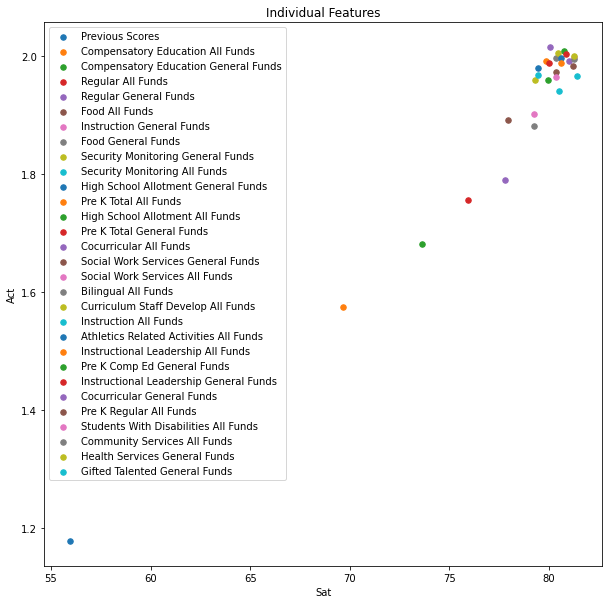

In [23]:
indiv_sat = individual_df.filter(regex=".*Sat$",axis=0).reset_index().groupby("index").mean().sort_values(by="Total MSE")["Total MSE"].to_frame().rename(columns={"Total MSE":"SAT"},index=lambda x: re.sub("_Sat$","",x)).rename(index={"Avg_Sat":"Previous_Scores"})
indiv_act = individual_df.filter(regex=".*Act$",axis=0).reset_index().groupby("index").mean().sort_values(by="Total MSE")["Total MSE"].to_frame().rename(columns={"Total MSE":"ACT"},index=lambda x: re.sub("_Act$","",x)).rename(index={"Avg_Act":"Previous_Scores"})
indiv_sat_act = pd.concat([indiv_sat, indiv_act], axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Individual Features")
plt.xlabel("Sat")
plt.ylabel("Act")
for i, row in enumerate(indiv_sat_act.head(30).iterrows()):
#     print(row)
    ax.scatter(row[1]['SAT'], row[1]['ACT'], label=row[0].replace('_', ' '), s=30)
ax.legend()
indiv_sat_act.head(30)

### Individual Feature Graphs

<AxesSubplot:title={'center':'Security Budget Percentage vs ACT score'}, xlabel='Security_Monitoring_All_Funds', ylabel='Avg_Act'>

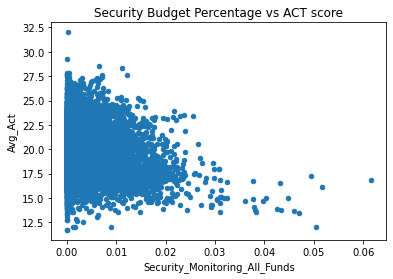

In [34]:
pd.concat([functions_df_perc, test_scores_df["Avg_Act"].to_frame()], axis=1)[["Security_Monitoring_All_Funds", "Avg_Act"]].dropna().plot(
        kind="scatter",
        x="Security_Monitoring_All_Funds",
        y="Avg_Act",
        title="Security Budget Percentage vs ACT score"
)

<AxesSubplot:title={'center':'Compensatory Education Budget Percentage vs ACT score'}, xlabel='Compensatory_Education_All_Funds', ylabel='Avg_Act'>

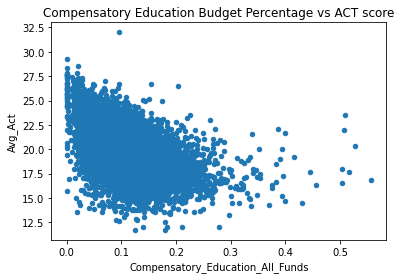

In [35]:
pd.concat([program_df_perc, test_scores_df["Avg_Act"].to_frame()], axis=1)[["Compensatory_Education_All_Funds", "Avg_Act"]].dropna().plot(
        kind="scatter",
        x="Compensatory_Education_All_Funds",
        y="Avg_Act",
        title="Compensatory Education Budget Percentage vs ACT score"
)

<AxesSubplot:title={'center':'Regular_All_Funds Budget Percentage vs ACT score'}, xlabel='Regular_All_Funds', ylabel='Avg_Act'>

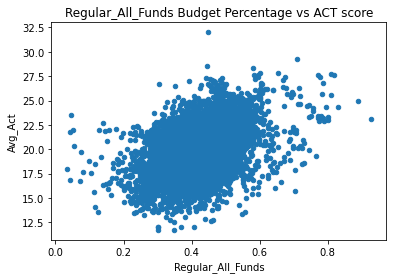

In [30]:
pd.concat([program_df_perc, test_scores_df["Avg_Act"].to_frame()], axis=1)[["Regular_All_Funds", "Avg_Act"]].dropna().plot(
        kind="scatter",
        x="Regular_All_Funds",
        y="Avg_Act",
        title="Regular Program Budget Percentage vs ACT score"
)

<AxesSubplot:title={'center':'Food Budget Percentage vs ACT score'}, xlabel='Food_All_Funds', ylabel='Avg_Act'>

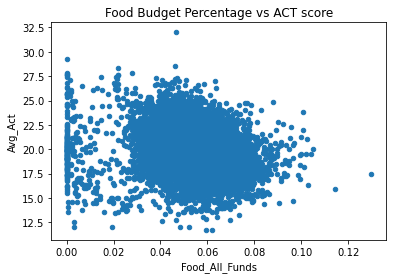

In [37]:
pd.concat([functions_df_perc, test_scores_df["Avg_Act"].to_frame()], axis=1)[["Food_All_Funds", "Avg_Act"]].dropna().plot(
        kind="scatter",
        x="Food_All_Funds",
        y="Avg_Act",
        title="Food Budget Percentage vs ACT score"
)

<AxesSubplot:title={'center':'Instruction Budget Percentage vs ACT score'}, xlabel='Instruction_General_Funds', ylabel='Avg_Act'>

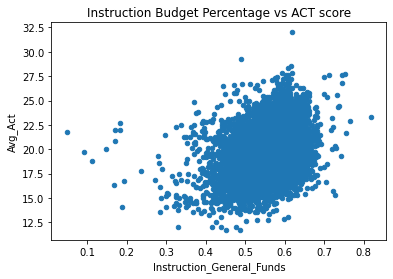

In [32]:
pd.concat([functions_df_perc, test_scores_df["Avg_Act"].to_frame()], axis=1)[["Instruction_General_Funds", "Avg_Act"]].dropna().plot(
        kind="scatter",
        x="Instruction_General_Funds",
        y="Avg_Act",
        title="Instruction Budget Percentage vs ACT score"
)